In [4]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [6]:
class PatchEmbed(nn.Module):
    """
    Patch embedding module.
    Splits the image into non-overlapping patches and then embeds them.

    Parameters:
    - in_channels: Number of input channels
    - patch_size: Size of the patch
    - emb_size: Size of the embedding (after the patch embedding)
    - img_size: Size of the image (image has to be square)

    Attributes:
    - n_patches: Number of patches inside a single image
    - projection: Convolutional layer that does both the splitting into patches and the embedding
    
    """

    def __init__(self, img_size, in_channels=3, patch_size = 16 , emb_size=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.projection = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        """
        Perform the forward pass of the PatchEmbed module.
        
        Parameters:
        x : torch.Tensor.Shape (n_samples, in_channels, img_size, img_size)

        Returns:
        torch.Tensor.Shape (n_samples, n_patches, emb_size)

        """
        x = self.projection(x) # (n_samples, emb_size, n_patches ** 0.5, n_patches ** 0.5)
        x = x.flatten(2) # (n_samples, emb_size, n_patches)
        x = x.transpose(1, 2) # (n_samples, n_patches, emb_size)
        return x
    
class Attention(nn.Module):
    """
    Attention module.
    
    Parameters:
    - emb_size: Size of the embedding (input and out dimension of per token features)
    - n_heads: Number of attention heads
    -drop_prob_qkv: Dropout rate to apply to the query, key and value tensors
    - drop_prob_o: Dropout rate after the softmax layer
    -qkv_bias: Whether to include bias in the qkv projection layers
    - causal: Whether to apply causal masking or not
    
    Attributes:
    - scales: Precomputed square root of the head_dim
    - qkv: Linear layer for the query, key and value
    - proj_qkv: linear mapping that takes in concatenated output of all heads and projects it back to new space
    - dropout_qkv, dropout_o: Dropout layer

    
    """
    
    def __init__(self, emb_size, n_heads = 12, drop_prob_o = 0.,drop_prob_qkv = 0., qkv_bias = True):
        super().__init__()
        self.emb_size = emb_size
        self.n_heads = n_heads
        self.head_dim = emb_size // n_heads
        assert self.head_dim * n_heads == emb_size, "Embedding size should be divisible by the number of heads"
        self.scales = self.head_dim ** -0.5
        self.qkv = nn.Linear(emb_size, emb_size * 3, bias = qkv_bias) # q, k, v
        self.dropout_qkv = nn.Dropout(drop_prob_qkv)
        self.proj_qkv = nn.Linear(emb_size, emb_size)
        self.dropout_o = nn.Dropout(drop_prob_o)
        
    def forward(self, x):
        """
        Perform the forward pass of the Attention module.
        
        Parameters:
        x : torch.Tensor.Shape (n_samples, n_patches + 1, emb_size)

        Returns:
        torch.Tensor.Shape (n_samples, n_patches + 1, emb_size)

        """
        
        n_samples, n_tokens, emb_size = x.shape
        if emb_size != self.emb_size:
            raise ValueError(f"Attention expects {self.emb_size} input features, but got {emb_size}")
        qkv = self.qkv(x).reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim) # (n_samples, n_patches + 1, 3 * dim), (n_samples, n_patches + 1, 3, n_heads, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4) # (3, n_samples, n_heads, n_patches + 1, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1) # (n_samples, n_heads, head_dim, n_patches + 1)
        dots = (q @ k_t) * self.scales # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = dots.softmax(dim=-1) # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = self.dropout_qkv(attn)
        weighted_avg = attn @ v # (n_samples, n_heads, n_patches + 1, head_dim)
        weighted_avg = weighted_avg.transpose(1, 2) # (n_samples, n_patches + 1, n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2) # (n_samples, n_patches + 1, emb_size)
        x = self.proj_qkv(weighted_avg) # (n_samples, n_patches + 1, emb_size)
        x = self.dropout_o(x)
        return x
        
class MLP(nn.Module):
    """
    MLP module.

    Parameters:
    - in_features: Number of input features
    - hidden_features: Number of hidden layer features
    - out_features: Number of output features
    - drop_prob: Dropout rate to apply

    Attributes:
    - fc1, fc2: Linear layers -> nn.Linear(in_features, hidden_features), nn.Linear(hidden_features, out_features)
    - act_fn: GELU activation function -> nn.GELU()
    - dropout: Dropout layer -> nn.Dropout(drop_prob)

    """
    def __init__(self, in_features, hidden_features, out_features, drop_prob = 0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act_fn = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(drop_prob)

    def forward(self, x):
        """
        Perform the forward pass of the MLP module.
        
        Parameters:
        x : torch.Tensor.Shape (n_samples, n_patches + 1, emb_size or input_features)

        Returns:
        torch.Tensor.Shape (n_samples, n_patches + 1, emb_size or out_features)

        """
        x = self.fc1(x) # (n_samples, n_patches + 1, hidden_features)
        x = self.act_fn(x) # (n_samples, n_patches + 1, hidden_features)
        x = self.dropout(x) # (n_samples, n_patches + 1, hidden_features)
        x = self.fc2(x) # (n_samples, n_patches + 1, out_features)
        x = self.dropout(x) # (n_samples, n_patches + 1, out_features)  # here out_features are same as hidden_features

        return x
    
class Block(nn.Module):
    """
    Transformer block.

    Parameters:
    - emb_size: Size of the input embedding
    - n_heads: Number of attention heads
    - mlp_ratio: Multiplier for the hidden dim of the MLP wrt the input embedding
    - qkv_bias: Whether to include bias in the qkv projection layers
    - drop_prob: Dropout rate to apply
    - attn_drop_prob: Dropout rate to apply to the attention module

    Attributes:
    - norm1, norm2: LayerNorms  # Layer norm makes sure that the mean of each sample is 0 and the standard deviation is 1
    - attn: Attention module
    - mlp: MLP module

    """
    def __init__(self, emb_size, n_heads, mlp_ratio = 4., qkv_bias = True, drop_prob = 0., attn_drop_prob = 0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_size, eps=1e-6)
        self.attn = Attention(emb_size, n_heads, drop_prob_o = attn_drop_prob, drop_prob_qkv = attn_drop_prob, qkv_bias = qkv_bias)
        self.norm2 = nn.LayerNorm(emb_size, eps=1e-6)
        hidden_features = int(emb_size * mlp_ratio)
        self.mlp = MLP(emb_size, hidden_features, emb_size, drop_prob)

    def forward(self, x):
        """
        Perform the forward pass of the Block module.
        
        Parameters:
        x : torch.Tensor.Shape (n_samples, n_patches + 1, emb_size)

        Returns:
        torch.Tensor.Shape (n_samples, n_patches + 1, emb_size)

        """
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x
    
class VisionTransformer(nn.Module):
    """
    Vision Transformer.

    Parameters:
    - img_size: Size of the image (image has to be square)
    - patch_size: Size of the patch
    - in_channels: Number of input channels
    - n_classes: Number of output classes
    - emb_size: Size of the token/patch embedding
    - depth: Number of transformer blocks
    - n_heads: Number of attention heads
    - mlp_ratio: Multiplier for the hidden dim of the MLP wrt the input embedding
    - qkv_bias: Whether to include bias in the qkv projection layers
    - drop_prob: Dropout rate to apply
    - attn_drop_prob: Dropout rate to apply to the attention module

    Attributes:
    - patch_embed: PatchEmbed module
    - cls_token: Learnable parameter that will represent the whole image or 1st token in sequence.
    - pos_embed: Positional embedding of cls token + all the patches and it has (n_patches + 1)* emb_size elements.
    - pos_drop: Dropout layer
    - blocks: Sequence of the transformer blocks
    - norm: Layer norm

    """
    def __init__(self, img_size = 384, patch_size = 16, in_channels = 3, n_classes = 1000, emb_size = 768, depth = 12, n_heads = 12, mlp_ratio = 4., qkv_bias = True, drop_prob = 0., attn_drop_prob = 0.):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, in_channels, patch_size, emb_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + self.patch_embed.n_patches, emb_size))
        self.pos_drop = nn.Dropout(drop_prob)
        self.blocks = nn.ModuleList([Block(emb_size, n_heads, mlp_ratio, qkv_bias, drop_prob, attn_drop_prob) for _ in range(depth)])
        self.norm = nn.LayerNorm(emb_size, eps=1e-6)
        self.head = nn.Linear(emb_size, n_classes)

    def forward(self, x):
        """
        Perform the forward pass of the VisionTransformer module.
        
        Parameters:
        x : torch.Tensor.Shape (n_samples, in_channels, img_size, img_size)

        Returns:
        torch.Tensor.Shape (n_samples, n_classes) logits over all the classes

        """
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(n_samples, -1, -1) # (n_samples, 1, emb_size)
        x = torch.cat((cls_token, x), dim=1) # (n_samples, 1 + n_patches, emb_size)
        x = x + self.pos_embed # (n_samples, 1 + n_patches, emb_size)
        x = self.pos_drop(x)
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        cls_token_final = x[:, 0]
        x = self.head(cls_token_final)
        return x

In [7]:
custom_config = {"img_size": 32, "patch_size": 4, "in_channels": 3, "n_classes": 10, "emb_size": 48, "depth": 12, "n_heads": 4, "mlp_ratio": 4., "qkv_bias": True, "drop_prob": 0.3, "attn_drop_prob": 0.3}

In [8]:
model_custom = VisionTransformer(**custom_config)

In [9]:
model_custom.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (projection): Conv2d(3, 48, kernel_size=(4, 4), stride=(4, 4))
  )
  (pos_drop): Dropout(p=0.3, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((48,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=48, out_features=144, bias=True)
        (dropout_qkv): Dropout(p=0.3, inplace=False)
        (proj_qkv): Linear(in_features=48, out_features=48, bias=True)
        (dropout_o): Dropout(p=0.3, inplace=False)
      )
      (norm2): LayerNorm((48,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=48, out_features=192, bias=True)
        (act_fn): GELU(approximate='none')
        (fc2): Linear(in_features=192, out_features=48, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (norm): LayerNorm((48,), eps=1e-06, elementwise_affine=True)
  (head): Linear(in_features=48, out_features=10, bia

In [10]:
inp = torch.randn(1, 3, 32, 32)
res_c = model_custom(inp)

In [17]:
torch.cuda.device_count()

1

In [19]:
import matplotlib.pyplot as plt

In [20]:
import numpy as np

In [ ]:
# %pip install datasets

In [ ]:
def get_cifar_dataloaders(batch_size, train_size=0.8):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    # Split the trainset into training and validation sets
    train_size = int(train_size * len(trainset))
    valid_size = len(trainset) - train_size
    trainset, validset = torch.utils.data.random_split(trainset, [train_size, valid_size])

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=2)

    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, validloader, testloader

# EXPERIMENT 1

In [53]:
import matplotlib.pyplot as plt

def train_model(model, trainloader, validloader, testloader, n_epochs, lr, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    
    train_loss_history = []
    train_acc_history = []
    train_size = len(trainloader.dataset)


    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        correct_train = 0
        total_train = 0 
        # Training phase
        model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct_train / total_train
        
        # Validation phase
        model.eval()
   
        
        # Print training loss and accuracy
        print('[Epoch %d/%d] Train Loss: %.4f, Train Acc: %.2f%% ' % (
            epoch + 1, n_epochs, train_loss, train_accuracy))
        
        # Save loss and accuracy history for plotting
        train_loss_history.append(train_loss)
        train_acc_history.append(train_accuracy)
     

    print('Finished Training')
    
    # Test phase
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print('Test Accuracy: %.2f%%' % test_accuracy)
    
    # Plotting loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Training Loss')
  
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss (Train Size: {train_size})')

    plt.legend()
    plt.show()
    
    # Plotting accuracy curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc_history, label='Training Accuracy')
    # plt.plot(valid_acc_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    # plt.title('Training and Validation Accuracy')
    plt.title(f'Training Accuracy (Train Size: {train_size})')

    plt.legend()
    plt.show()


In [27]:
custom_config = {"img_size": 32, "patch_size": 4, "in_channels": 3, "n_classes": 10, "emb_size": 48, "depth": 12, "n_heads": 4, "mlp_ratio": 4., "qkv_bias": True, "drop_prob": 0.3, "attn_drop_prob": 0.3}

Files already downloaded and verified
Files already downloaded and verified
Trainloader size: 50000
Validloader size: 0
Testloader size: 10000
[Epoch 1/50] Train Loss: 1.9881, Train Acc: 25.61% 
[Epoch 2/50] Train Loss: 1.7545, Train Acc: 35.74% 
[Epoch 3/50] Train Loss: 1.6325, Train Acc: 40.57% 
[Epoch 4/50] Train Loss: 1.5641, Train Acc: 43.01% 
[Epoch 5/50] Train Loss: 1.4982, Train Acc: 45.59% 
[Epoch 6/50] Train Loss: 1.4541, Train Acc: 47.21% 
[Epoch 7/50] Train Loss: 1.4170, Train Acc: 48.20% 
[Epoch 8/50] Train Loss: 1.3816, Train Acc: 50.23% 
[Epoch 9/50] Train Loss: 1.3485, Train Acc: 50.92% 
[Epoch 10/50] Train Loss: 1.3183, Train Acc: 52.30% 
[Epoch 11/50] Train Loss: 1.2982, Train Acc: 53.06% 
[Epoch 12/50] Train Loss: 1.2726, Train Acc: 54.07% 
[Epoch 13/50] Train Loss: 1.2532, Train Acc: 54.71% 
[Epoch 14/50] Train Loss: 1.2308, Train Acc: 55.69% 
[Epoch 15/50] Train Loss: 1.2043, Train Acc: 56.52% 
[Epoch 16/50] Train Loss: 1.1911, Train Acc: 56.97% 
[Epoch 17/50] Trai

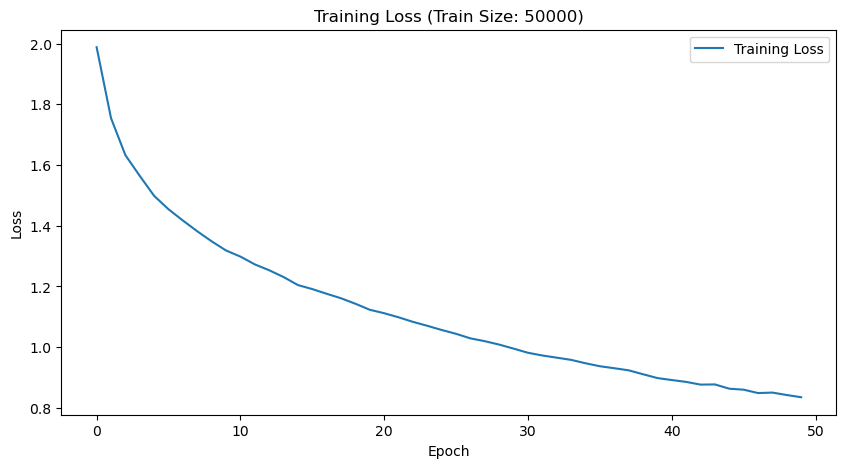

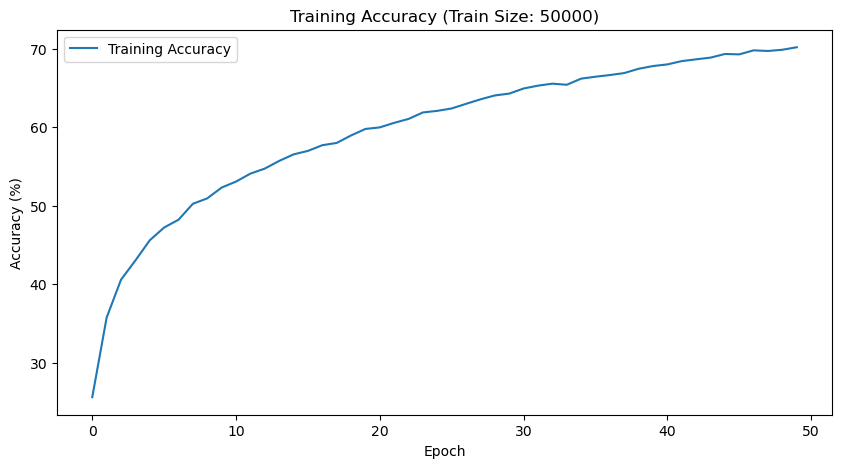

In [55]:
batch_size = 128
train_size = [1]
# train_size = [0.05]
for size in train_size:
    trainloader, validloader, testloader = get_cifar_dataloaders(batch_size, train_size=size)
    print(f"Trainloader size: {len(trainloader.dataset)}")
    print(f"Validloader size: {len(validloader.dataset)}")
    print(f"Testloader size: {len(testloader.dataset)}")
    model_custom = VisionTransformer(**custom_config)
    train_model(model_custom, trainloader, validloader, testloader, n_epochs=50, lr=0.001, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [25]:
# %pip install torchvision

# EXPERIMENT 2

In [29]:
# %pip install matplotlib

In [ ]:
import matplotlib.pyplot as plt

def train_model(model, trainloader, validloader, testloader, n_epochs, lr, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    
    train_loss_history = []
    valid_loss_history = []
    train_acc_history = []
    valid_acc_history = []
    train_size = len(trainloader.dataset)
    valid_size = len(validloader.dataset)

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        correct_valid = 0
        total_valid = 0
        
        # Training phase
        model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct_train / total_train
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for data in validloader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total_valid += labels.size(0)
                correct_valid += predicted.eq(labels).sum().item()

        valid_loss = running_loss / len(validloader)
        valid_accuracy = 100 * correct_valid / total_valid
        
        # Print training and validation loss and accuracy
        print('[Epoch %d/%d] Train Loss: %.4f, Train Acc: %.2f%% | Valid Loss: %.4f, Valid Acc: %.2f%%' % (
            epoch + 1, n_epochs, train_loss, train_accuracy, valid_loss, valid_accuracy))
        
        # Save loss and accuracy history for plotting
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        train_acc_history.append(train_accuracy)
        valid_acc_history.append(valid_accuracy)

    print('Finished Training')
    
    # Test phase
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print('Test Accuracy: %.2f%%' % test_accuracy)
    
    # Plotting loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(valid_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # plt.title('Training and Validation Loss')
    plt.title(f'Training and Validation Loss (Train Size: {train_size}, Valid Size: {valid_size})')

    plt.legend()
    plt.show()
    
    # Plotting accuracy curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc_history, label='Training Accuracy')
    plt.plot(valid_acc_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    # plt.title('Training and Validation Accuracy')
    plt.title(f'Training and Validation Accuracy (Train Size: {train_size}, Valid Size: {valid_size})')

    plt.legend()
    plt.show()

Trainloader size: 2500
Validloader size: 47500
Testloader size: 10000
Files already downloaded and verified
Files already downloaded and verified
[Epoch 1/50] Train Loss: 2.3073, Train Acc: 13.52% | Valid Loss: 2.2165, Valid Acc: 17.32%
[Epoch 2/50] Train Loss: 2.1664, Train Acc: 18.60% | Valid Loss: 2.1383, Valid Acc: 19.24%
[Epoch 3/50] Train Loss: 2.1100, Train Acc: 18.84% | Valid Loss: 2.0933, Valid Acc: 21.46%
[Epoch 4/50] Train Loss: 2.0848, Train Acc: 20.88% | Valid Loss: 2.0471, Valid Acc: 23.47%
[Epoch 5/50] Train Loss: 2.0486, Train Acc: 24.16% | Valid Loss: 2.0199, Valid Acc: 24.45%
[Epoch 6/50] Train Loss: 2.0185, Train Acc: 23.72% | Valid Loss: 2.0297, Valid Acc: 24.81%
[Epoch 7/50] Train Loss: 1.9853, Train Acc: 25.88% | Valid Loss: 2.0184, Valid Acc: 23.81%
[Epoch 8/50] Train Loss: 1.9819, Train Acc: 26.24% | Valid Loss: 1.9903, Valid Acc: 26.14%
[Epoch 9/50] Train Loss: 1.9596, Train Acc: 27.00% | Valid Loss: 1.9552, Valid Acc: 28.36%
[Epoch 10/50] Train Loss: 1.9399, T

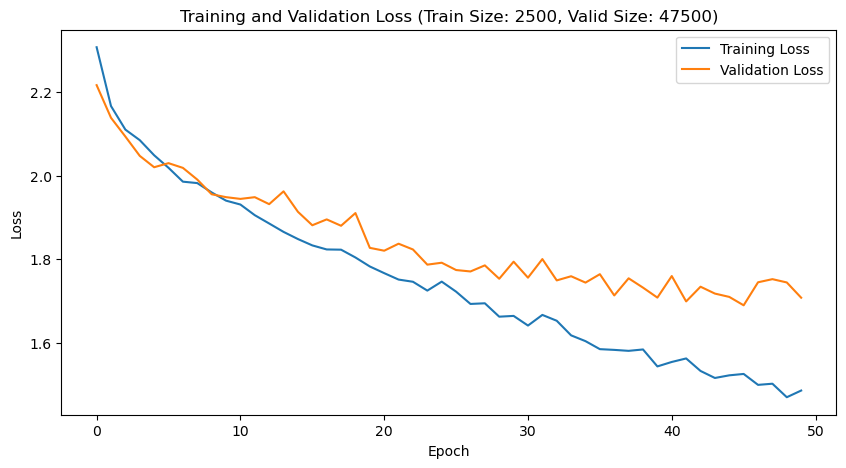

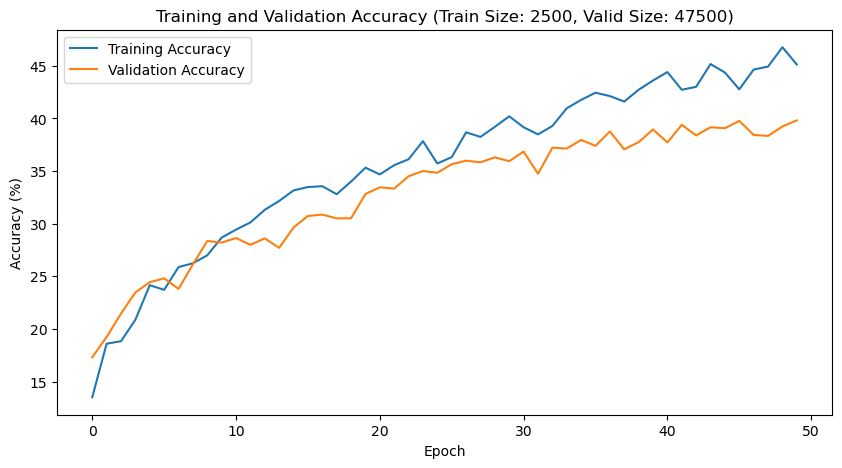

Trainloader size: 2500
Validloader size: 47500
Testloader size: 10000
Files already downloaded and verified
Files already downloaded and verified
[Epoch 1/50] Train Loss: 2.2508, Train Acc: 14.14% | Valid Loss: 2.1186, Valid Acc: 20.14%
[Epoch 2/50] Train Loss: 2.1196, Train Acc: 19.24% | Valid Loss: 2.0711, Valid Acc: 23.21%
[Epoch 3/50] Train Loss: 2.0772, Train Acc: 22.20% | Valid Loss: 2.0228, Valid Acc: 23.68%
[Epoch 4/50] Train Loss: 2.0520, Train Acc: 22.80% | Valid Loss: 1.9868, Valid Acc: 25.41%
[Epoch 5/50] Train Loss: 2.0022, Train Acc: 24.36% | Valid Loss: 1.9470, Valid Acc: 26.29%
[Epoch 6/50] Train Loss: 1.9621, Train Acc: 27.10% | Valid Loss: 1.9254, Valid Acc: 30.23%
[Epoch 7/50] Train Loss: 1.9350, Train Acc: 27.90% | Valid Loss: 1.9077, Valid Acc: 29.25%
[Epoch 8/50] Train Loss: 1.9145, Train Acc: 28.92% | Valid Loss: 1.8878, Valid Acc: 29.14%
[Epoch 9/50] Train Loss: 1.8871, Train Acc: 29.88% | Valid Loss: 1.8838, Valid Acc: 31.32%
[Epoch 10/50] Train Loss: 1.8579, T

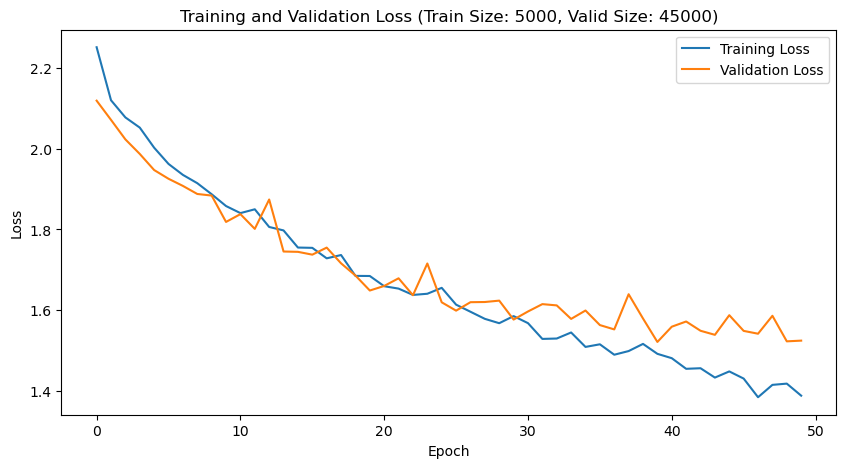

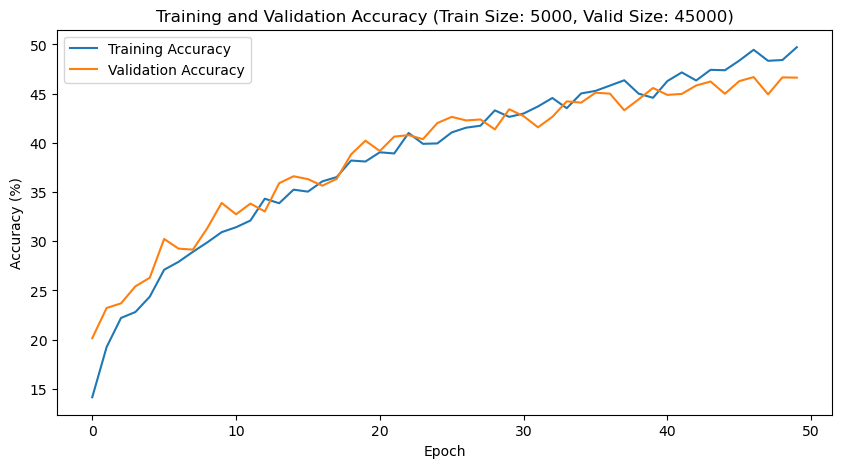

Trainloader size: 5000
Validloader size: 45000
Testloader size: 10000
Files already downloaded and verified
Files already downloaded and verified
[Epoch 1/50] Train Loss: 2.1647, Train Acc: 16.86% | Valid Loss: 2.0377, Valid Acc: 22.64%
[Epoch 2/50] Train Loss: 2.0062, Train Acc: 24.15% | Valid Loss: 1.9641, Valid Acc: 25.53%
[Epoch 3/50] Train Loss: 1.9344, Train Acc: 27.55% | Valid Loss: 1.8445, Valid Acc: 32.01%
[Epoch 4/50] Train Loss: 1.8545, Train Acc: 30.67% | Valid Loss: 1.8261, Valid Acc: 33.90%
[Epoch 5/50] Train Loss: 1.7967, Train Acc: 33.71% | Valid Loss: 1.7475, Valid Acc: 36.77%
[Epoch 6/50] Train Loss: 1.7547, Train Acc: 35.74% | Valid Loss: 1.6998, Valid Acc: 38.73%
[Epoch 7/50] Train Loss: 1.7126, Train Acc: 37.18% | Valid Loss: 1.6407, Valid Acc: 40.55%
[Epoch 8/50] Train Loss: 1.6708, Train Acc: 38.88% | Valid Loss: 1.6315, Valid Acc: 40.68%
[Epoch 9/50] Train Loss: 1.6496, Train Acc: 39.26% | Valid Loss: 1.6184, Valid Acc: 41.90%
[Epoch 10/50] Train Loss: 1.6232, T

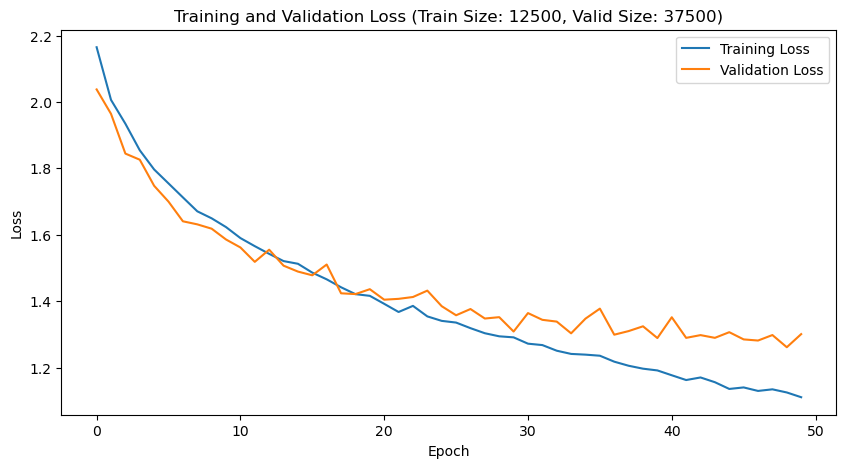

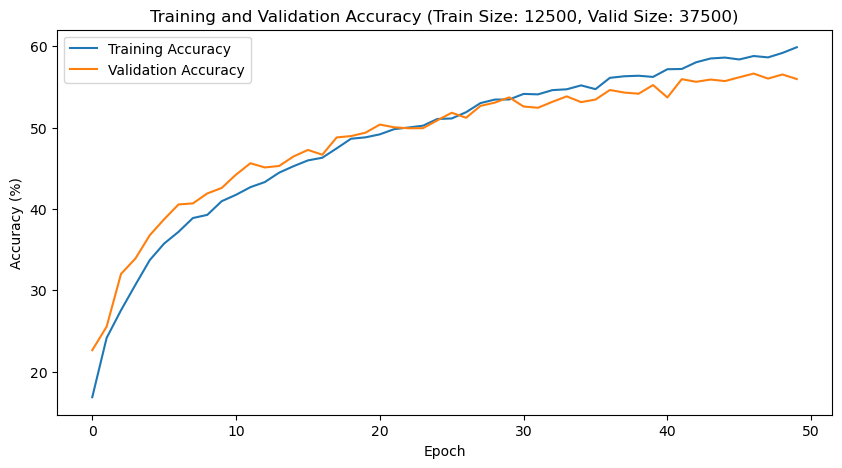

Trainloader size: 12500
Validloader size: 37500
Testloader size: 10000
Files already downloaded and verified
Files already downloaded and verified
[Epoch 1/50] Train Loss: 2.0833, Train Acc: 21.51% | Valid Loss: 1.9946, Valid Acc: 24.87%
[Epoch 2/50] Train Loss: 1.9128, Train Acc: 28.63% | Valid Loss: 1.8326, Valid Acc: 31.53%
[Epoch 3/50] Train Loss: 1.8109, Train Acc: 33.42% | Valid Loss: 1.7397, Valid Acc: 37.10%
[Epoch 4/50] Train Loss: 1.7394, Train Acc: 36.44% | Valid Loss: 1.7085, Valid Acc: 39.50%
[Epoch 5/50] Train Loss: 1.6742, Train Acc: 39.15% | Valid Loss: 1.6311, Valid Acc: 41.77%
[Epoch 6/50] Train Loss: 1.6298, Train Acc: 40.80% | Valid Loss: 1.5352, Valid Acc: 44.14%
[Epoch 7/50] Train Loss: 1.5838, Train Acc: 41.97% | Valid Loss: 1.4890, Valid Acc: 45.97%
[Epoch 8/50] Train Loss: 1.5380, Train Acc: 44.01% | Valid Loss: 1.4604, Valid Acc: 46.95%
[Epoch 9/50] Train Loss: 1.5056, Train Acc: 45.52% | Valid Loss: 1.4457, Valid Acc: 47.98%
[Epoch 10/50] Train Loss: 1.4746, 

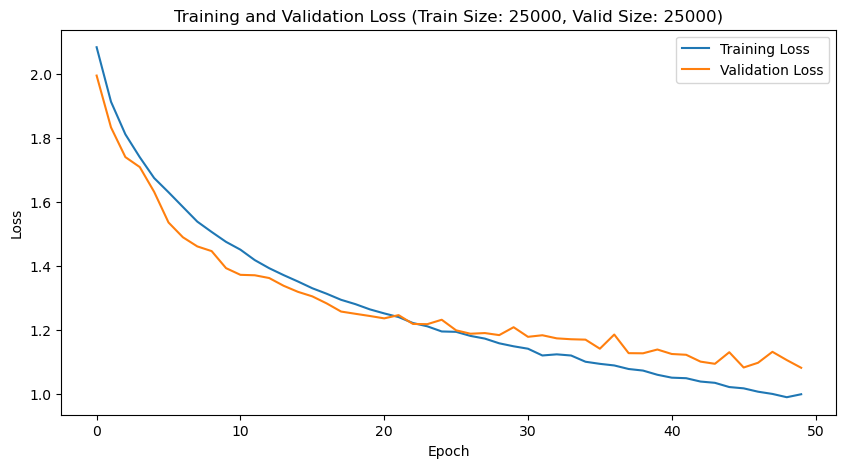

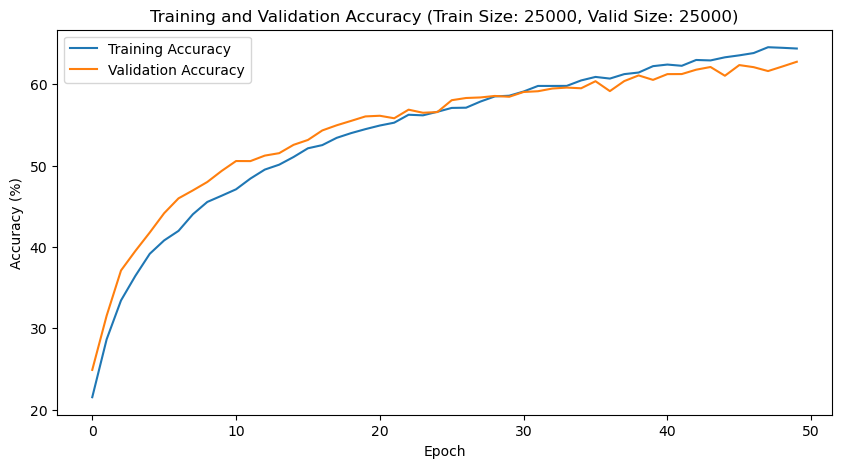

Trainloader size: 25000
Validloader size: 25000
Testloader size: 10000
Files already downloaded and verified
Files already downloaded and verified
[Epoch 1/50] Train Loss: 2.0162, Train Acc: 24.39% | Valid Loss: 1.8981, Valid Acc: 28.97%
[Epoch 2/50] Train Loss: 1.7933, Train Acc: 33.96% | Valid Loss: 1.7283, Valid Acc: 36.48%
[Epoch 3/50] Train Loss: 1.6789, Train Acc: 38.65% | Valid Loss: 1.5846, Valid Acc: 42.71%
[Epoch 4/50] Train Loss: 1.5994, Train Acc: 41.49% | Valid Loss: 1.5327, Valid Acc: 44.55%
[Epoch 5/50] Train Loss: 1.5371, Train Acc: 44.28% | Valid Loss: 1.4831, Valid Acc: 45.96%
[Epoch 6/50] Train Loss: 1.4853, Train Acc: 45.98% | Valid Loss: 1.4340, Valid Acc: 48.17%
[Epoch 7/50] Train Loss: 1.4401, Train Acc: 47.65% | Valid Loss: 1.3951, Valid Acc: 51.08%
[Epoch 8/50] Train Loss: 1.3995, Train Acc: 49.11% | Valid Loss: 1.3450, Valid Acc: 52.05%
[Epoch 9/50] Train Loss: 1.3665, Train Acc: 50.46% | Valid Loss: 1.3473, Valid Acc: 52.23%
[Epoch 10/50] Train Loss: 1.3472, 

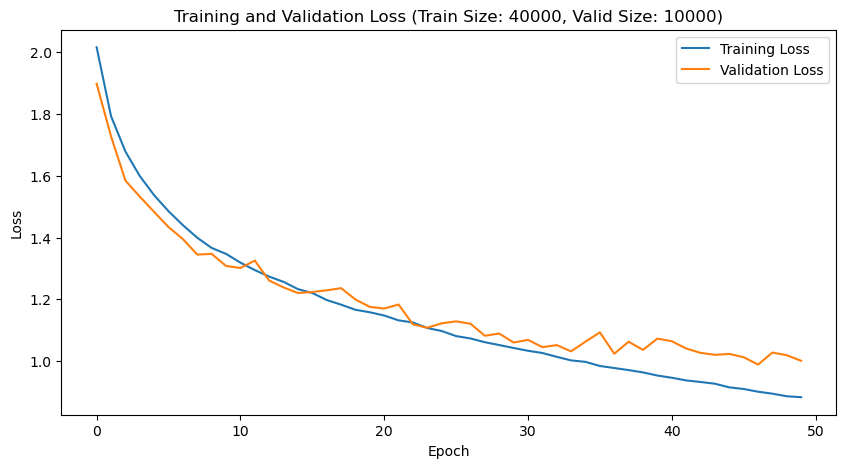

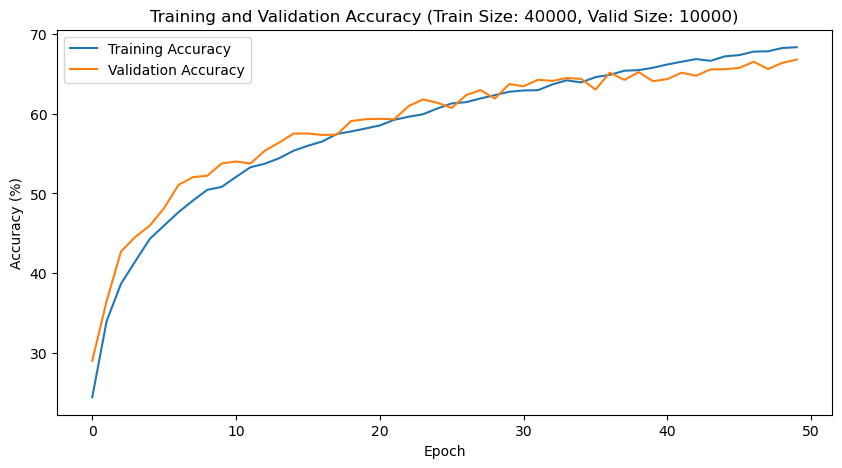

In [48]:
batch_size = 128
train_size = [0.05, 0.1, 0.25, 0.5, 0.8]
# train_size = [0.05]
for size in train_size:
    print(f"Trainloader size: {len(trainloader.dataset)}")
    print(f"Validloader size: {len(validloader.dataset)}")
    print(f"Testloader size: {len(testloader.dataset)}")
    trainloader, validloader, testloader = get_cifar_dataloaders(batch_size, train_size=size)
    model_custom = VisionTransformer(**custom_config)
    train_model(model_custom, trainloader, validloader, testloader, n_epochs=50, lr=0.001, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    # plot_curves(train_loss_history, valid_loss_history, train_acc_history, valid_acc_history)

# EXPERIMENT 3

In [62]:
def train_model(patch_size, emb_size,model, trainloader, validloader, testloader, n_epochs, lr,  device ):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    
    train_loss_history = []
    train_acc_history = []
    train_size = len(trainloader.dataset)


    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        correct_train = 0
        total_train = 0 
        # Training phase
        model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct_train / total_train
        
        # Validation phase
        model.eval()
   
        
        # Print training loss and accuracy
        print('[Epoch %d/%d] Train Loss: %.4f, Train Acc: %.2f%% ' % (
            epoch + 1, n_epochs, train_loss, train_accuracy))
        
        # Save loss and accuracy history for plotting
        train_loss_history.append(train_loss)
        train_acc_history.append(train_accuracy)
     

    print('Finished Training')
    
    # Test phase
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print('Test Accuracy: %.2f%%' % test_accuracy)
    
    # Plotting loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Training Loss')
  
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss (Patch Size: {patch_size}, embedding_size = {emb_size})')

    plt.legend()
    plt.show()
    
    # Plotting accuracy curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc_history, label='Training Accuracy')
    # plt.plot(valid_acc_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    # plt.title('Training and Validation Accuracy')
    plt.title(f'Training Accuracy (Patch Size: {patch_size}, embedding_size = {emb_size})')

    plt.legend()
    plt.show()


In [70]:
trainloader, validloader, testloader = get_cifar_dataloaders(batch_size = 256, train_size=1)

Files already downloaded and verified
Files already downloaded and verified


[Epoch 1/50] Train Loss: 2.0381, Train Acc: 23.13% 
[Epoch 2/50] Train Loss: 1.8132, Train Acc: 33.17% 
[Epoch 3/50] Train Loss: 1.6846, Train Acc: 38.54% 
[Epoch 4/50] Train Loss: 1.5862, Train Acc: 42.18% 
[Epoch 5/50] Train Loss: 1.5194, Train Acc: 44.80% 
[Epoch 6/50] Train Loss: 1.4705, Train Acc: 46.78% 
[Epoch 7/50] Train Loss: 1.4296, Train Acc: 48.06% 
[Epoch 8/50] Train Loss: 1.3979, Train Acc: 49.23% 
[Epoch 9/50] Train Loss: 1.3622, Train Acc: 50.69% 
[Epoch 10/50] Train Loss: 1.3353, Train Acc: 51.50% 
[Epoch 11/50] Train Loss: 1.3121, Train Acc: 52.45% 
[Epoch 12/50] Train Loss: 1.2848, Train Acc: 53.74% 
[Epoch 13/50] Train Loss: 1.2637, Train Acc: 54.31% 
[Epoch 14/50] Train Loss: 1.2411, Train Acc: 55.12% 
[Epoch 15/50] Train Loss: 1.2288, Train Acc: 55.86% 
[Epoch 16/50] Train Loss: 1.2062, Train Acc: 56.56% 
[Epoch 17/50] Train Loss: 1.1965, Train Acc: 57.08% 
[Epoch 18/50] Train Loss: 1.1797, Train Acc: 57.54% 
[Epoch 19/50] Train Loss: 1.1604, Train Acc: 58.07% 
[E

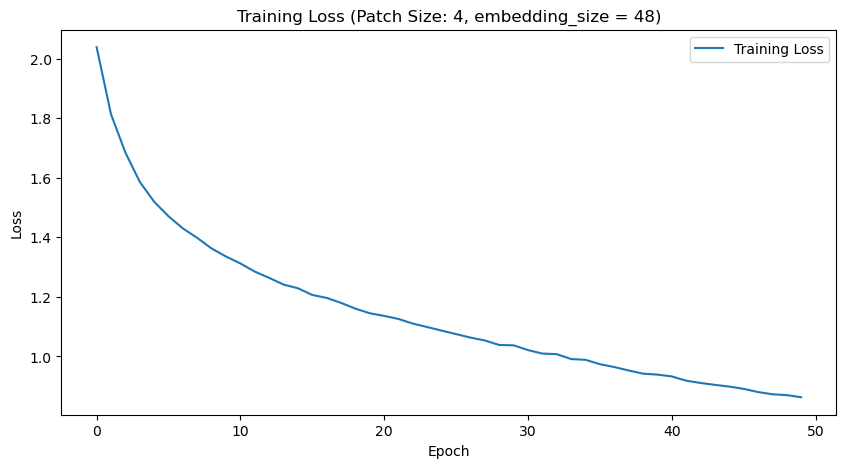

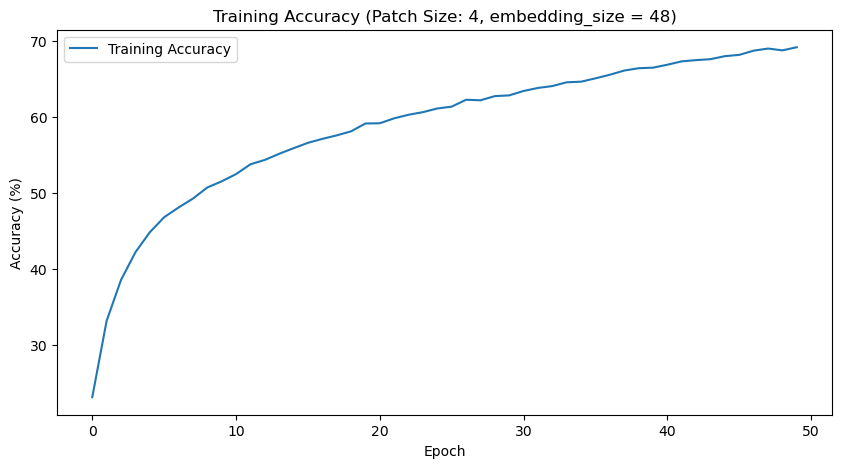

[Epoch 1/50] Train Loss: 1.9691, Train Acc: 26.51% 
[Epoch 2/50] Train Loss: 1.6987, Train Acc: 37.91% 
[Epoch 3/50] Train Loss: 1.5590, Train Acc: 43.35% 
[Epoch 4/50] Train Loss: 1.4839, Train Acc: 46.16% 
[Epoch 5/50] Train Loss: 1.4136, Train Acc: 48.50% 
[Epoch 6/50] Train Loss: 1.3614, Train Acc: 50.68% 
[Epoch 7/50] Train Loss: 1.3181, Train Acc: 52.28% 
[Epoch 8/50] Train Loss: 1.2695, Train Acc: 53.93% 
[Epoch 9/50] Train Loss: 1.2392, Train Acc: 55.11% 
[Epoch 10/50] Train Loss: 1.2141, Train Acc: 56.22% 
[Epoch 11/50] Train Loss: 1.1849, Train Acc: 57.57% 
[Epoch 12/50] Train Loss: 1.1577, Train Acc: 58.34% 
[Epoch 13/50] Train Loss: 1.1270, Train Acc: 59.70% 
[Epoch 14/50] Train Loss: 1.1089, Train Acc: 60.39% 
[Epoch 15/50] Train Loss: 1.0896, Train Acc: 60.92% 
[Epoch 16/50] Train Loss: 1.0655, Train Acc: 61.77% 
[Epoch 17/50] Train Loss: 1.0429, Train Acc: 62.81% 
[Epoch 18/50] Train Loss: 1.0263, Train Acc: 63.17% 
[Epoch 19/50] Train Loss: 1.0056, Train Acc: 63.92% 
[E

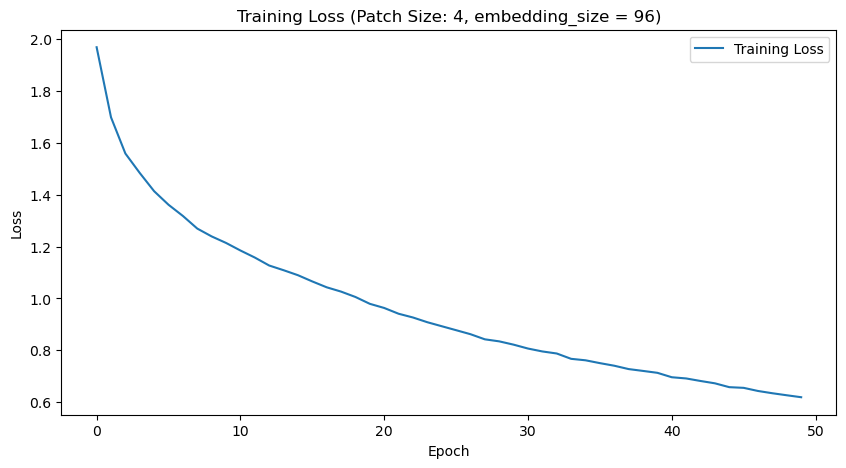

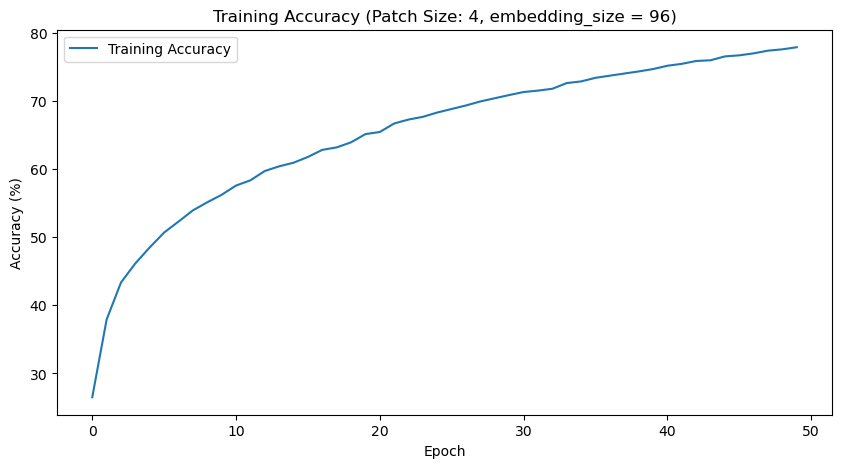

[Epoch 1/50] Train Loss: 1.9605, Train Acc: 26.92% 
[Epoch 2/50] Train Loss: 1.6931, Train Acc: 37.62% 
[Epoch 3/50] Train Loss: 1.5890, Train Acc: 42.12% 
[Epoch 4/50] Train Loss: 1.5243, Train Acc: 44.52% 
[Epoch 5/50] Train Loss: 1.4664, Train Acc: 46.62% 
[Epoch 6/50] Train Loss: 1.4187, Train Acc: 48.59% 
[Epoch 7/50] Train Loss: 1.3894, Train Acc: 49.41% 
[Epoch 8/50] Train Loss: 1.3515, Train Acc: 51.03% 
[Epoch 9/50] Train Loss: 1.3148, Train Acc: 52.48% 
[Epoch 10/50] Train Loss: 1.2862, Train Acc: 53.21% 
[Epoch 11/50] Train Loss: 1.2591, Train Acc: 54.36% 
[Epoch 12/50] Train Loss: 1.2385, Train Acc: 55.17% 
[Epoch 13/50] Train Loss: 1.2095, Train Acc: 56.29% 
[Epoch 14/50] Train Loss: 1.1882, Train Acc: 57.26% 
[Epoch 15/50] Train Loss: 1.1633, Train Acc: 58.07% 
[Epoch 16/50] Train Loss: 1.1390, Train Acc: 59.14% 
[Epoch 17/50] Train Loss: 1.1161, Train Acc: 59.79% 
[Epoch 18/50] Train Loss: 1.0970, Train Acc: 60.44% 
[Epoch 19/50] Train Loss: 1.0836, Train Acc: 61.18% 
[E

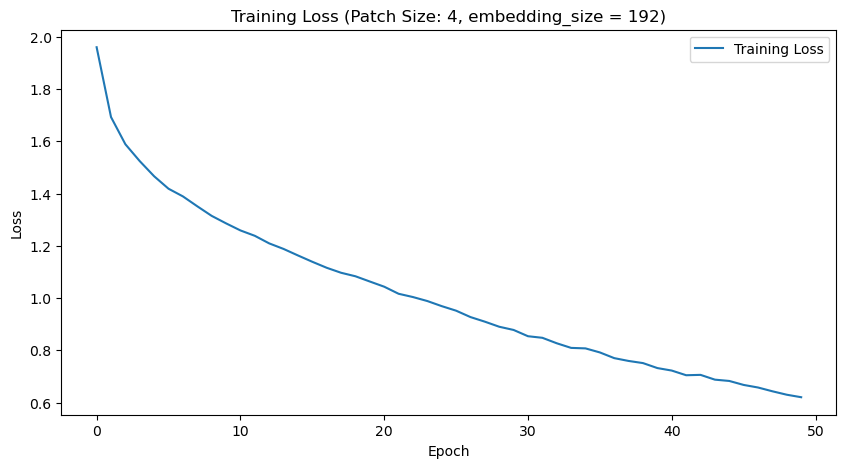

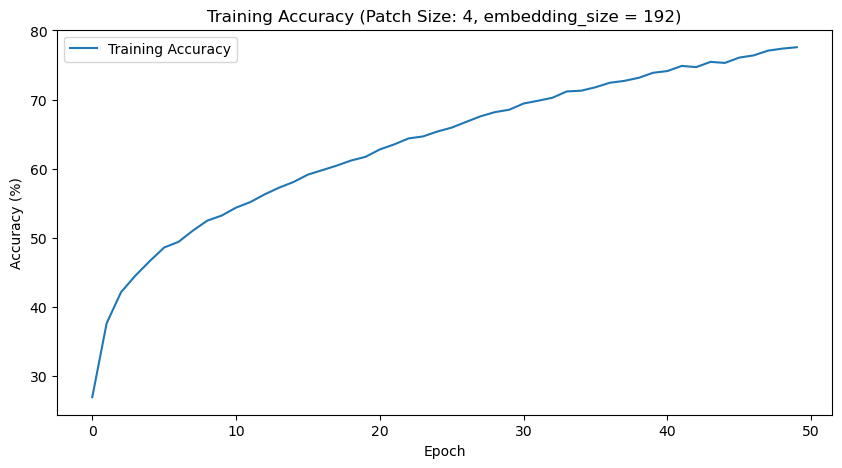

[Epoch 1/50] Train Loss: 1.9708, Train Acc: 26.62% 
[Epoch 2/50] Train Loss: 1.7260, Train Acc: 37.06% 
[Epoch 3/50] Train Loss: 1.6265, Train Acc: 40.94% 
[Epoch 4/50] Train Loss: 1.5655, Train Acc: 42.93% 
[Epoch 5/50] Train Loss: 1.5186, Train Acc: 44.70% 
[Epoch 6/50] Train Loss: 1.4854, Train Acc: 46.09% 
[Epoch 7/50] Train Loss: 1.4508, Train Acc: 47.35% 
[Epoch 8/50] Train Loss: 1.4248, Train Acc: 48.41% 
[Epoch 9/50] Train Loss: 1.4021, Train Acc: 49.26% 
[Epoch 10/50] Train Loss: 1.3852, Train Acc: 49.84% 
[Epoch 11/50] Train Loss: 1.3693, Train Acc: 50.38% 
[Epoch 12/50] Train Loss: 1.3516, Train Acc: 51.23% 
[Epoch 13/50] Train Loss: 1.3404, Train Acc: 51.46% 
[Epoch 14/50] Train Loss: 1.3222, Train Acc: 52.11% 
[Epoch 15/50] Train Loss: 1.3095, Train Acc: 52.70% 
[Epoch 16/50] Train Loss: 1.2938, Train Acc: 53.47% 
[Epoch 17/50] Train Loss: 1.2877, Train Acc: 53.46% 
[Epoch 18/50] Train Loss: 1.2741, Train Acc: 53.89% 
[Epoch 19/50] Train Loss: 1.2702, Train Acc: 54.16% 
[E

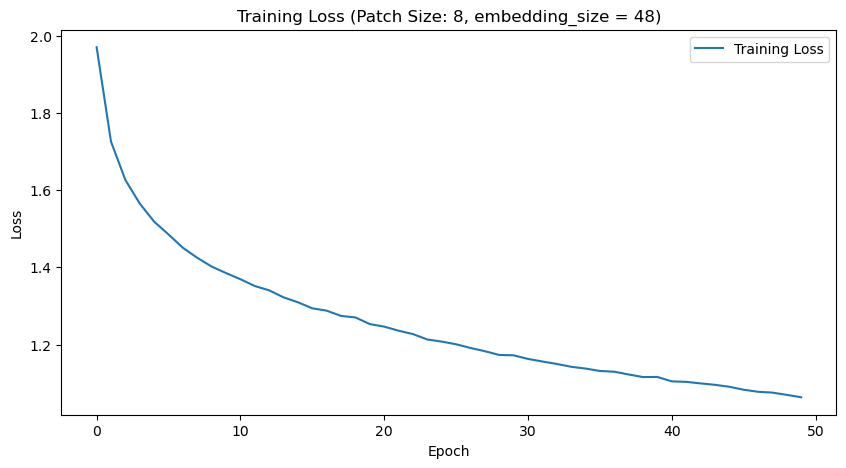

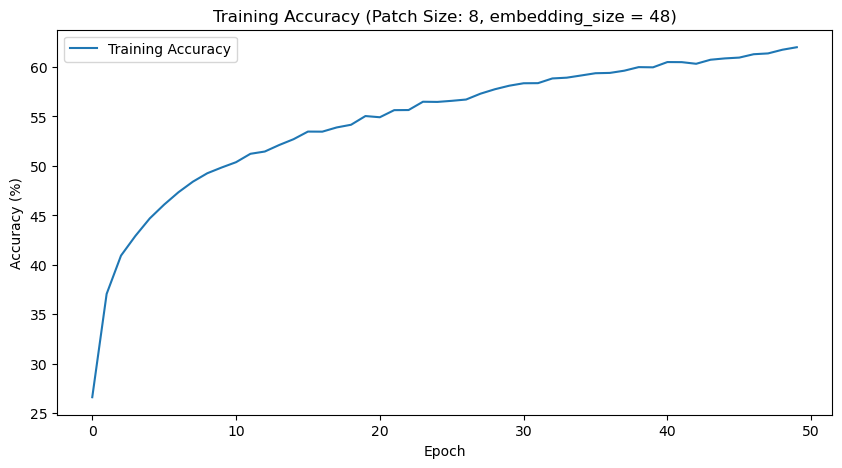

[Epoch 1/50] Train Loss: 1.9170, Train Acc: 29.17% 
[Epoch 2/50] Train Loss: 1.6516, Train Acc: 39.92% 
[Epoch 3/50] Train Loss: 1.5382, Train Acc: 44.37% 
[Epoch 4/50] Train Loss: 1.4720, Train Acc: 46.71% 
[Epoch 5/50] Train Loss: 1.4243, Train Acc: 48.32% 
[Epoch 6/50] Train Loss: 1.3915, Train Acc: 49.51% 
[Epoch 7/50] Train Loss: 1.3606, Train Acc: 50.70% 
[Epoch 8/50] Train Loss: 1.3317, Train Acc: 51.72% 
[Epoch 9/50] Train Loss: 1.3044, Train Acc: 53.09% 
[Epoch 10/50] Train Loss: 1.2859, Train Acc: 53.55% 
[Epoch 11/50] Train Loss: 1.2719, Train Acc: 54.35% 
[Epoch 12/50] Train Loss: 1.2504, Train Acc: 55.09% 
[Epoch 13/50] Train Loss: 1.2281, Train Acc: 55.55% 
[Epoch 14/50] Train Loss: 1.2135, Train Acc: 56.35% 
[Epoch 15/50] Train Loss: 1.1963, Train Acc: 56.99% 
[Epoch 16/50] Train Loss: 1.1803, Train Acc: 57.49% 
[Epoch 17/50] Train Loss: 1.1571, Train Acc: 58.40% 
[Epoch 18/50] Train Loss: 1.1451, Train Acc: 58.78% 
[Epoch 19/50] Train Loss: 1.1359, Train Acc: 59.40% 
[E

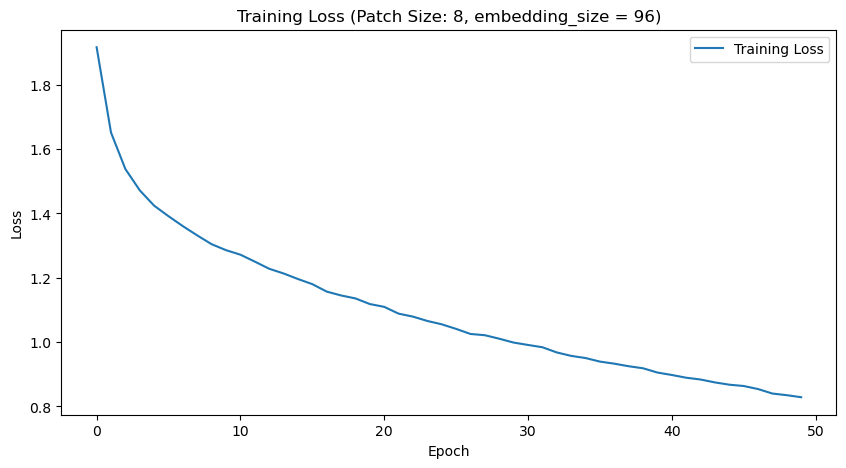

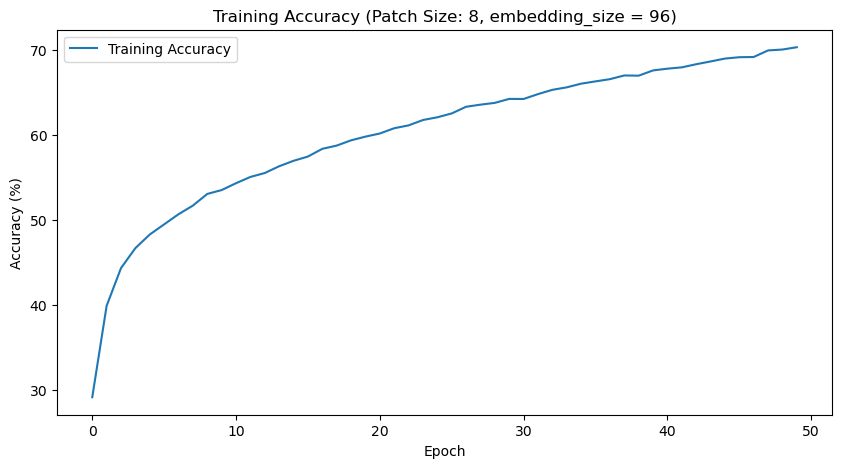

[Epoch 1/50] Train Loss: 1.9407, Train Acc: 28.26% 
[Epoch 2/50] Train Loss: 1.6637, Train Acc: 39.36% 
[Epoch 3/50] Train Loss: 1.5766, Train Acc: 42.90% 
[Epoch 4/50] Train Loss: 1.5120, Train Acc: 45.08% 
[Epoch 5/50] Train Loss: 1.4626, Train Acc: 46.94% 
[Epoch 6/50] Train Loss: 1.4249, Train Acc: 48.46% 
[Epoch 7/50] Train Loss: 1.3913, Train Acc: 49.78% 
[Epoch 8/50] Train Loss: 1.3632, Train Acc: 50.86% 
[Epoch 9/50] Train Loss: 1.3357, Train Acc: 51.88% 
[Epoch 10/50] Train Loss: 1.3230, Train Acc: 52.63% 
[Epoch 11/50] Train Loss: 1.2989, Train Acc: 53.17% 
[Epoch 12/50] Train Loss: 1.2800, Train Acc: 53.94% 
[Epoch 13/50] Train Loss: 1.2635, Train Acc: 54.58% 
[Epoch 14/50] Train Loss: 1.2464, Train Acc: 55.30% 
[Epoch 15/50] Train Loss: 1.2281, Train Acc: 56.04% 
[Epoch 16/50] Train Loss: 1.2194, Train Acc: 55.99% 
[Epoch 17/50] Train Loss: 1.1953, Train Acc: 57.20% 
[Epoch 18/50] Train Loss: 1.1847, Train Acc: 57.63% 
[Epoch 19/50] Train Loss: 1.1715, Train Acc: 58.01% 
[E

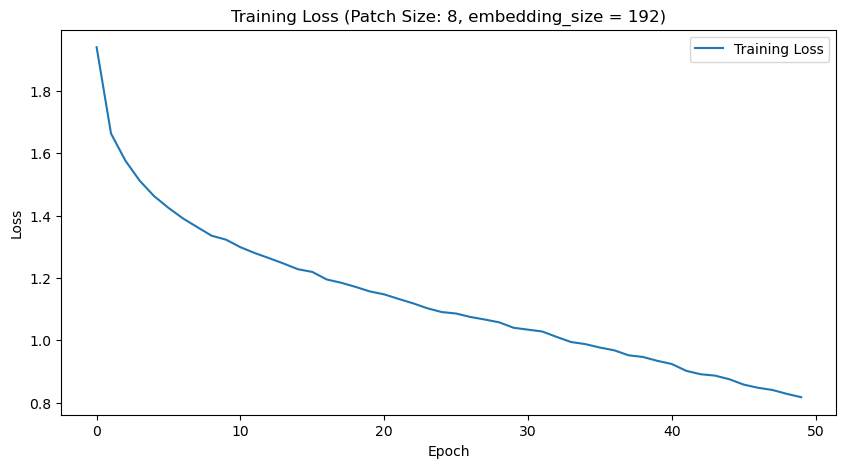

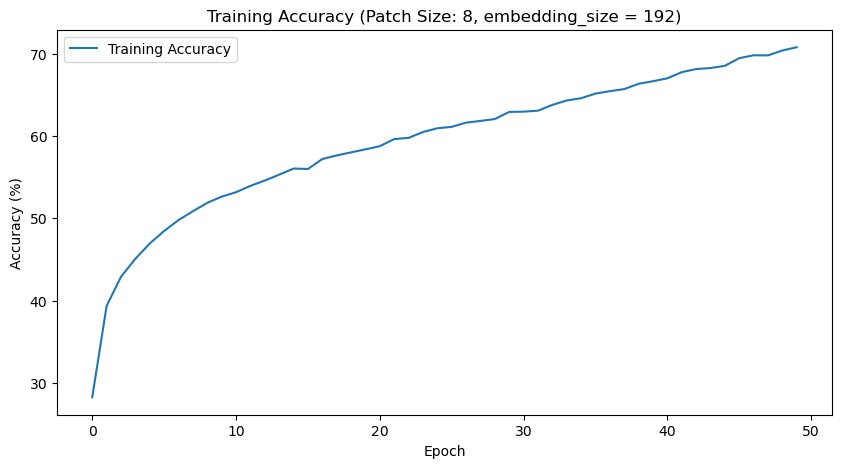

[Epoch 1/50] Train Loss: 1.9338, Train Acc: 28.70% 
[Epoch 2/50] Train Loss: 1.7344, Train Acc: 36.90% 
[Epoch 3/50] Train Loss: 1.6602, Train Acc: 39.66% 
[Epoch 4/50] Train Loss: 1.6124, Train Acc: 41.27% 
[Epoch 5/50] Train Loss: 1.5797, Train Acc: 42.67% 
[Epoch 6/50] Train Loss: 1.5509, Train Acc: 43.63% 
[Epoch 7/50] Train Loss: 1.5307, Train Acc: 44.75% 
[Epoch 8/50] Train Loss: 1.5082, Train Acc: 45.59% 
[Epoch 9/50] Train Loss: 1.4924, Train Acc: 46.00% 
[Epoch 10/50] Train Loss: 1.4790, Train Acc: 46.60% 
[Epoch 11/50] Train Loss: 1.4615, Train Acc: 47.54% 
[Epoch 12/50] Train Loss: 1.4446, Train Acc: 47.84% 
[Epoch 13/50] Train Loss: 1.4329, Train Acc: 48.45% 
[Epoch 14/50] Train Loss: 1.4243, Train Acc: 48.61% 
[Epoch 15/50] Train Loss: 1.4064, Train Acc: 49.23% 
[Epoch 16/50] Train Loss: 1.3969, Train Acc: 49.50% 
[Epoch 17/50] Train Loss: 1.3936, Train Acc: 50.08% 
[Epoch 18/50] Train Loss: 1.3771, Train Acc: 50.50% 
[Epoch 19/50] Train Loss: 1.3701, Train Acc: 50.81% 
[E

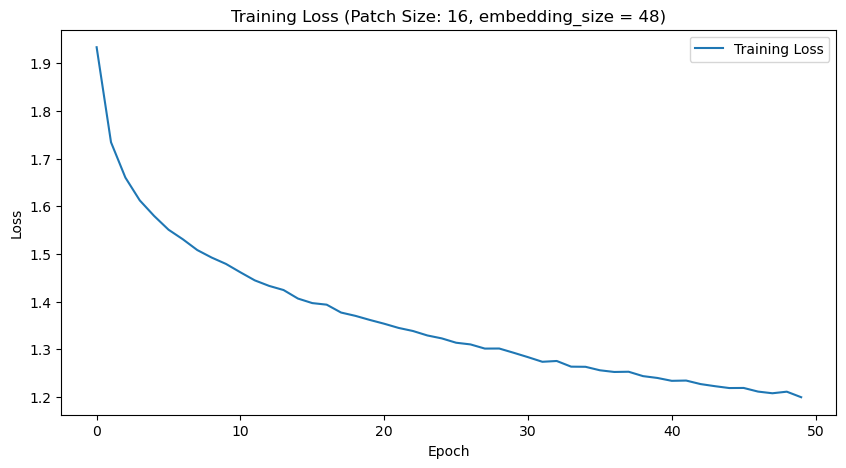

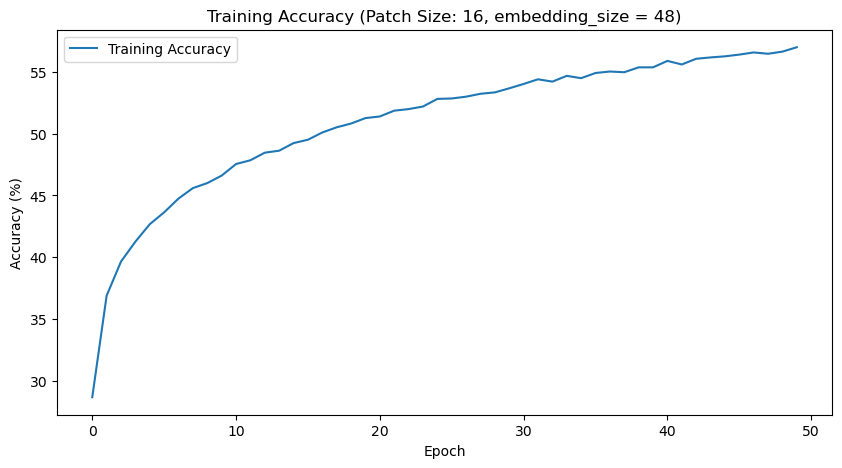

[Epoch 1/50] Train Loss: 1.8831, Train Acc: 31.25% 
[Epoch 2/50] Train Loss: 1.6740, Train Acc: 39.41% 
[Epoch 3/50] Train Loss: 1.5833, Train Acc: 42.66% 
[Epoch 4/50] Train Loss: 1.5322, Train Acc: 44.52% 
[Epoch 5/50] Train Loss: 1.4982, Train Acc: 46.03% 
[Epoch 6/50] Train Loss: 1.4618, Train Acc: 47.35% 
[Epoch 7/50] Train Loss: 1.4377, Train Acc: 48.43% 
[Epoch 8/50] Train Loss: 1.4153, Train Acc: 49.14% 
[Epoch 9/50] Train Loss: 1.3949, Train Acc: 49.69% 
[Epoch 10/50] Train Loss: 1.3712, Train Acc: 50.51% 
[Epoch 11/50] Train Loss: 1.3514, Train Acc: 51.44% 
[Epoch 12/50] Train Loss: 1.3339, Train Acc: 52.16% 
[Epoch 13/50] Train Loss: 1.3182, Train Acc: 52.81% 
[Epoch 14/50] Train Loss: 1.3042, Train Acc: 53.19% 
[Epoch 15/50] Train Loss: 1.2838, Train Acc: 53.86% 
[Epoch 16/50] Train Loss: 1.2688, Train Acc: 54.48% 
[Epoch 17/50] Train Loss: 1.2549, Train Acc: 54.96% 
[Epoch 18/50] Train Loss: 1.2378, Train Acc: 55.91% 
[Epoch 19/50] Train Loss: 1.2290, Train Acc: 55.75% 
[E

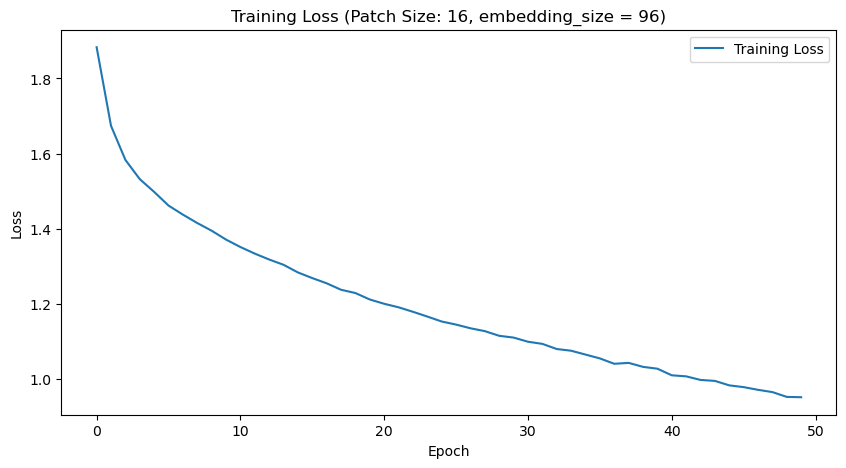

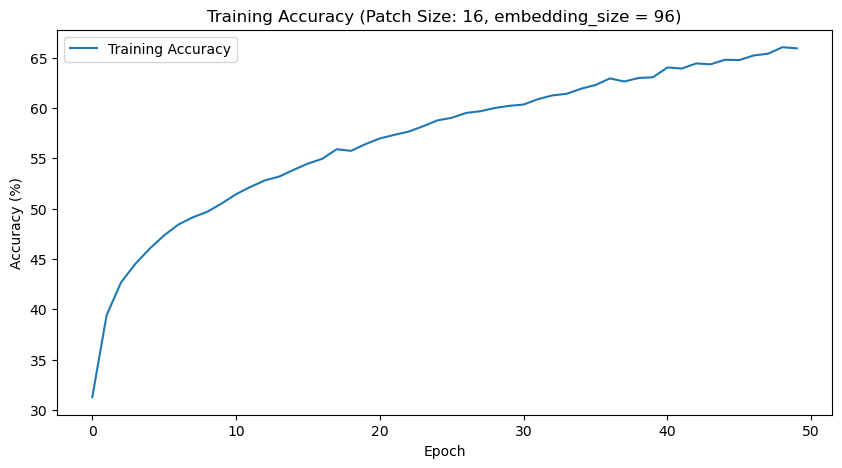

[Epoch 1/50] Train Loss: 1.9026, Train Acc: 30.79% 
[Epoch 2/50] Train Loss: 1.6605, Train Acc: 39.81% 
[Epoch 3/50] Train Loss: 1.5818, Train Acc: 42.66% 
[Epoch 4/50] Train Loss: 1.5380, Train Acc: 44.28% 
[Epoch 5/50] Train Loss: 1.5017, Train Acc: 45.58% 
[Epoch 6/50] Train Loss: 1.4671, Train Acc: 46.82% 
[Epoch 7/50] Train Loss: 1.4379, Train Acc: 48.10% 
[Epoch 8/50] Train Loss: 1.4154, Train Acc: 49.12% 
[Epoch 9/50] Train Loss: 1.3851, Train Acc: 50.22% 
[Epoch 10/50] Train Loss: 1.3666, Train Acc: 51.05% 
[Epoch 11/50] Train Loss: 1.3422, Train Acc: 51.65% 
[Epoch 12/50] Train Loss: 1.3268, Train Acc: 52.31% 
[Epoch 13/50] Train Loss: 1.3024, Train Acc: 53.09% 
[Epoch 14/50] Train Loss: 1.2877, Train Acc: 53.59% 
[Epoch 15/50] Train Loss: 1.2728, Train Acc: 54.28% 
[Epoch 16/50] Train Loss: 1.2544, Train Acc: 55.00% 
[Epoch 17/50] Train Loss: 1.2450, Train Acc: 55.15% 
[Epoch 18/50] Train Loss: 1.2314, Train Acc: 55.76% 
[Epoch 19/50] Train Loss: 1.2165, Train Acc: 56.50% 
[E

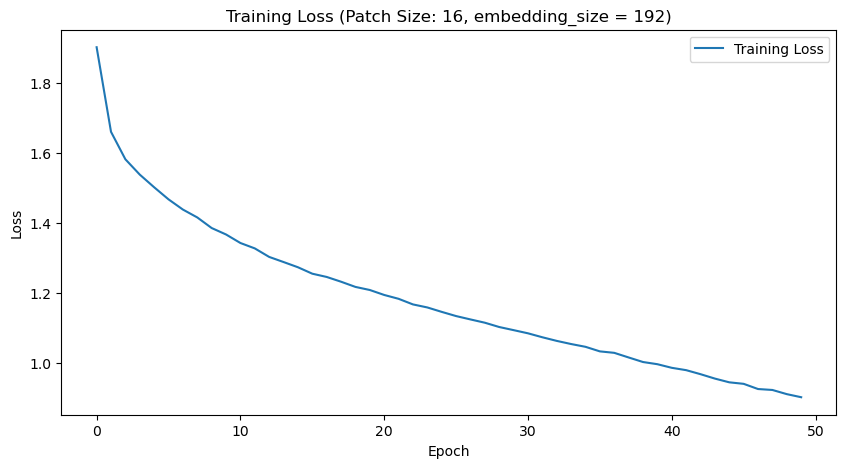

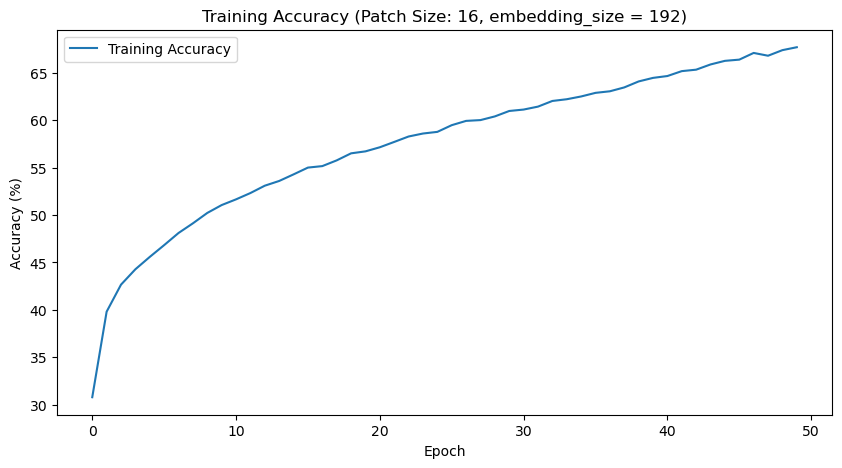

In [71]:
# try different patch sizes and embedding sizes for both overlapping and non-overlapping patches
patch_sizes = [4, 8, 16]
emb_sizes = [48, 96, 192]
for patch_size in patch_sizes:
    for emb_size in emb_sizes:
        custom_config = {"img_size": 32, "patch_size": patch_size, "in_channels": 3, "n_classes": 10, "emb_size": emb_size, "depth": 12, "n_heads": 4, "mlp_ratio": 4., "qkv_bias": True, "drop_prob": 0.3, "attn_drop_prob": 0.3}
        model_custom = VisionTransformer(**custom_config)
        train_model(patch_size, emb_size, model_custom, trainloader, validloader, testloader, n_epochs=50, lr=0.0012,   device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# EXPERIMENT 4

In [72]:
def train_model(heads, model, trainloader, validloader, testloader, n_epochs, lr, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    
    train_loss_history = []
    train_acc_history = []
    train_size = len(trainloader.dataset)


    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        correct_train = 0
        total_train = 0 
        # Training phase
        model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct_train / total_train
        
        # Validation phase
        model.eval()
   
        
        # Print training loss and accuracy
        print('[Epoch %d/%d] Train Loss: %.4f, Train Acc: %.2f%% ' % (
            epoch + 1, n_epochs, train_loss, train_accuracy))
        
        # Save loss and accuracy history for plotting
        train_loss_history.append(train_loss)
        train_acc_history.append(train_accuracy)
     

    print('Finished Training')
    
    # Test phase
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print('Test Accuracy: %.2f%%' % test_accuracy)
    
    # Plotting loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Training Loss')
  
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss (Number of heads: {heads})')

    plt.legend()
    plt.show()
    
    # Plotting accuracy curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc_history, label='Training Accuracy')
    # plt.plot(valid_acc_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    # plt.title('Training and Validation Accuracy')
    plt.title(f'Training Accuracy (Number of heads: {heads})')

    plt.legend()
    plt.show()

In [73]:
trainloader, validloader, testloader = get_cifar_dataloaders(batch_size = 256, train_size=1)

Files already downloaded and verified
Files already downloaded and verified


[Epoch 1/50] Train Loss: 2.0463, Train Acc: 23.09% 
[Epoch 2/50] Train Loss: 1.8557, Train Acc: 31.26% 
[Epoch 3/50] Train Loss: 1.7494, Train Acc: 35.85% 
[Epoch 4/50] Train Loss: 1.6548, Train Acc: 39.52% 
[Epoch 5/50] Train Loss: 1.5911, Train Acc: 42.01% 
[Epoch 6/50] Train Loss: 1.5322, Train Acc: 44.54% 
[Epoch 7/50] Train Loss: 1.4851, Train Acc: 46.08% 
[Epoch 8/50] Train Loss: 1.4357, Train Acc: 47.77% 
[Epoch 9/50] Train Loss: 1.3999, Train Acc: 49.30% 
[Epoch 10/50] Train Loss: 1.3650, Train Acc: 50.40% 
[Epoch 11/50] Train Loss: 1.3391, Train Acc: 51.34% 
[Epoch 12/50] Train Loss: 1.3129, Train Acc: 52.26% 
[Epoch 13/50] Train Loss: 1.2853, Train Acc: 53.44% 
[Epoch 14/50] Train Loss: 1.2657, Train Acc: 54.07% 
[Epoch 15/50] Train Loss: 1.2515, Train Acc: 54.61% 
[Epoch 16/50] Train Loss: 1.2351, Train Acc: 55.34% 
[Epoch 17/50] Train Loss: 1.2109, Train Acc: 55.99% 
[Epoch 18/50] Train Loss: 1.1915, Train Acc: 57.14% 
[Epoch 19/50] Train Loss: 1.1902, Train Acc: 57.11% 
[E

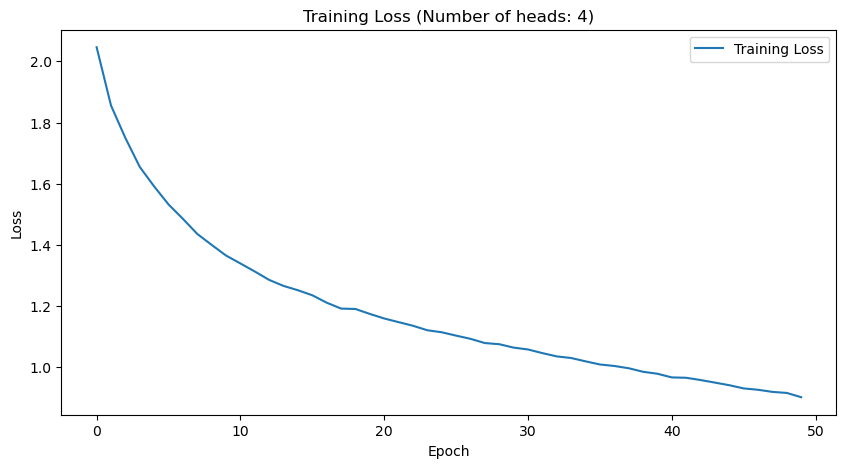

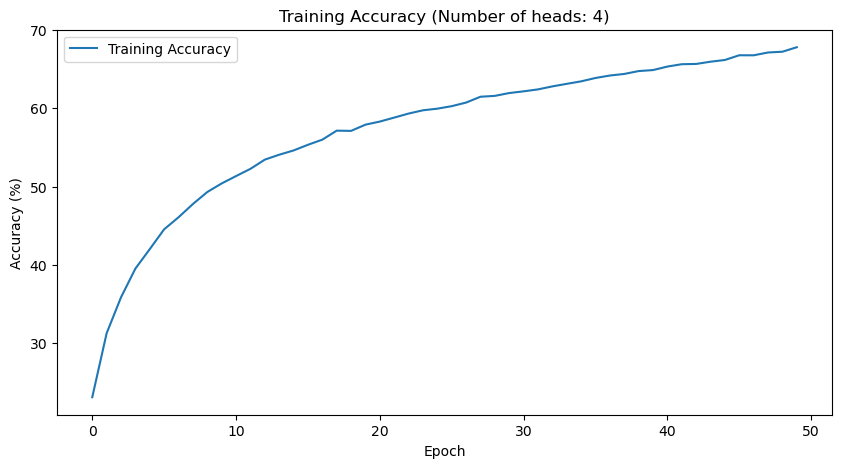

[Epoch 1/50] Train Loss: 2.0472, Train Acc: 22.95% 
[Epoch 2/50] Train Loss: 1.8364, Train Acc: 32.31% 
[Epoch 3/50] Train Loss: 1.7074, Train Acc: 37.65% 
[Epoch 4/50] Train Loss: 1.6076, Train Acc: 41.59% 
[Epoch 5/50] Train Loss: 1.5332, Train Acc: 44.25% 
[Epoch 6/50] Train Loss: 1.4756, Train Acc: 46.06% 
[Epoch 7/50] Train Loss: 1.4238, Train Acc: 48.11% 
[Epoch 8/50] Train Loss: 1.3902, Train Acc: 49.33% 
[Epoch 9/50] Train Loss: 1.3500, Train Acc: 50.92% 
[Epoch 10/50] Train Loss: 1.3245, Train Acc: 51.71% 
[Epoch 11/50] Train Loss: 1.2933, Train Acc: 53.16% 
[Epoch 12/50] Train Loss: 1.2714, Train Acc: 53.93% 
[Epoch 13/50] Train Loss: 1.2510, Train Acc: 54.74% 
[Epoch 14/50] Train Loss: 1.2350, Train Acc: 55.33% 
[Epoch 15/50] Train Loss: 1.2123, Train Acc: 56.37% 
[Epoch 16/50] Train Loss: 1.1909, Train Acc: 56.92% 
[Epoch 17/50] Train Loss: 1.1733, Train Acc: 58.04% 
[Epoch 18/50] Train Loss: 1.1583, Train Acc: 58.17% 
[Epoch 19/50] Train Loss: 1.1514, Train Acc: 58.59% 
[E

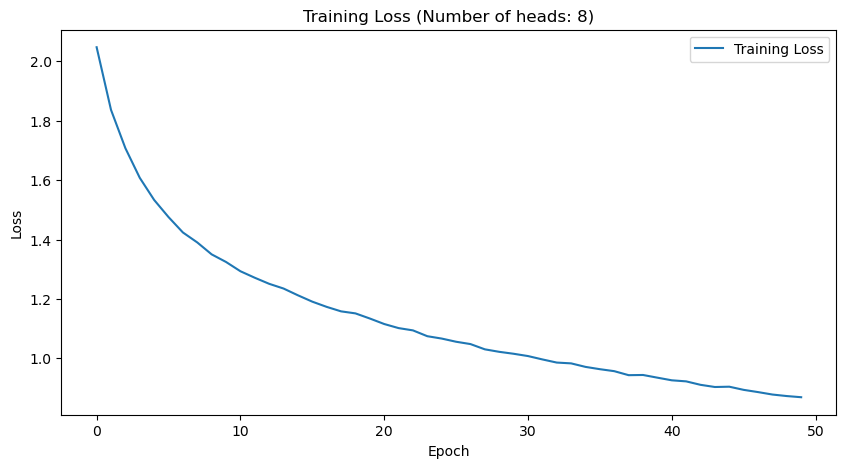

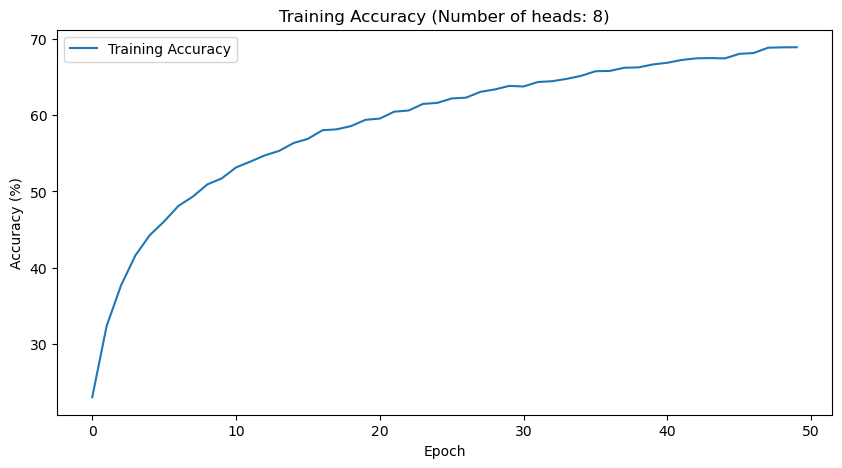

[Epoch 1/50] Train Loss: 2.0578, Train Acc: 22.74% 
[Epoch 2/50] Train Loss: 1.8342, Train Acc: 32.26% 
[Epoch 3/50] Train Loss: 1.7041, Train Acc: 37.59% 
[Epoch 4/50] Train Loss: 1.6076, Train Acc: 41.47% 
[Epoch 5/50] Train Loss: 1.5387, Train Acc: 44.12% 
[Epoch 6/50] Train Loss: 1.4819, Train Acc: 46.09% 
[Epoch 7/50] Train Loss: 1.4310, Train Acc: 48.23% 
[Epoch 8/50] Train Loss: 1.3971, Train Acc: 49.54% 
[Epoch 9/50] Train Loss: 1.3624, Train Acc: 50.74% 
[Epoch 10/50] Train Loss: 1.3326, Train Acc: 51.81% 
[Epoch 11/50] Train Loss: 1.3047, Train Acc: 53.01% 
[Epoch 12/50] Train Loss: 1.2813, Train Acc: 53.75% 
[Epoch 13/50] Train Loss: 1.2592, Train Acc: 54.47% 
[Epoch 14/50] Train Loss: 1.2361, Train Acc: 55.42% 
[Epoch 15/50] Train Loss: 1.2200, Train Acc: 55.96% 
[Epoch 16/50] Train Loss: 1.2044, Train Acc: 56.85% 
[Epoch 17/50] Train Loss: 1.1896, Train Acc: 57.09% 
[Epoch 18/50] Train Loss: 1.1717, Train Acc: 57.79% 
[Epoch 19/50] Train Loss: 1.1580, Train Acc: 58.40% 
[E

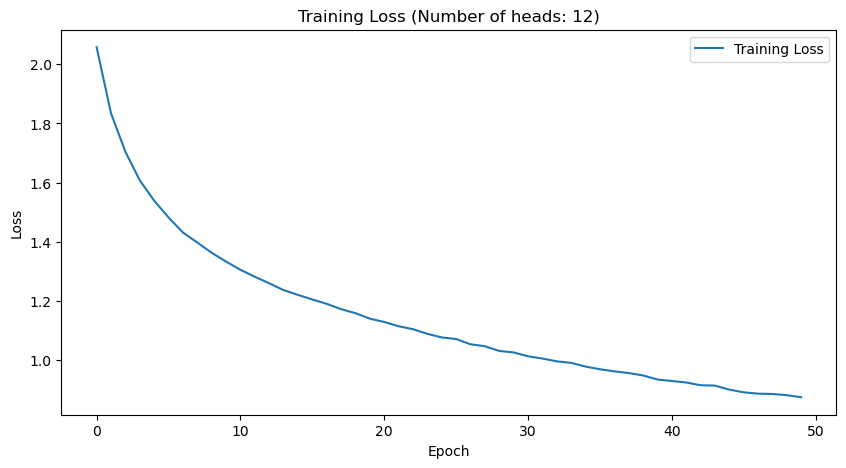

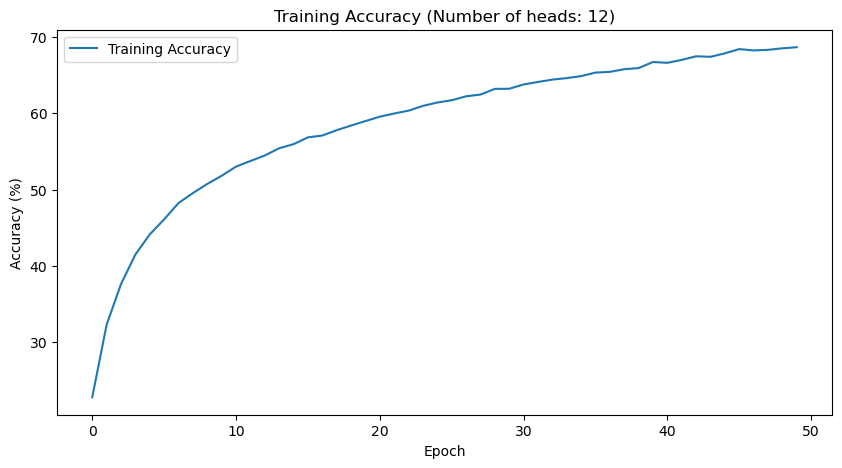

In [74]:
# try different number of heads
n_heads = [4, 8, 12]
for heads in n_heads:
    custom_config = {"img_size": 32, "patch_size": 4, "in_channels": 3, "n_classes": 10, "emb_size": 48, "depth": 12, "n_heads": heads, "mlp_ratio": 4., "qkv_bias": True, "drop_prob": 0.3, "attn_drop_prob": 0.3}
    model_custom = VisionTransformer(**custom_config)
    train_model(heads, model_custom, trainloader, validloader, testloader, n_epochs=50, lr=0.001, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# EXPERIMENT 5

In [75]:
def train_model(depth_layers, model, trainloader, validloader, testloader, n_epochs, lr, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    
    train_loss_history = []
    train_acc_history = []
    train_size = len(trainloader.dataset)


    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        correct_train = 0
        total_train = 0 
        # Training phase
        model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct_train / total_train
        
        # Validation phase
        model.eval()
   
        
        # Print training loss and accuracy
        print('[Epoch %d/%d] Train Loss: %.4f, Train Acc: %.2f%% ' % (
            epoch + 1, n_epochs, train_loss, train_accuracy))
        
        # Save loss and accuracy history for plotting
        train_loss_history.append(train_loss)
        train_acc_history.append(train_accuracy)
     

    print('Finished Training')
    
    # Test phase
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print('Test Accuracy: %.2f%%' % test_accuracy)
    
    # Plotting loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Training Loss')
  
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss (Number of layers: {depth_layers})')

    plt.legend()
    plt.show()
    
    # Plotting accuracy curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc_history, label='Training Accuracy')
    # plt.plot(valid_acc_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    # plt.title('Training and Validation Accuracy')
    plt.title(f'Training Accuracy (Number of layers: {depth_layers})')

    plt.legend()
    plt.show()

[Epoch 1/50] Train Loss: 2.0878, Train Acc: 21.01% 
[Epoch 2/50] Train Loss: 1.8899, Train Acc: 29.43% 
[Epoch 3/50] Train Loss: 1.7892, Train Acc: 33.99% 
[Epoch 4/50] Train Loss: 1.7137, Train Acc: 36.71% 
[Epoch 5/50] Train Loss: 1.6659, Train Acc: 39.06% 
[Epoch 6/50] Train Loss: 1.6137, Train Acc: 40.75% 
[Epoch 7/50] Train Loss: 1.5859, Train Acc: 41.87% 
[Epoch 8/50] Train Loss: 1.5478, Train Acc: 43.29% 
[Epoch 9/50] Train Loss: 1.5295, Train Acc: 43.99% 
[Epoch 10/50] Train Loss: 1.5079, Train Acc: 44.94% 
[Epoch 11/50] Train Loss: 1.4880, Train Acc: 45.72% 
[Epoch 12/50] Train Loss: 1.4769, Train Acc: 46.16% 
[Epoch 13/50] Train Loss: 1.4547, Train Acc: 46.97% 
[Epoch 14/50] Train Loss: 1.4435, Train Acc: 47.50% 
[Epoch 15/50] Train Loss: 1.4326, Train Acc: 47.72% 
[Epoch 16/50] Train Loss: 1.4171, Train Acc: 48.48% 
[Epoch 17/50] Train Loss: 1.4144, Train Acc: 48.30% 
[Epoch 18/50] Train Loss: 1.4014, Train Acc: 49.05% 
[Epoch 19/50] Train Loss: 1.3924, Train Acc: 49.42% 
[E

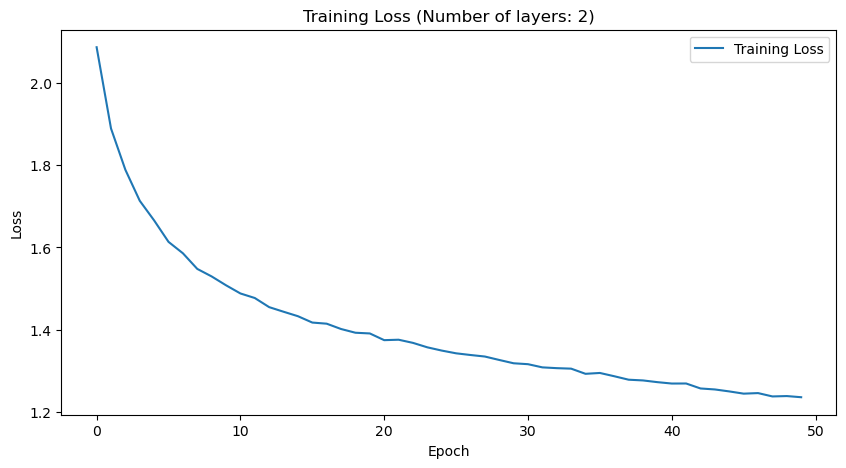

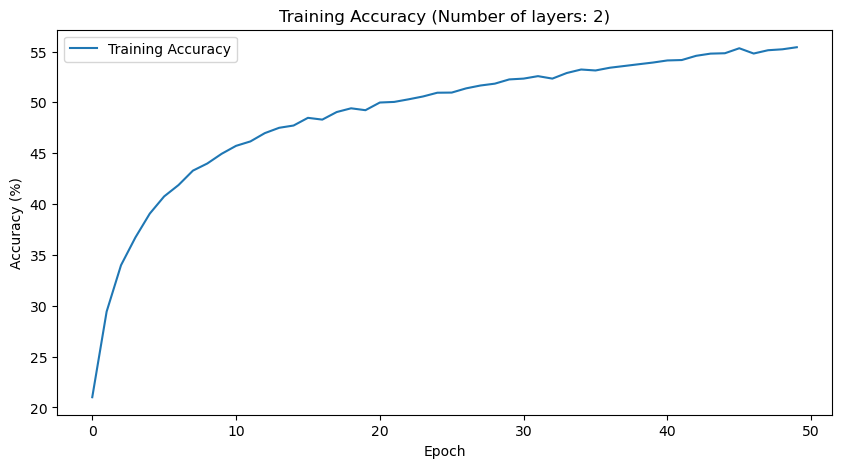

[Epoch 1/50] Train Loss: 2.0507, Train Acc: 22.99% 
[Epoch 2/50] Train Loss: 1.8407, Train Acc: 32.02% 
[Epoch 3/50] Train Loss: 1.7401, Train Acc: 35.97% 
[Epoch 4/50] Train Loss: 1.6618, Train Acc: 39.38% 
[Epoch 5/50] Train Loss: 1.6069, Train Acc: 41.33% 
[Epoch 6/50] Train Loss: 1.5632, Train Acc: 43.12% 
[Epoch 7/50] Train Loss: 1.5265, Train Acc: 44.70% 
[Epoch 8/50] Train Loss: 1.4967, Train Acc: 45.76% 
[Epoch 9/50] Train Loss: 1.4711, Train Acc: 46.26% 
[Epoch 10/50] Train Loss: 1.4454, Train Acc: 47.42% 
[Epoch 11/50] Train Loss: 1.4207, Train Acc: 48.37% 
[Epoch 12/50] Train Loss: 1.4046, Train Acc: 49.00% 
[Epoch 13/50] Train Loss: 1.3873, Train Acc: 49.70% 
[Epoch 14/50] Train Loss: 1.3721, Train Acc: 50.08% 
[Epoch 15/50] Train Loss: 1.3556, Train Acc: 50.85% 
[Epoch 16/50] Train Loss: 1.3416, Train Acc: 51.28% 
[Epoch 17/50] Train Loss: 1.3328, Train Acc: 51.83% 
[Epoch 18/50] Train Loss: 1.3152, Train Acc: 52.40% 
[Epoch 19/50] Train Loss: 1.3004, Train Acc: 52.89% 
[E

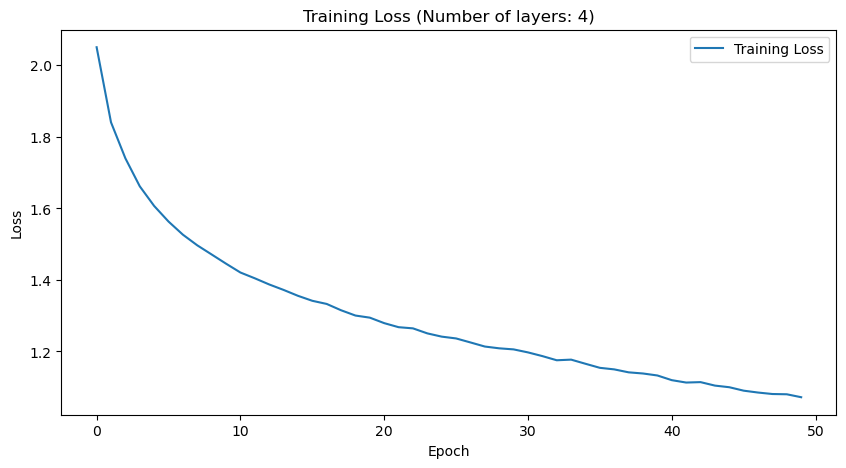

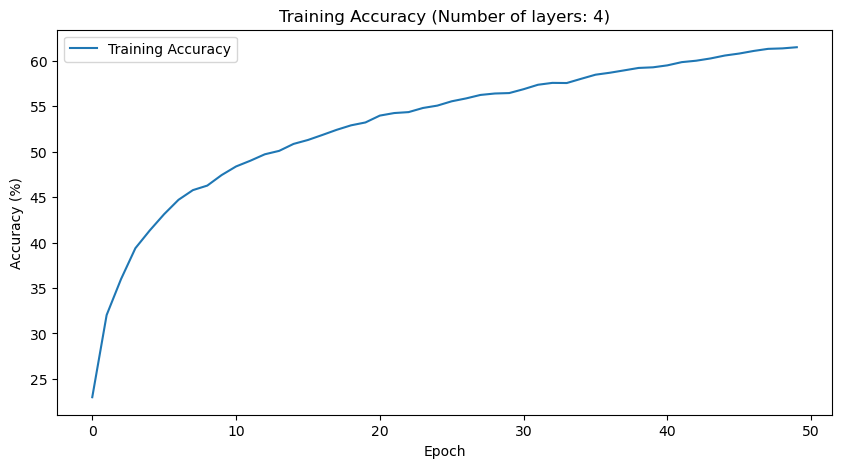

[Epoch 1/50] Train Loss: 2.0538, Train Acc: 22.76% 
[Epoch 2/50] Train Loss: 1.8348, Train Acc: 32.39% 
[Epoch 3/50] Train Loss: 1.7237, Train Acc: 36.51% 
[Epoch 4/50] Train Loss: 1.6288, Train Acc: 40.33% 
[Epoch 5/50] Train Loss: 1.5631, Train Acc: 42.90% 
[Epoch 6/50] Train Loss: 1.5242, Train Acc: 44.41% 
[Epoch 7/50] Train Loss: 1.4809, Train Acc: 46.23% 
[Epoch 8/50] Train Loss: 1.4447, Train Acc: 47.35% 
[Epoch 9/50] Train Loss: 1.4143, Train Acc: 48.60% 
[Epoch 10/50] Train Loss: 1.3794, Train Acc: 49.87% 
[Epoch 11/50] Train Loss: 1.3529, Train Acc: 50.65% 
[Epoch 12/50] Train Loss: 1.3365, Train Acc: 51.59% 
[Epoch 13/50] Train Loss: 1.3234, Train Acc: 51.96% 
[Epoch 14/50] Train Loss: 1.3030, Train Acc: 52.72% 
[Epoch 15/50] Train Loss: 1.2742, Train Acc: 53.79% 
[Epoch 16/50] Train Loss: 1.2652, Train Acc: 54.52% 
[Epoch 17/50] Train Loss: 1.2502, Train Acc: 54.83% 
[Epoch 18/50] Train Loss: 1.2418, Train Acc: 55.08% 
[Epoch 19/50] Train Loss: 1.2249, Train Acc: 55.98% 
[E

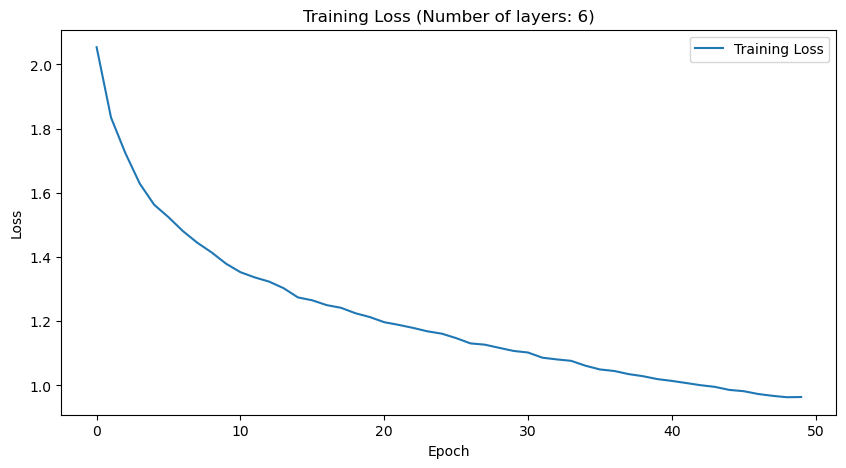

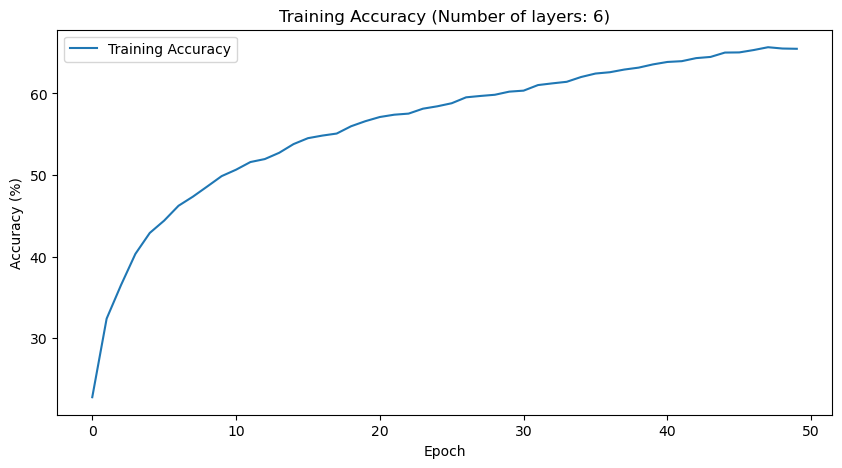

[Epoch 1/50] Train Loss: 2.0409, Train Acc: 23.44% 
[Epoch 2/50] Train Loss: 1.8399, Train Acc: 32.12% 
[Epoch 3/50] Train Loss: 1.7201, Train Acc: 37.15% 
[Epoch 4/50] Train Loss: 1.6246, Train Acc: 40.78% 
[Epoch 5/50] Train Loss: 1.5663, Train Acc: 42.63% 
[Epoch 6/50] Train Loss: 1.5063, Train Acc: 45.16% 
[Epoch 7/50] Train Loss: 1.4670, Train Acc: 46.63% 
[Epoch 8/50] Train Loss: 1.4277, Train Acc: 48.07% 
[Epoch 9/50] Train Loss: 1.4020, Train Acc: 48.83% 
[Epoch 10/50] Train Loss: 1.3704, Train Acc: 50.54% 
[Epoch 11/50] Train Loss: 1.3557, Train Acc: 50.75% 
[Epoch 12/50] Train Loss: 1.3285, Train Acc: 51.91% 
[Epoch 13/50] Train Loss: 1.3051, Train Acc: 52.73% 
[Epoch 14/50] Train Loss: 1.2926, Train Acc: 52.93% 
[Epoch 15/50] Train Loss: 1.2710, Train Acc: 53.94% 
[Epoch 16/50] Train Loss: 1.2540, Train Acc: 54.34% 
[Epoch 17/50] Train Loss: 1.2350, Train Acc: 55.23% 
[Epoch 18/50] Train Loss: 1.2251, Train Acc: 55.59% 
[Epoch 19/50] Train Loss: 1.2153, Train Acc: 56.27% 
[E

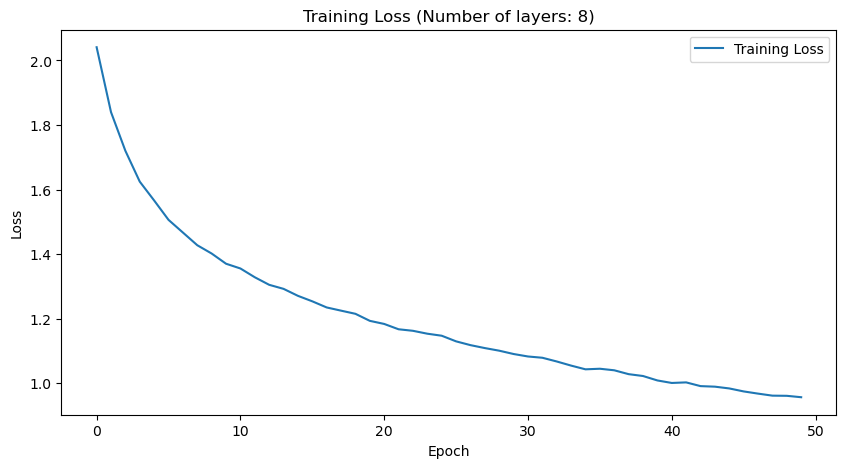

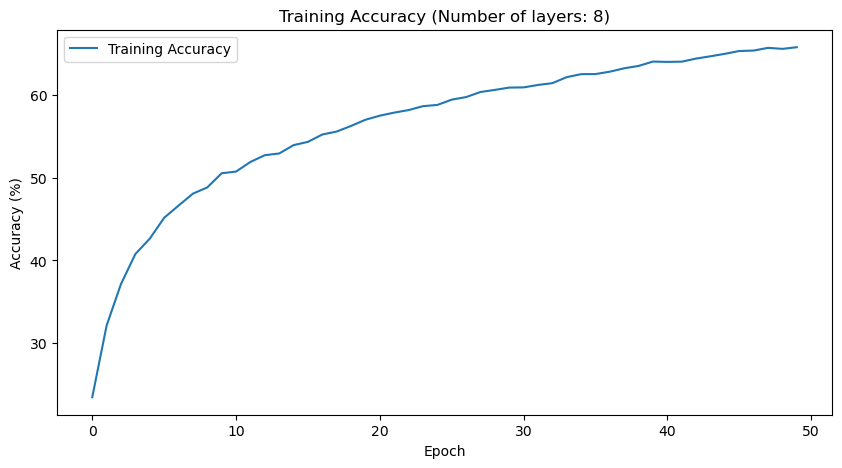

[Epoch 1/50] Train Loss: 2.0434, Train Acc: 23.02% 
[Epoch 2/50] Train Loss: 1.8194, Train Acc: 33.11% 
[Epoch 3/50] Train Loss: 1.6970, Train Acc: 38.16% 
[Epoch 4/50] Train Loss: 1.6096, Train Acc: 41.67% 
[Epoch 5/50] Train Loss: 1.5460, Train Acc: 43.85% 
[Epoch 6/50] Train Loss: 1.4979, Train Acc: 45.78% 
[Epoch 7/50] Train Loss: 1.4578, Train Acc: 46.98% 
[Epoch 8/50] Train Loss: 1.4178, Train Acc: 48.77% 
[Epoch 9/50] Train Loss: 1.3864, Train Acc: 49.54% 
[Epoch 10/50] Train Loss: 1.3640, Train Acc: 50.52% 
[Epoch 11/50] Train Loss: 1.3303, Train Acc: 51.82% 
[Epoch 12/50] Train Loss: 1.3074, Train Acc: 52.59% 
[Epoch 13/50] Train Loss: 1.2872, Train Acc: 53.36% 
[Epoch 14/50] Train Loss: 1.2649, Train Acc: 54.28% 
[Epoch 15/50] Train Loss: 1.2410, Train Acc: 55.43% 
[Epoch 16/50] Train Loss: 1.2278, Train Acc: 55.74% 
[Epoch 17/50] Train Loss: 1.2126, Train Acc: 56.34% 
[Epoch 18/50] Train Loss: 1.1956, Train Acc: 57.09% 
[Epoch 19/50] Train Loss: 1.1774, Train Acc: 57.74% 
[E

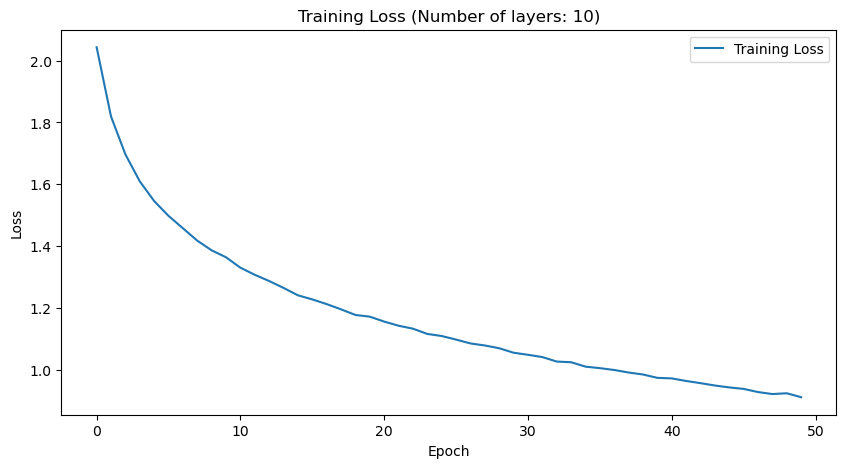

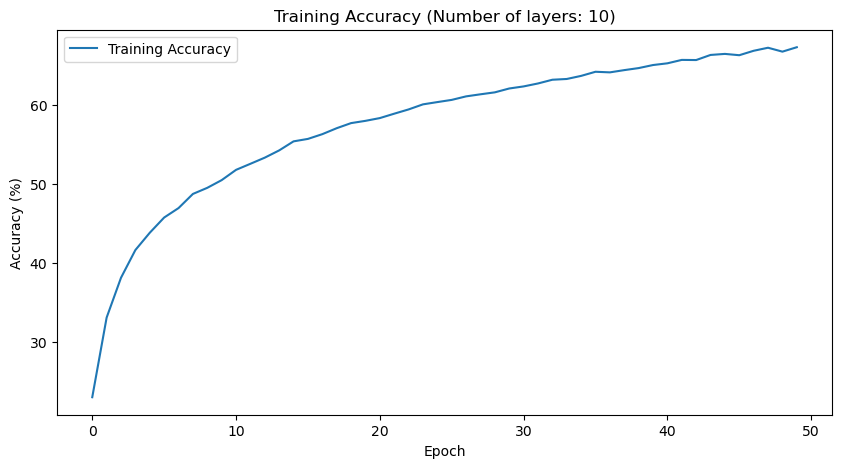

[Epoch 1/50] Train Loss: 2.0482, Train Acc: 23.19% 
[Epoch 2/50] Train Loss: 1.8335, Train Acc: 32.40% 
[Epoch 3/50] Train Loss: 1.7056, Train Acc: 37.16% 
[Epoch 4/50] Train Loss: 1.6121, Train Acc: 41.26% 
[Epoch 5/50] Train Loss: 1.5526, Train Acc: 43.60% 
[Epoch 6/50] Train Loss: 1.4846, Train Acc: 46.18% 
[Epoch 7/50] Train Loss: 1.4513, Train Acc: 47.42% 
[Epoch 8/50] Train Loss: 1.4140, Train Acc: 48.62% 
[Epoch 9/50] Train Loss: 1.3828, Train Acc: 49.97% 
[Epoch 10/50] Train Loss: 1.3506, Train Acc: 51.21% 
[Epoch 11/50] Train Loss: 1.3232, Train Acc: 52.19% 
[Epoch 12/50] Train Loss: 1.2968, Train Acc: 53.08% 
[Epoch 13/50] Train Loss: 1.2770, Train Acc: 53.91% 
[Epoch 14/50] Train Loss: 1.2551, Train Acc: 54.58% 
[Epoch 15/50] Train Loss: 1.2396, Train Acc: 55.35% 
[Epoch 16/50] Train Loss: 1.2243, Train Acc: 56.06% 
[Epoch 17/50] Train Loss: 1.2020, Train Acc: 56.47% 
[Epoch 18/50] Train Loss: 1.1847, Train Acc: 57.49% 
[Epoch 19/50] Train Loss: 1.1702, Train Acc: 57.70% 
[E

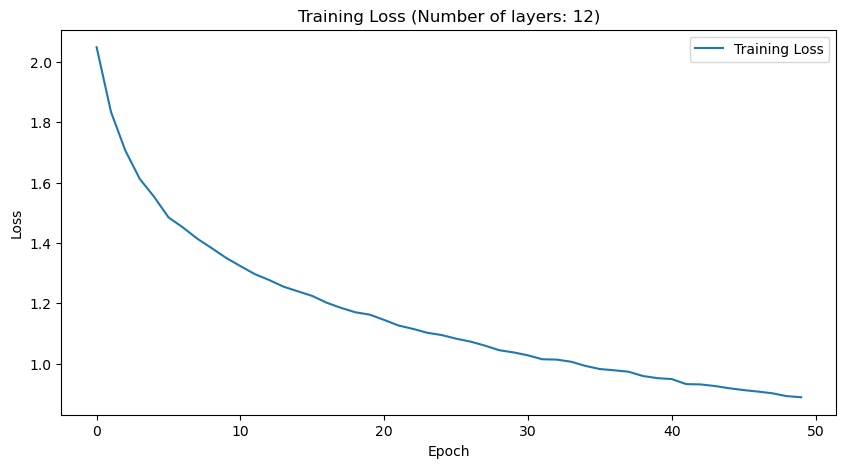

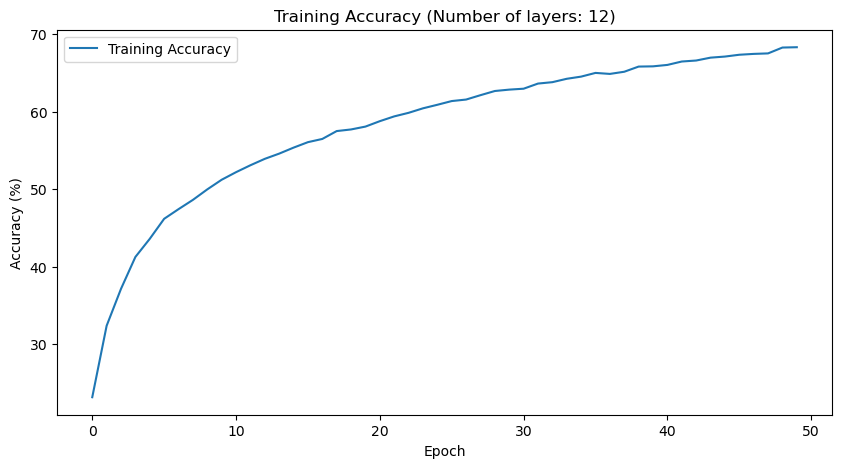

In [76]:
# classify the model using cls token from different layers
depths = [2, 4, 6, 8, 10, 12]
for depth in depths:
    custom_config = {"img_size": 32, "patch_size": 4, "in_channels": 3, "n_classes": 10, "emb_size": 48, "depth": depth, "n_heads": 4, "mlp_ratio": 4., "qkv_bias": True, "drop_prob": 0.3, "attn_drop_prob": 0.3}
    model_custom = VisionTransformer(**custom_config)
    train_model(depth, model_custom, trainloader, validloader, testloader, n_epochs=50, lr=0.001, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# EXPERIMENT 6  ATTENTION HEADS

In [102]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
 
def plot_attention_map(model, image, n_heads=4, n_rows=2, n_cols=4):
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    image = image.to(device)
    image = image.unsqueeze(0)
    with torch.no_grad():
        outputs = model.patch_embed(image)
        cls_token = model.cls_token.expand(1, -1, -1)
        outputs = torch.cat((cls_token, outputs), dim=1)
        outputs = outputs + model.pos_embed
        outputs = model.pos_drop(outputs)
       
        # Plotting original image
        fig, axes = plt.subplots(1, 1, figsize=(6, 6))
        axes.set_title('Original Image')
        axes.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
        axes.axis('off')
        plt.tight_layout()
        plt.show()
       
        # Plotting attention maps and overlaid images for each head and each output block
        for i, block in enumerate(model.blocks):
            outputs = block.attn(outputs)
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8))
            for j, ax in enumerate(axes.flat):
                head_idx = j // 2
                map_type = j % 2  # 0 for attention map, 1 for overlaid image
                if map_type == 0:
                    ax.set_title(f'Attention Head {head_idx + 1}')
                    attn_map = outputs.squeeze(0)[1:].reshape(n_heads, -1, 8, 8)[head_idx].cpu().numpy()
                    attn_map = np.mean(attn_map, axis=0)
                    ax.imshow(attn_map)
                else:
                    ax.set_title(f'Overlaid Image Head {head_idx + 1}')
                    attn_map = outputs.squeeze(0)[1:].reshape(n_heads, -1, 8, 8)[head_idx].cpu().numpy()
                    attn_map = np.mean(attn_map, axis=0)
                    attn_map_resized = F.interpolate(torch.tensor(attn_map).unsqueeze(0).unsqueeze(0), size=(32, 32), mode='bilinear', align_corners=False)
                    attn_map_resized = attn_map_resized.squeeze(0).squeeze(0).numpy()
                    attn_map_rgb = np.stack((attn_map_resized,) * 3, axis=-1)
                    resized_image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
                    overlaid_image = attn_map_rgb + resized_image
                    ax.imshow(overlaid_image)
                ax.axis('off')
            plt.tight_layout()
            plt.show()
                

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class: 3


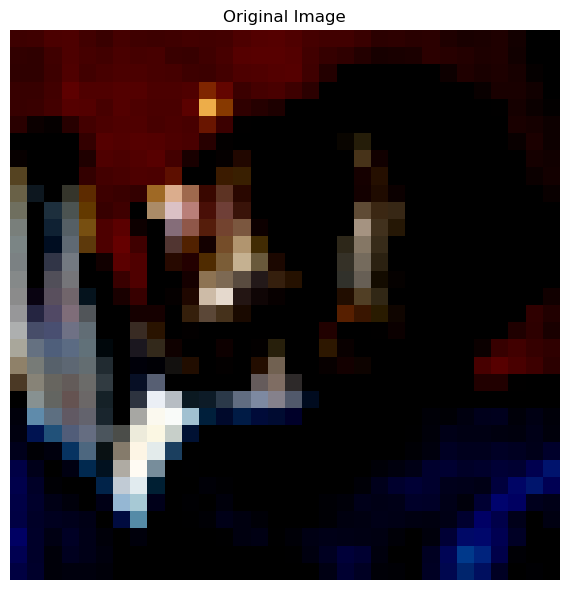

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


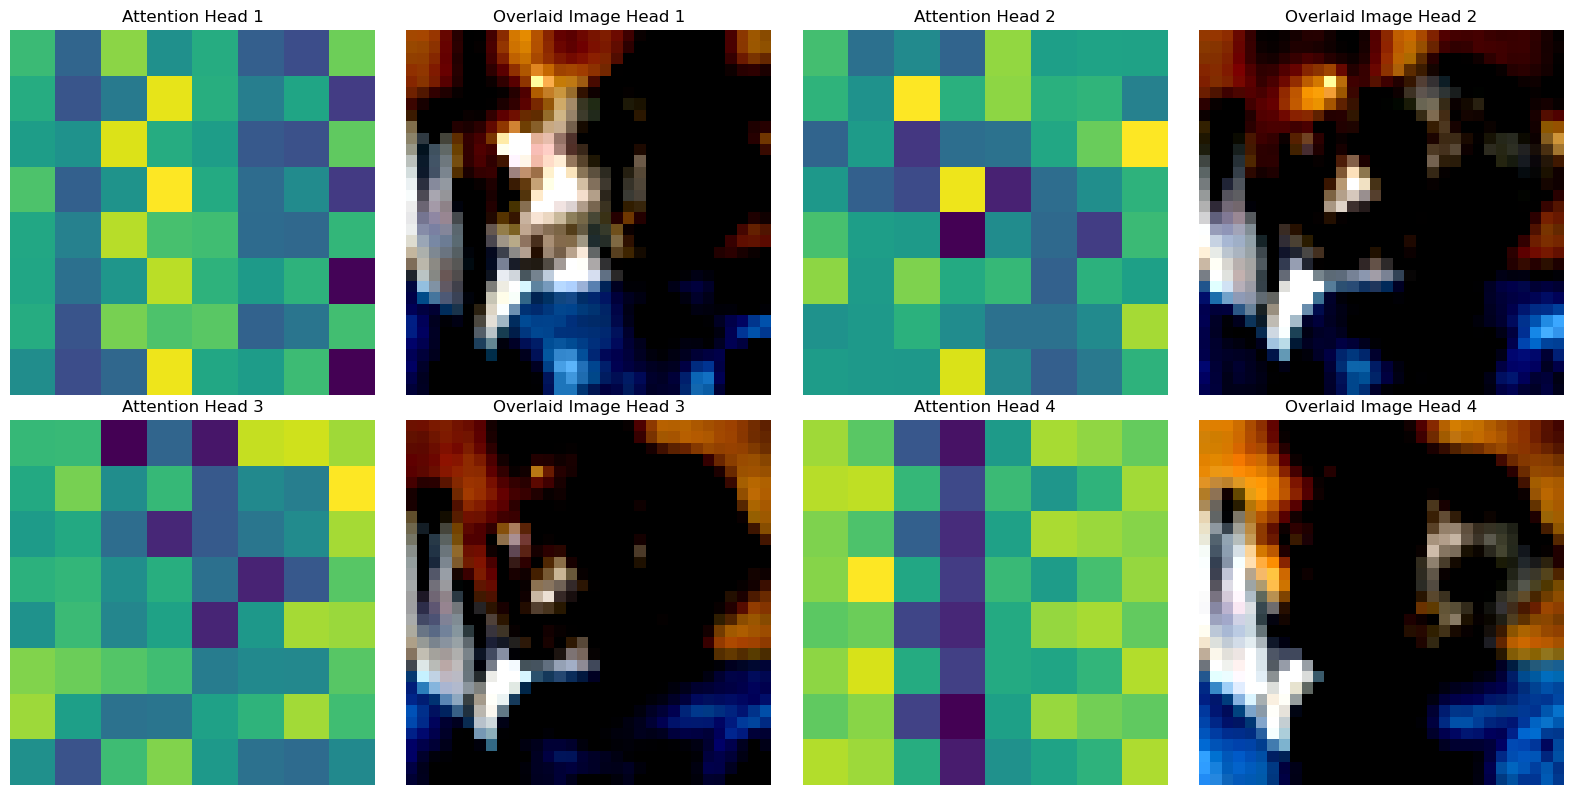

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


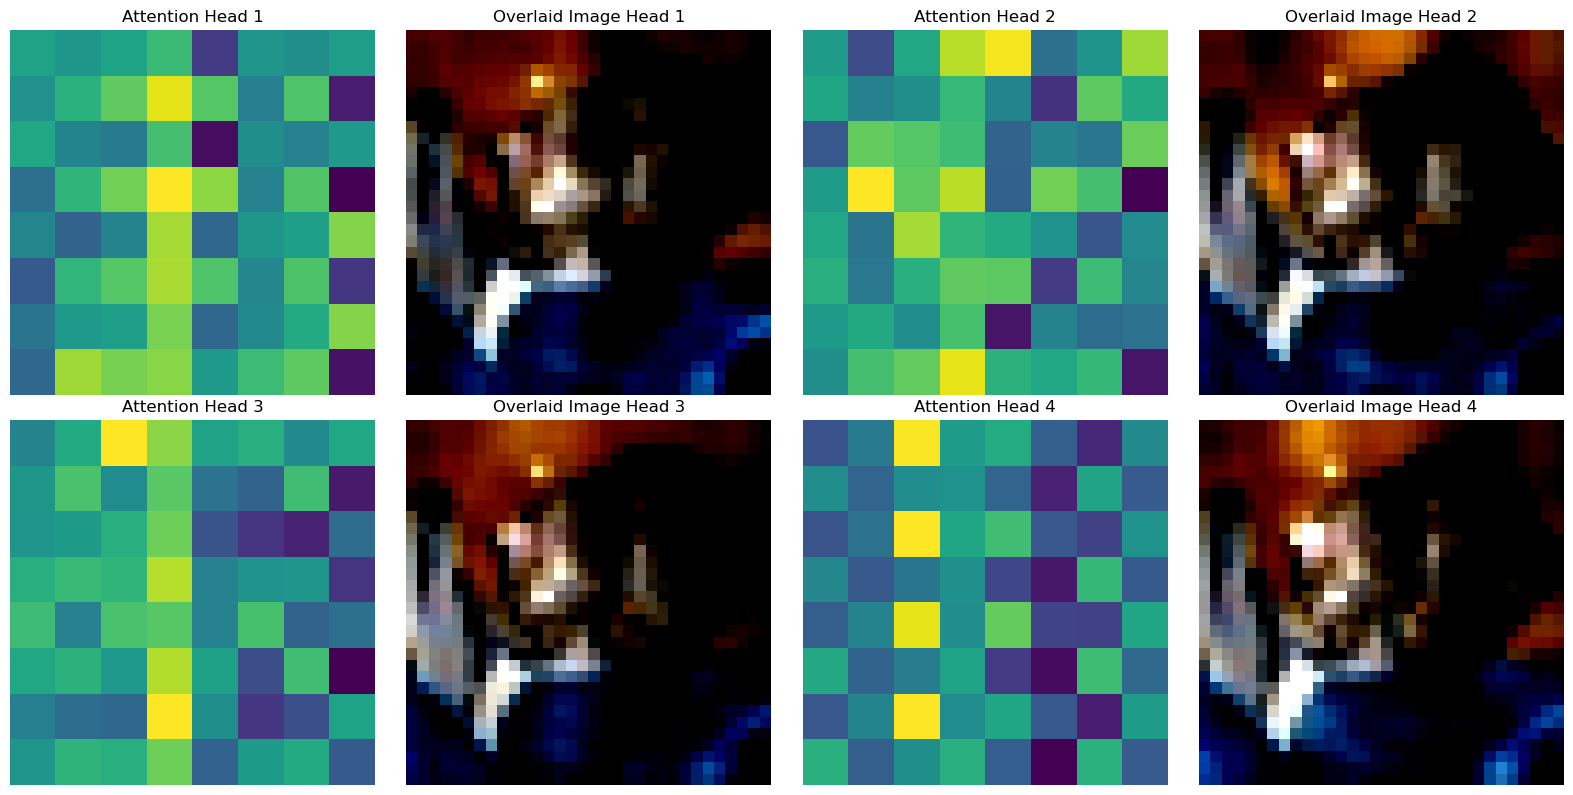

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


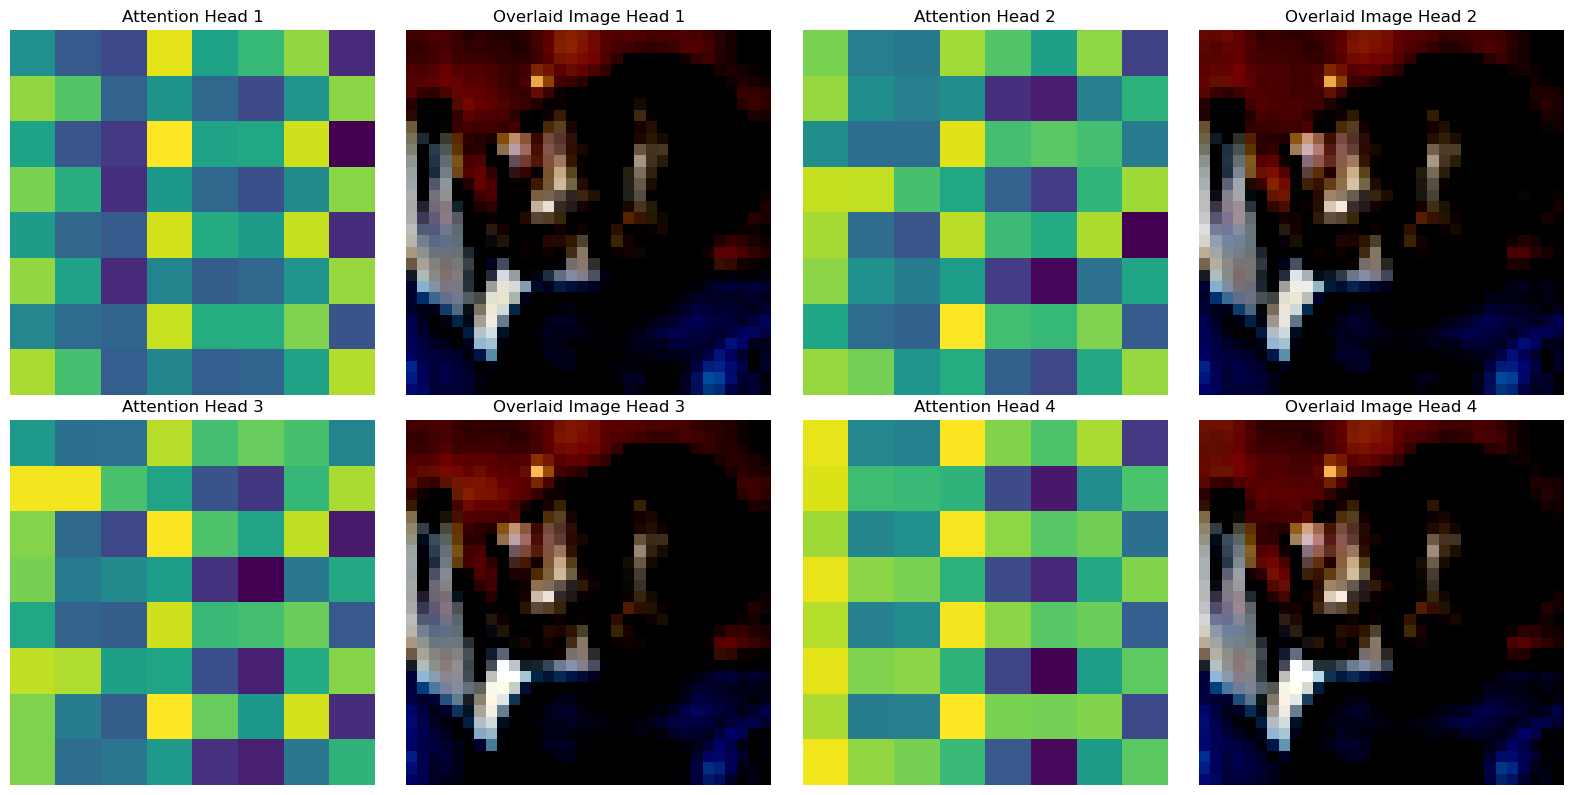

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


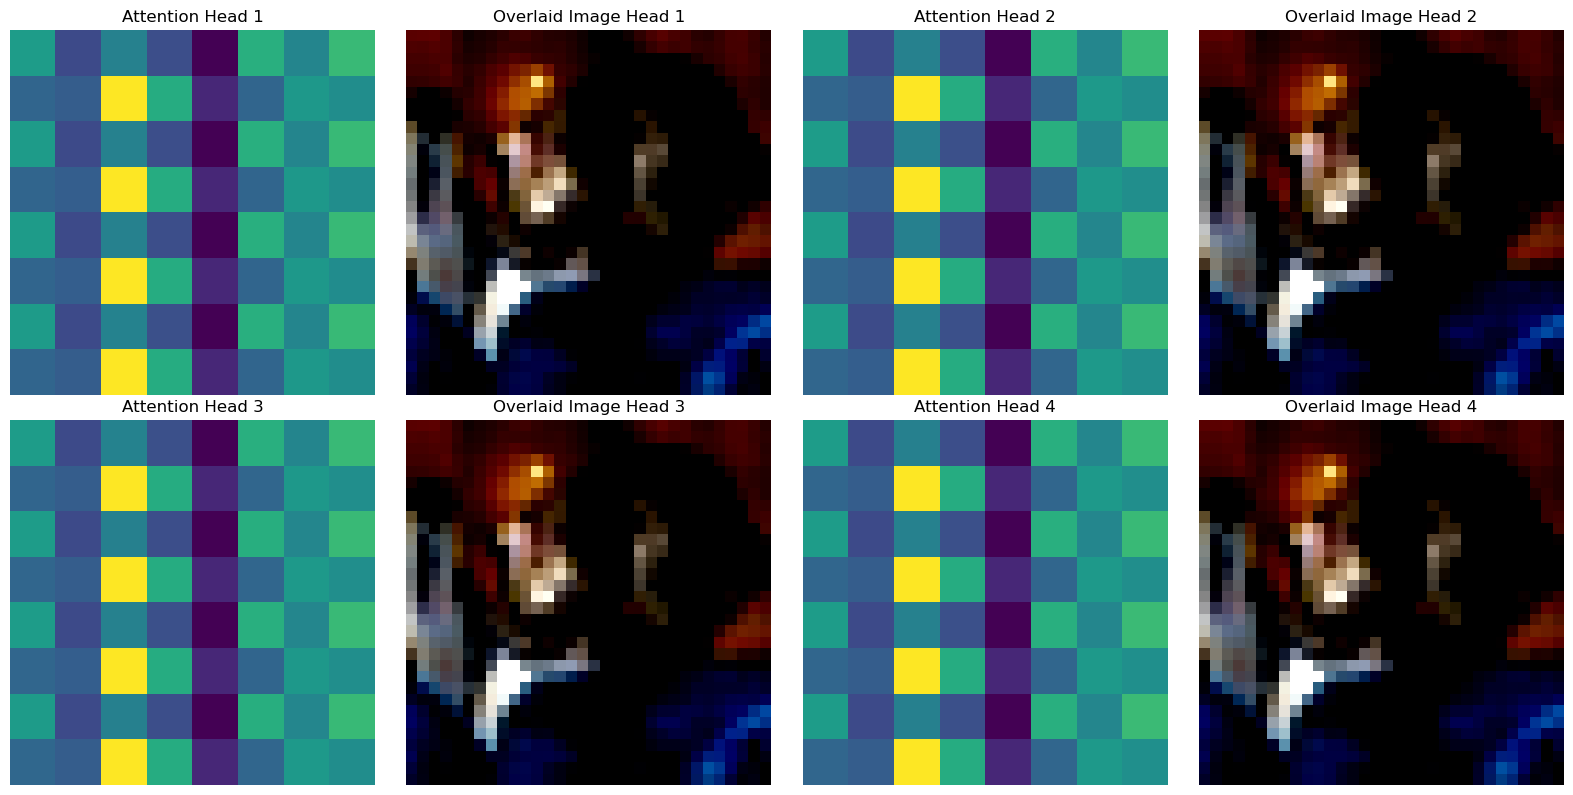

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


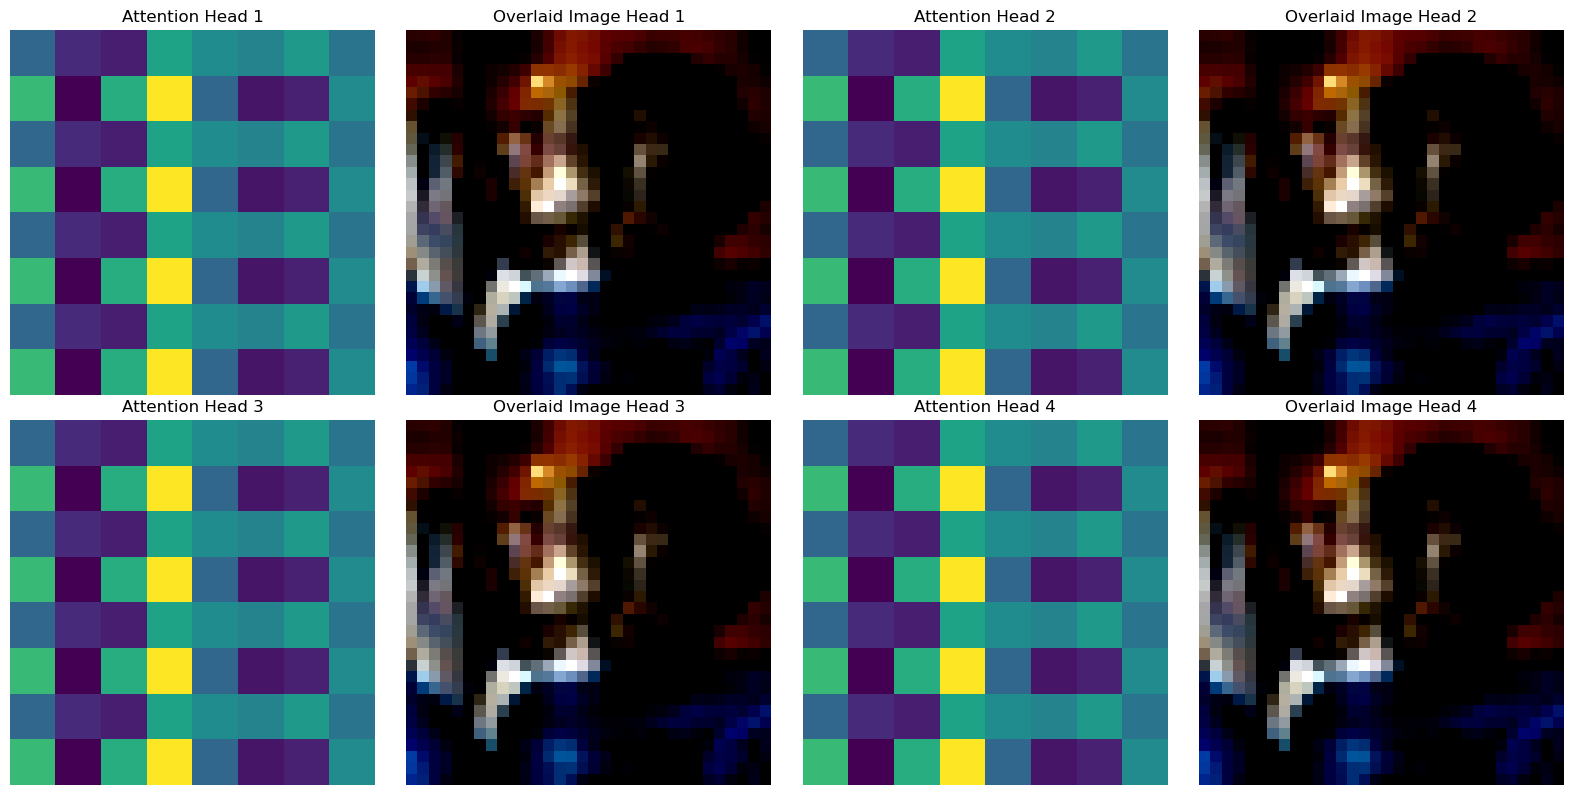

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


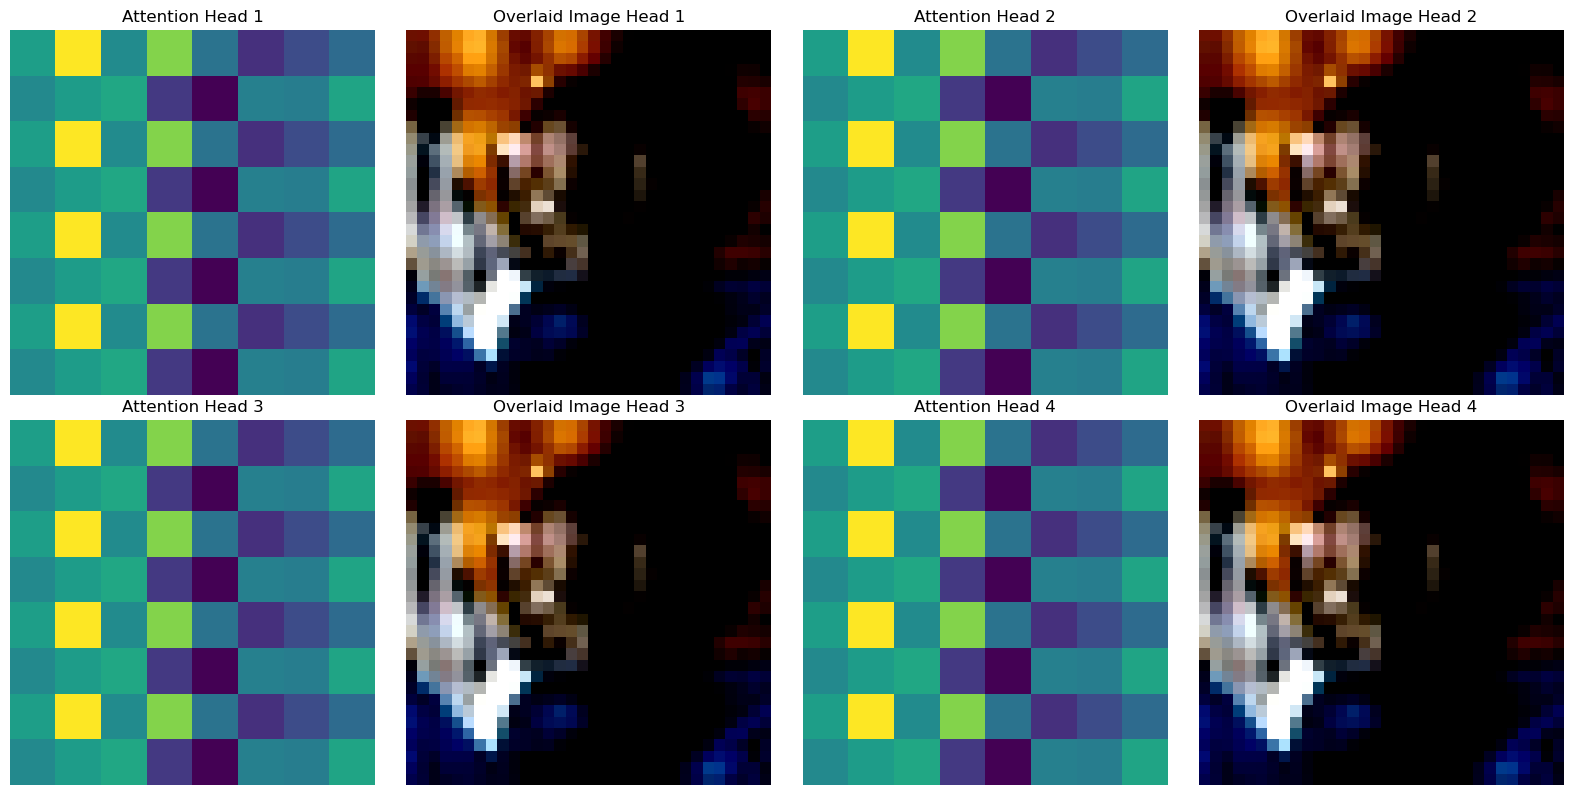

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


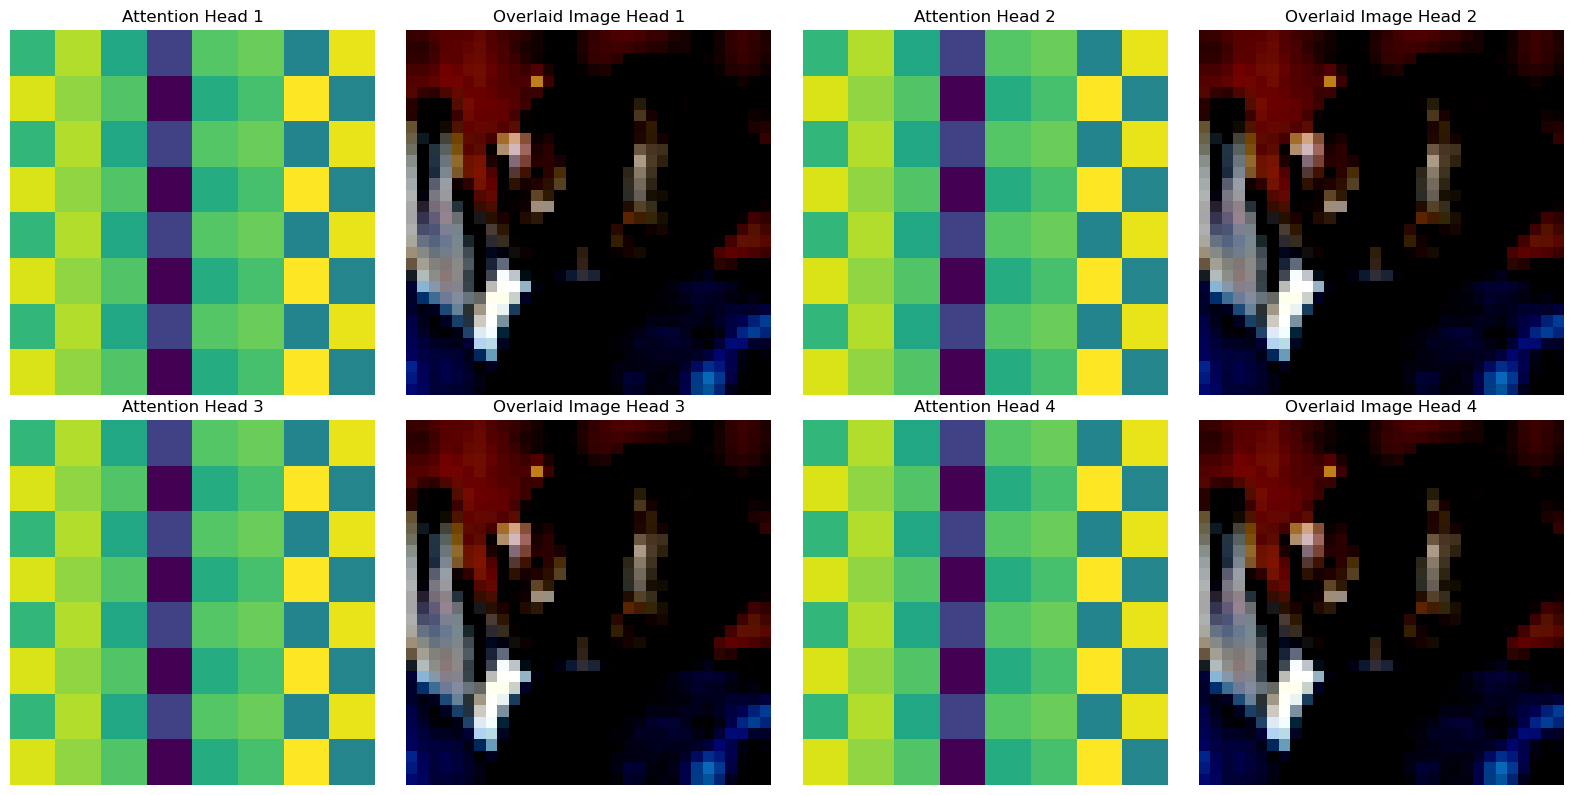

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


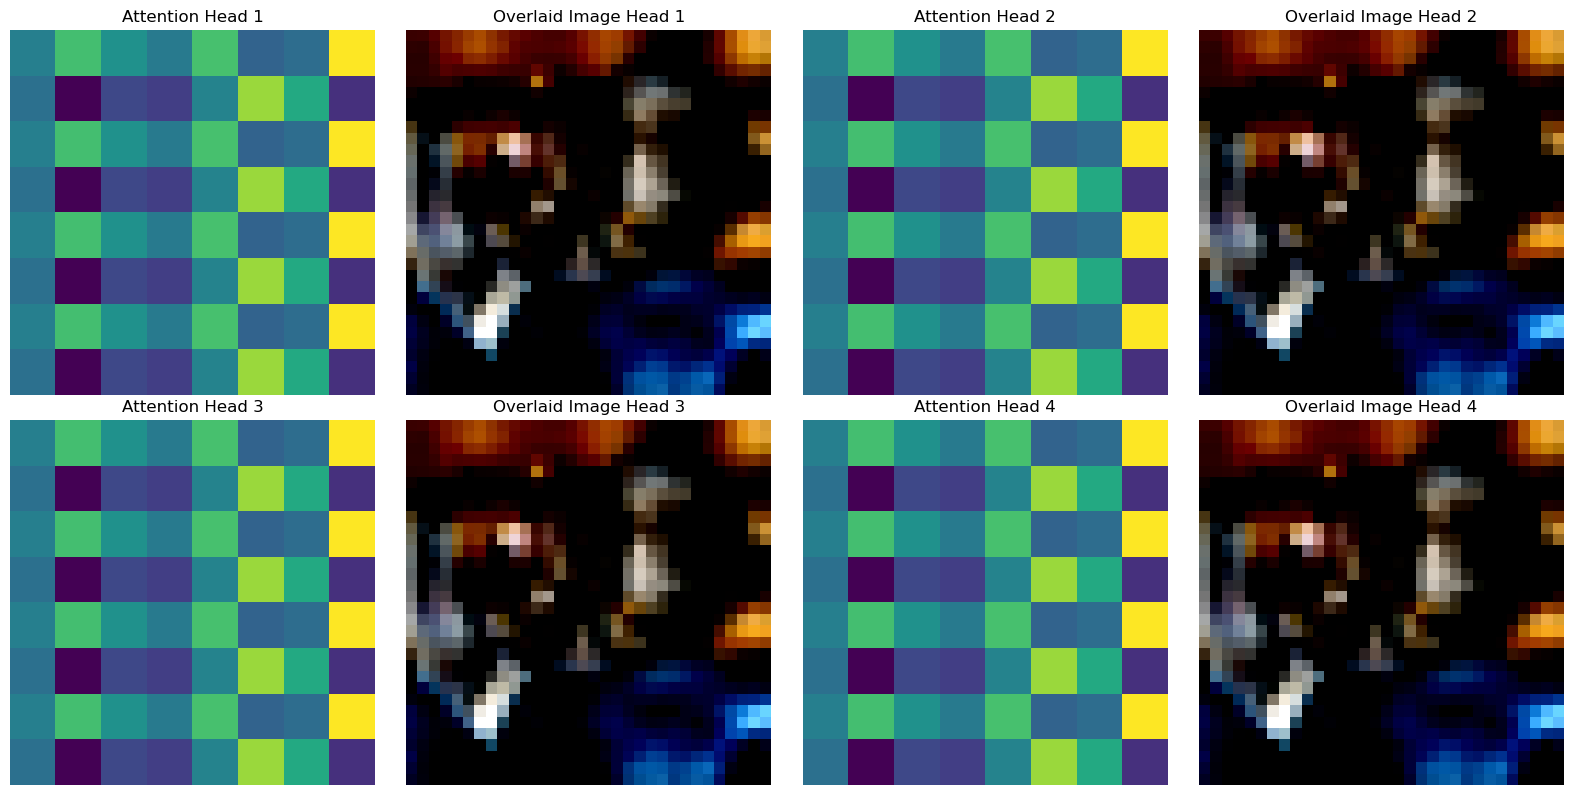

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


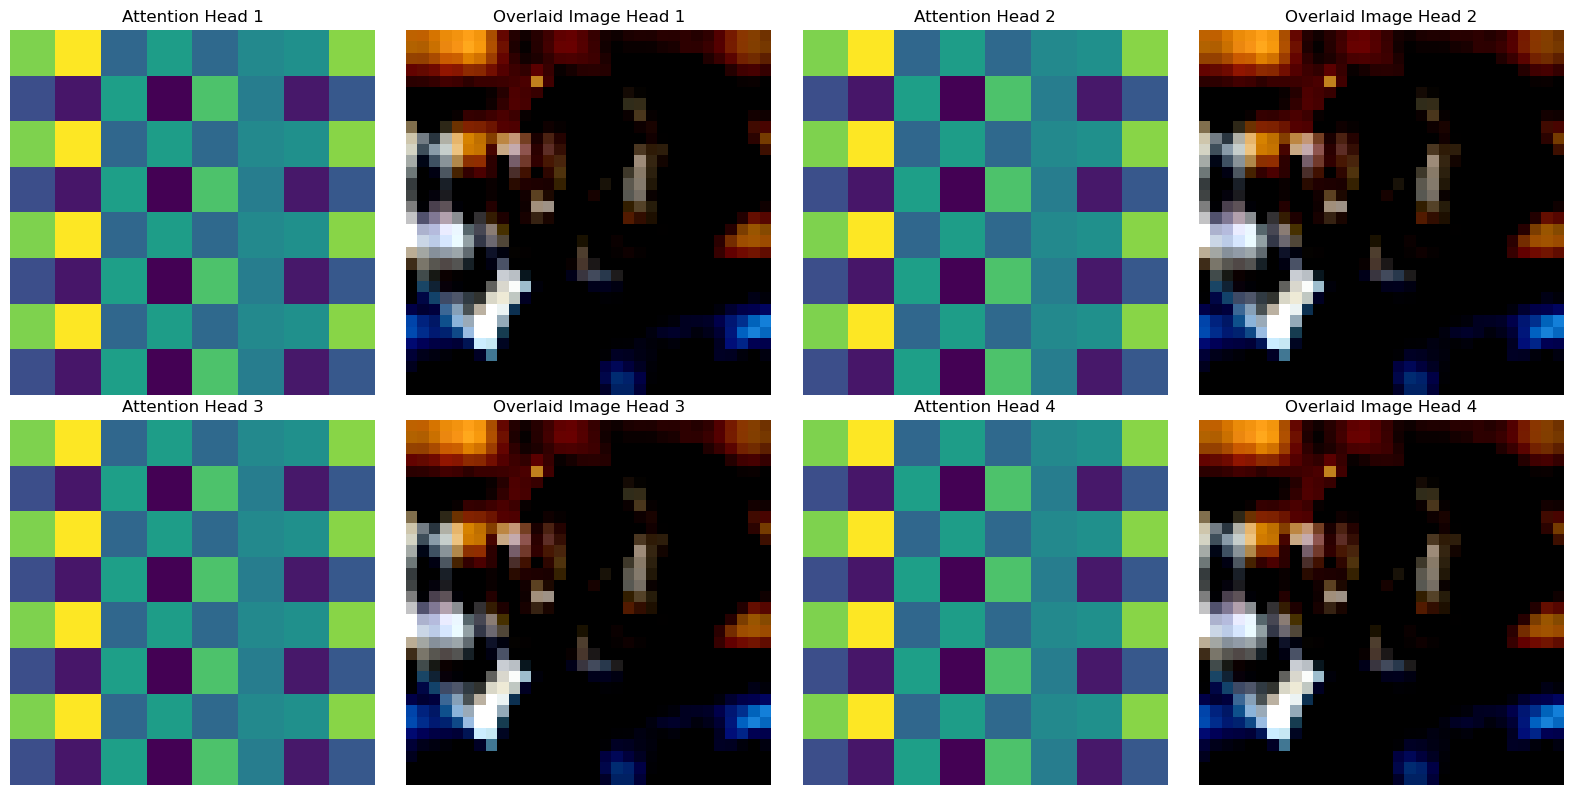

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


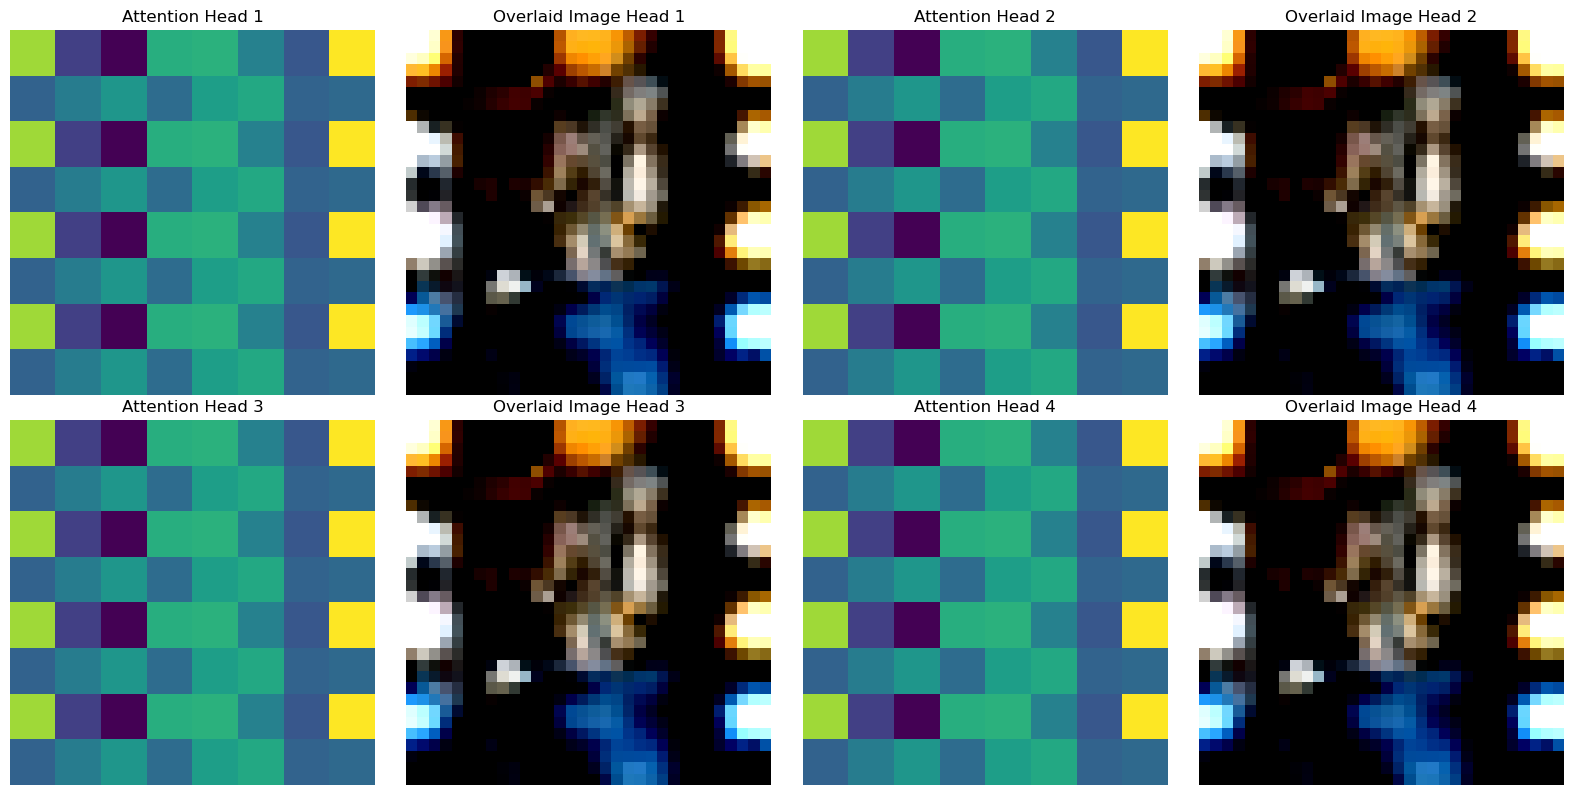

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


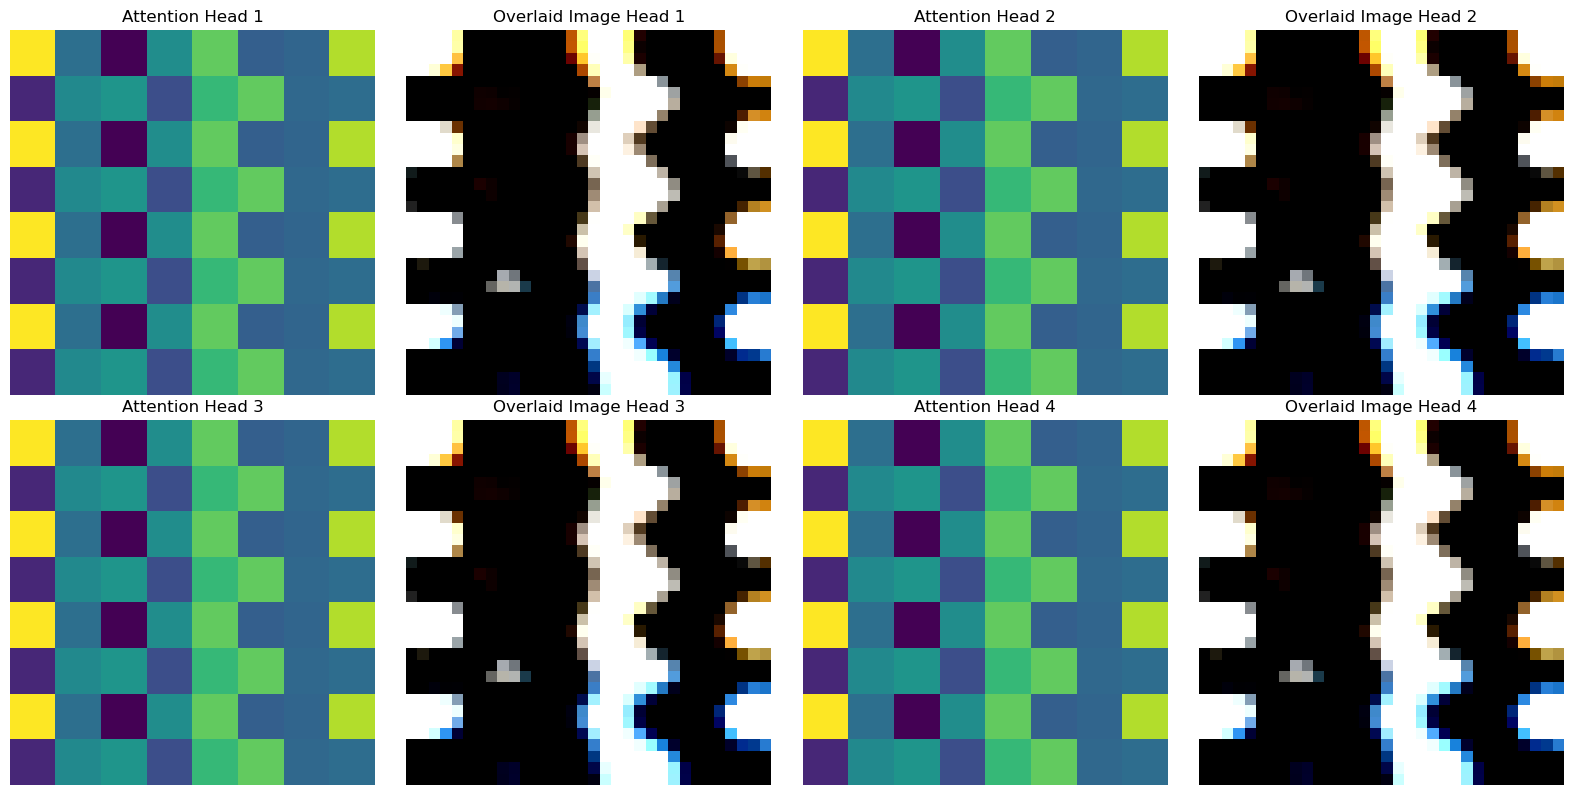

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


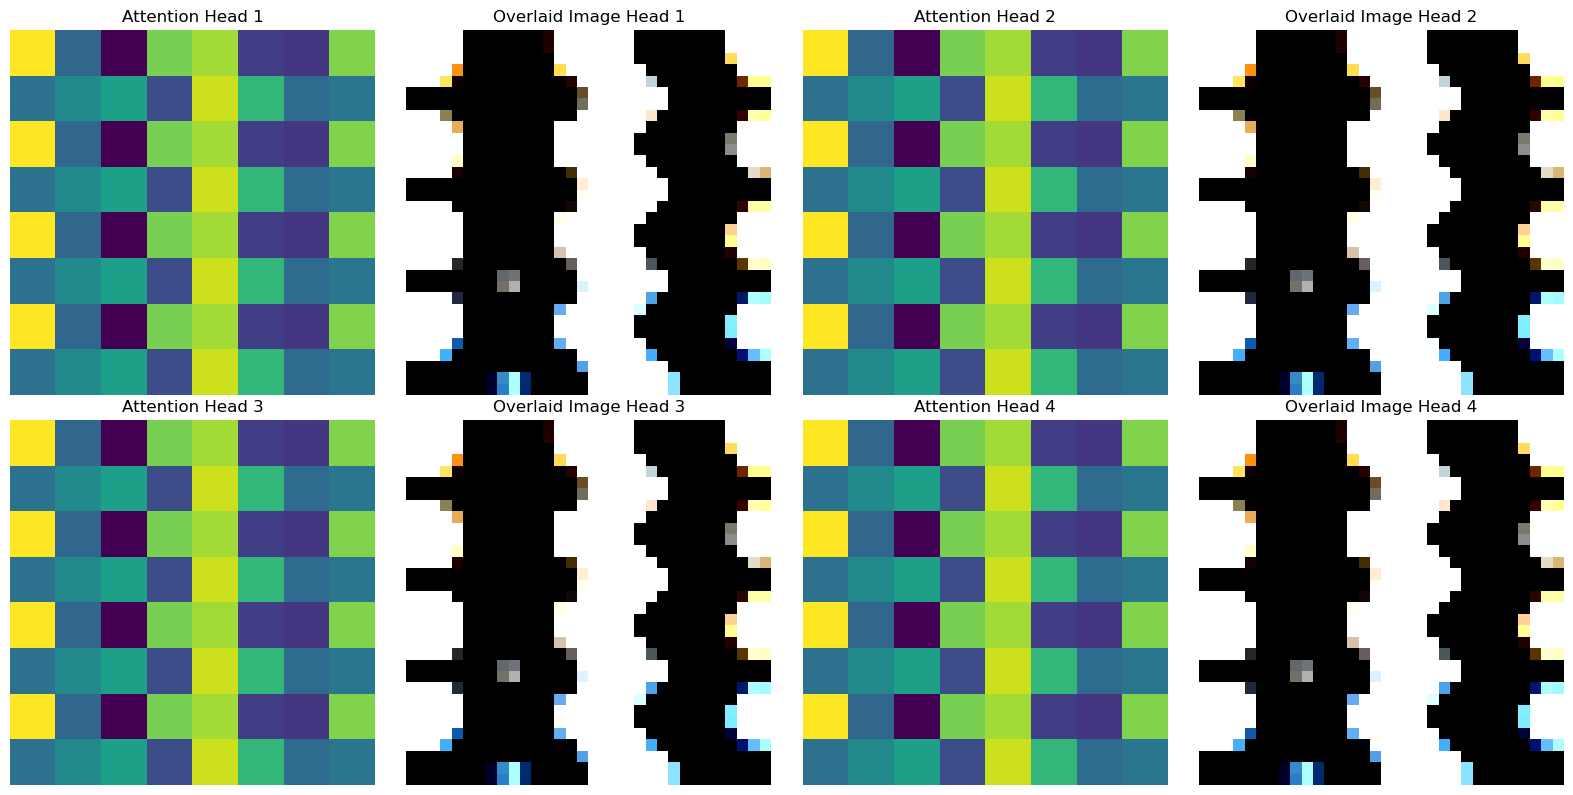

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class: 0


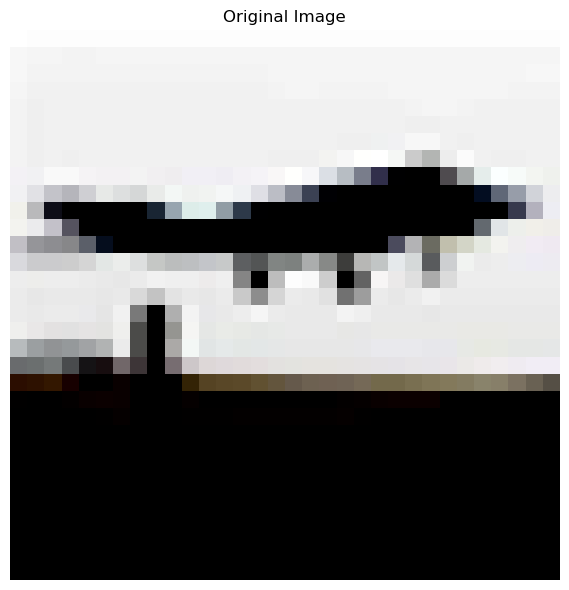

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


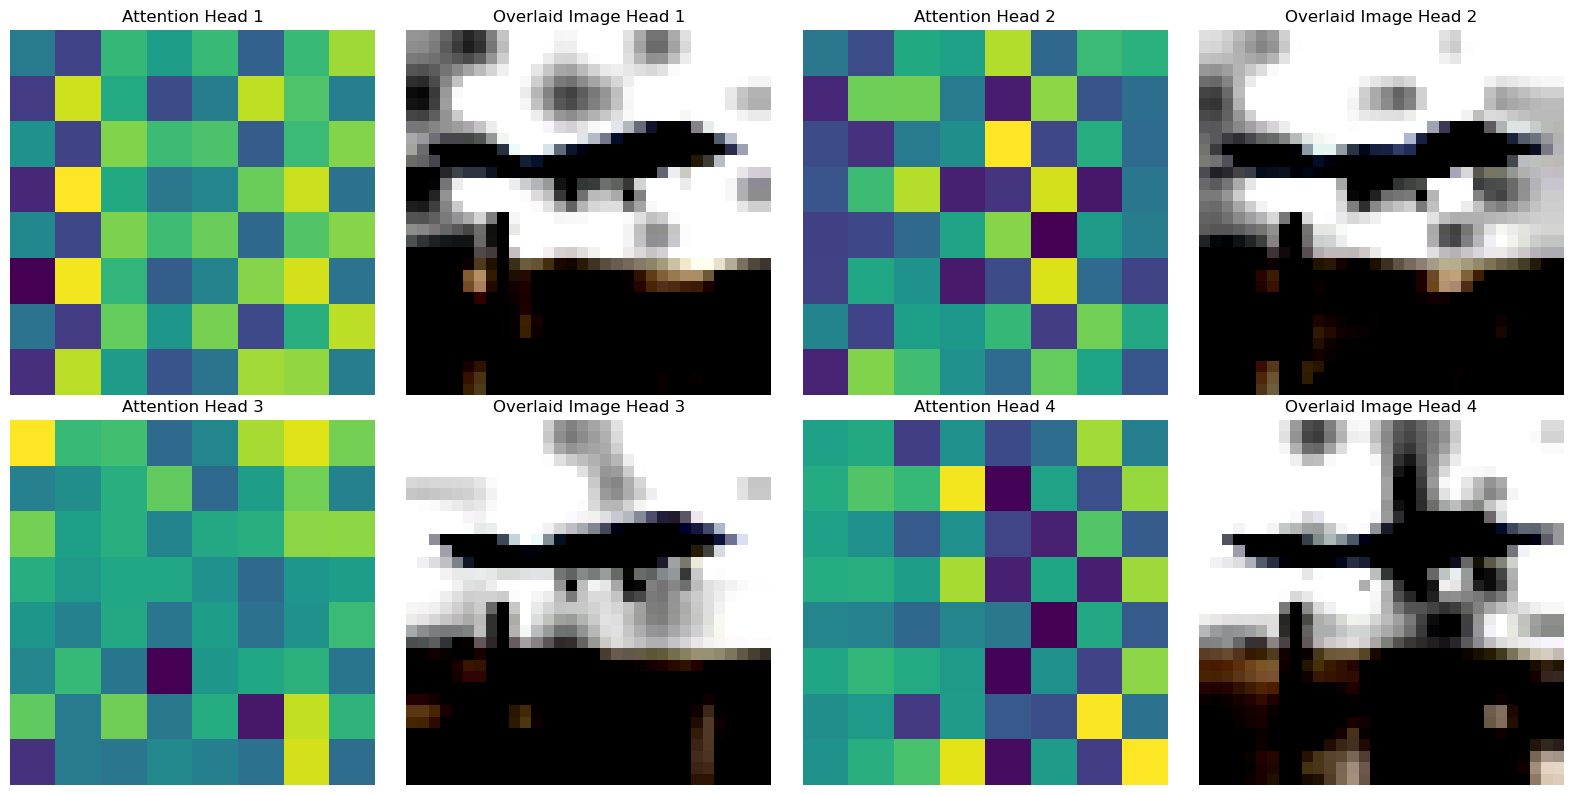

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


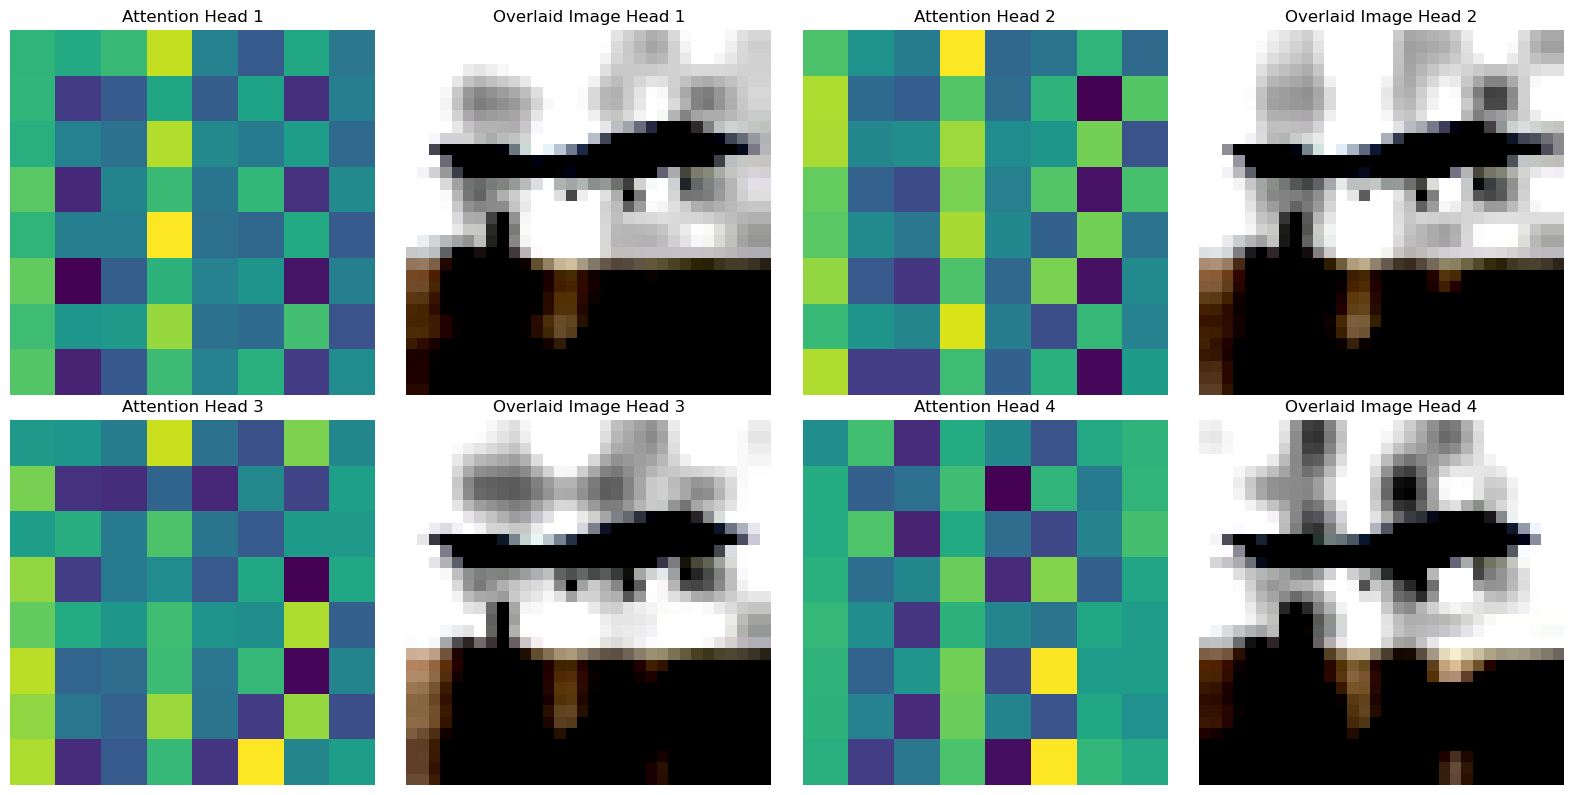

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


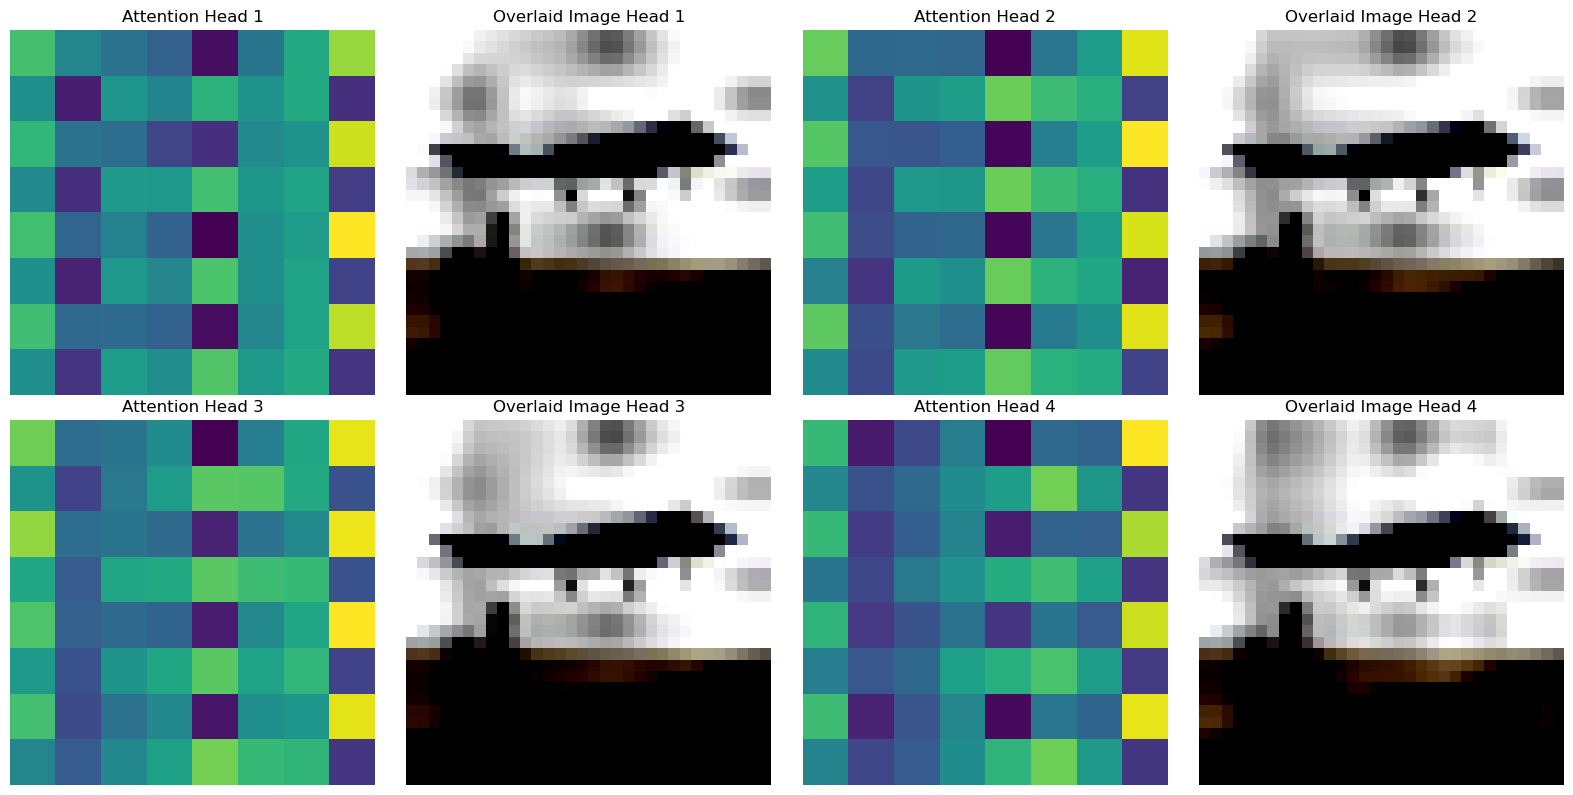

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


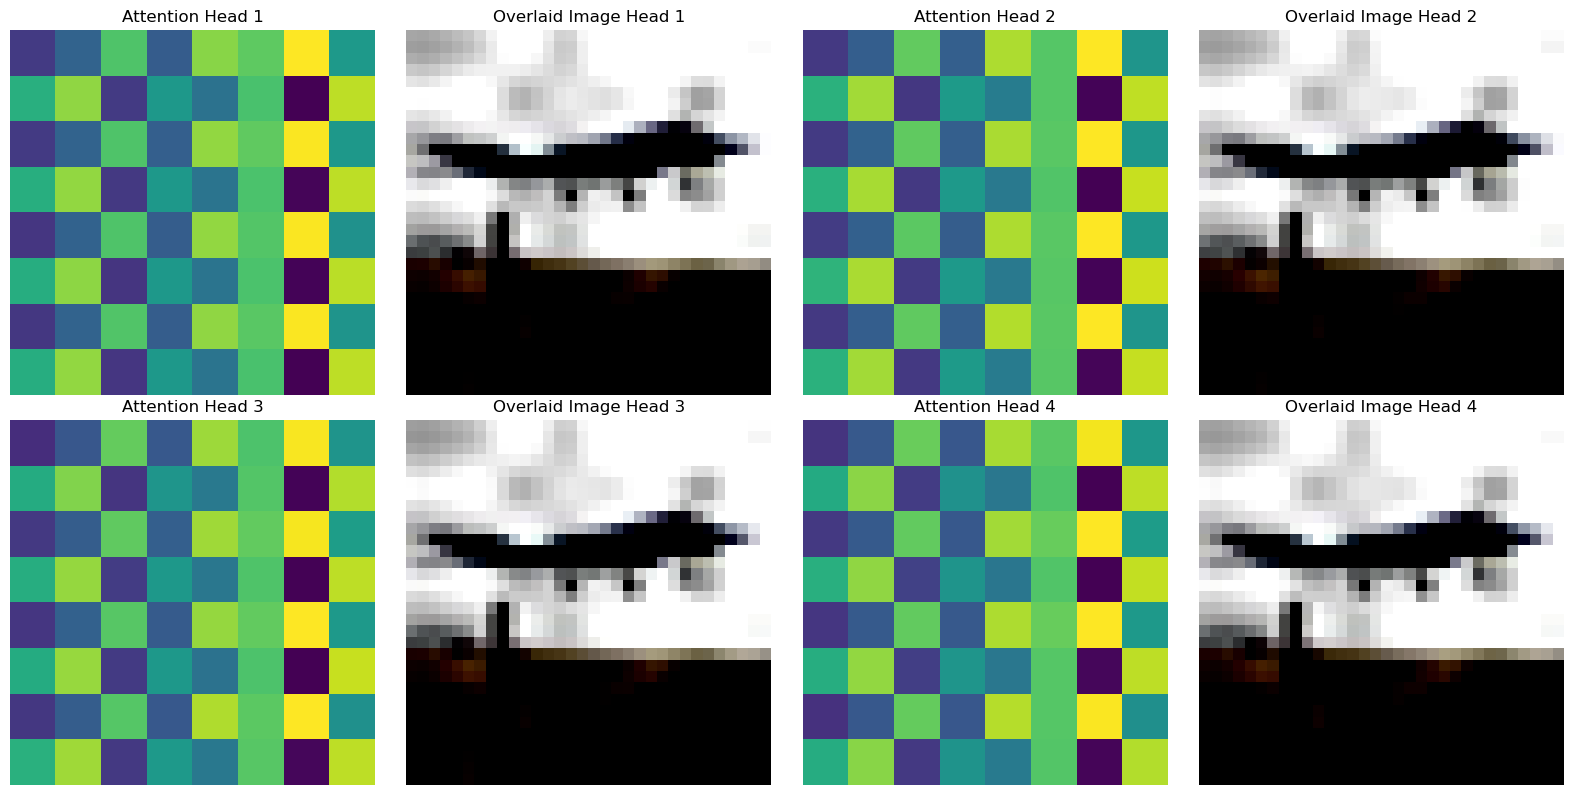

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


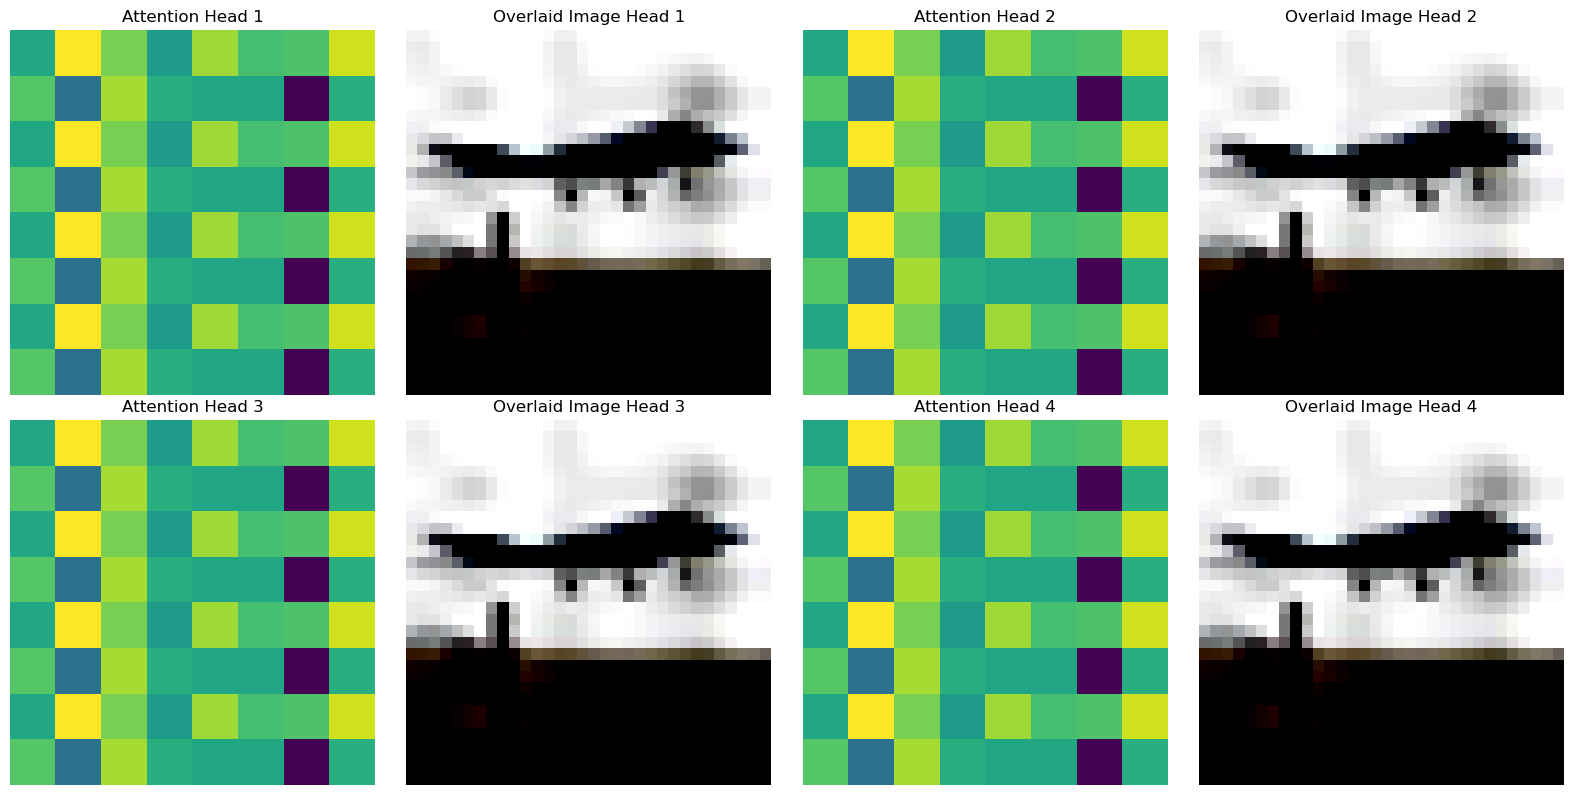

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


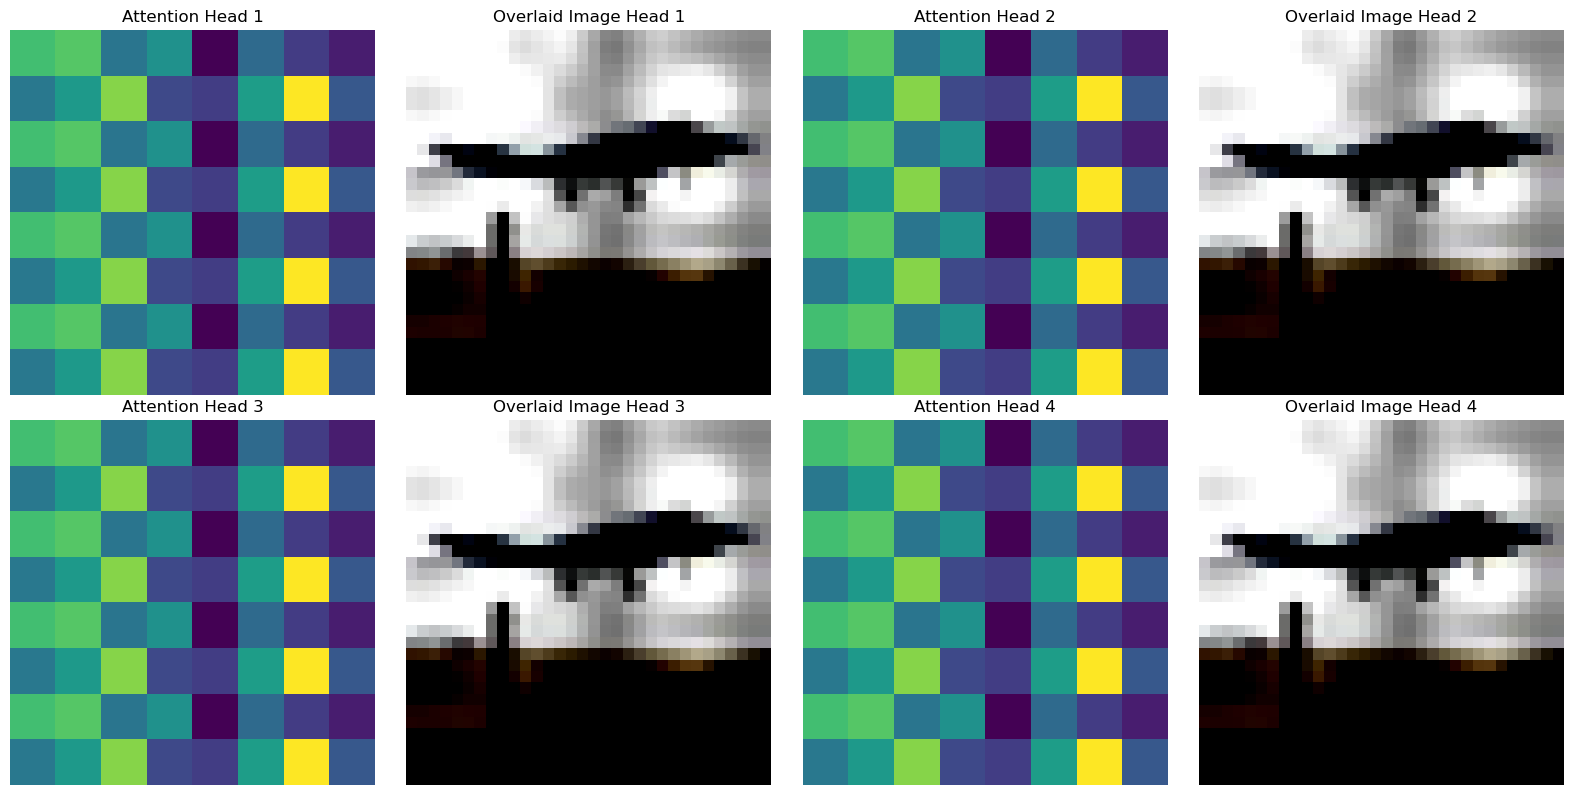

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


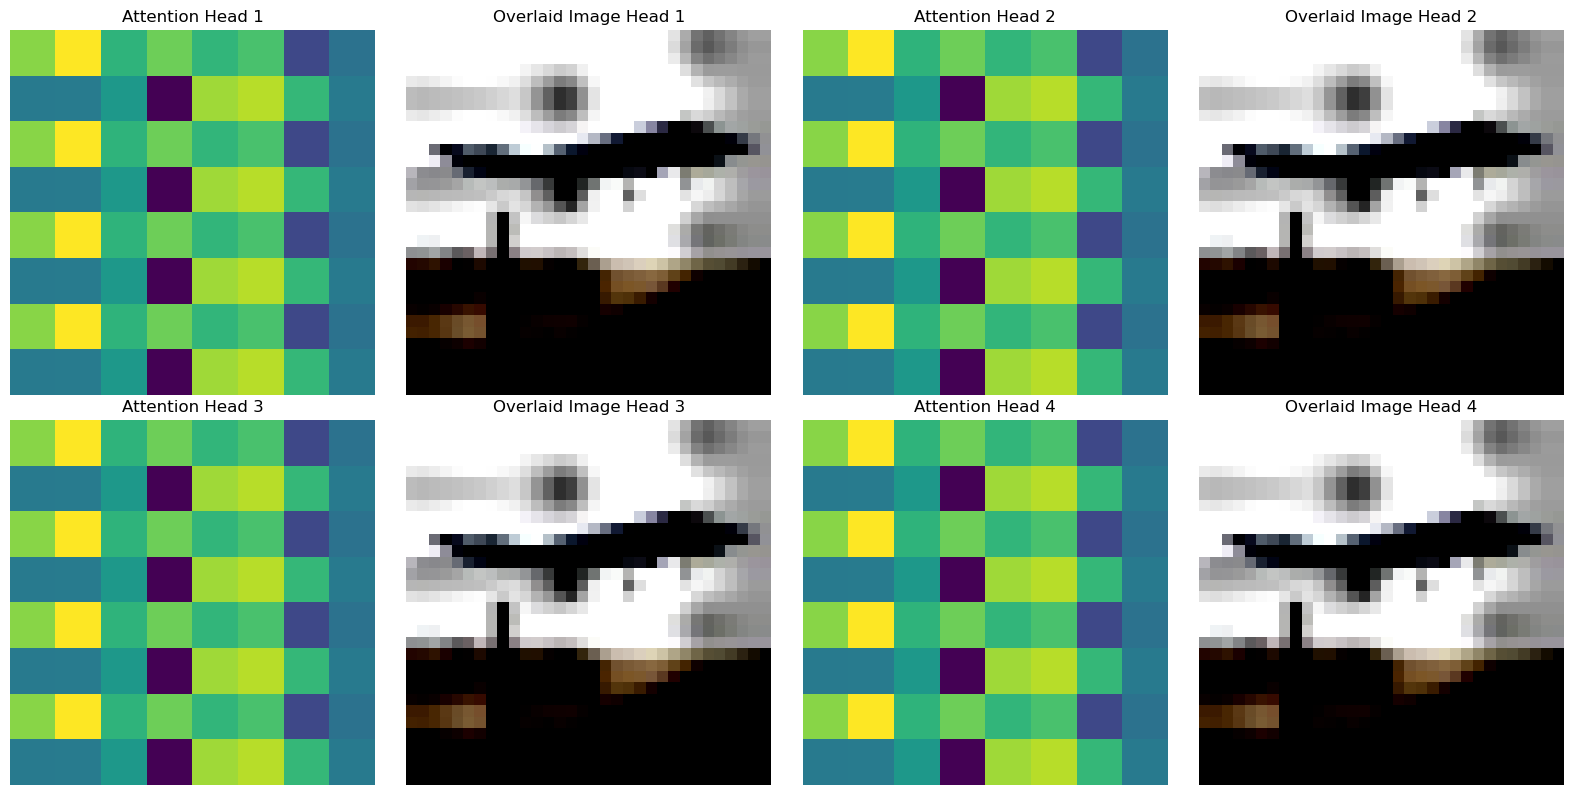

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


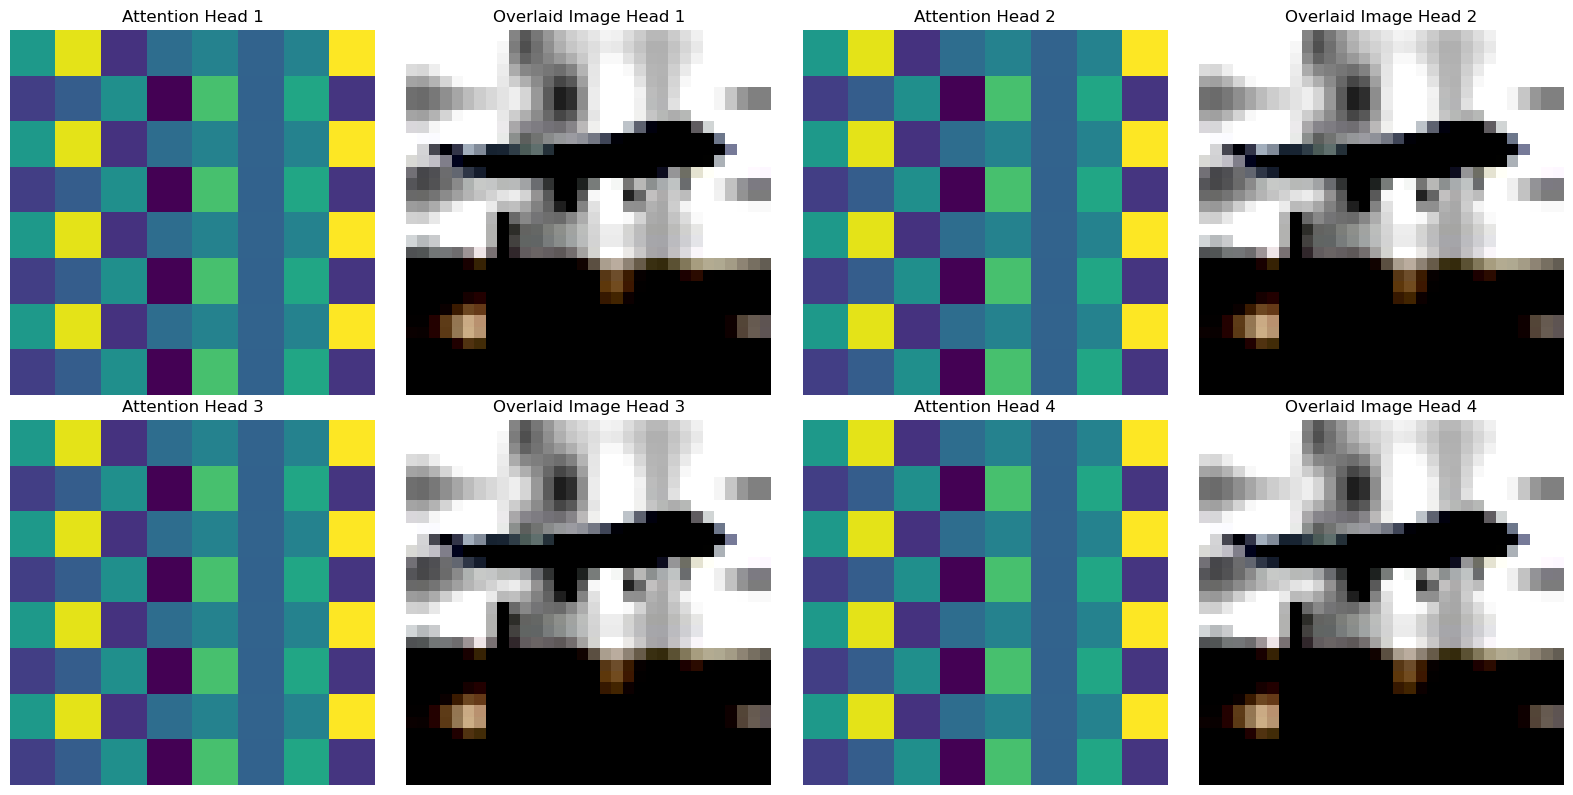

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


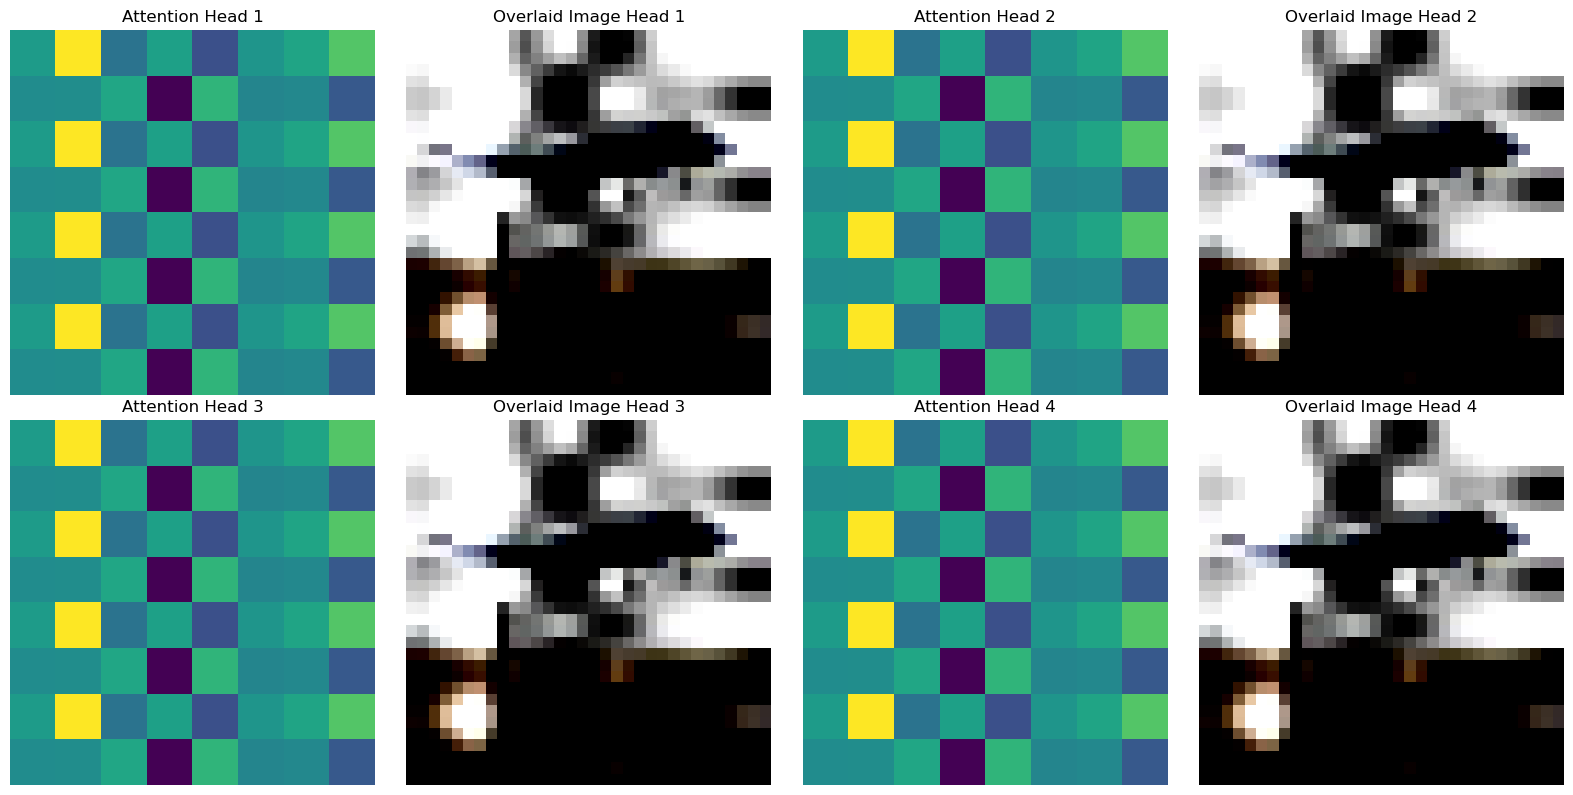

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


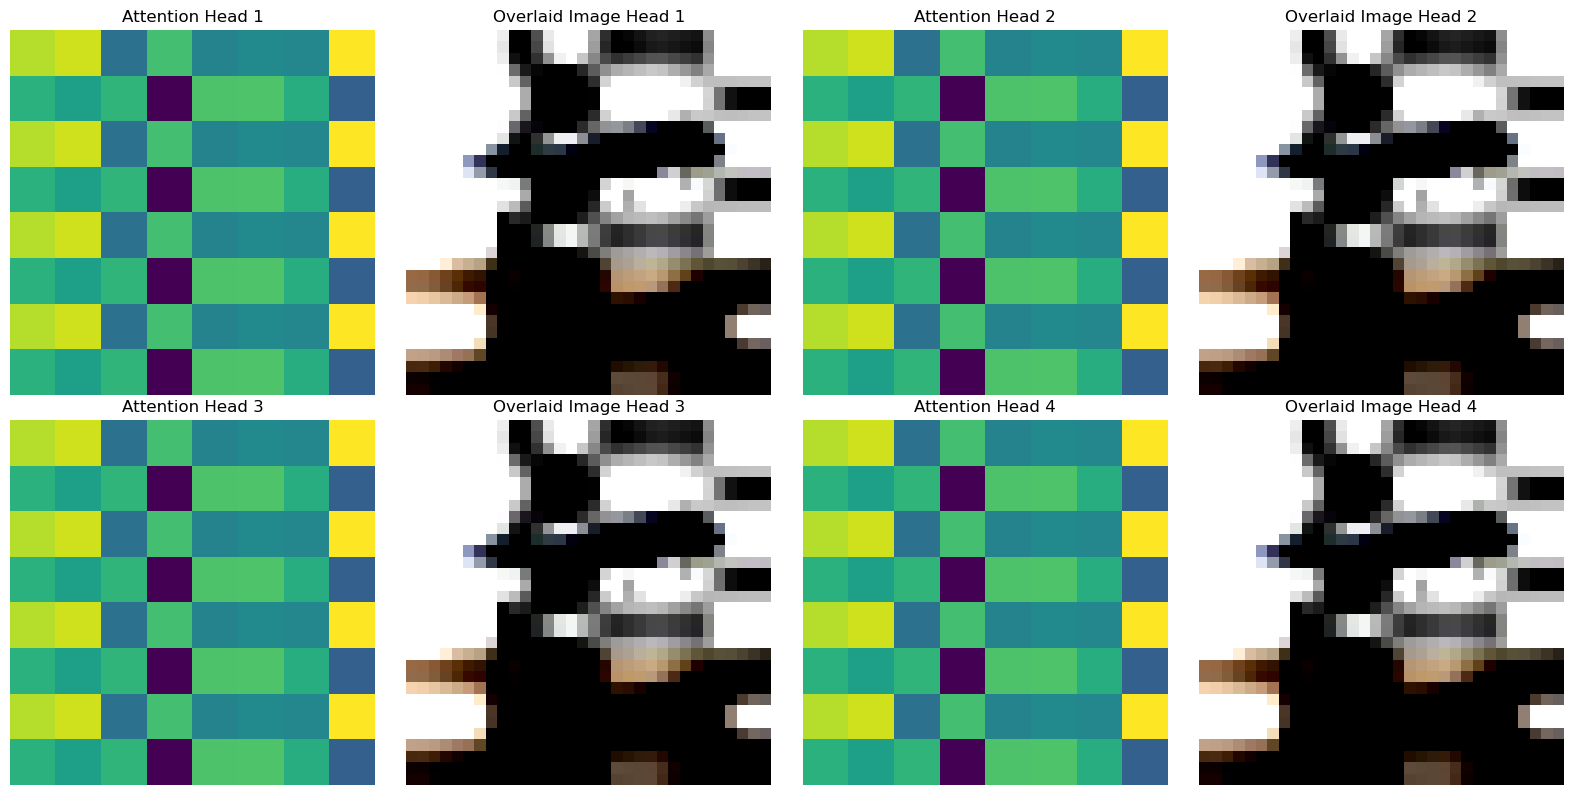

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


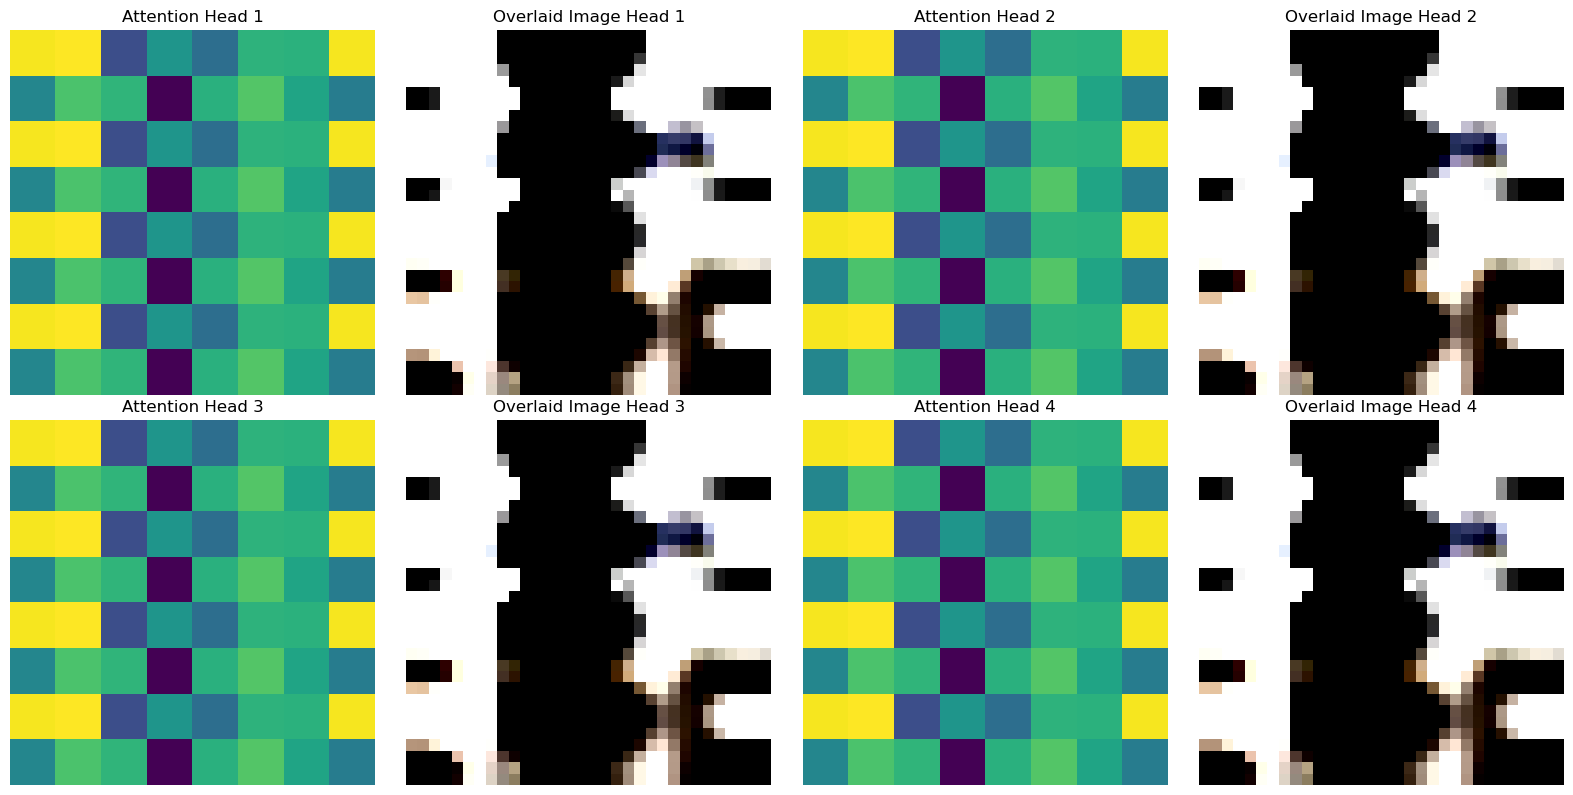

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


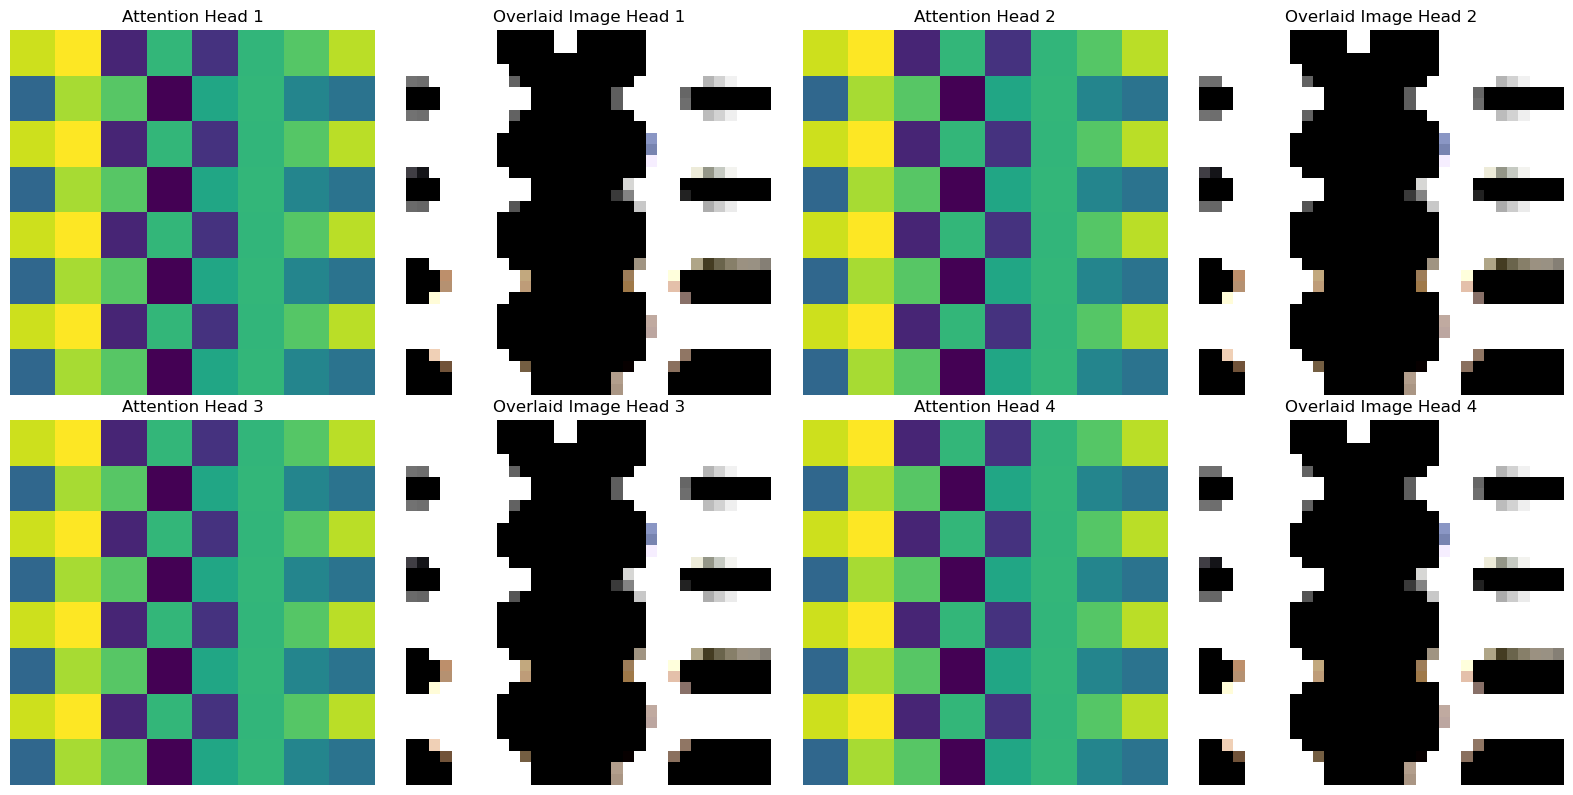

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class: 6


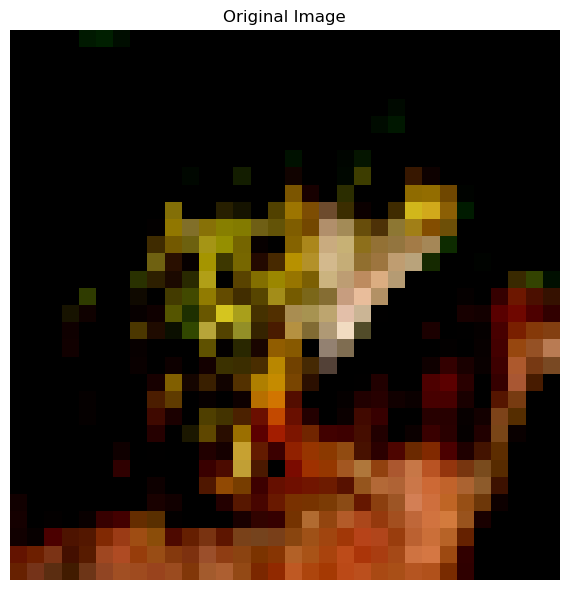

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


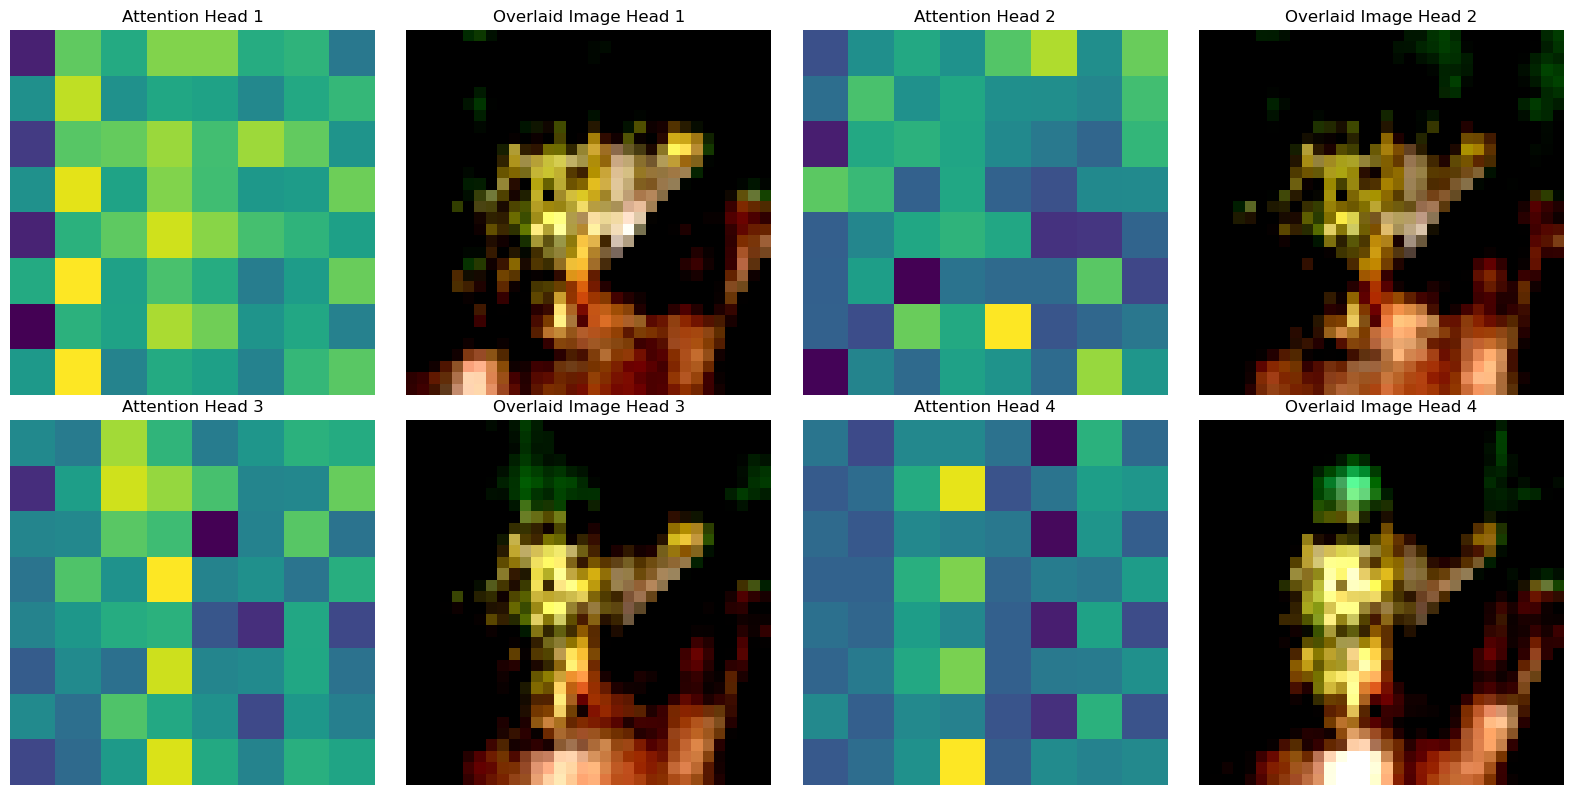

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


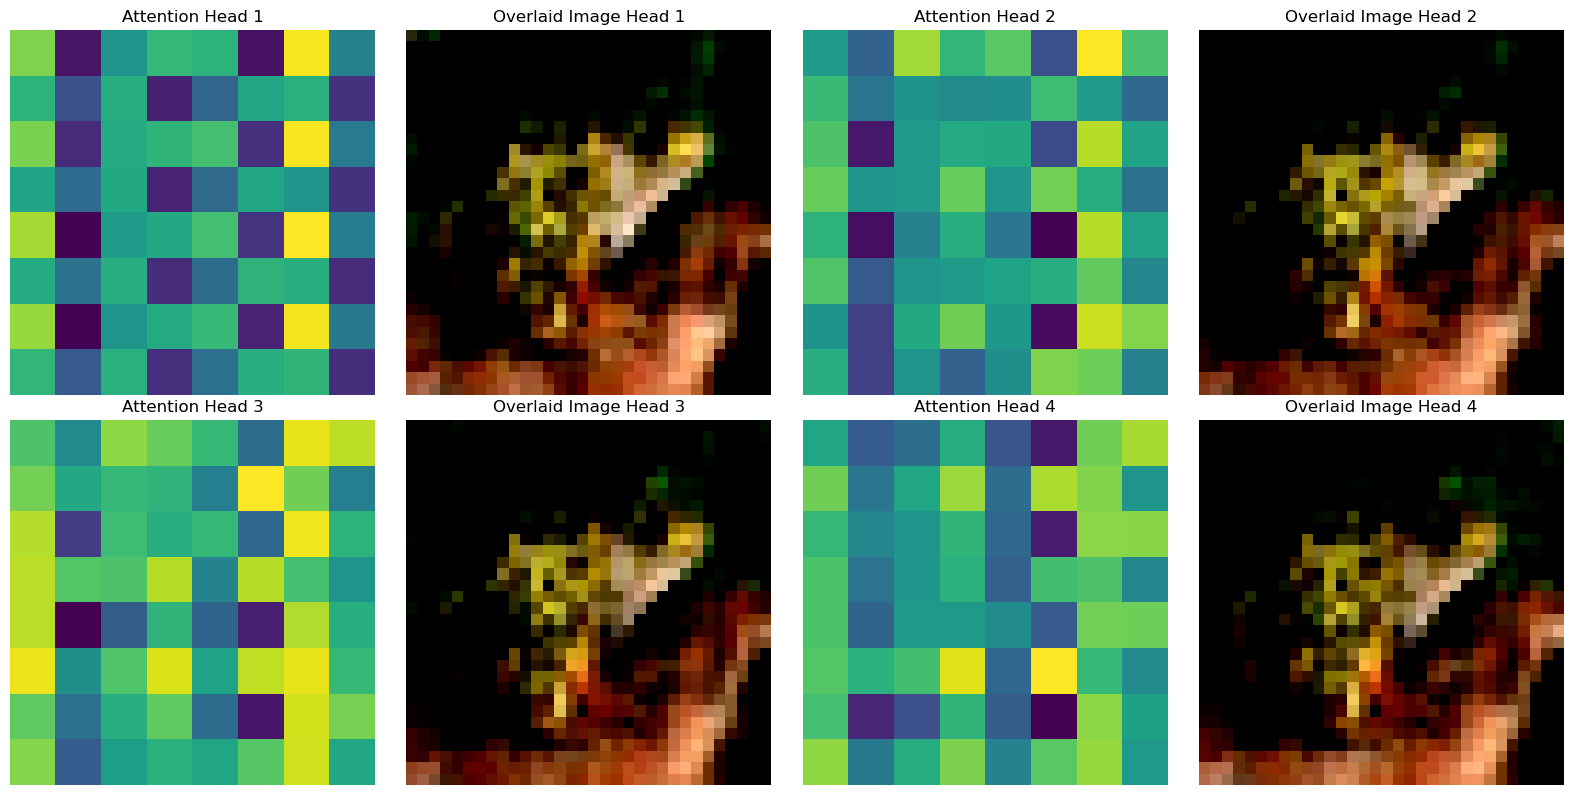

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


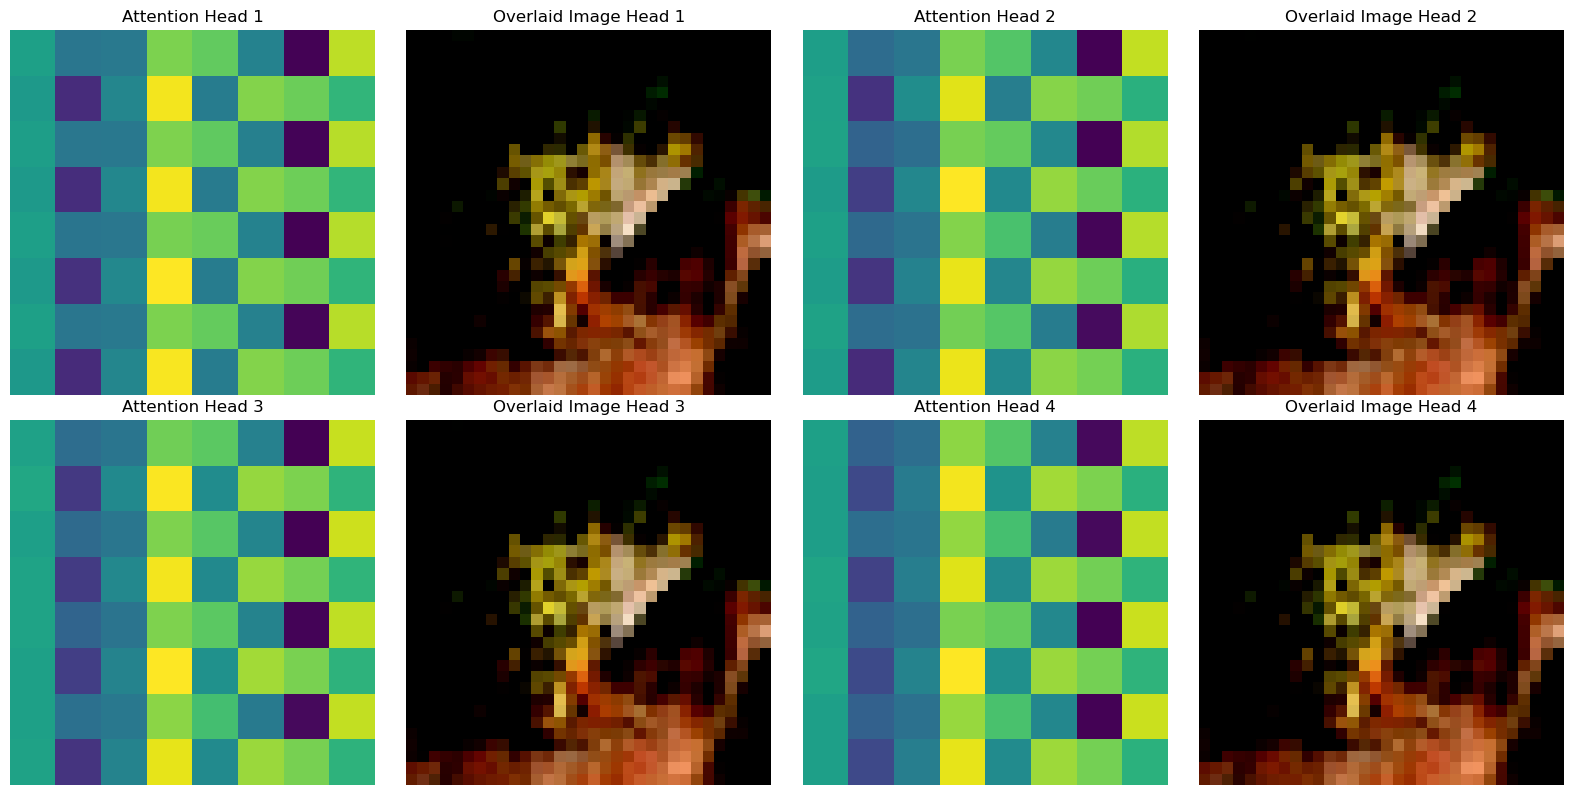

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


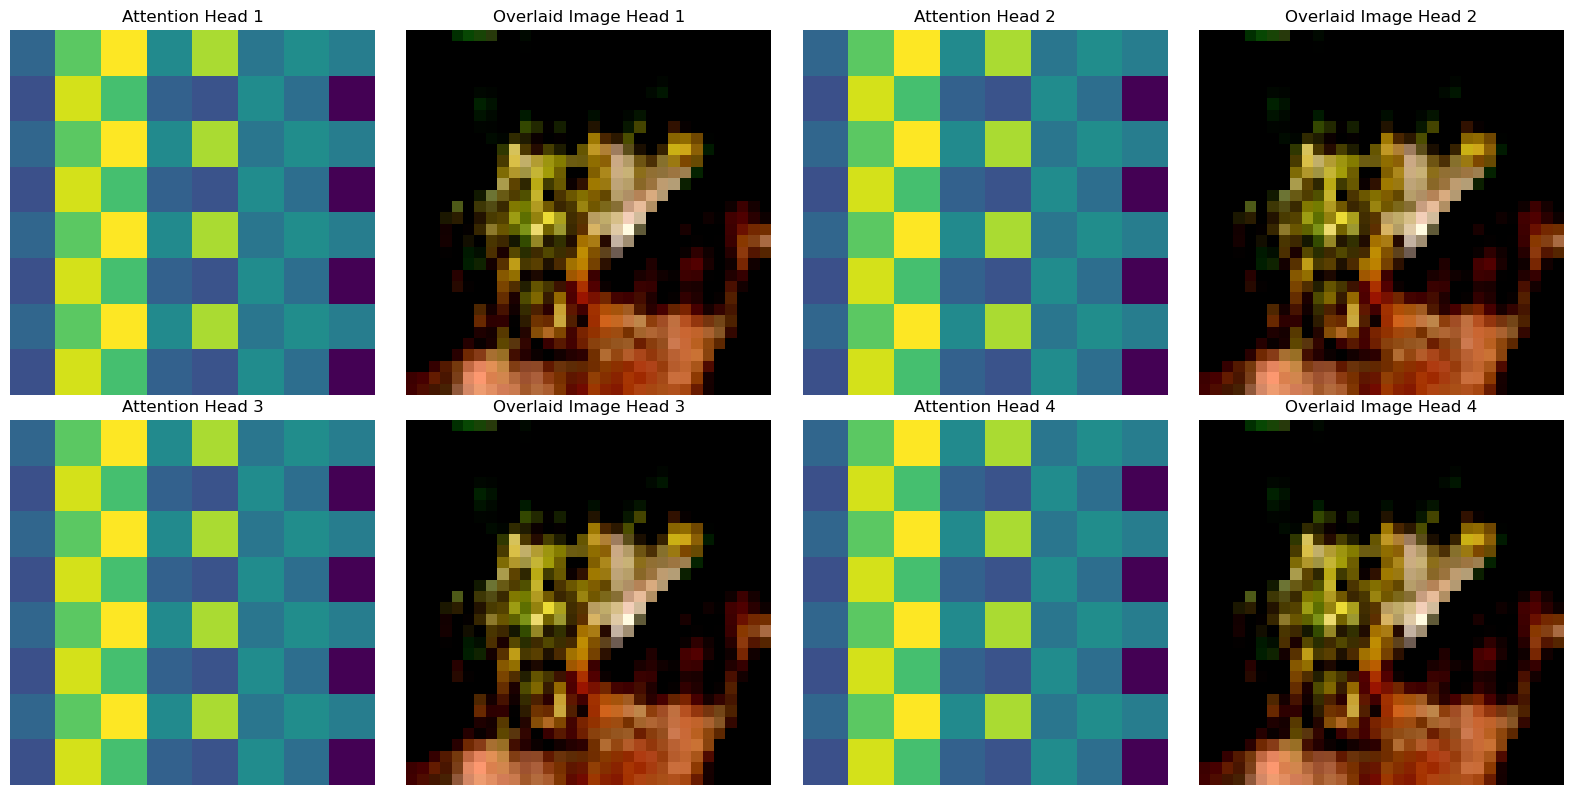

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


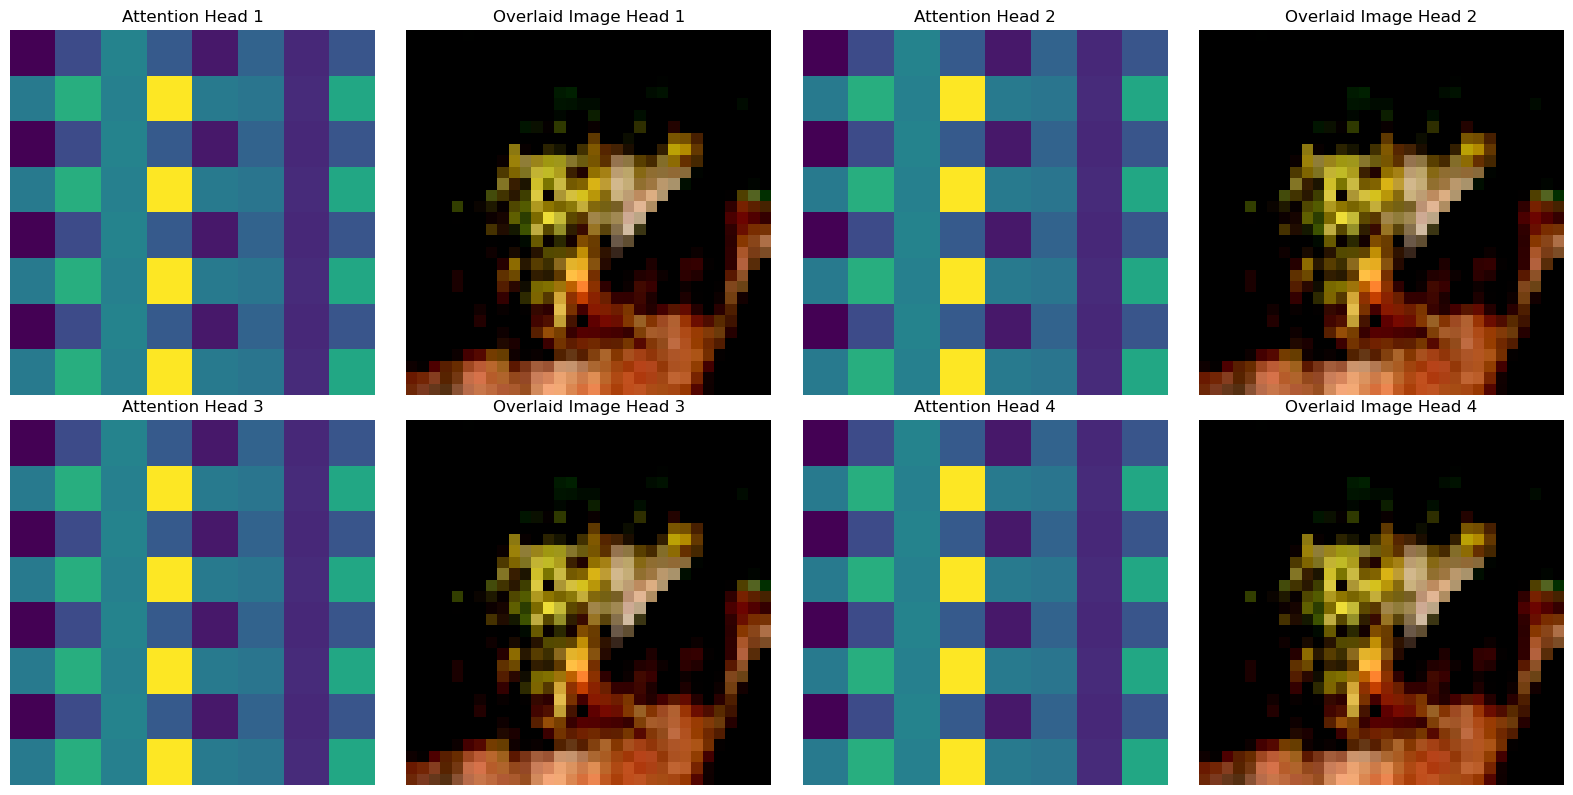

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


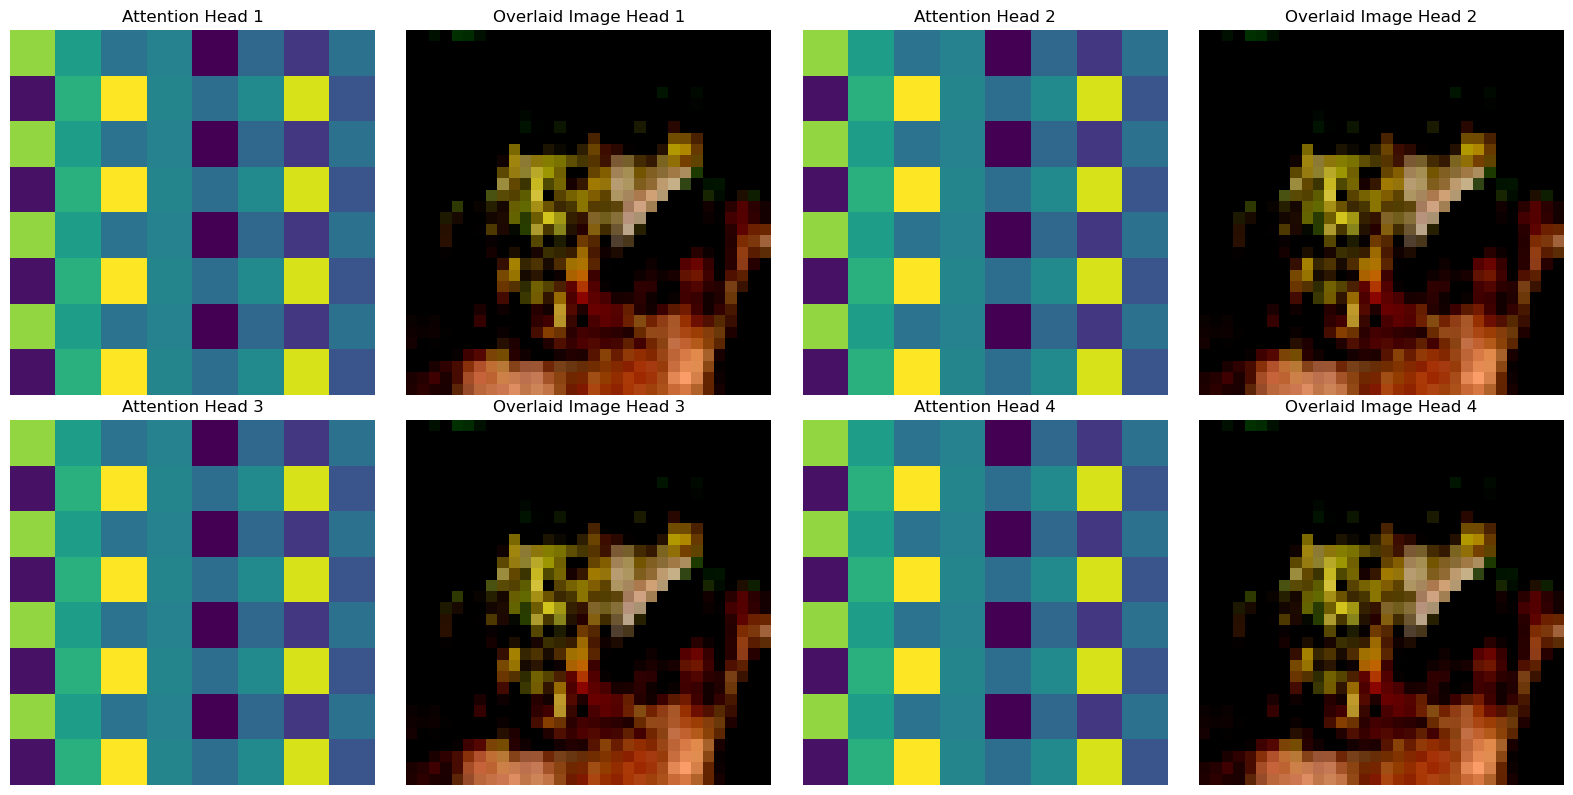

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


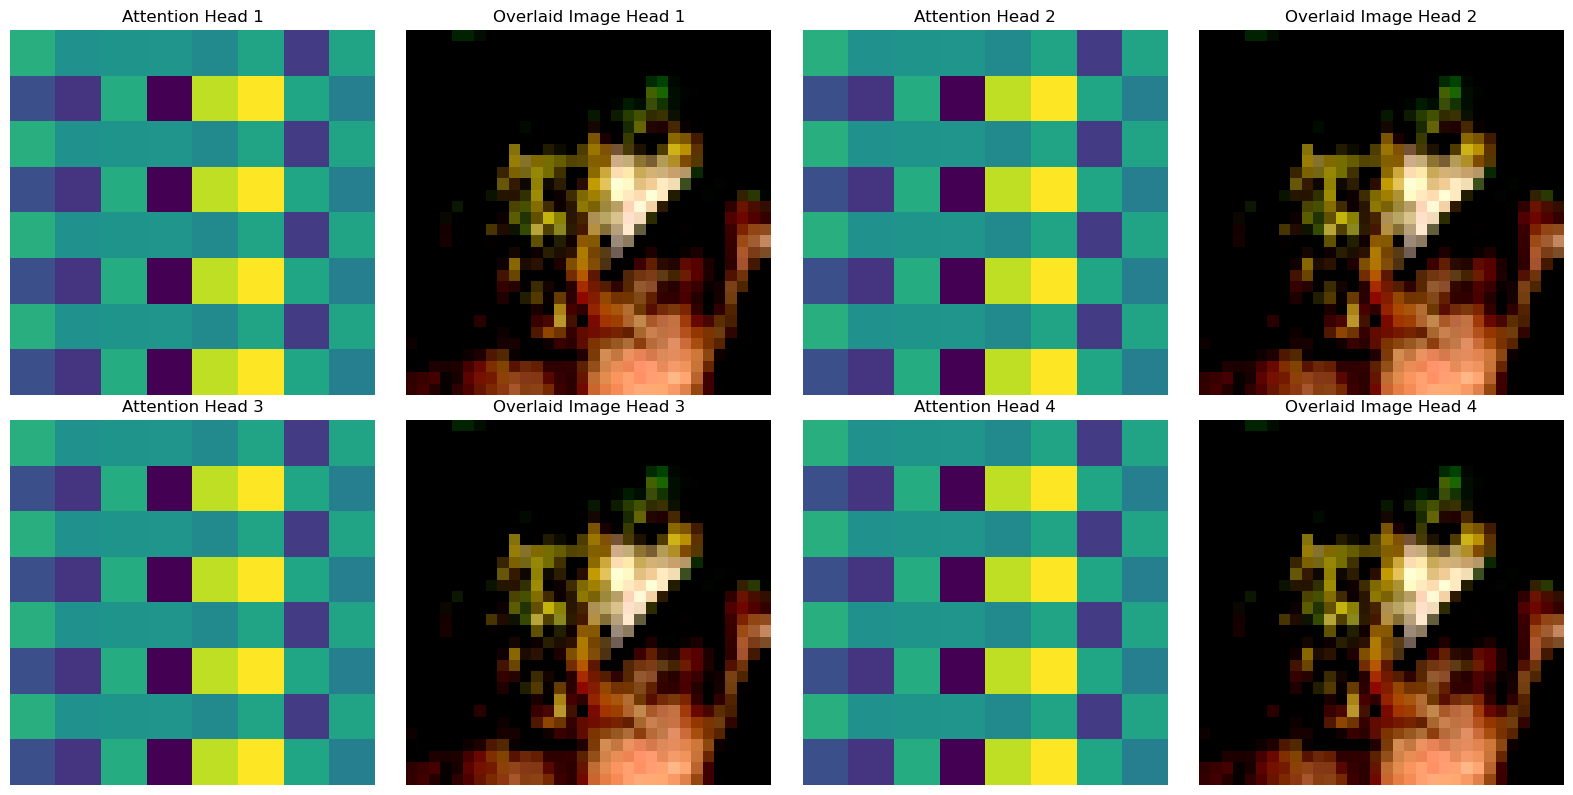

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


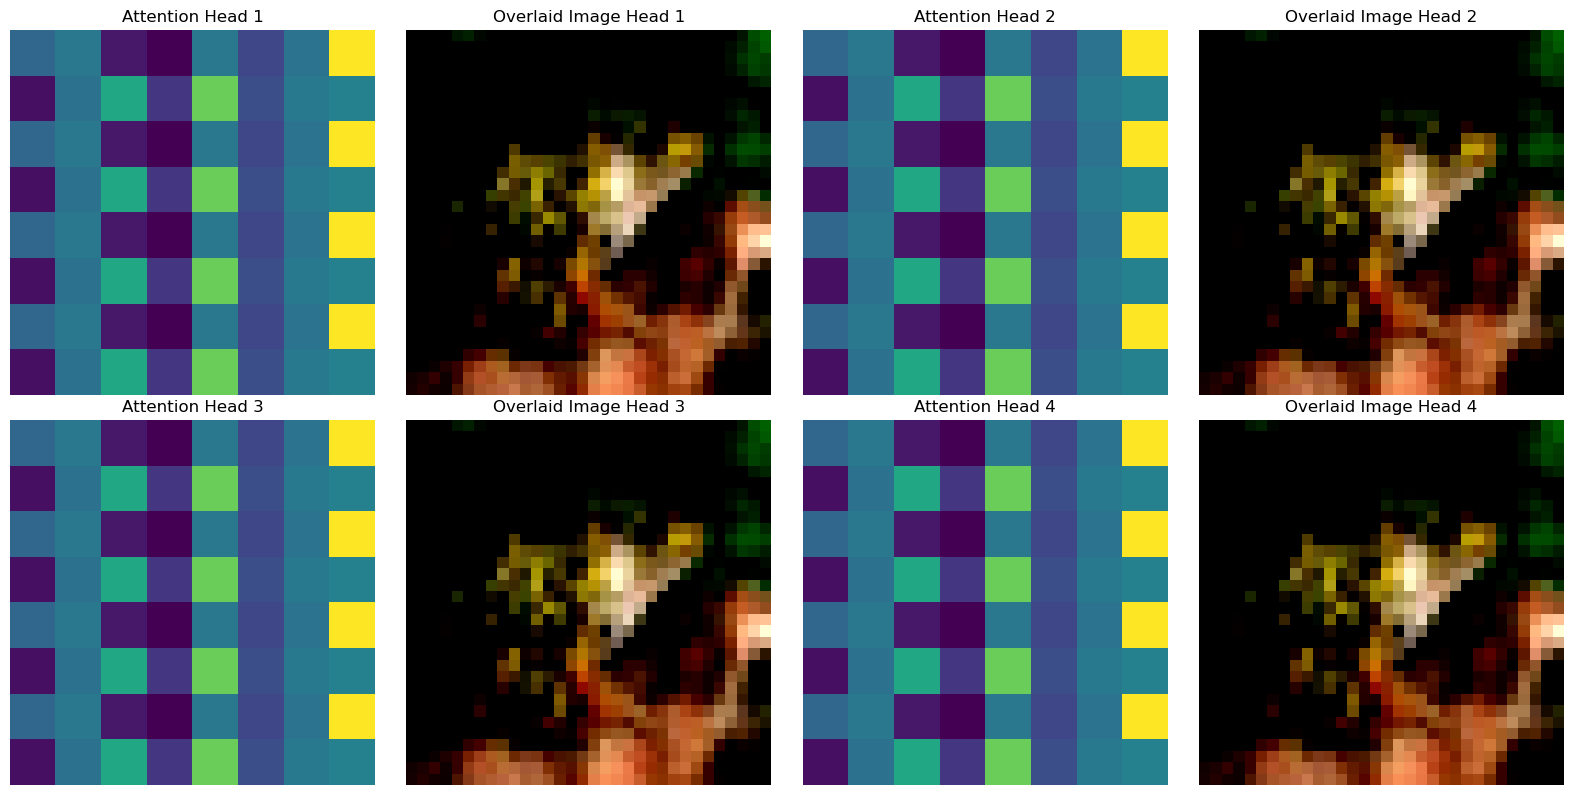

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


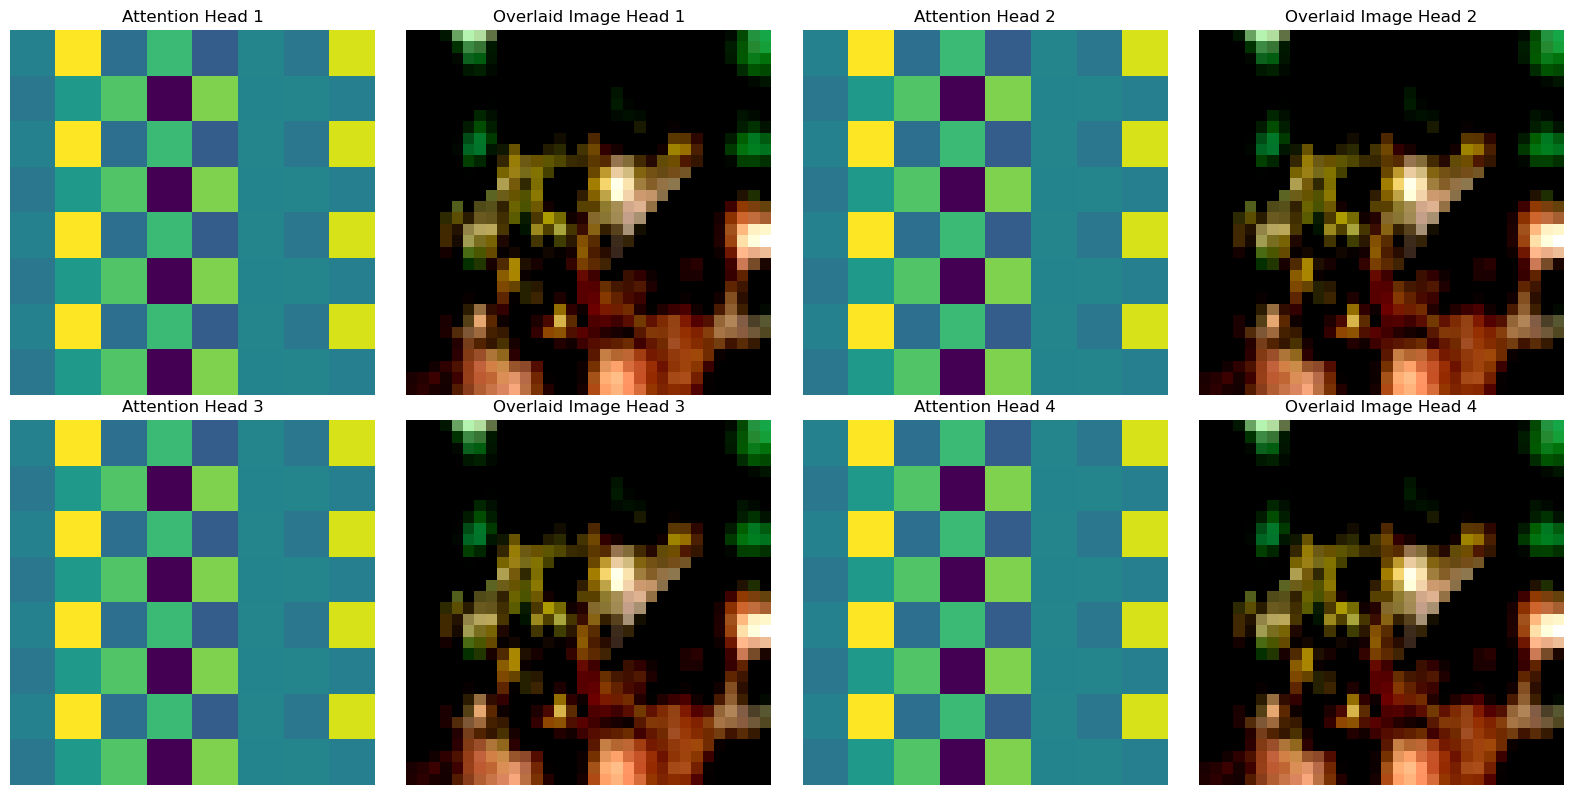

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


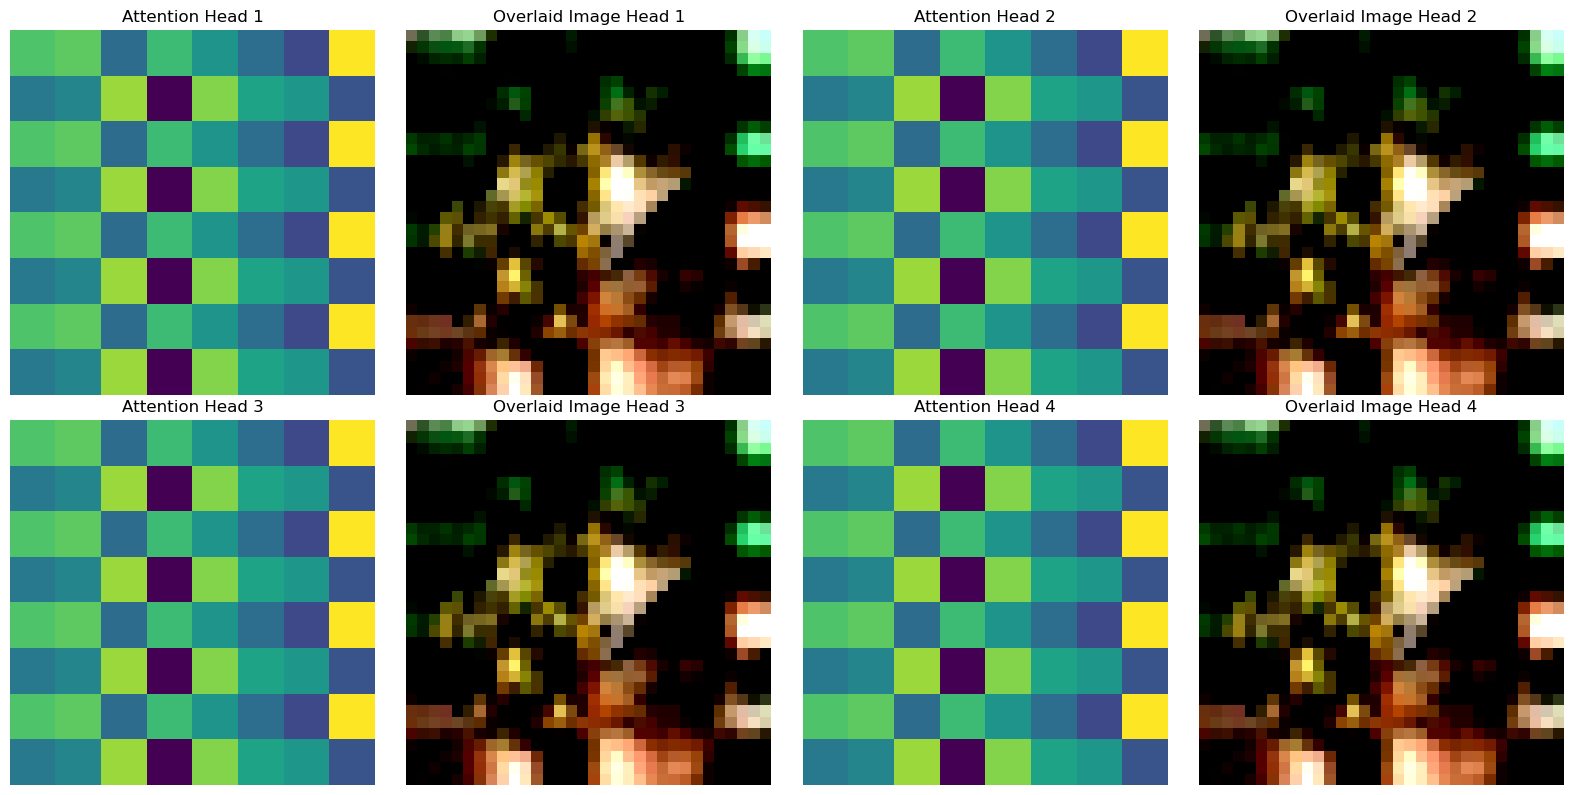

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


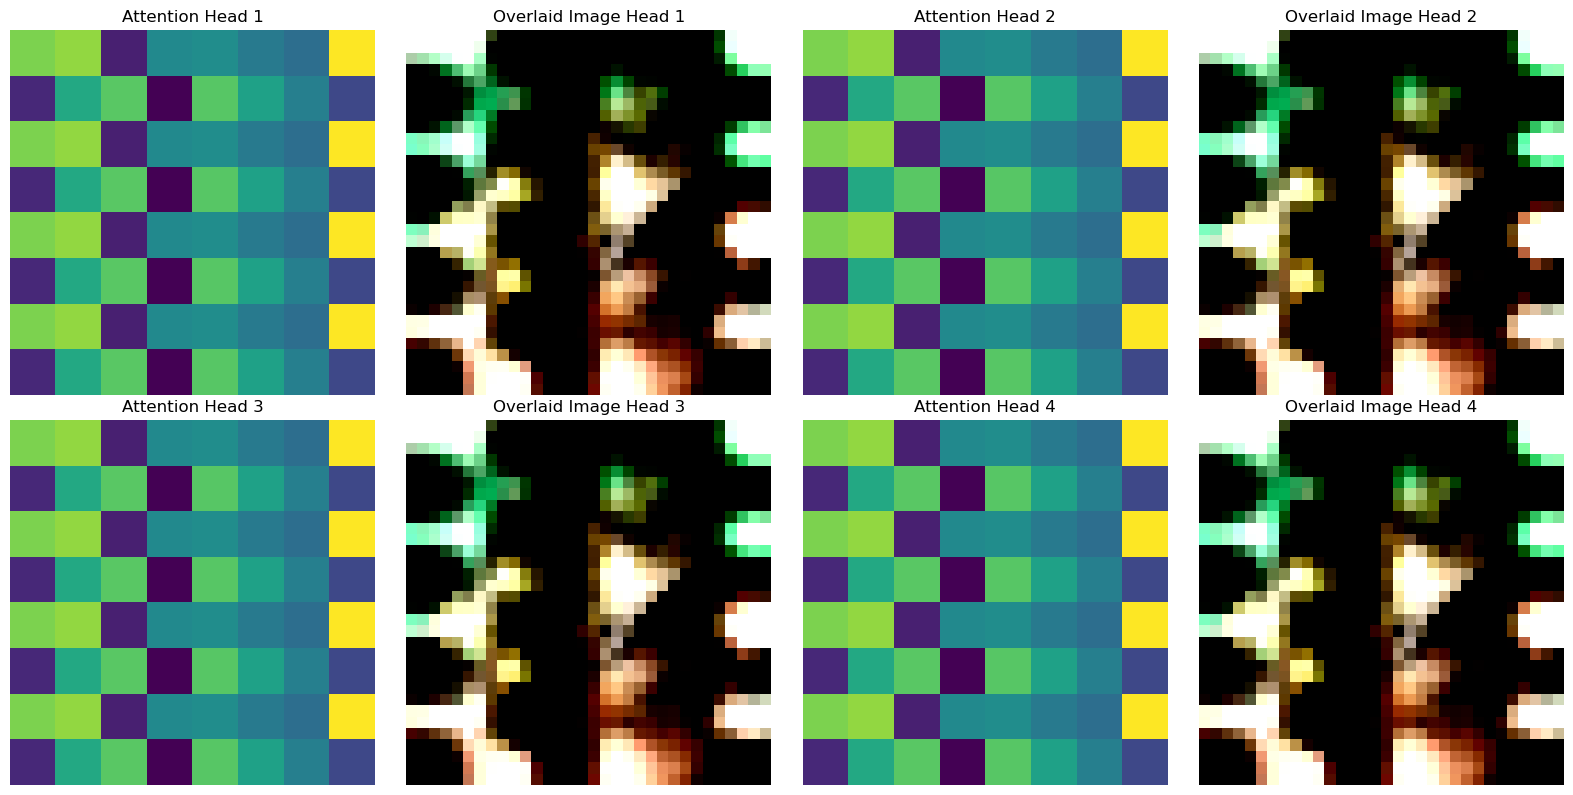

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


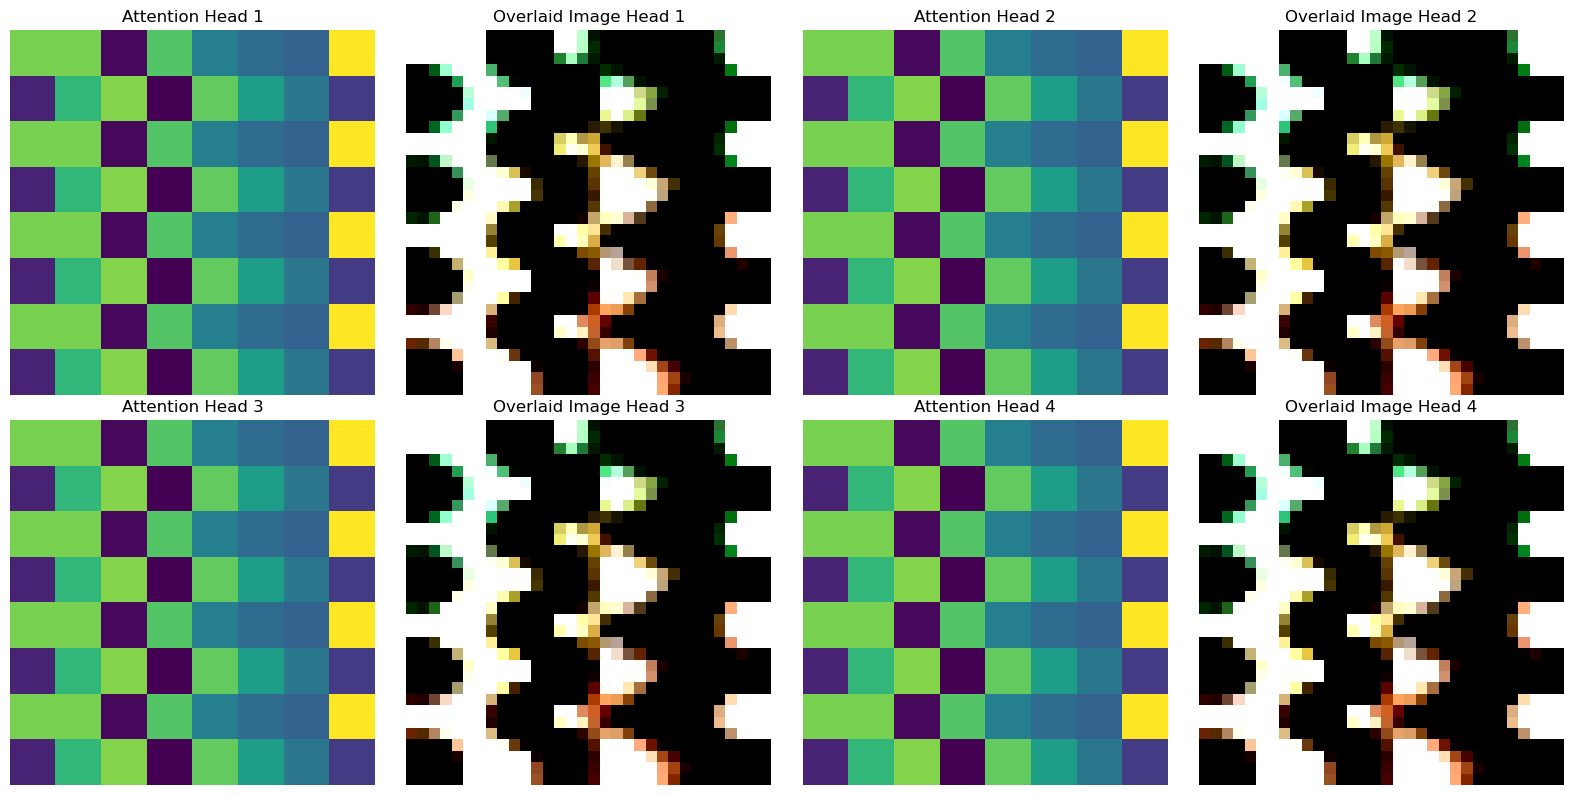

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class: 5


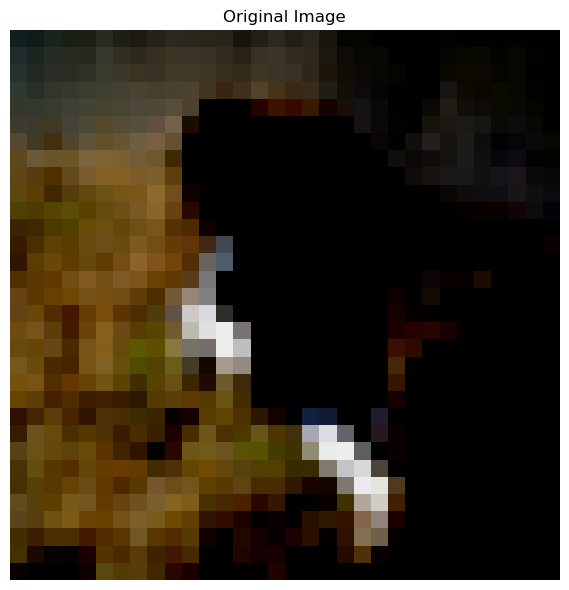

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


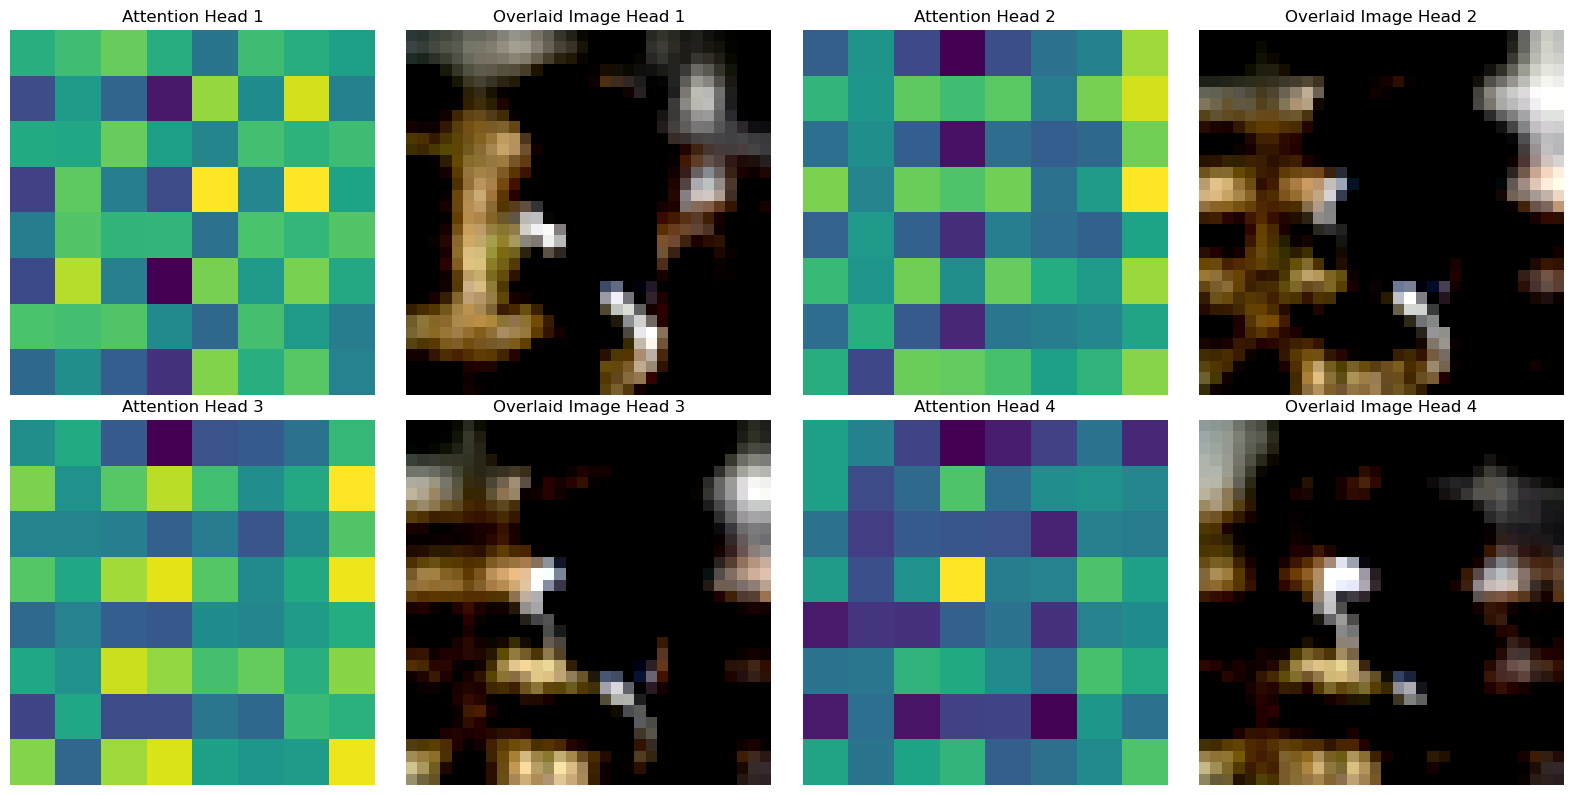

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


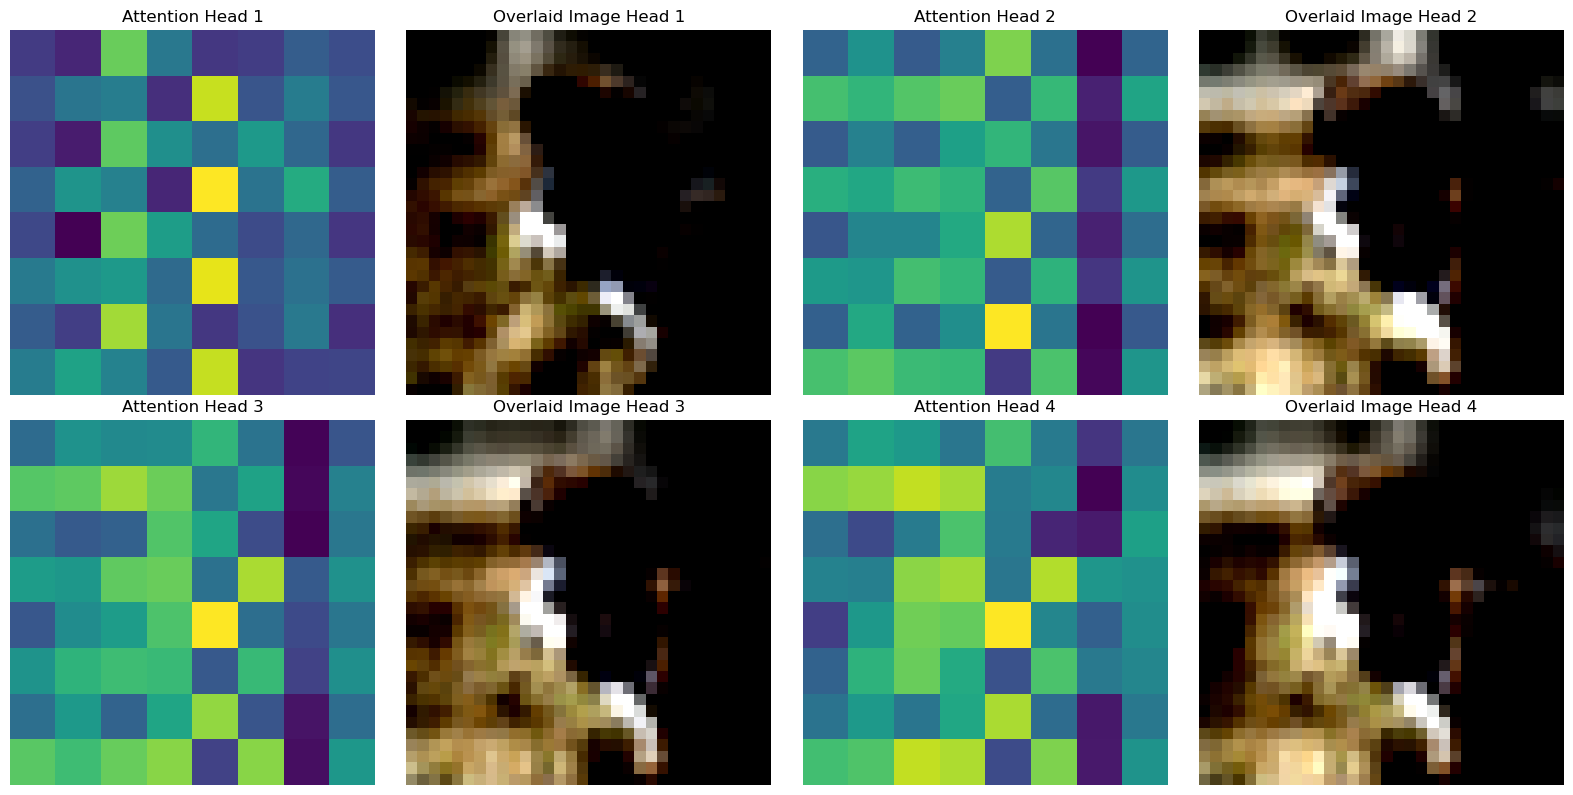

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


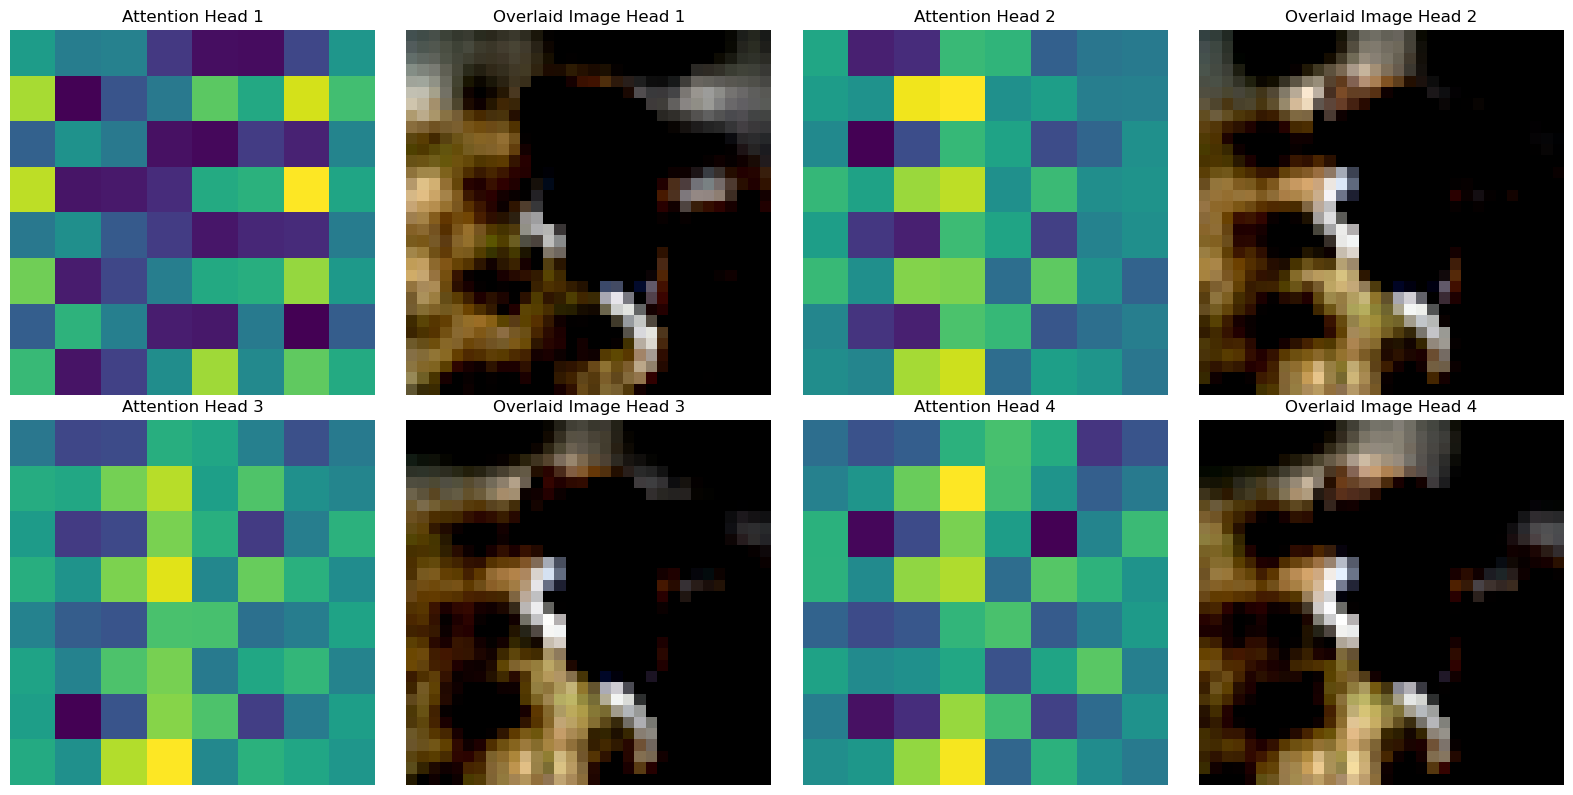

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


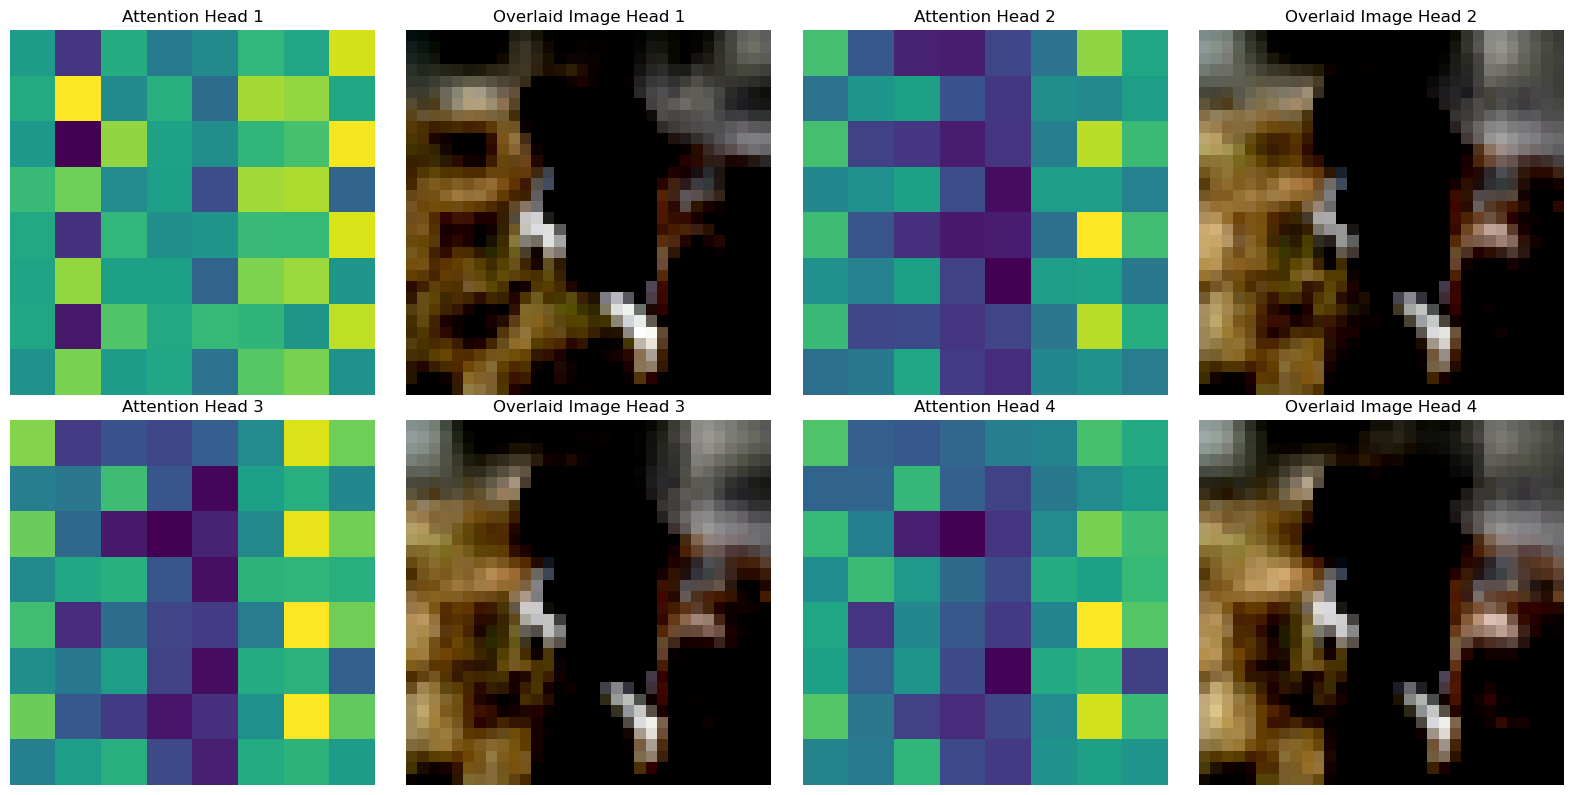

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


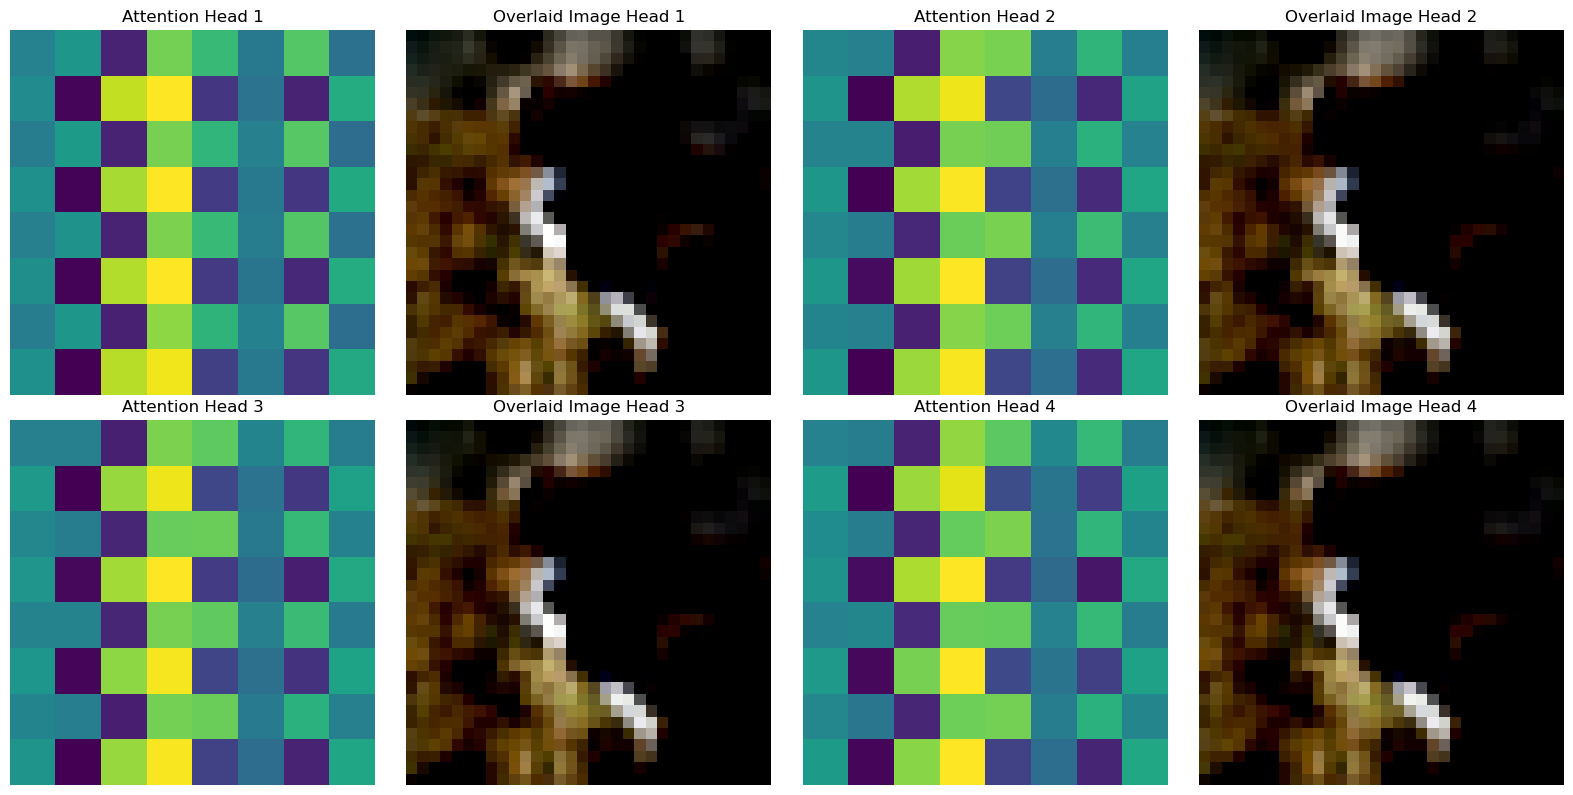

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


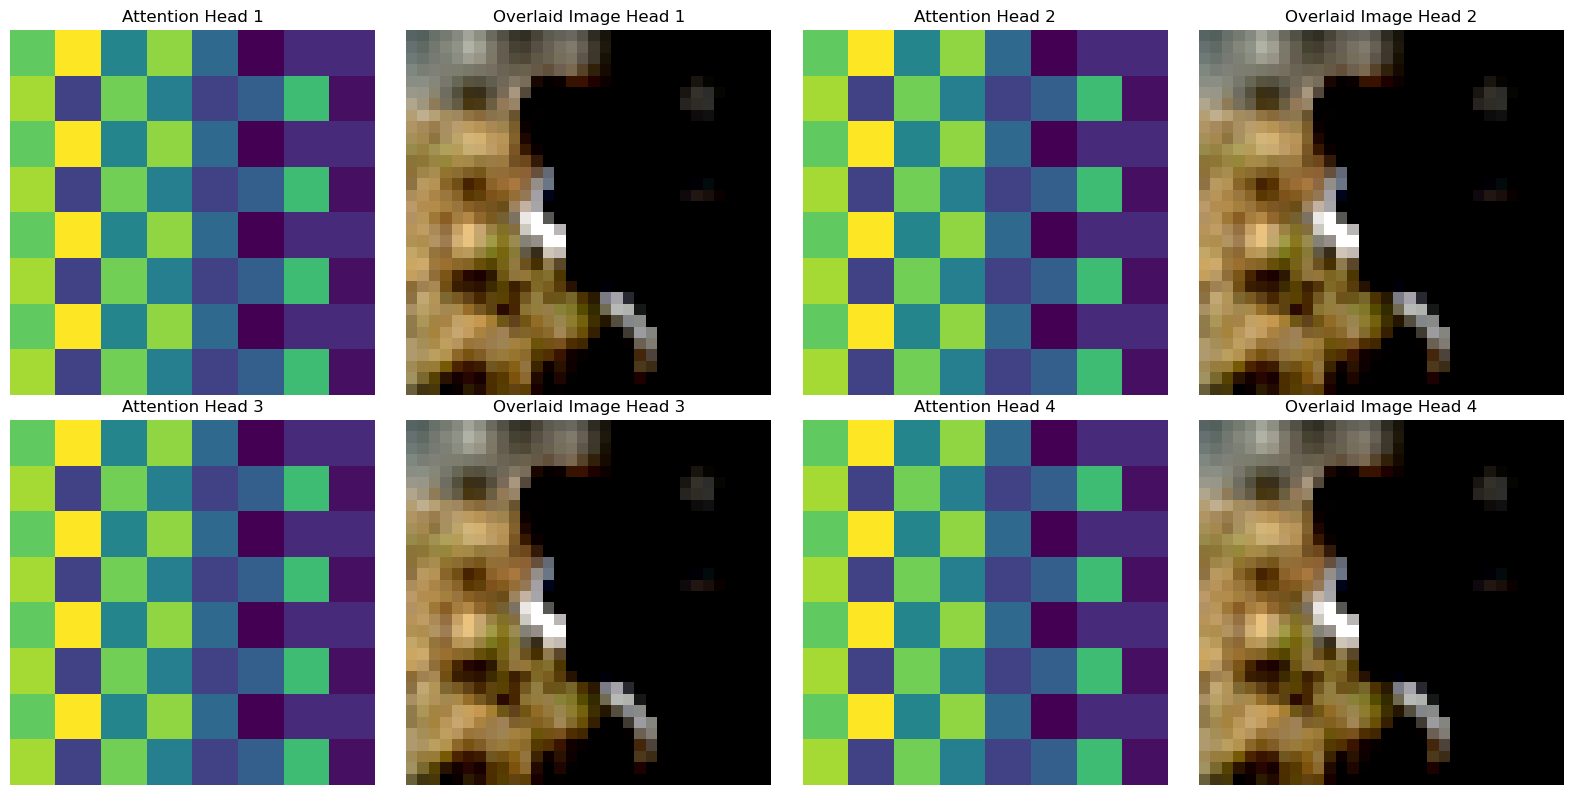

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


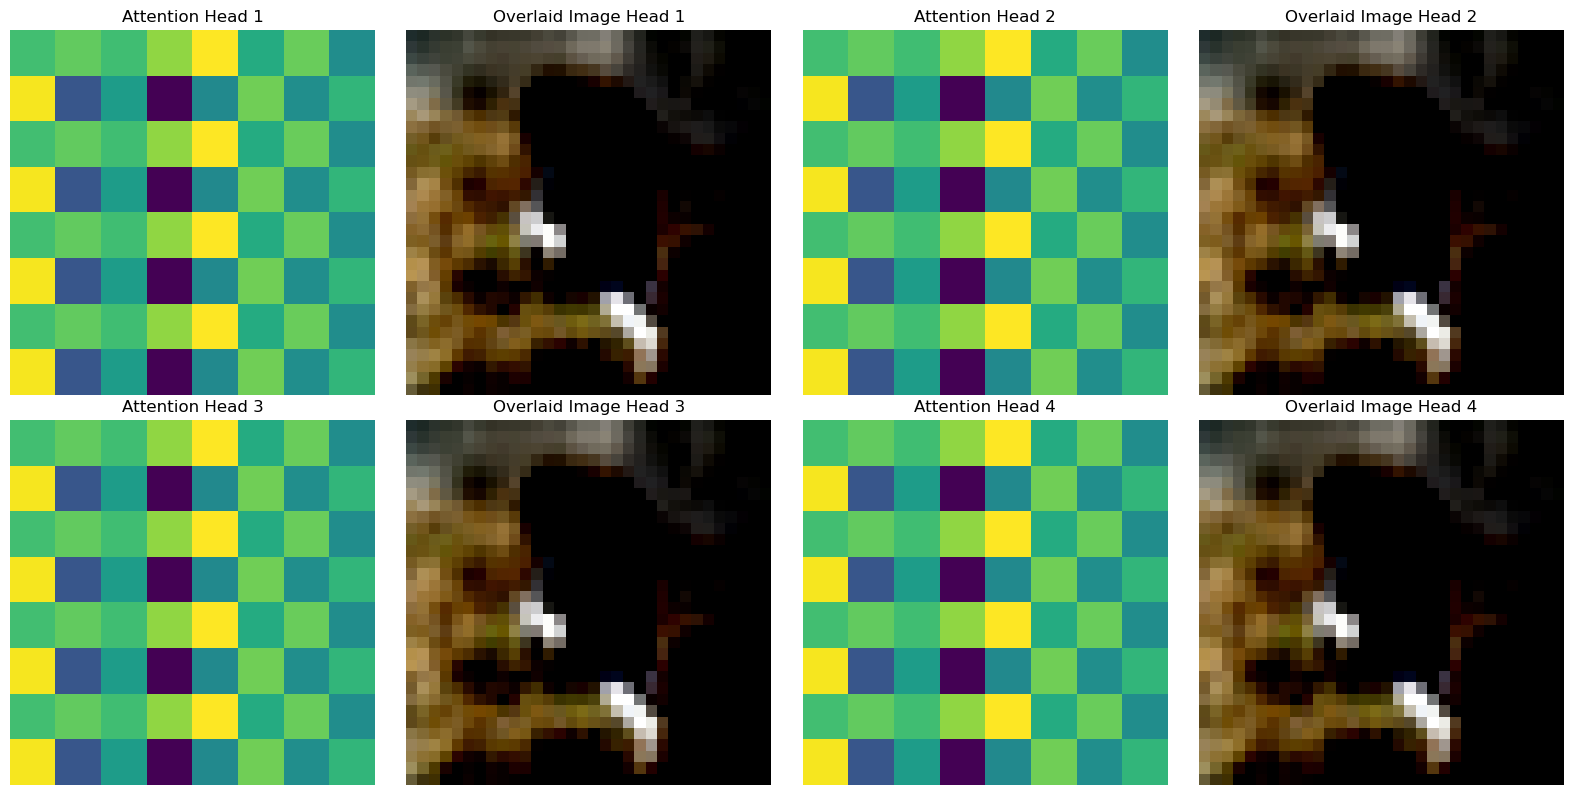

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


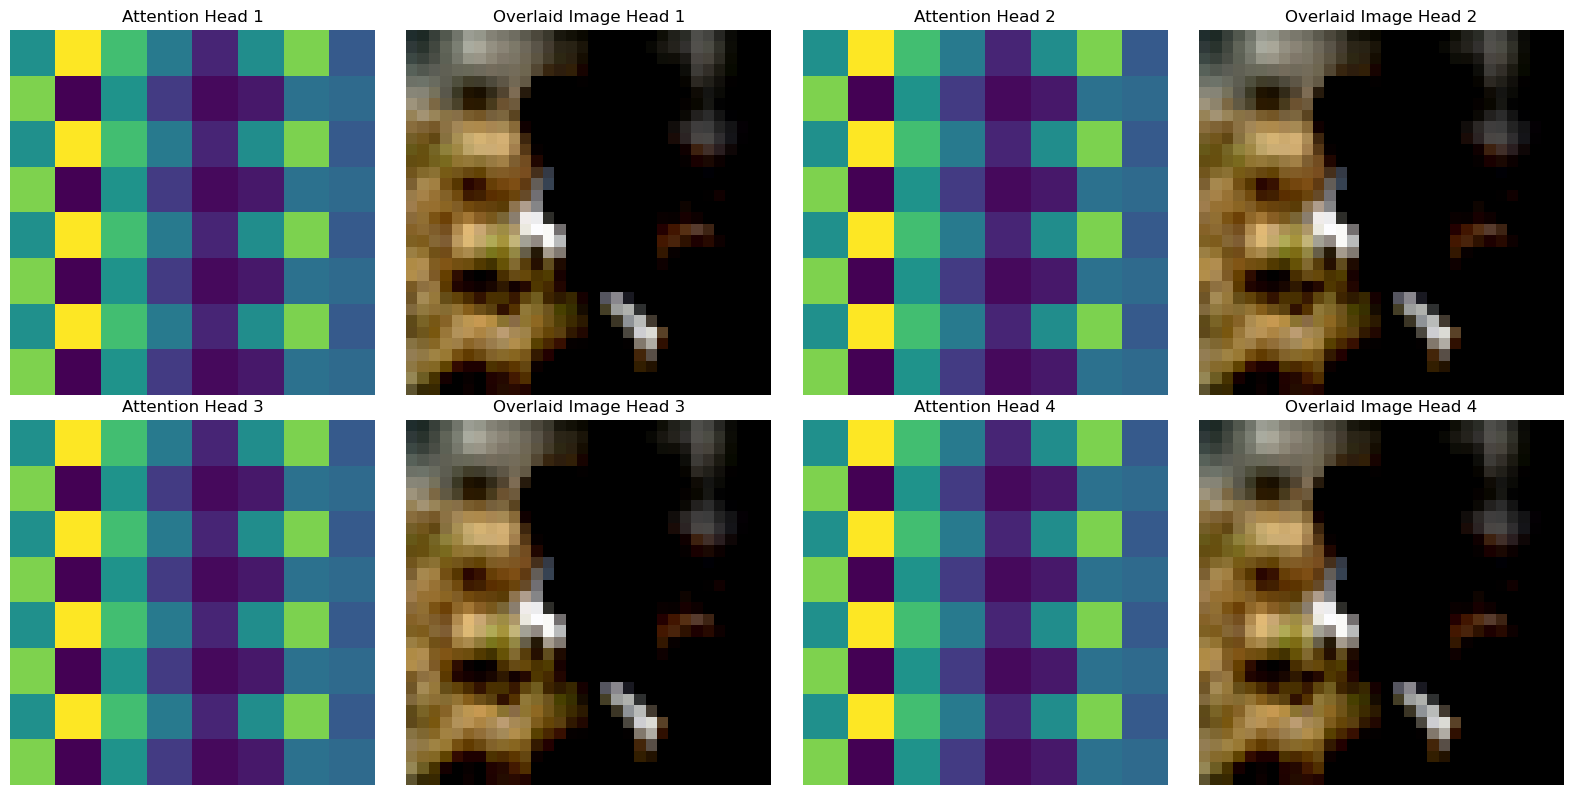

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


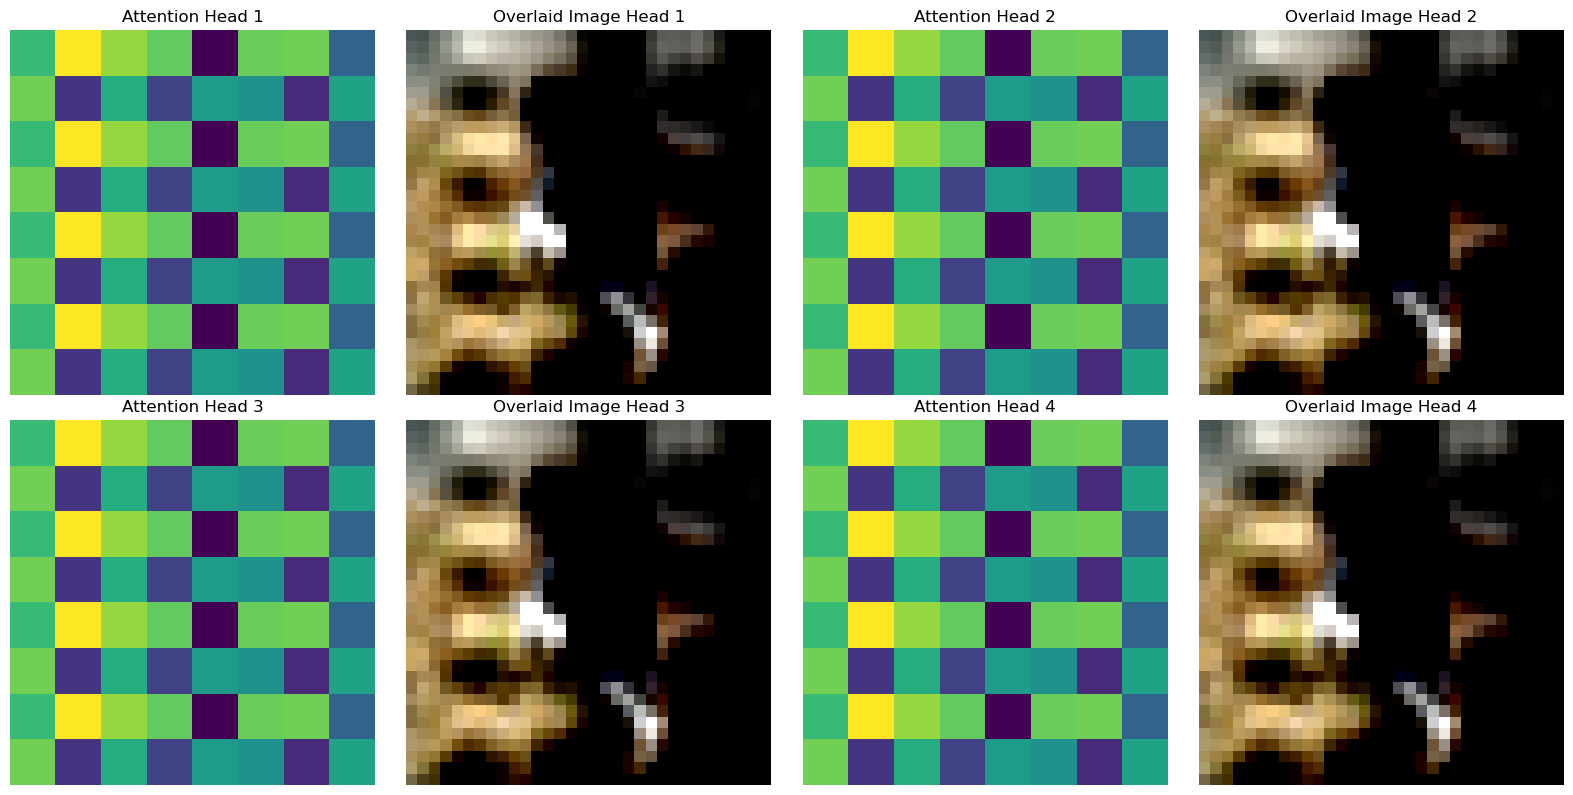

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


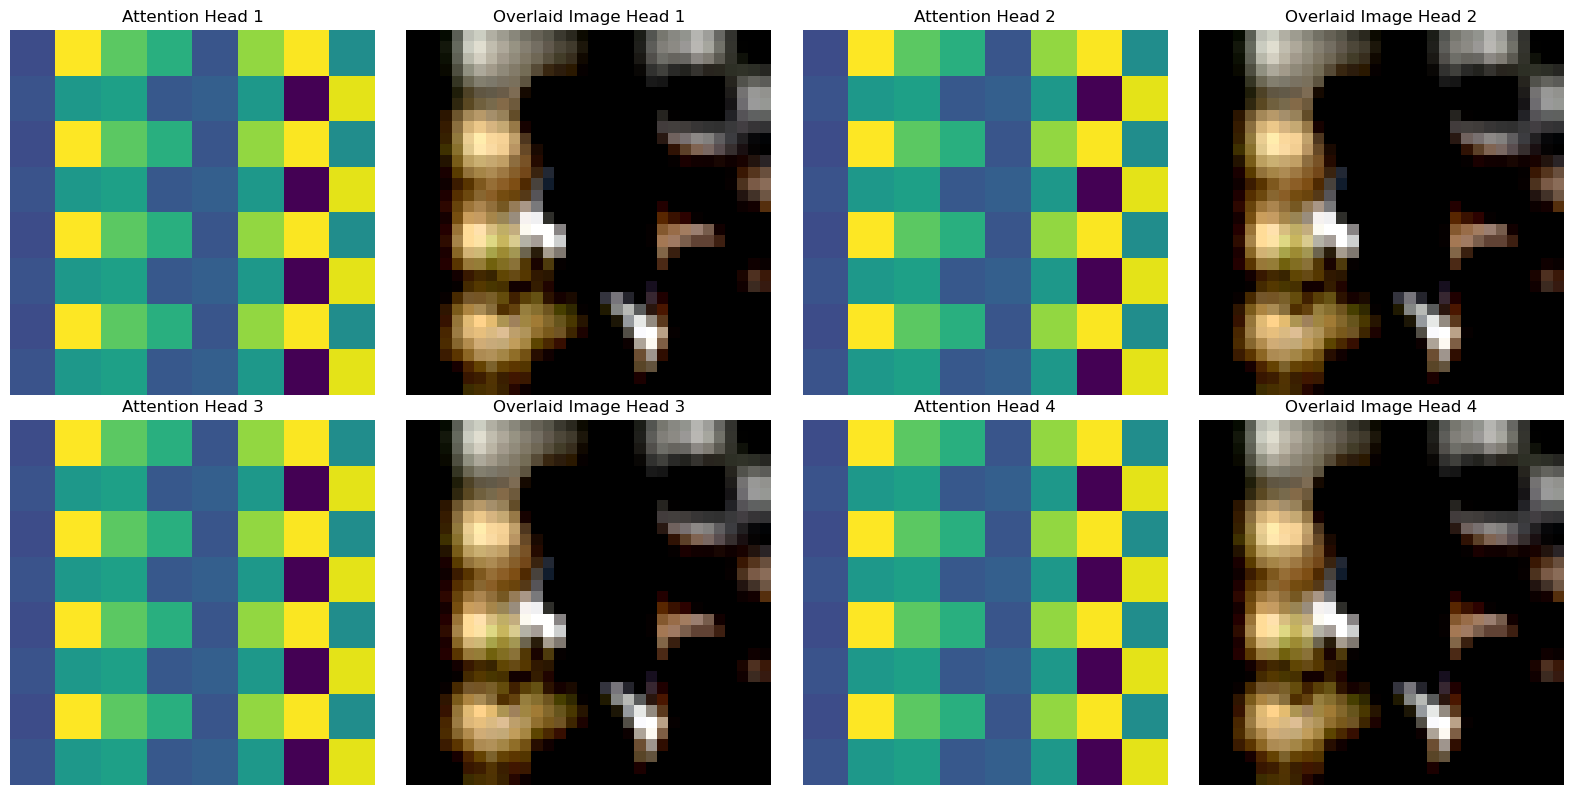

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


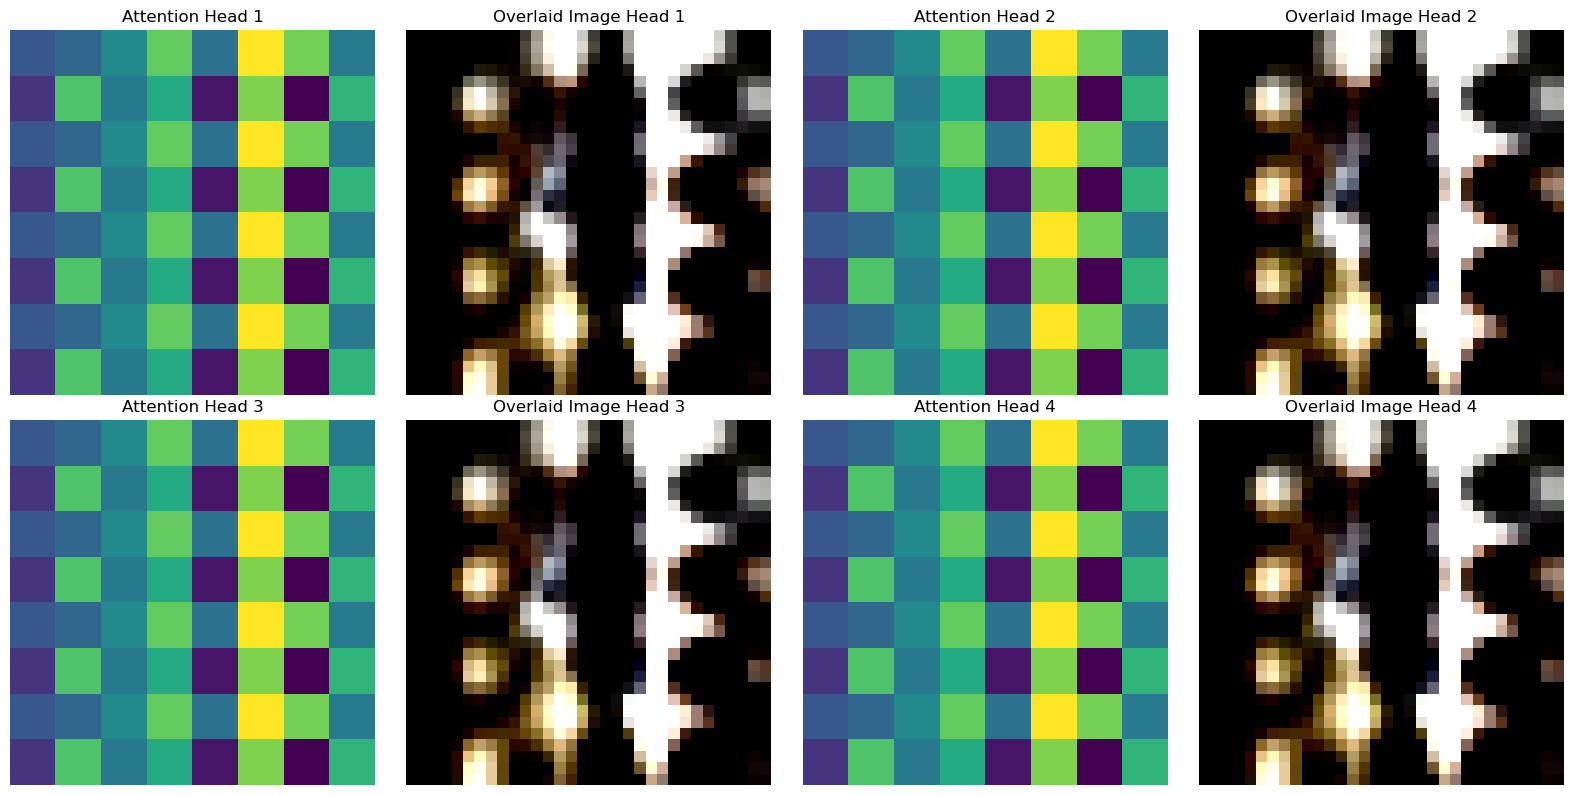

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


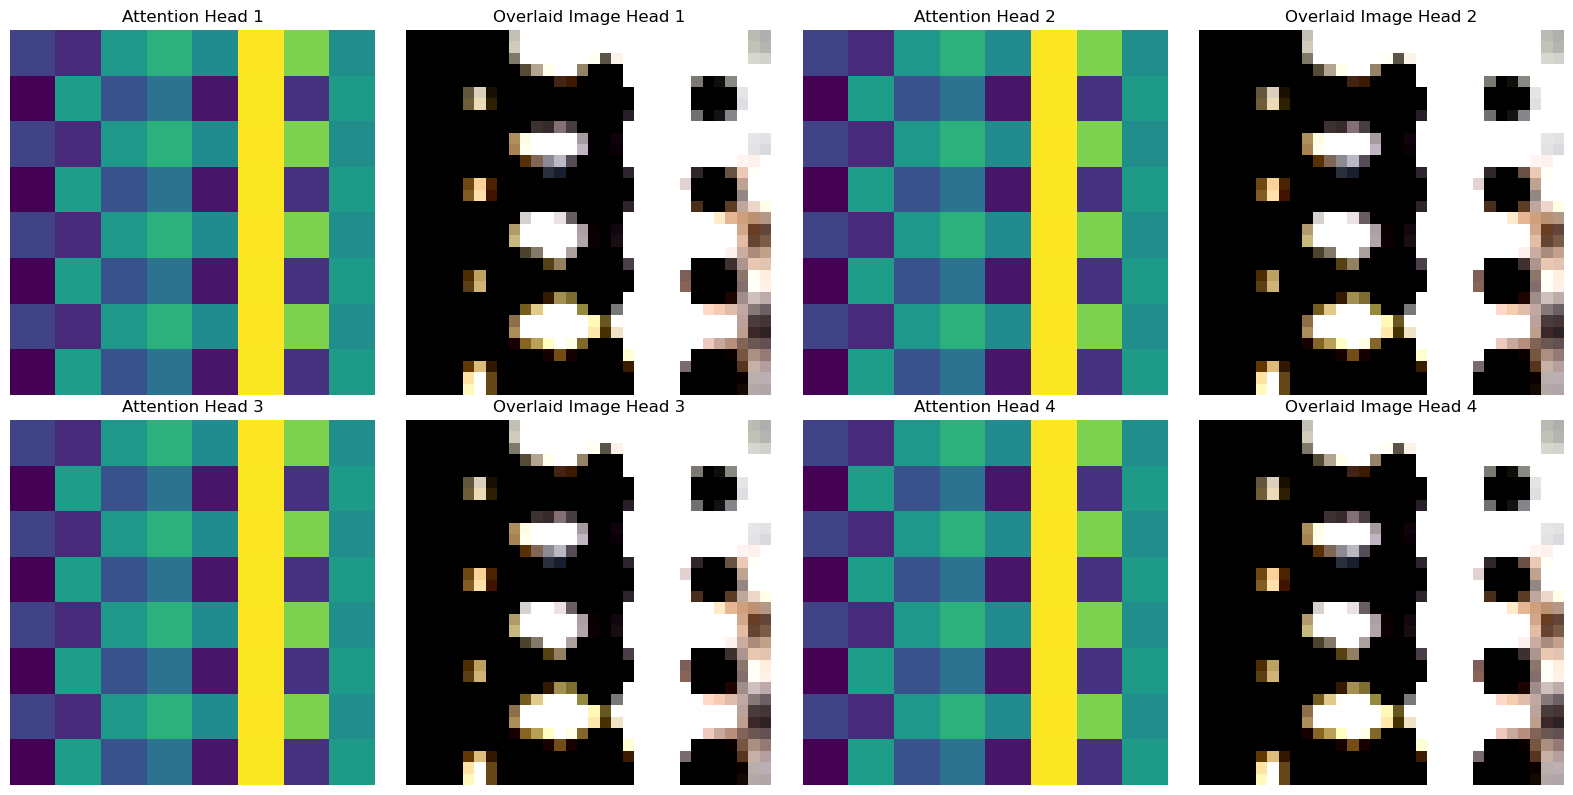

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class: 7


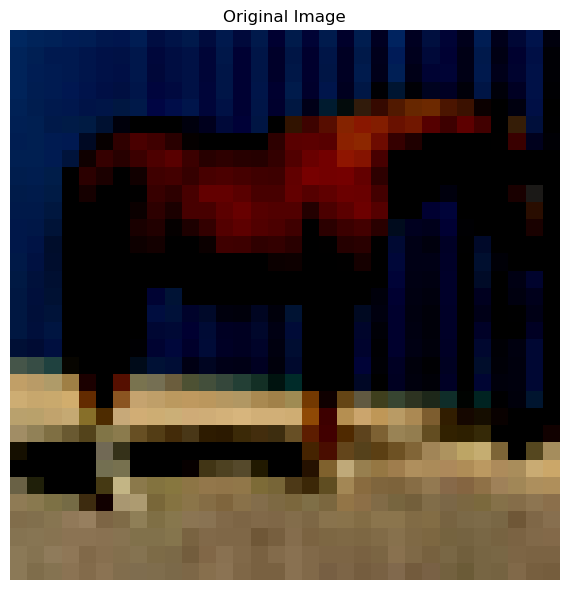

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


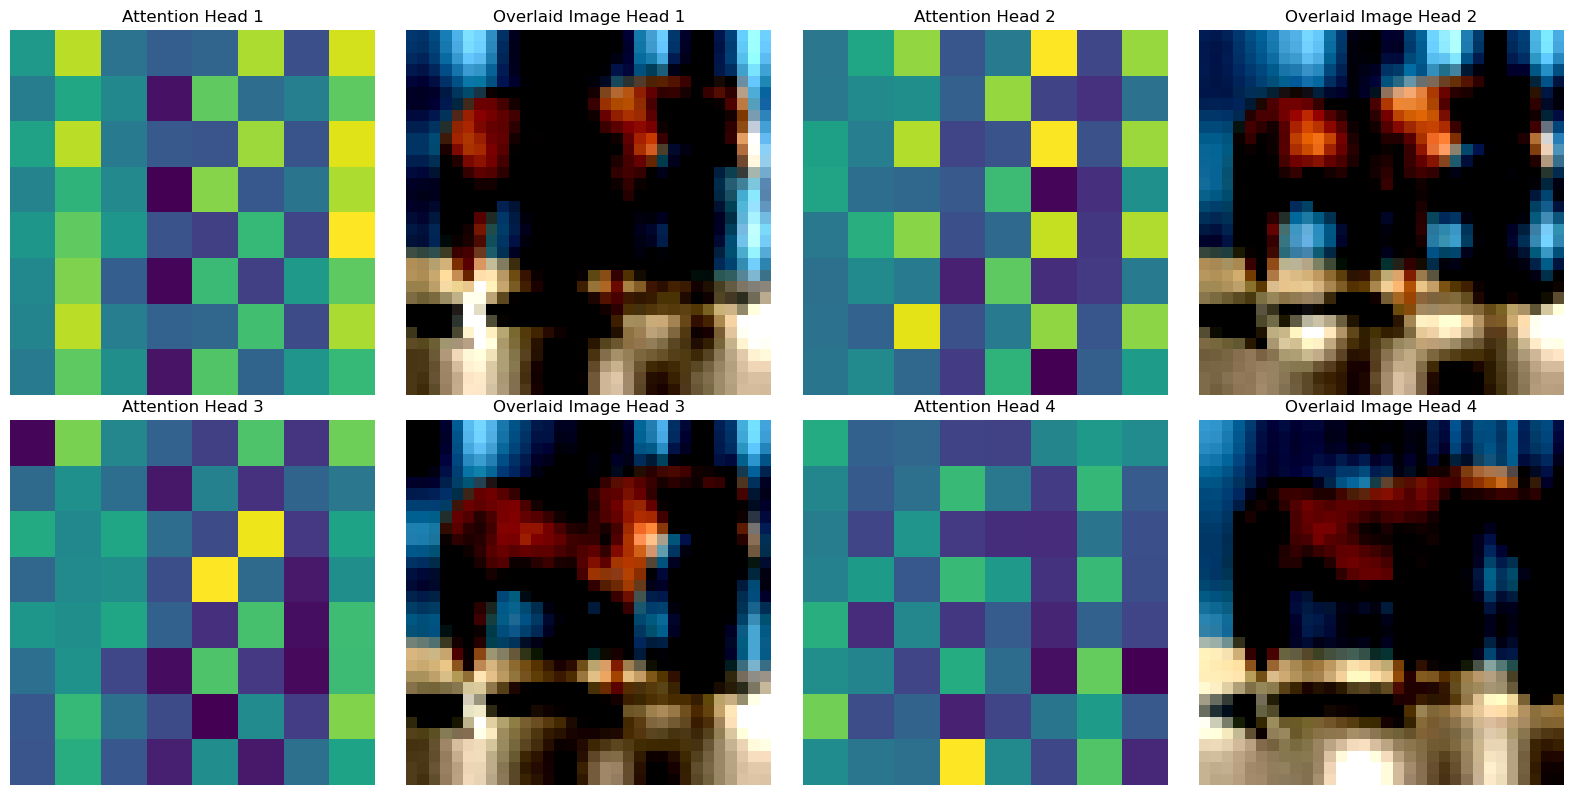

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


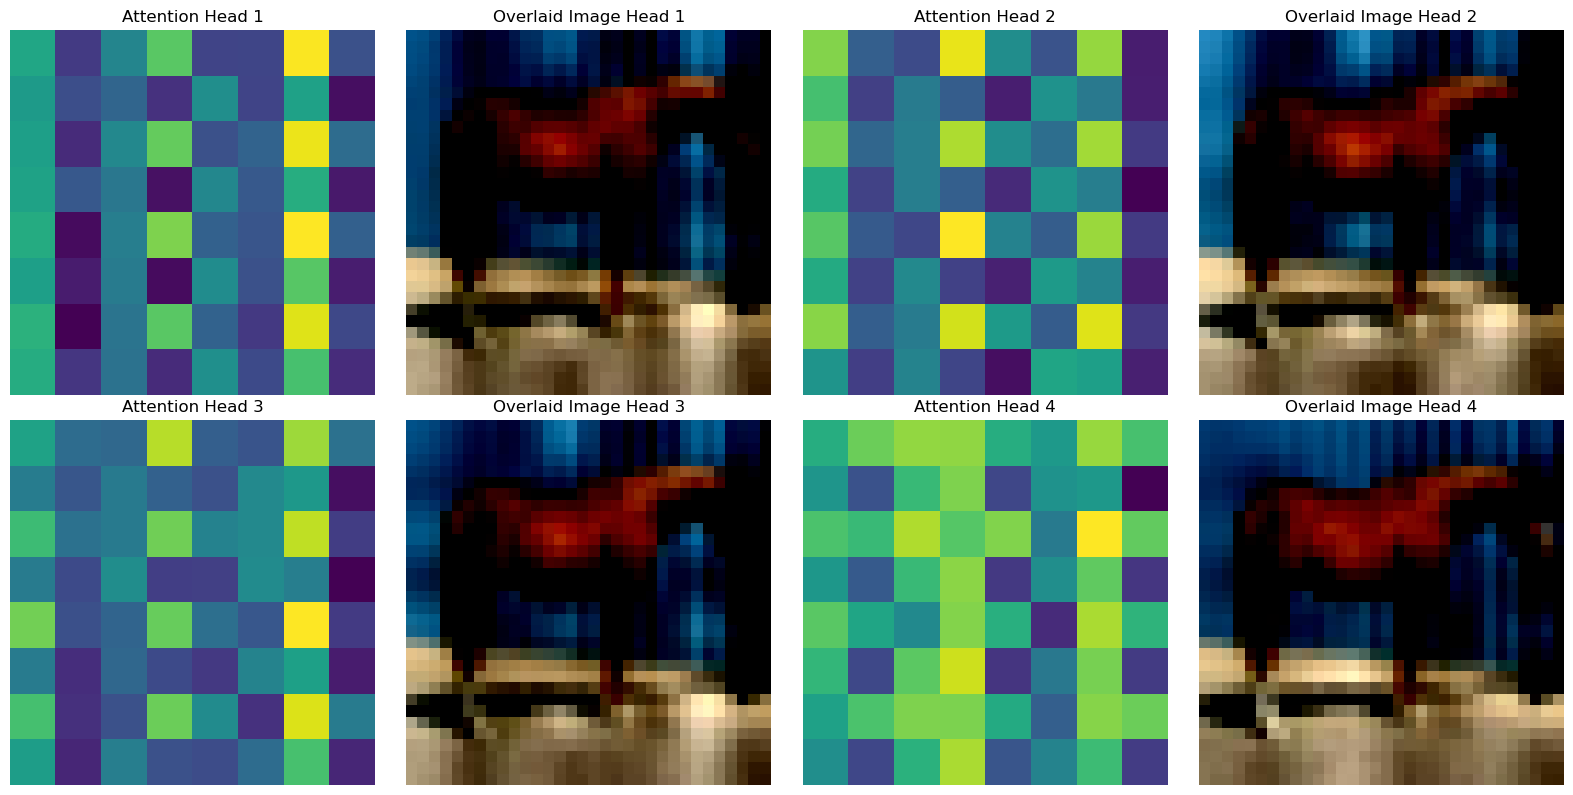

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


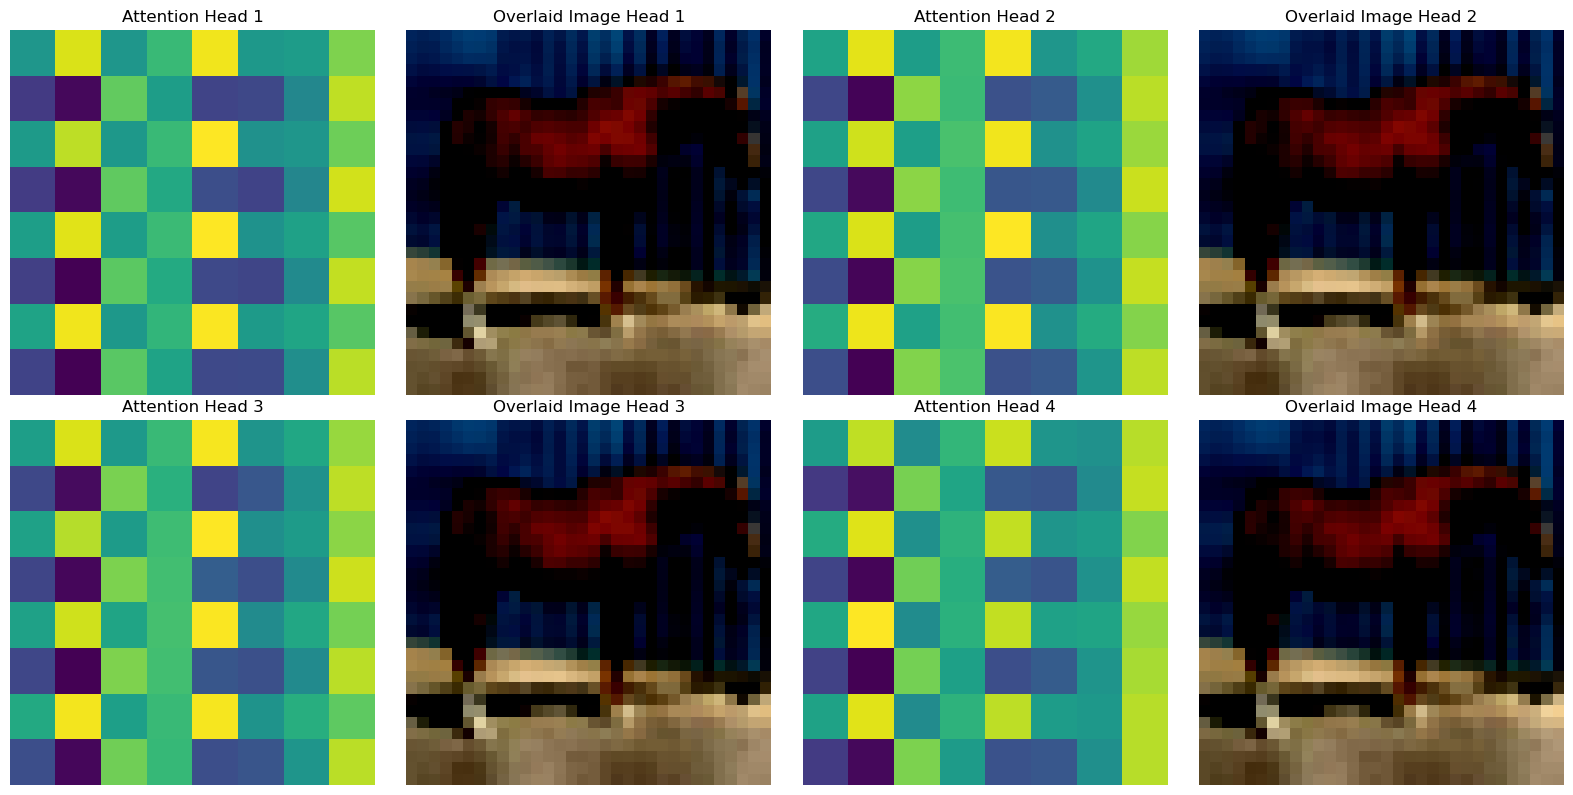

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


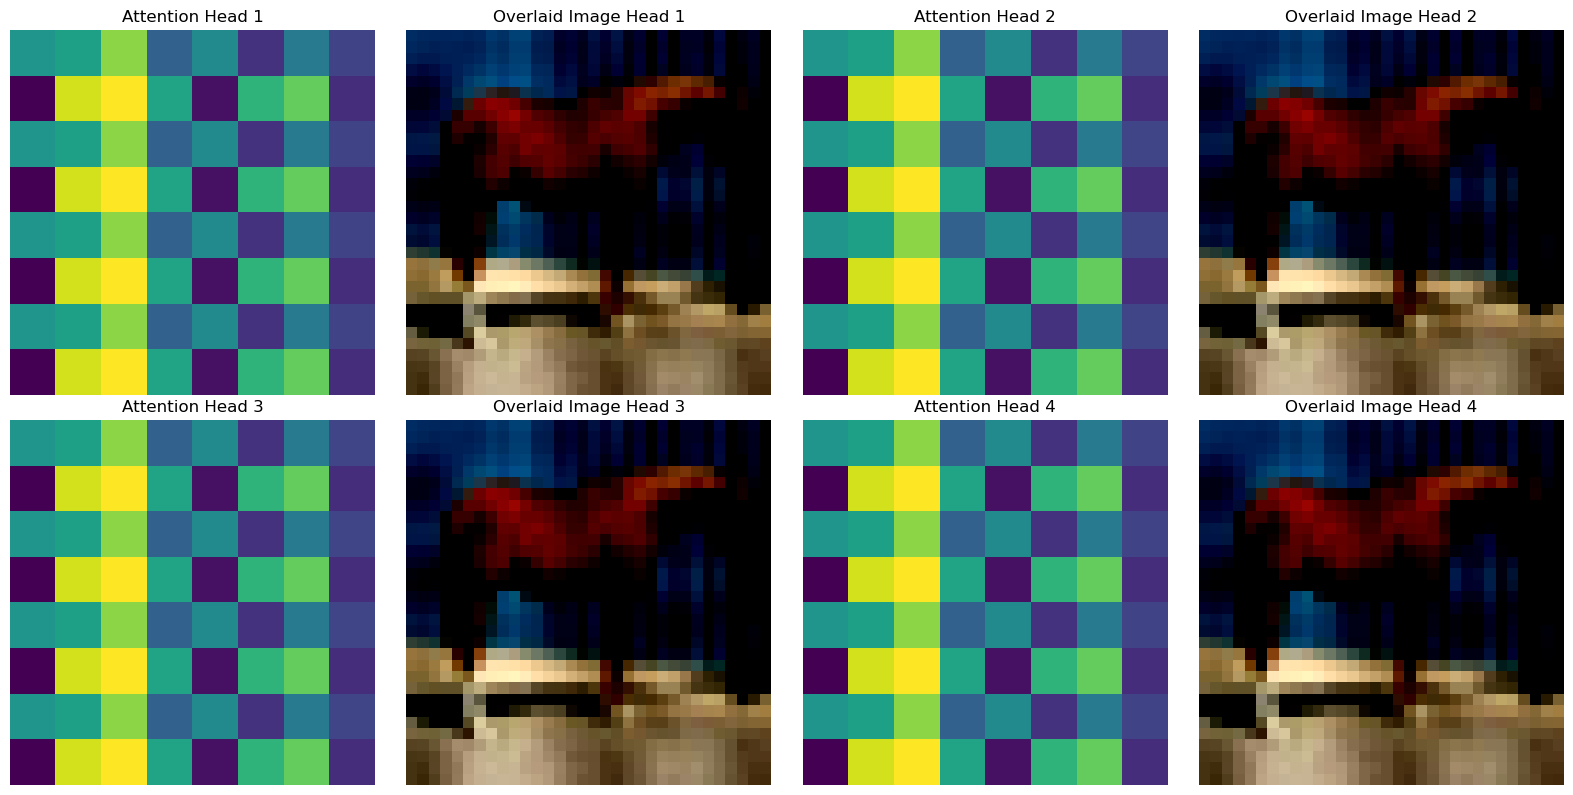

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


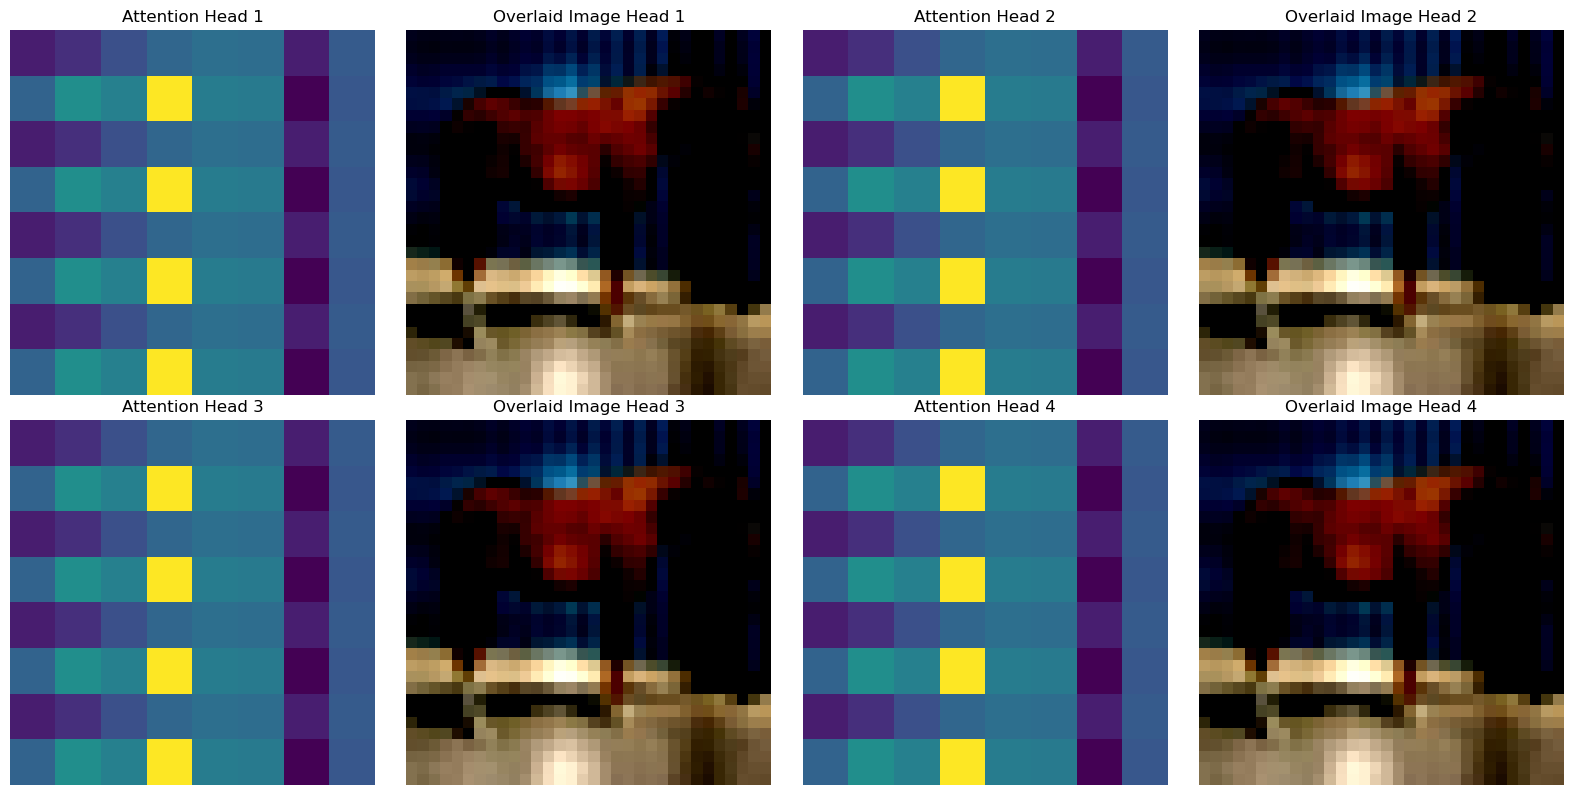

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


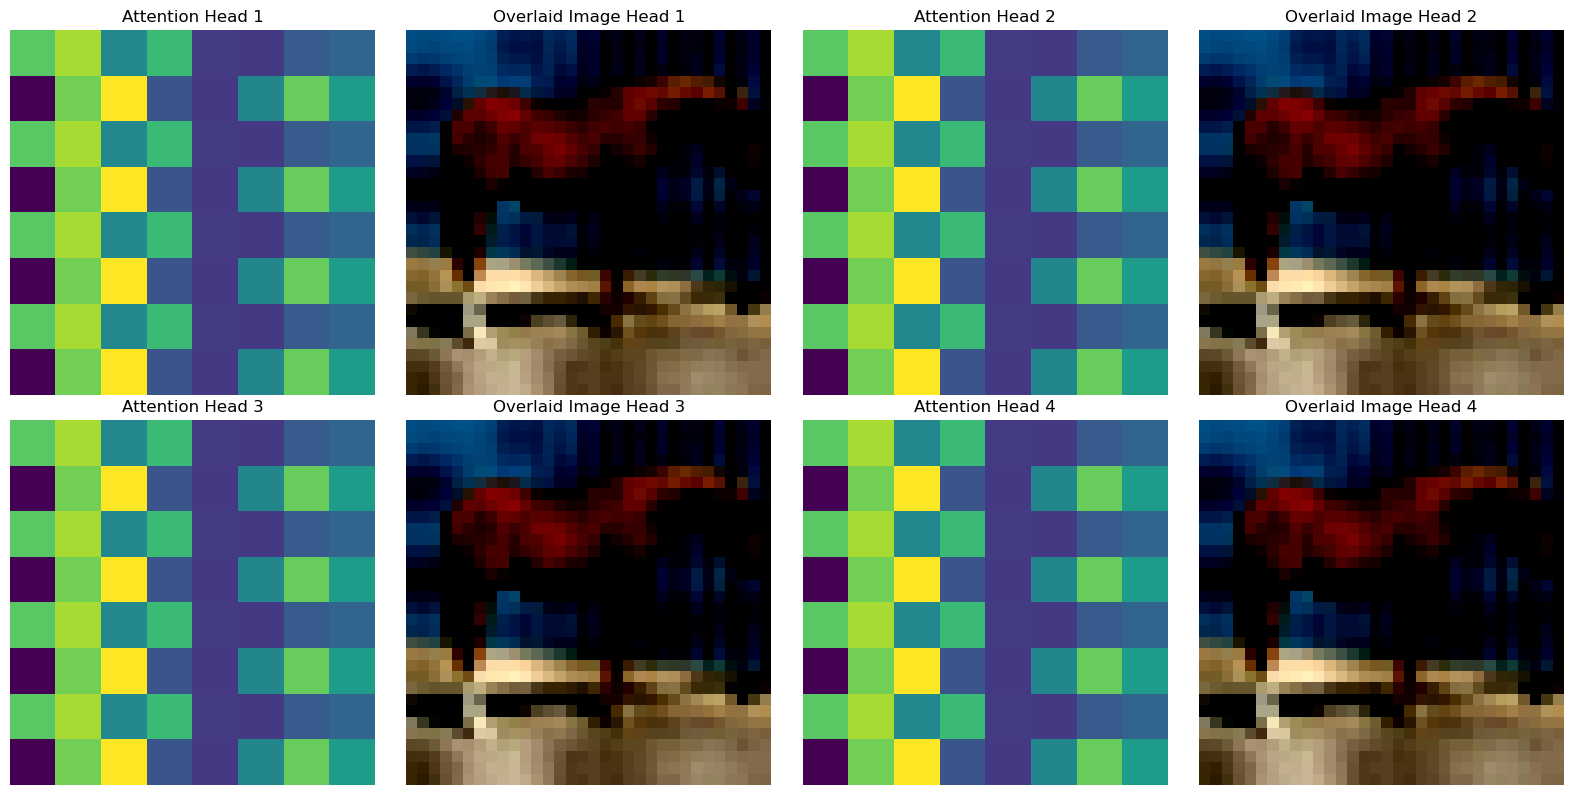

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


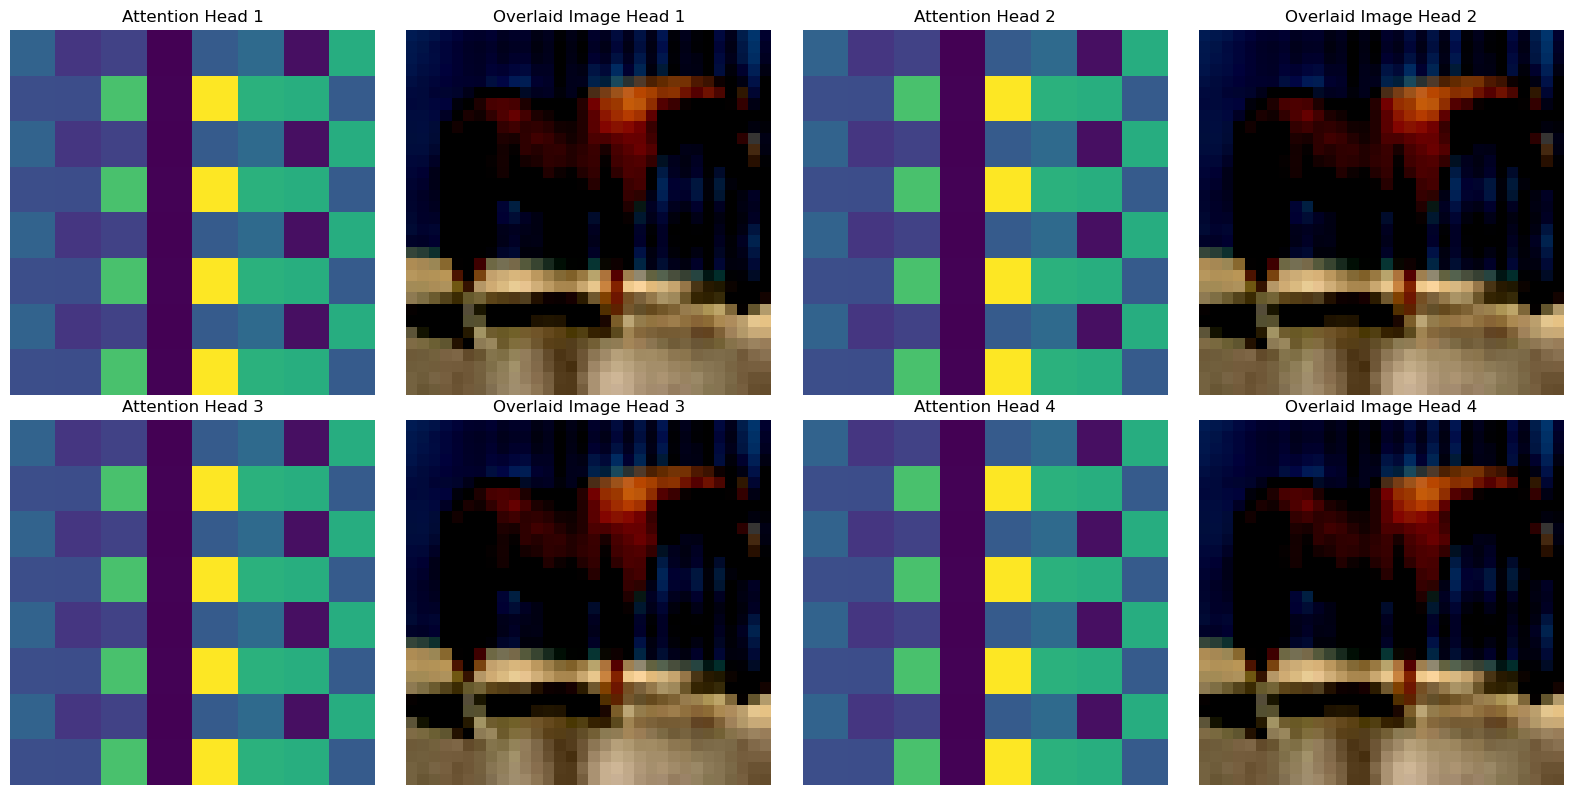

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


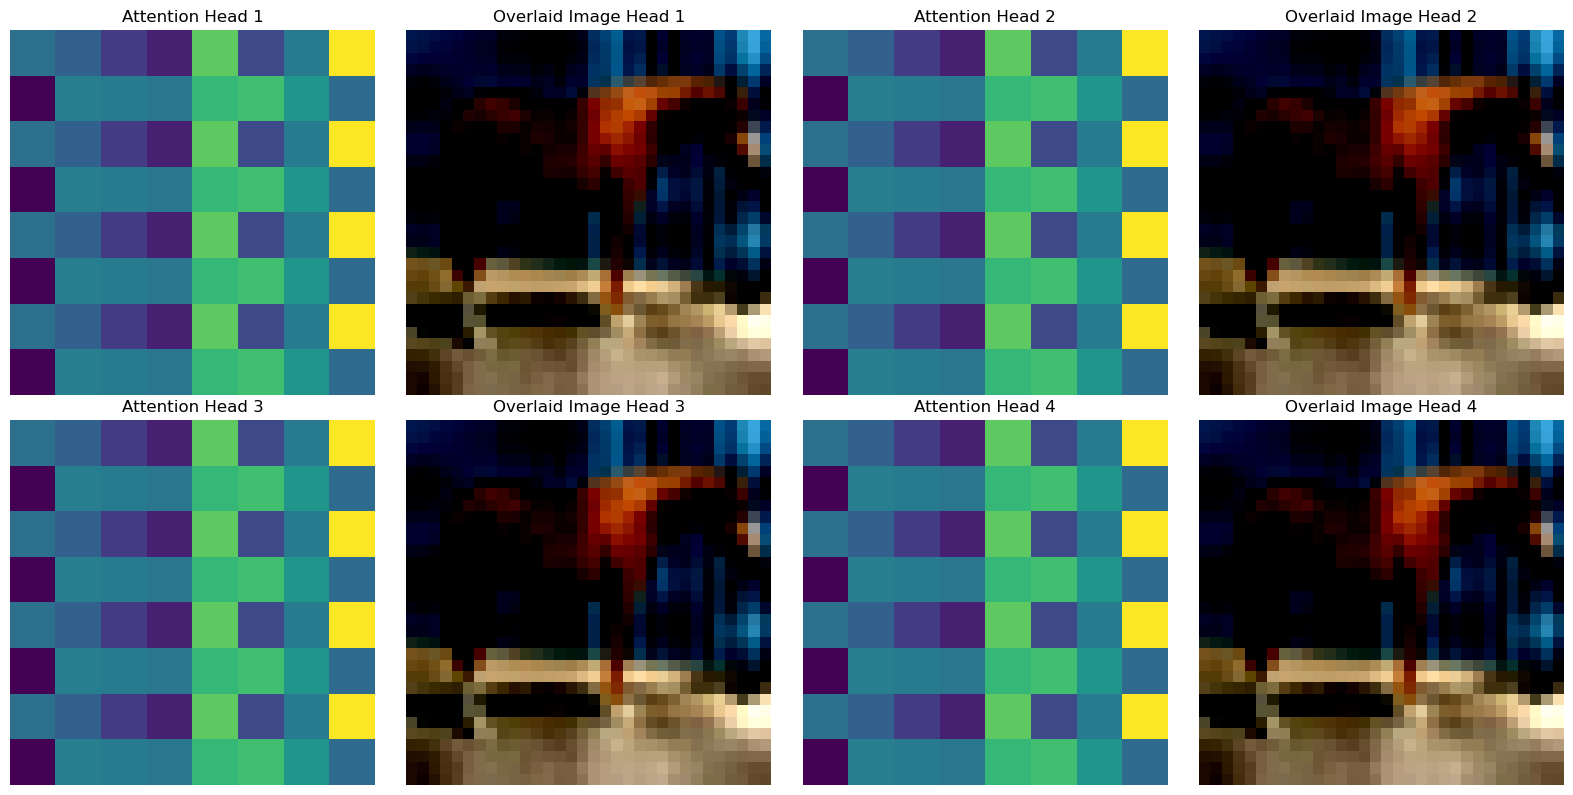

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


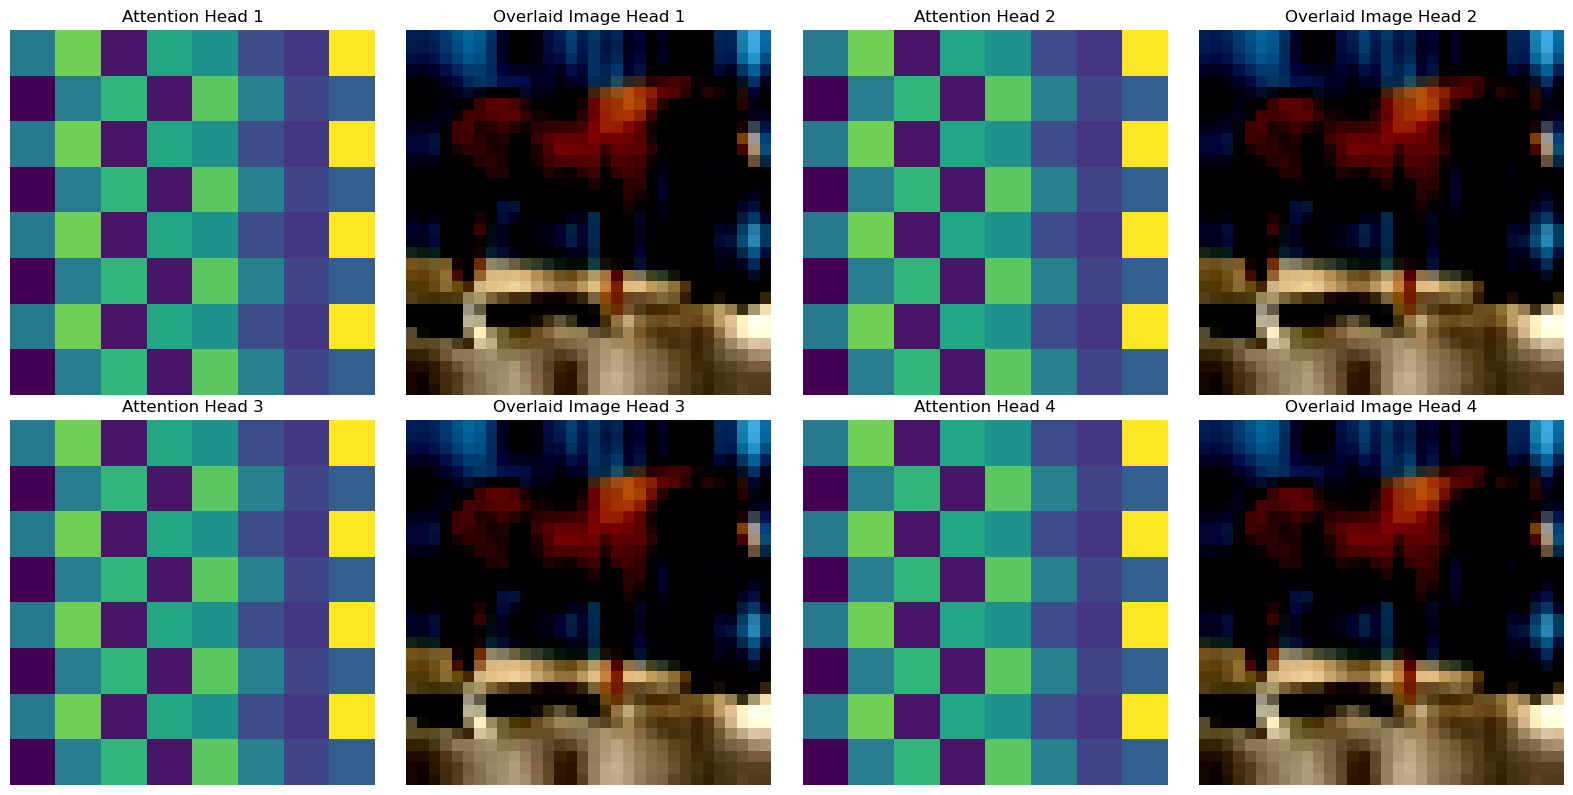

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


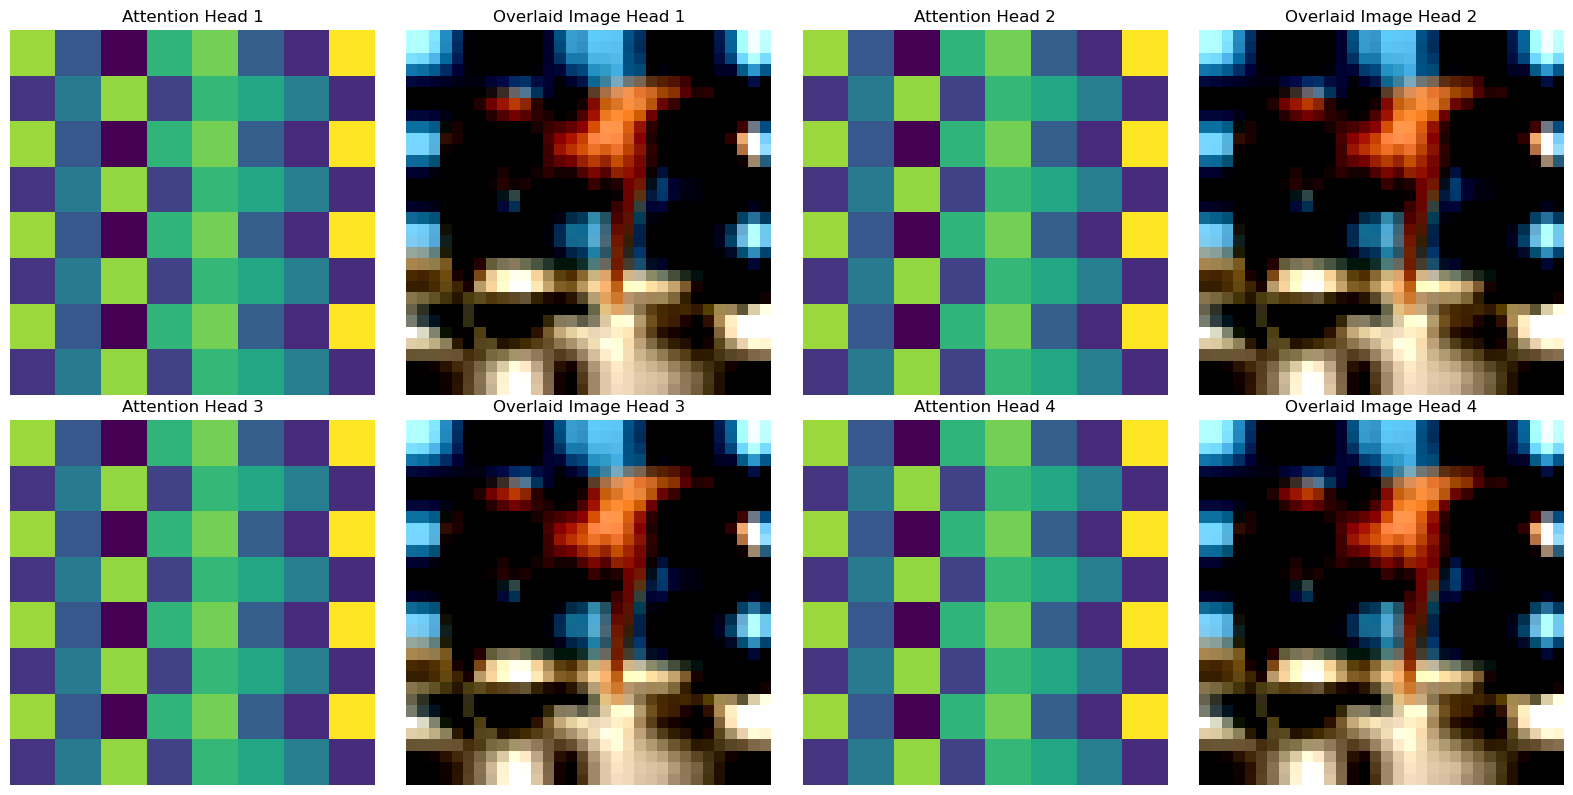

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


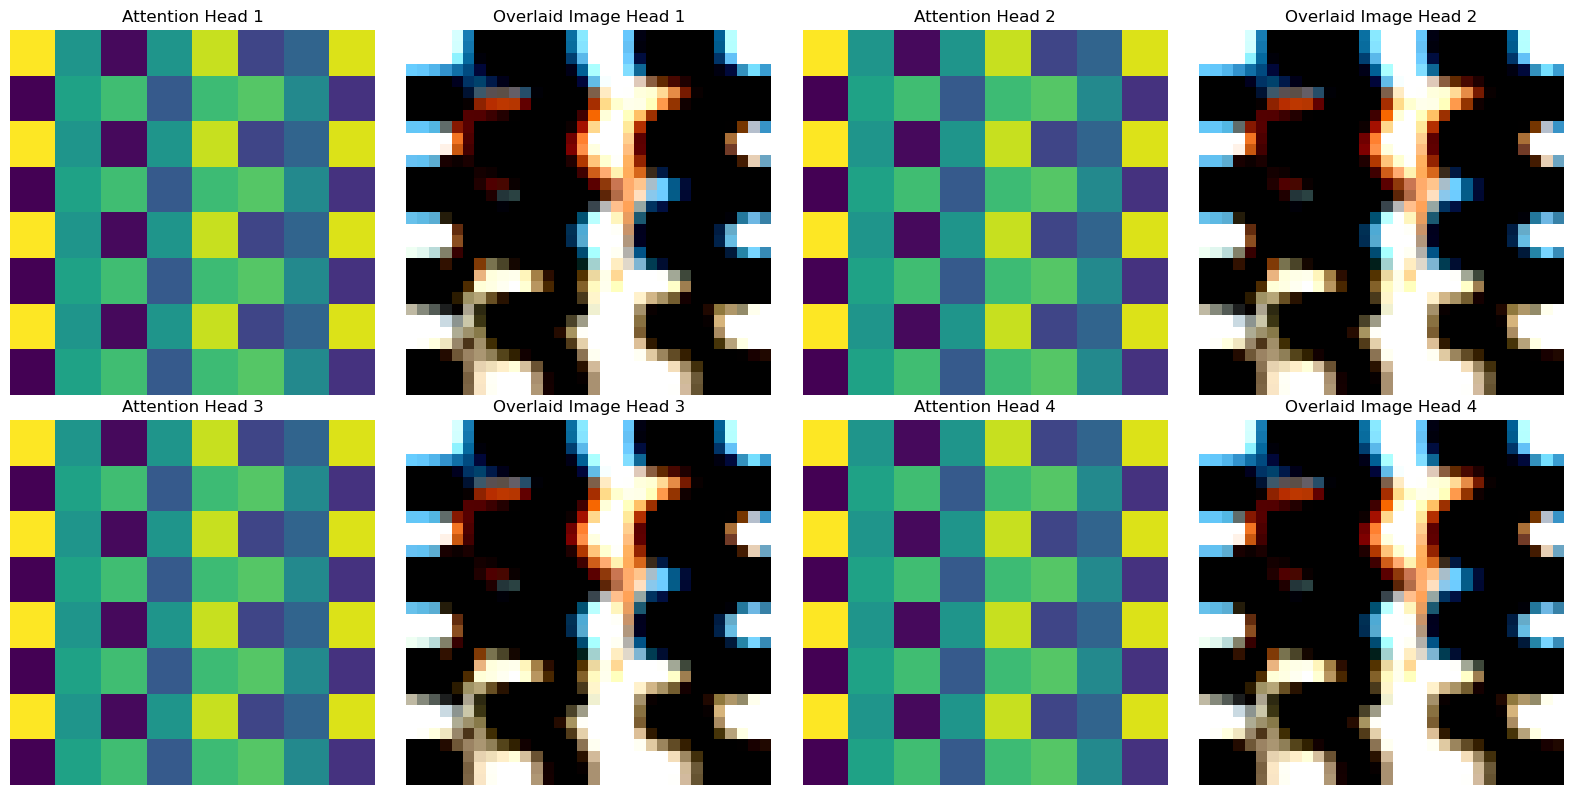

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


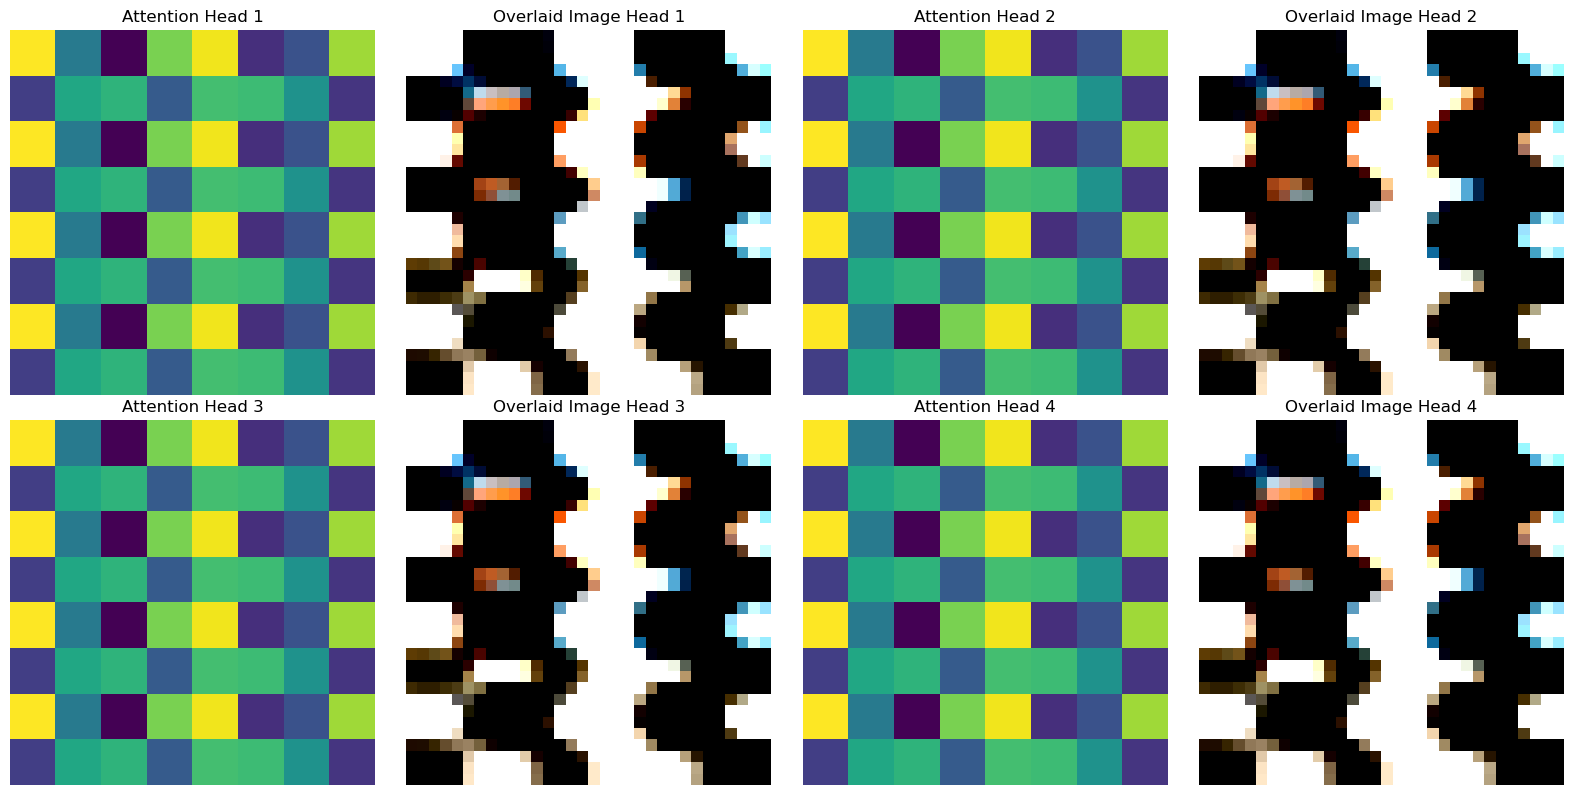

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class: 8


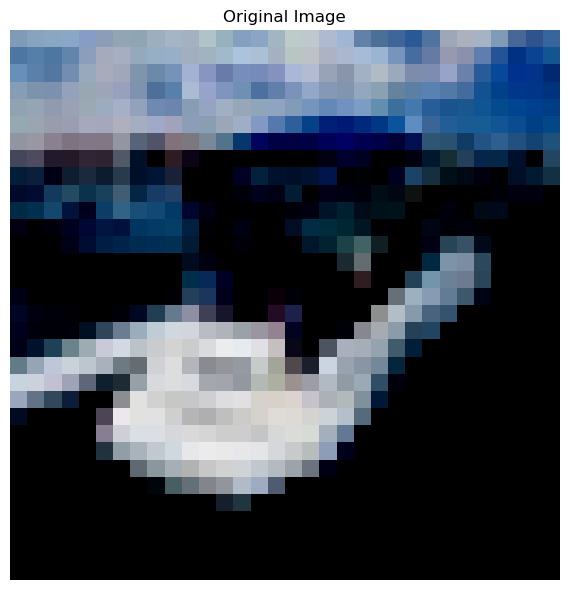

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


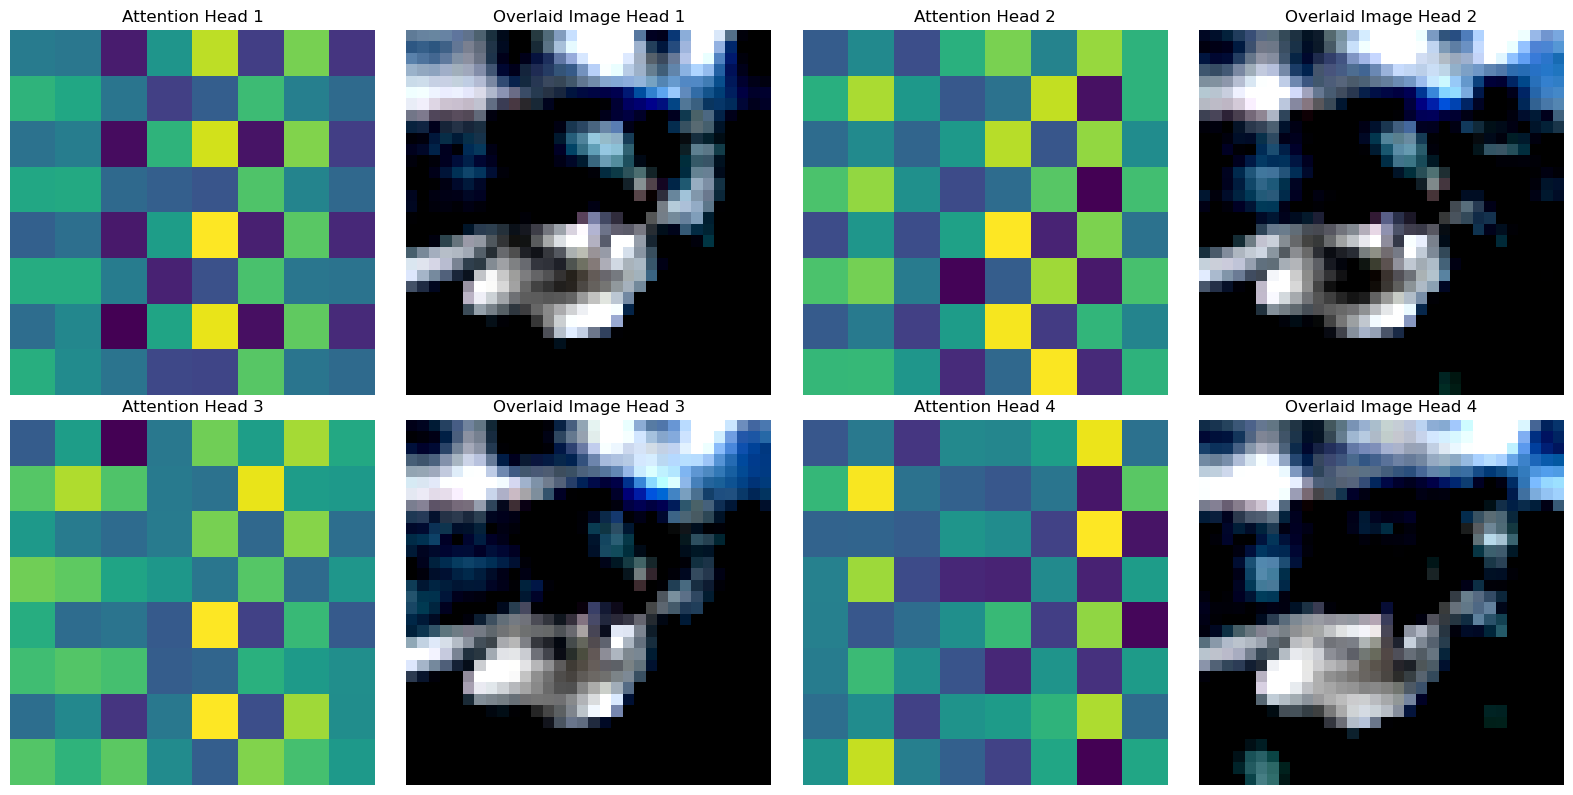

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


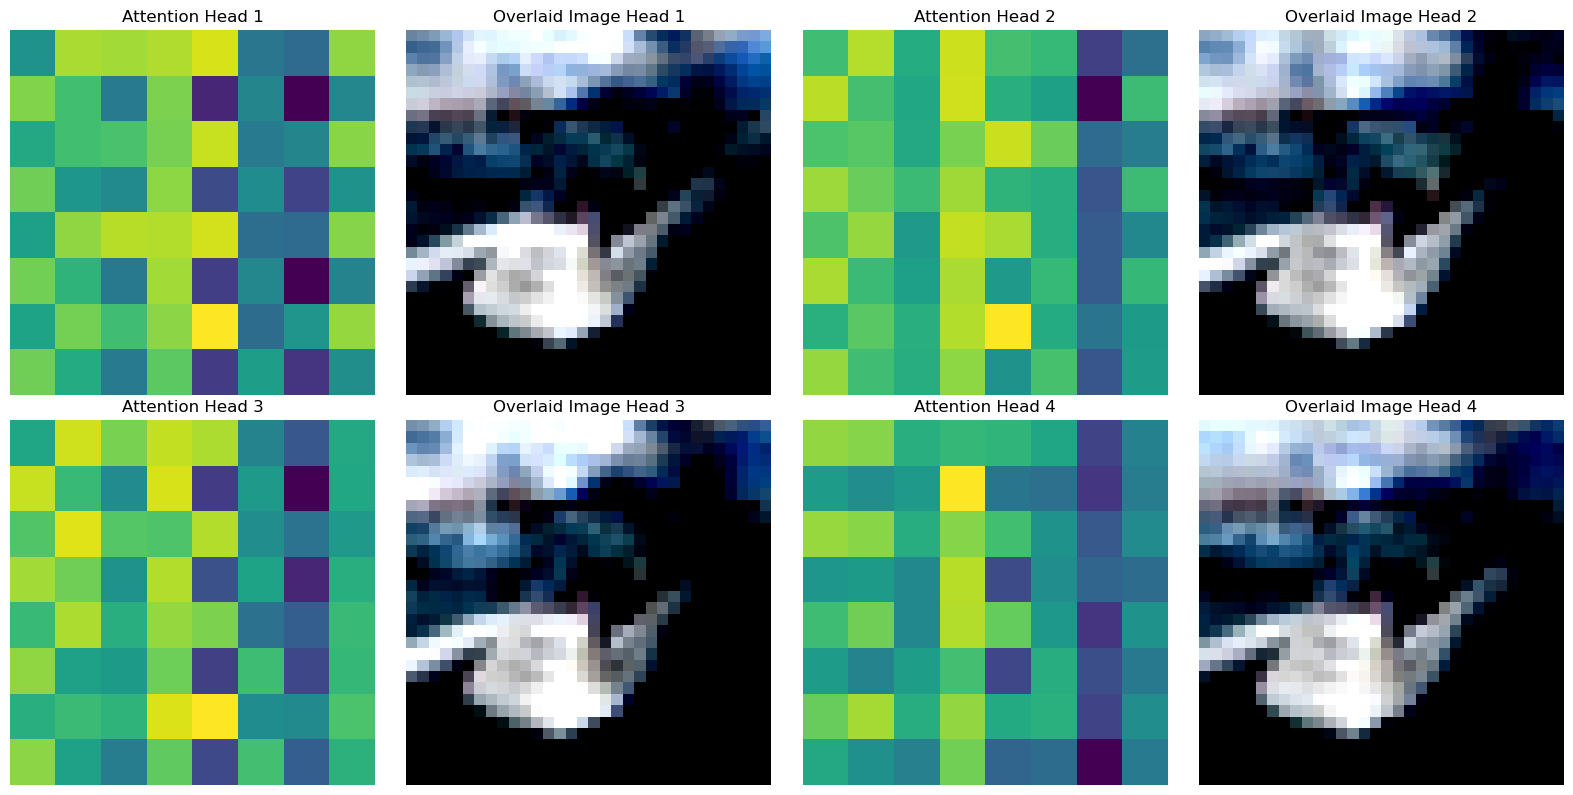

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


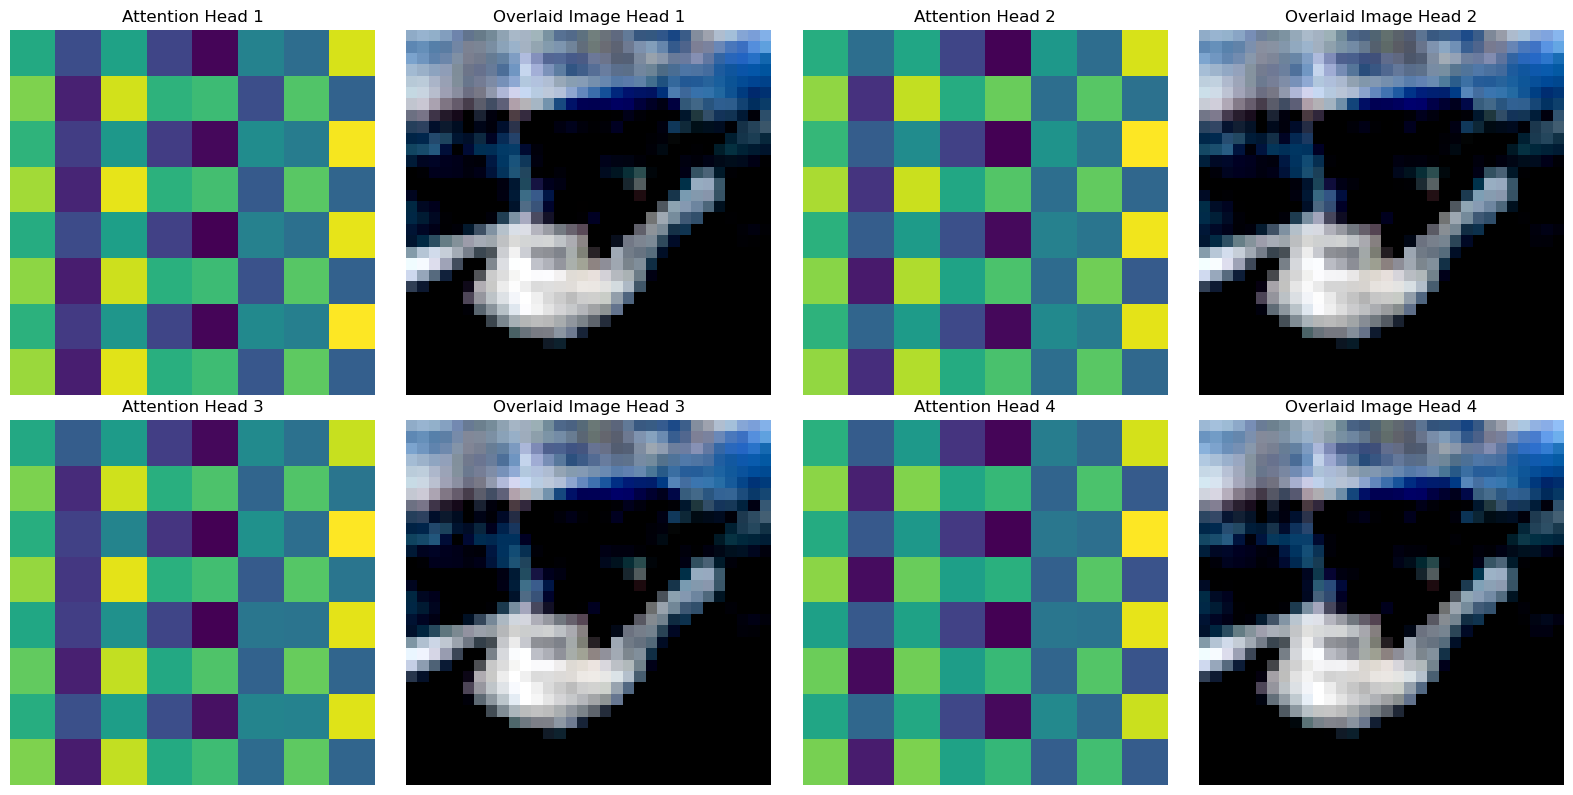

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


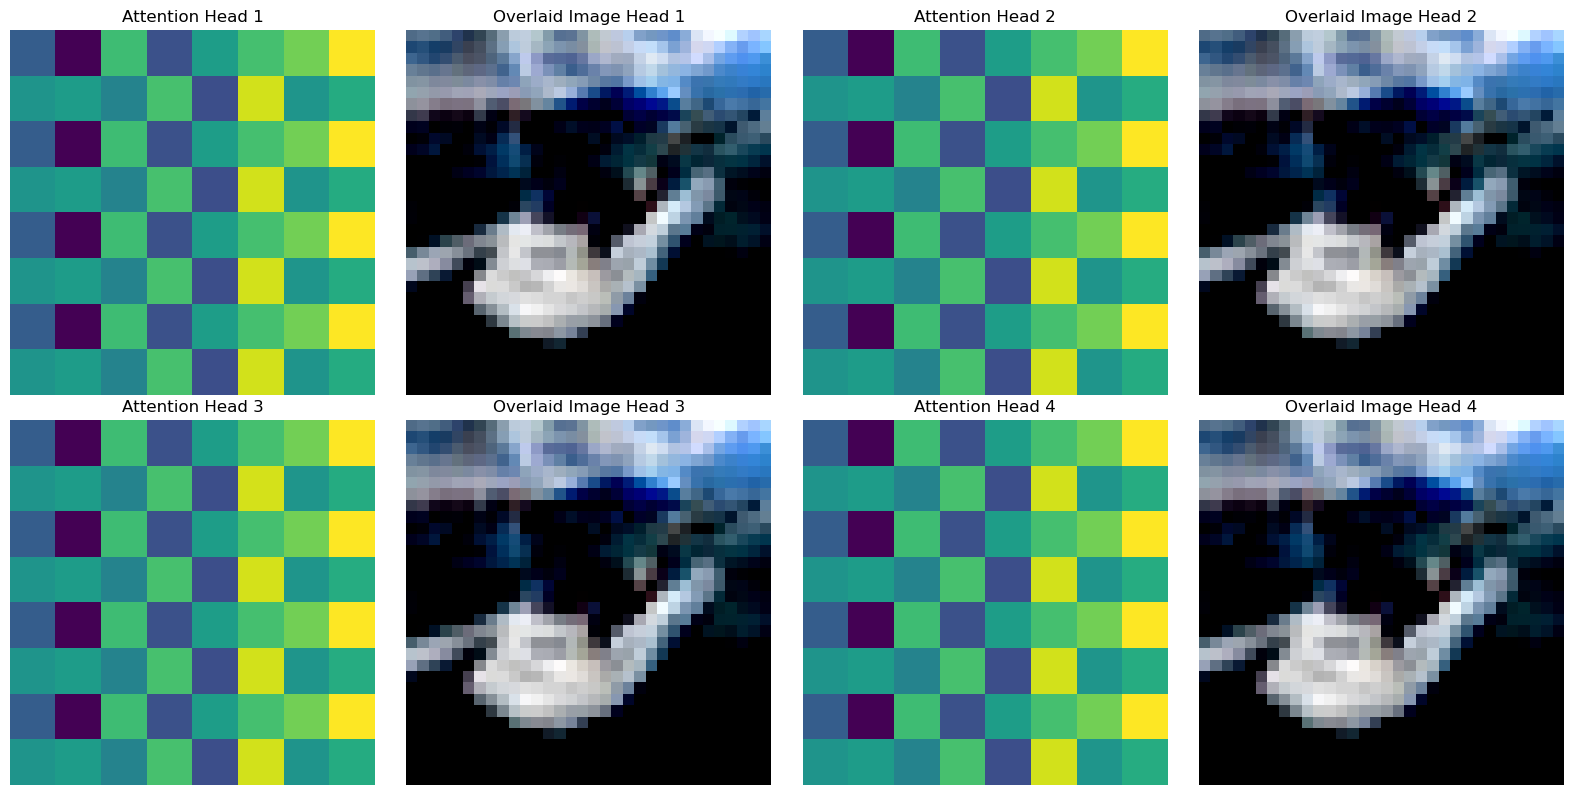

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


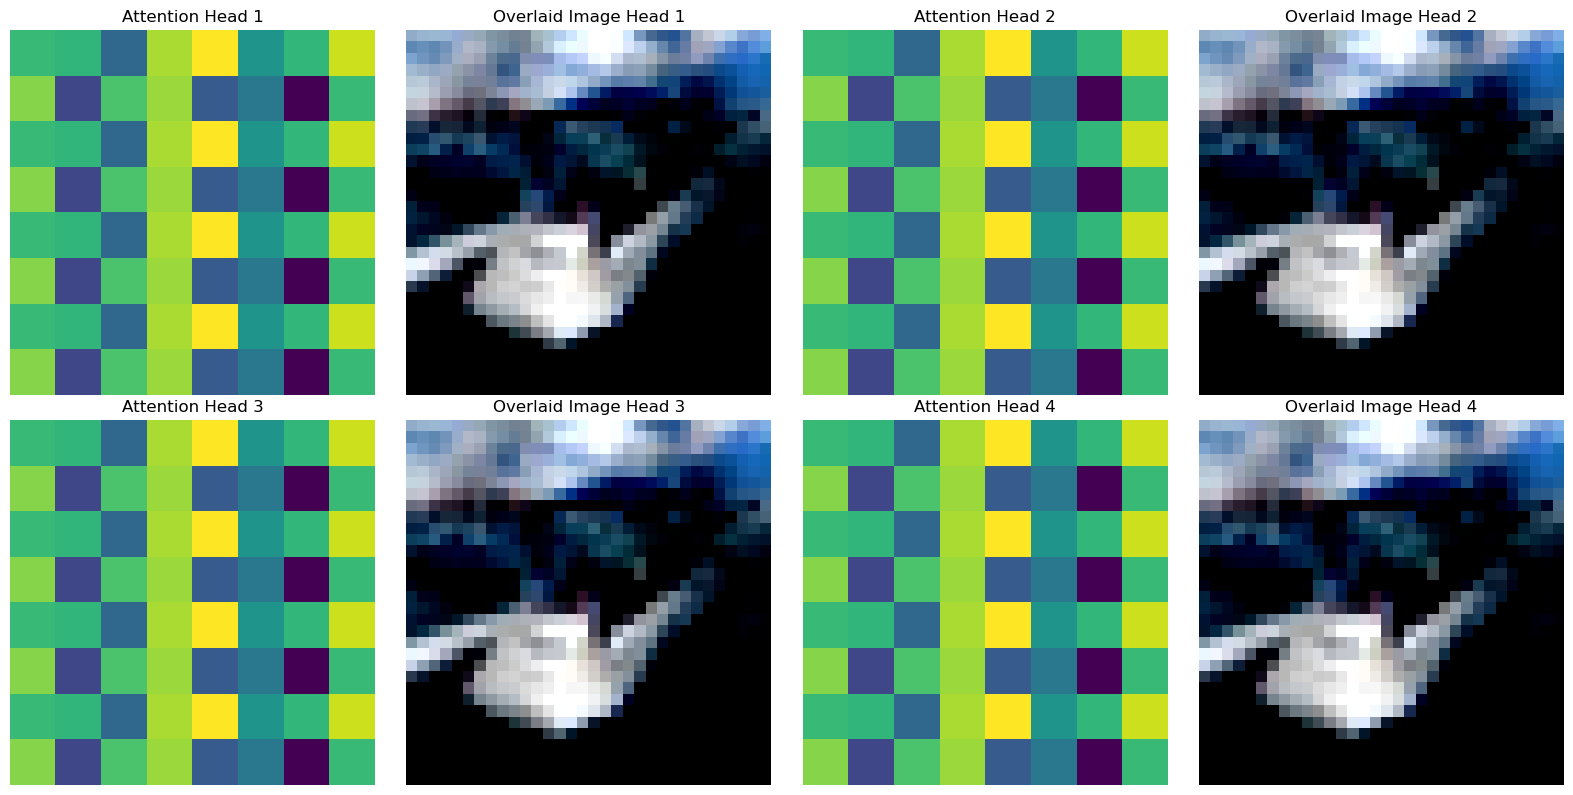

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


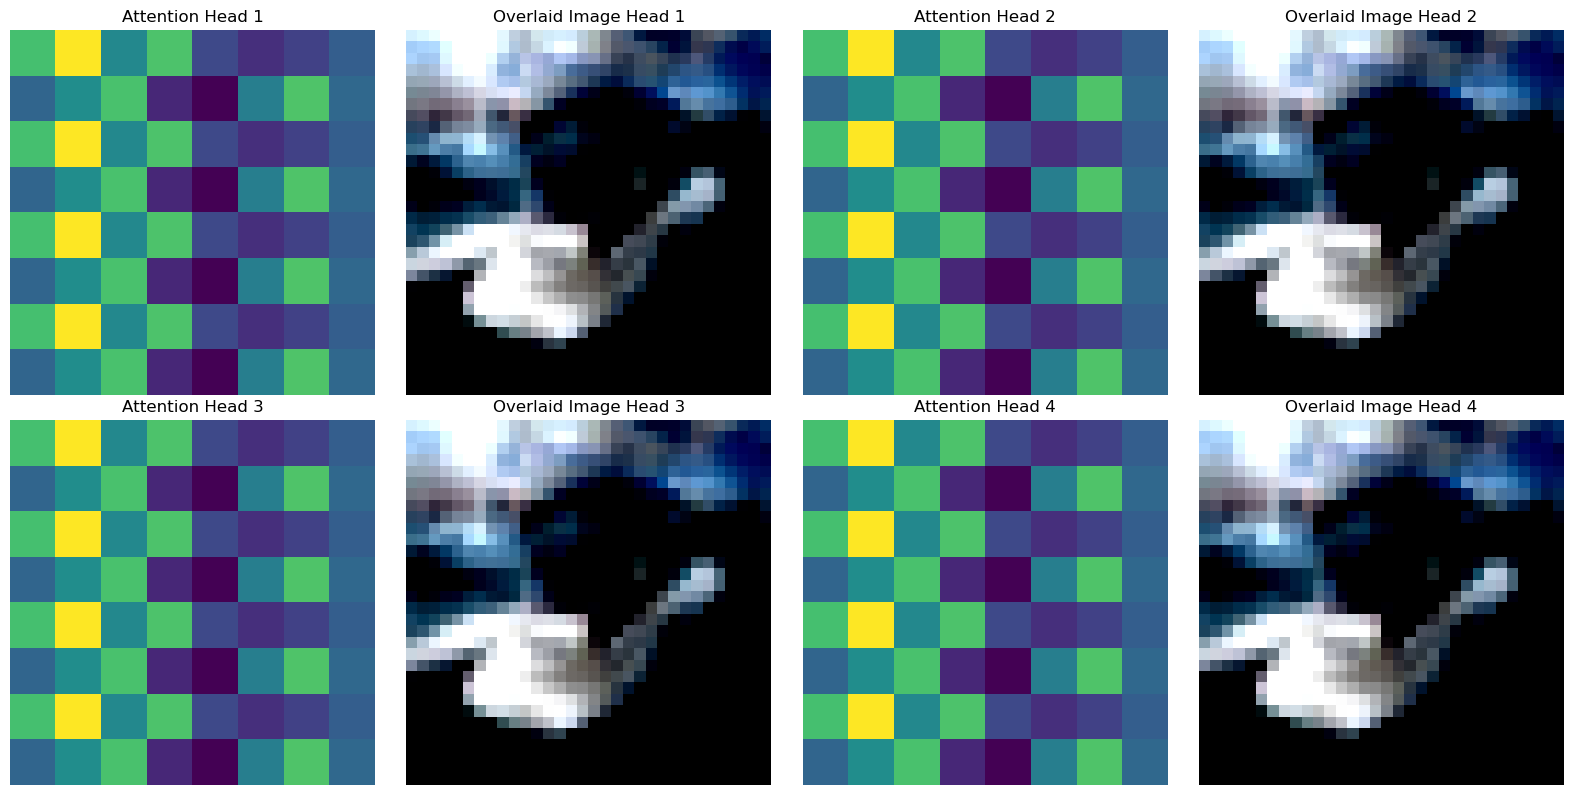

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


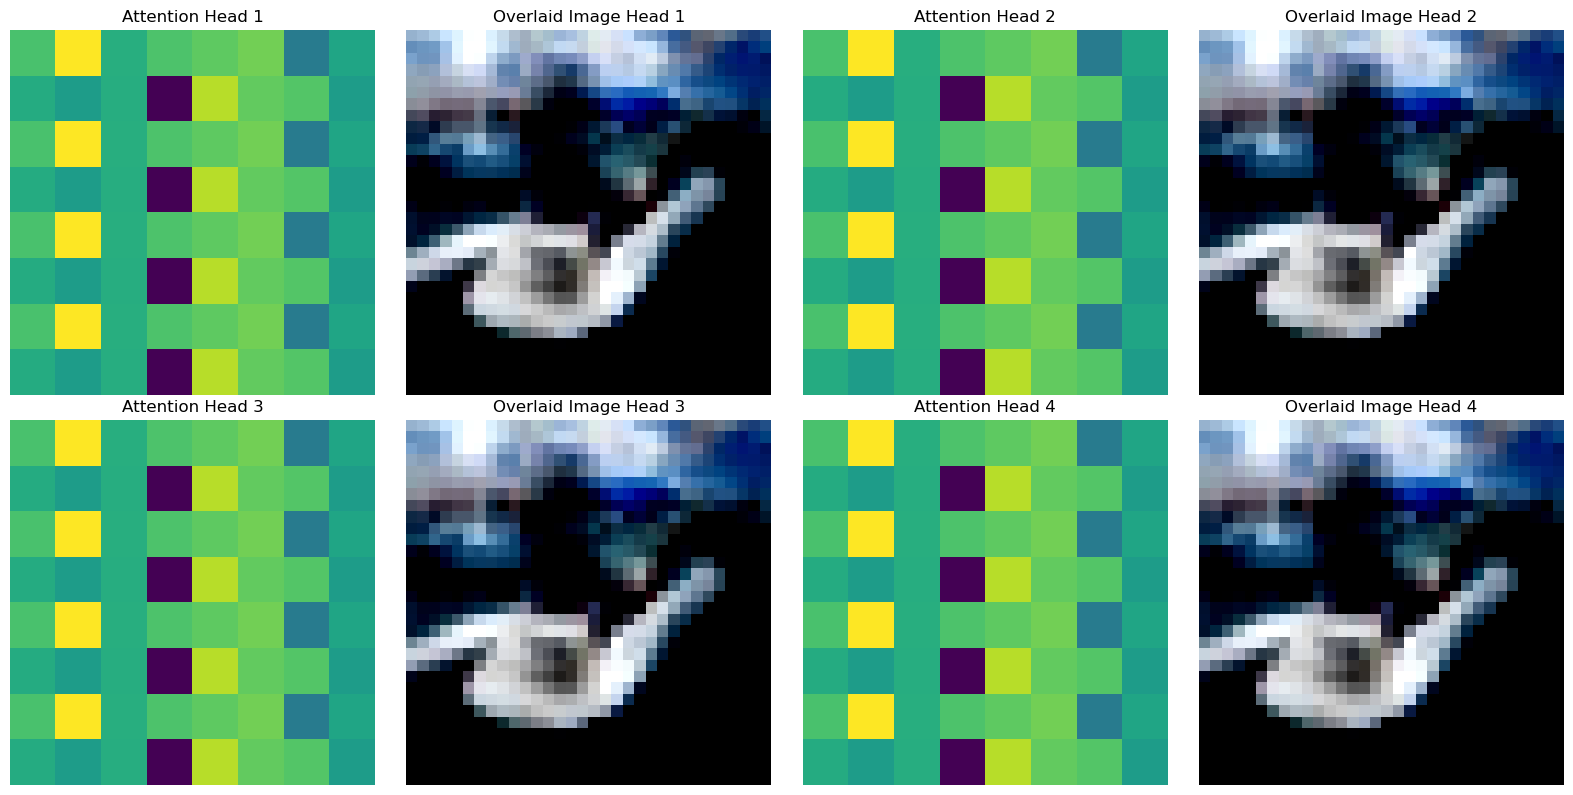

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


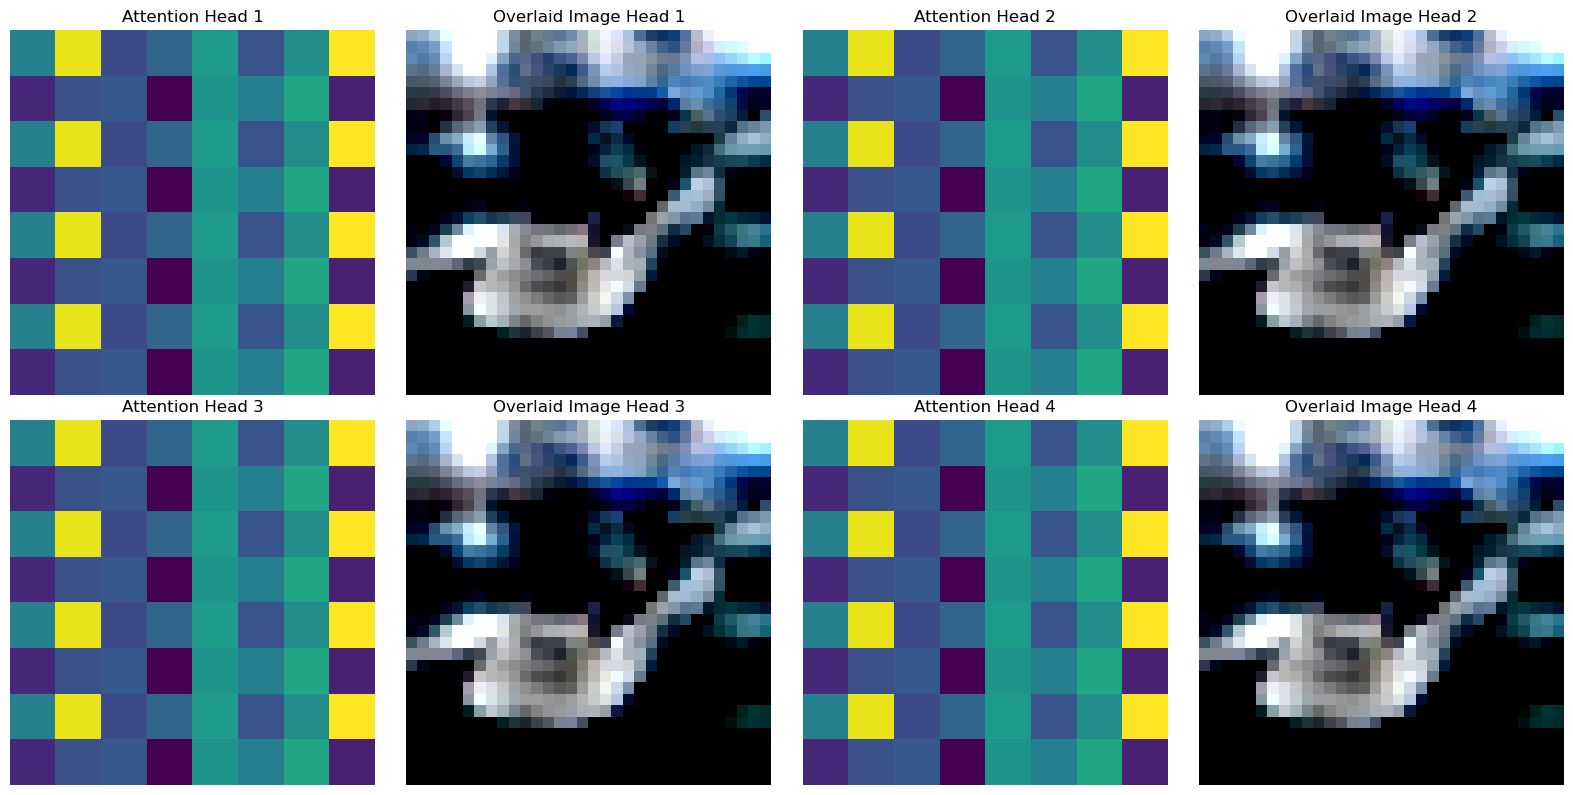

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


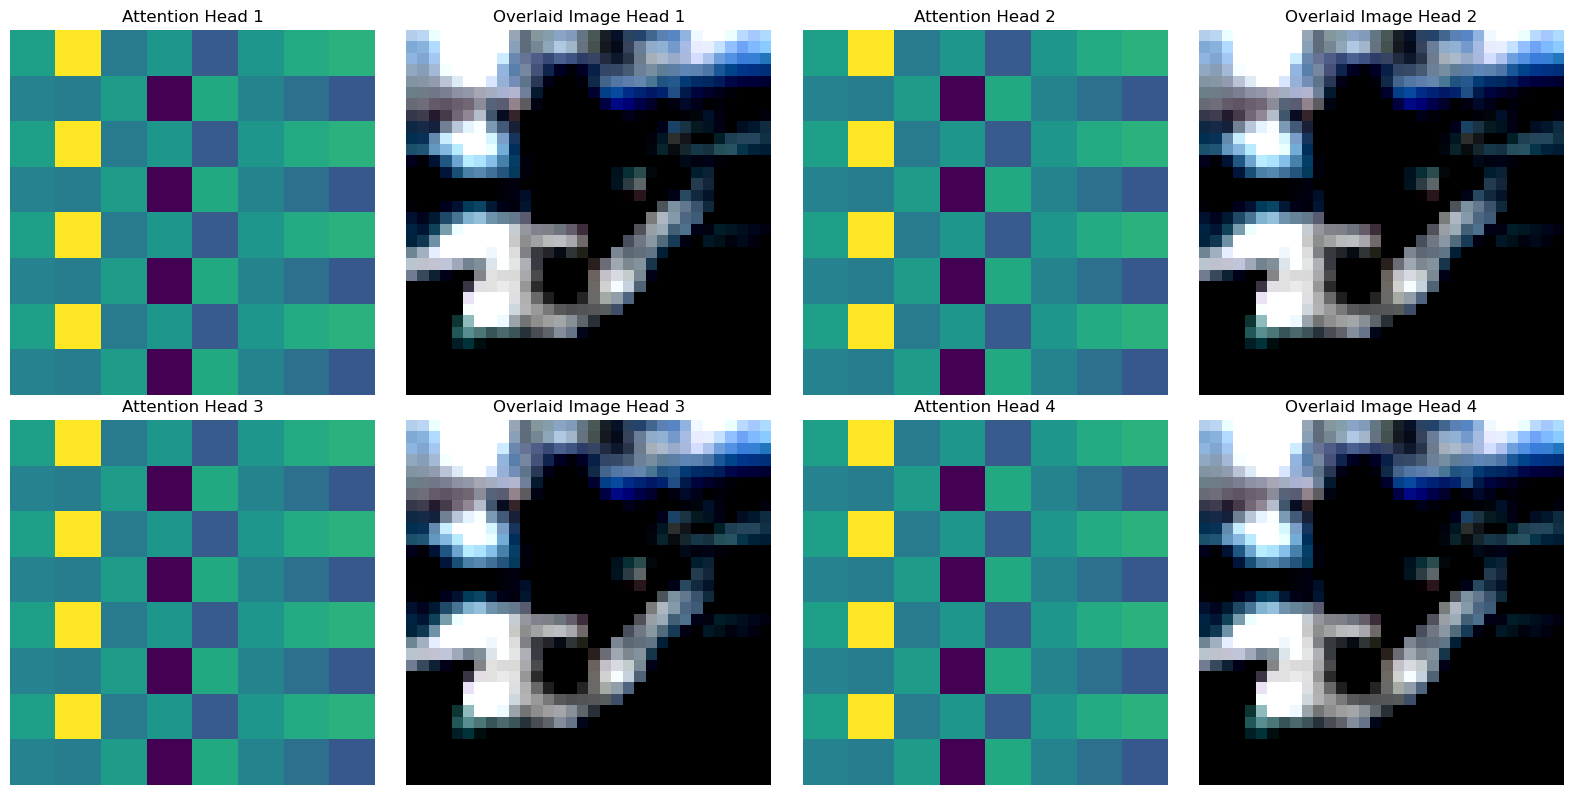

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


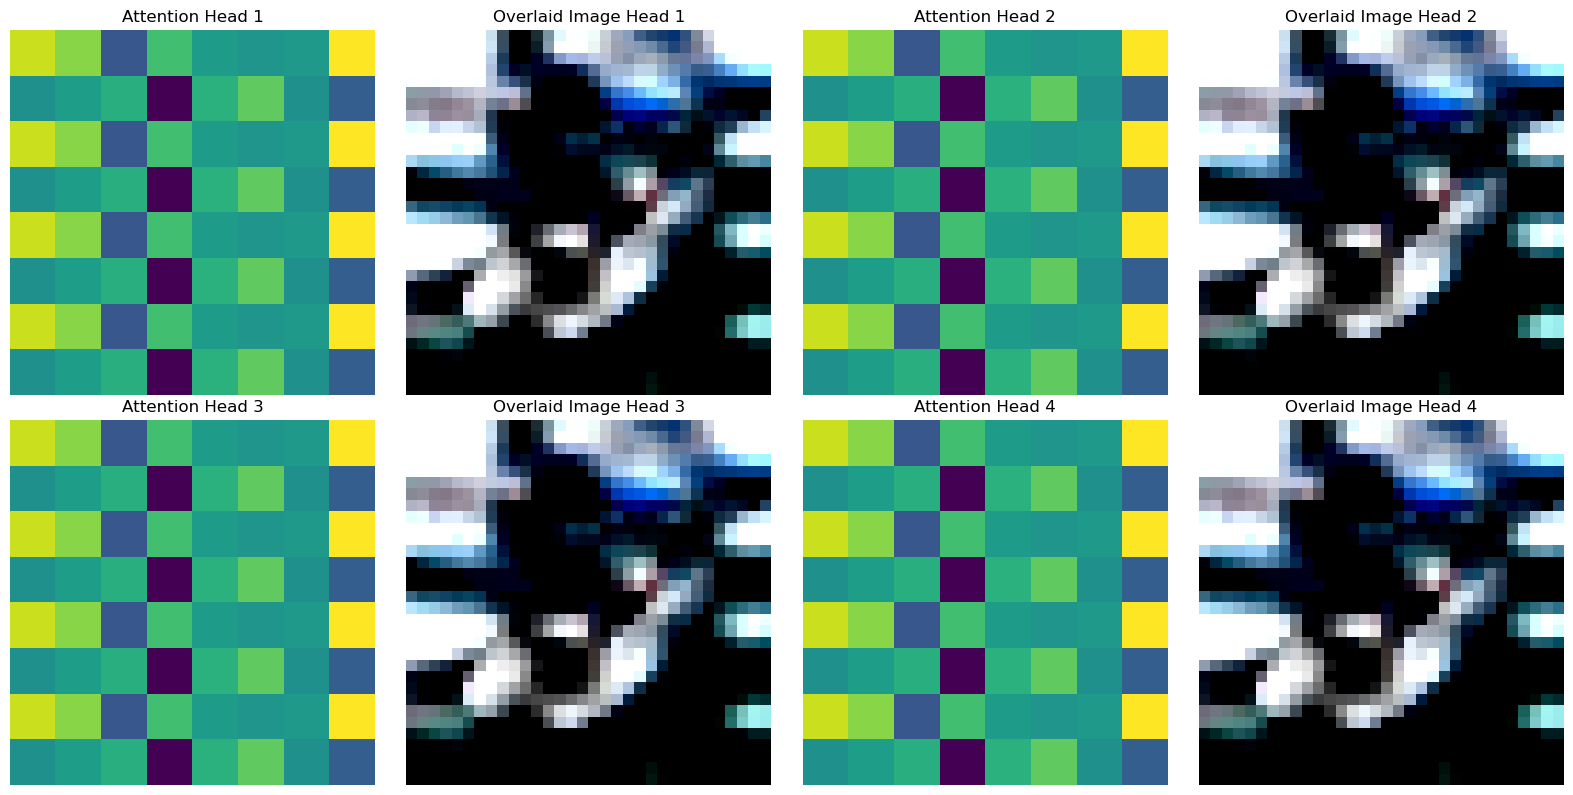

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


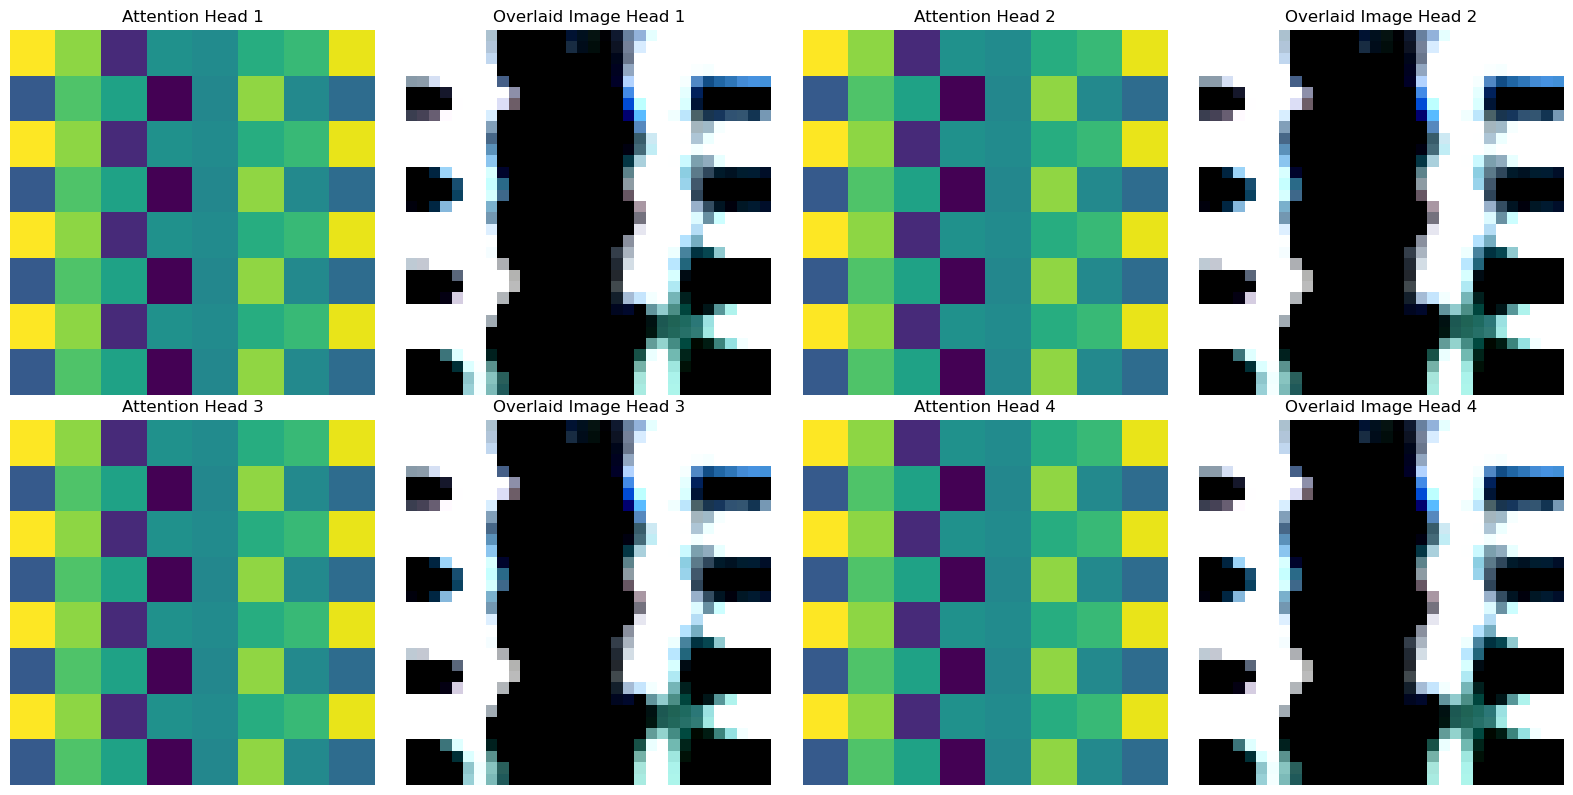

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


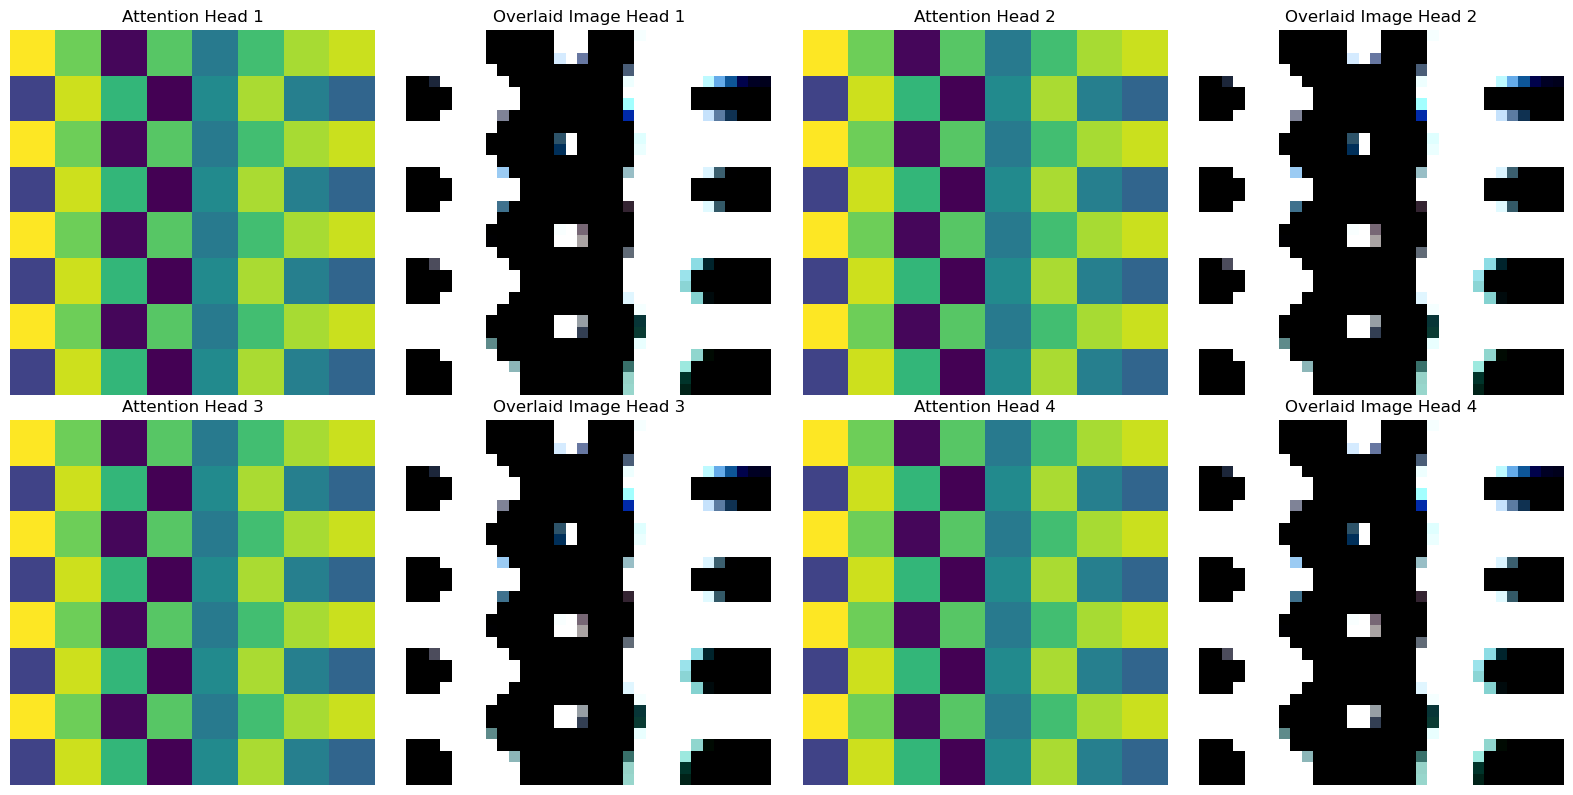

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class: 4


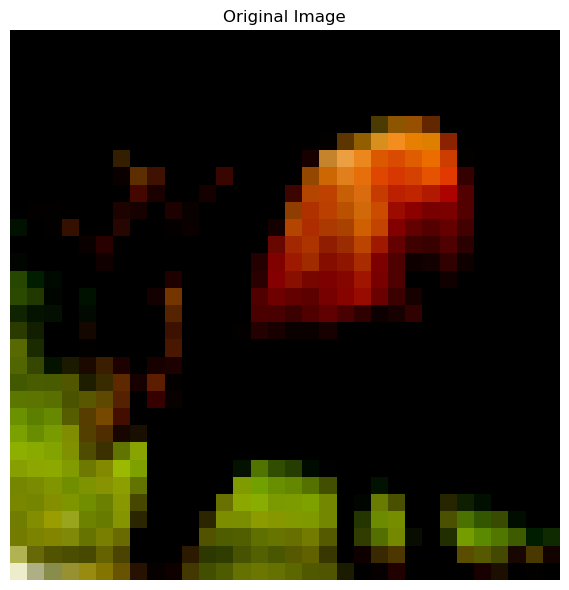

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


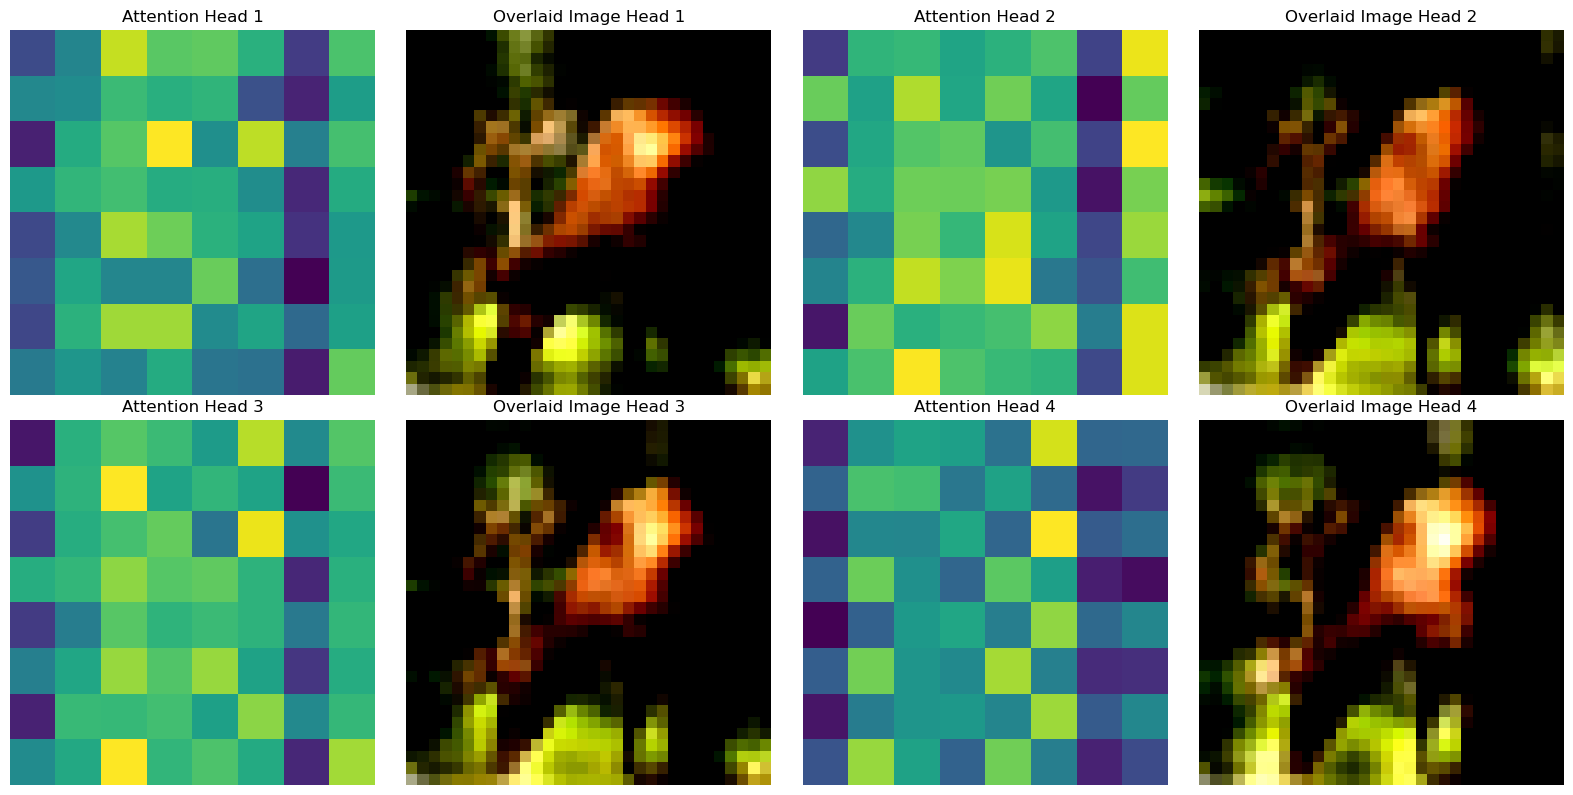

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


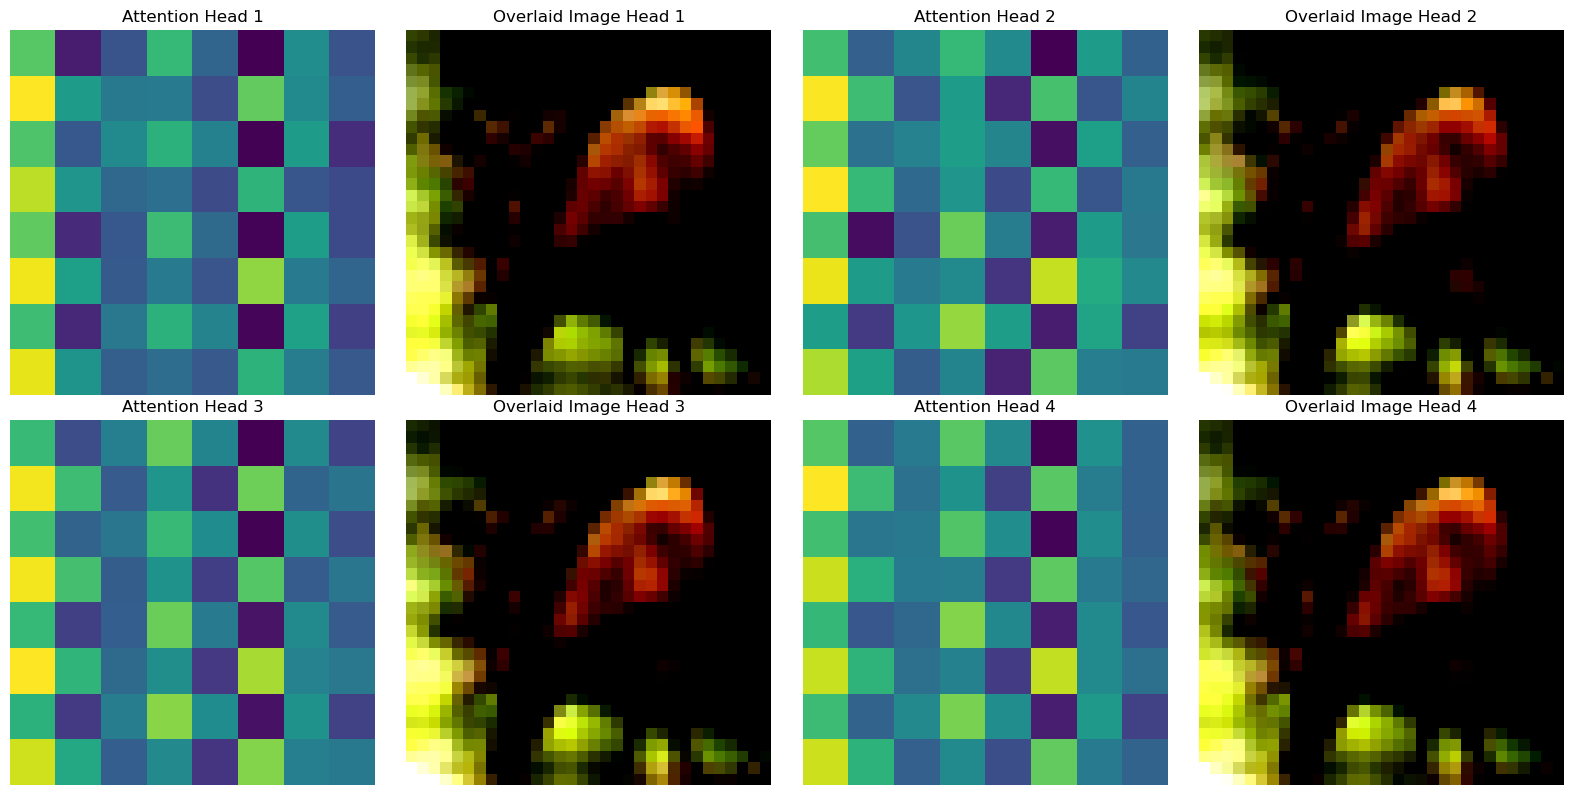

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


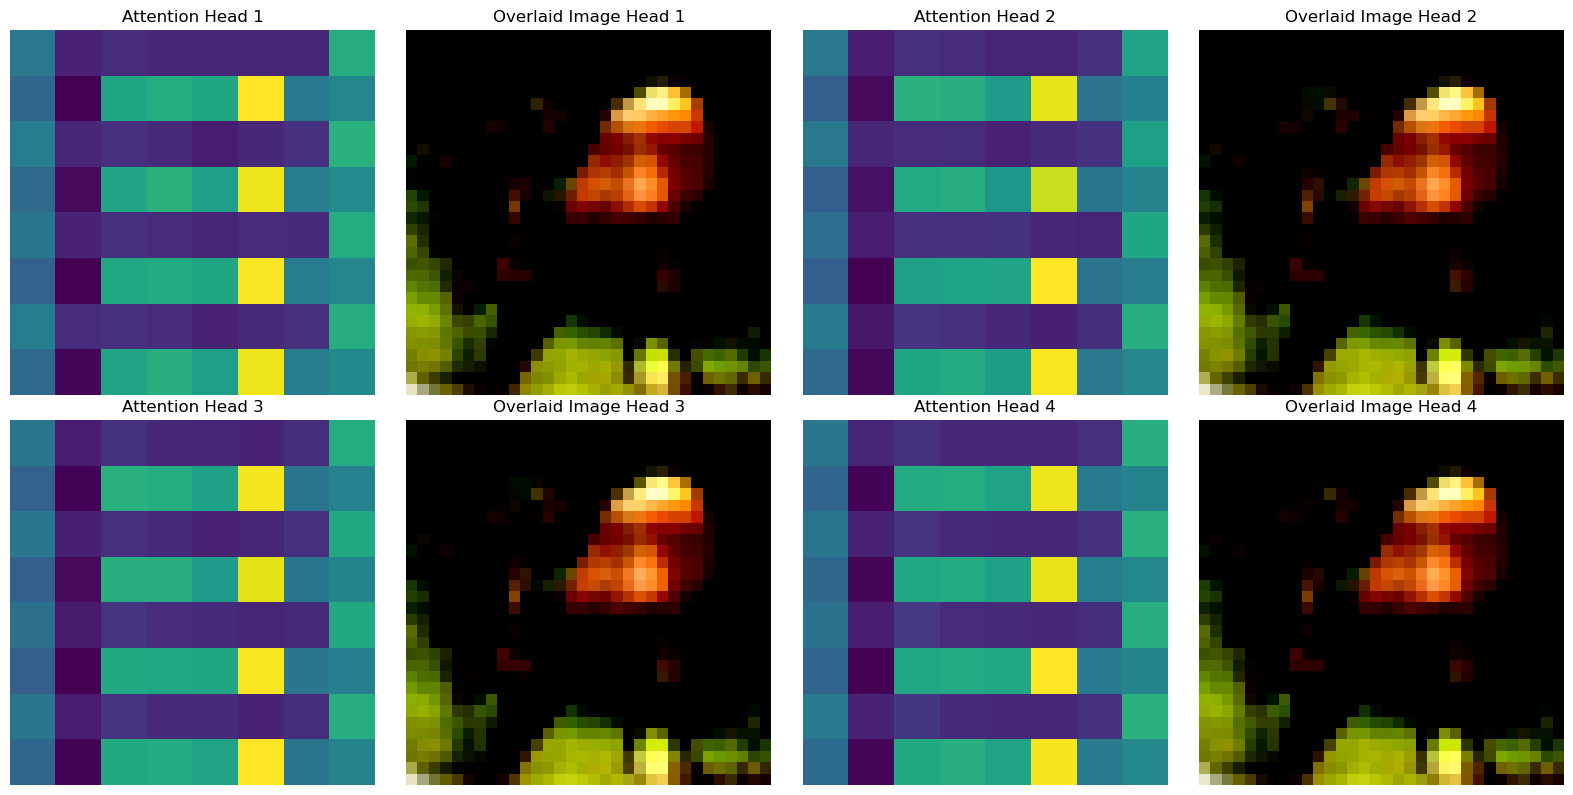

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


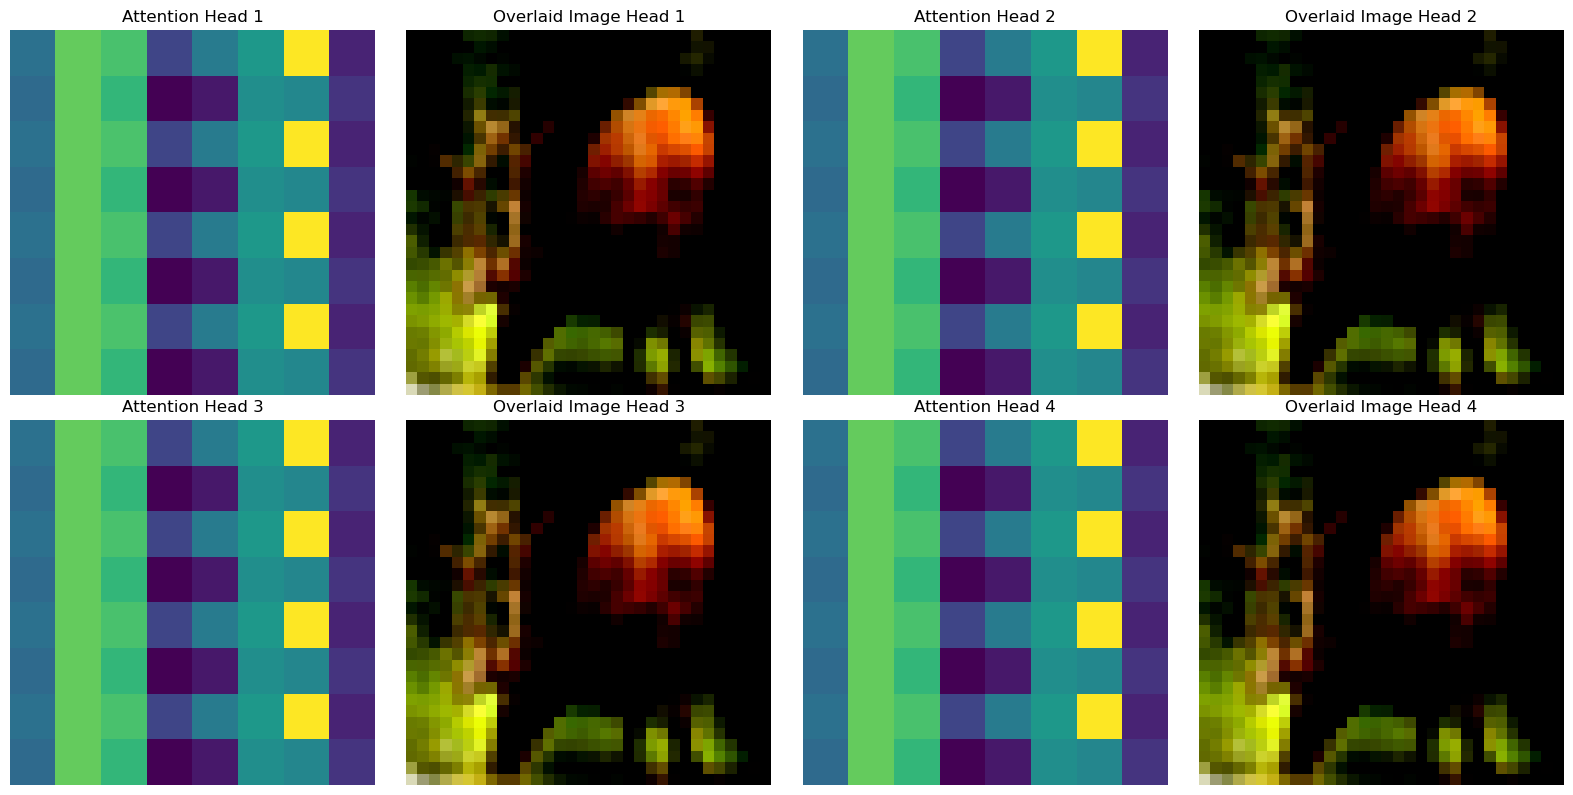

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


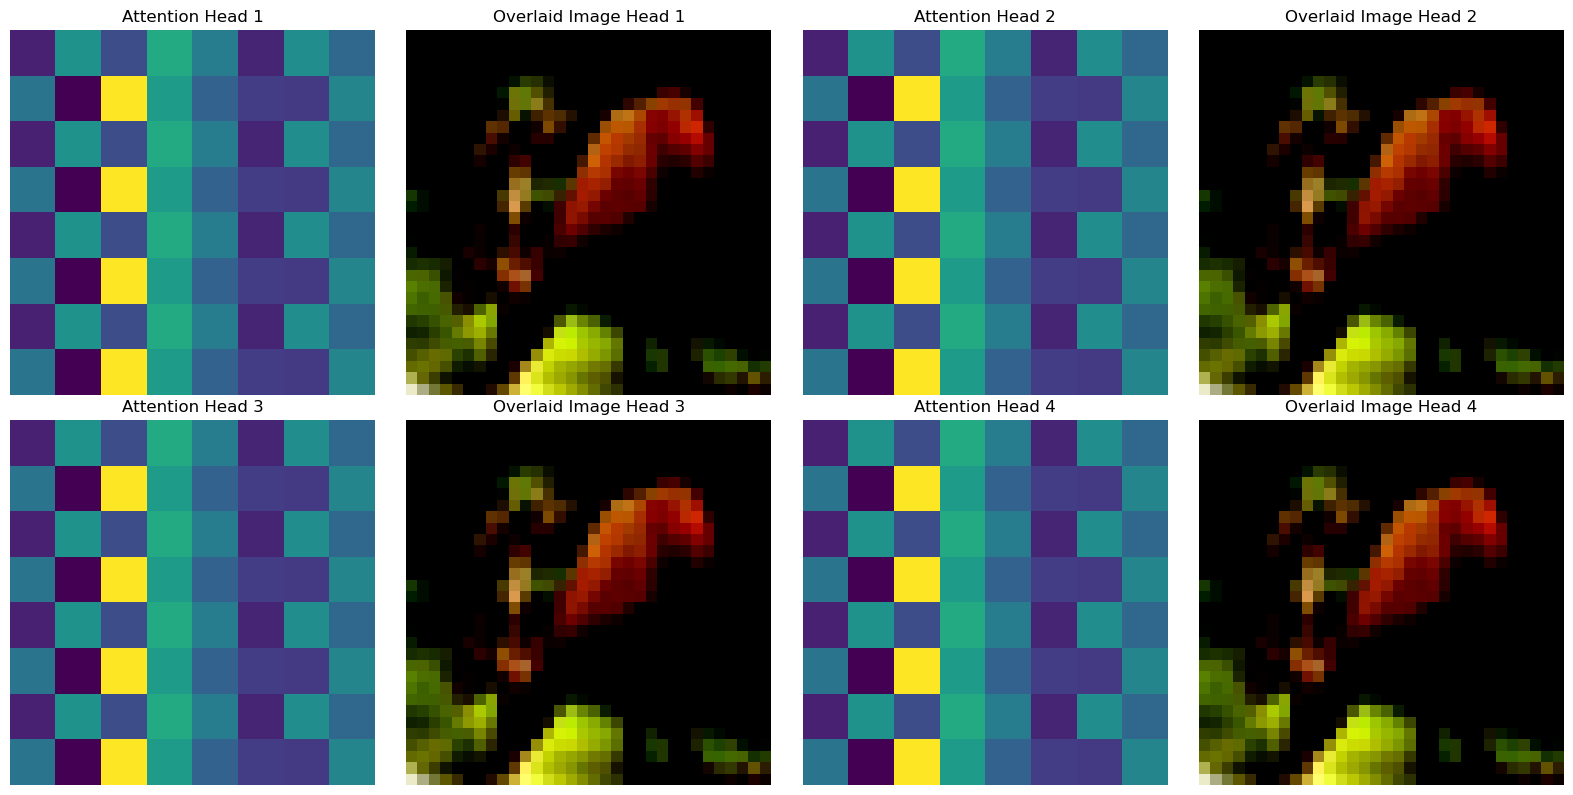

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


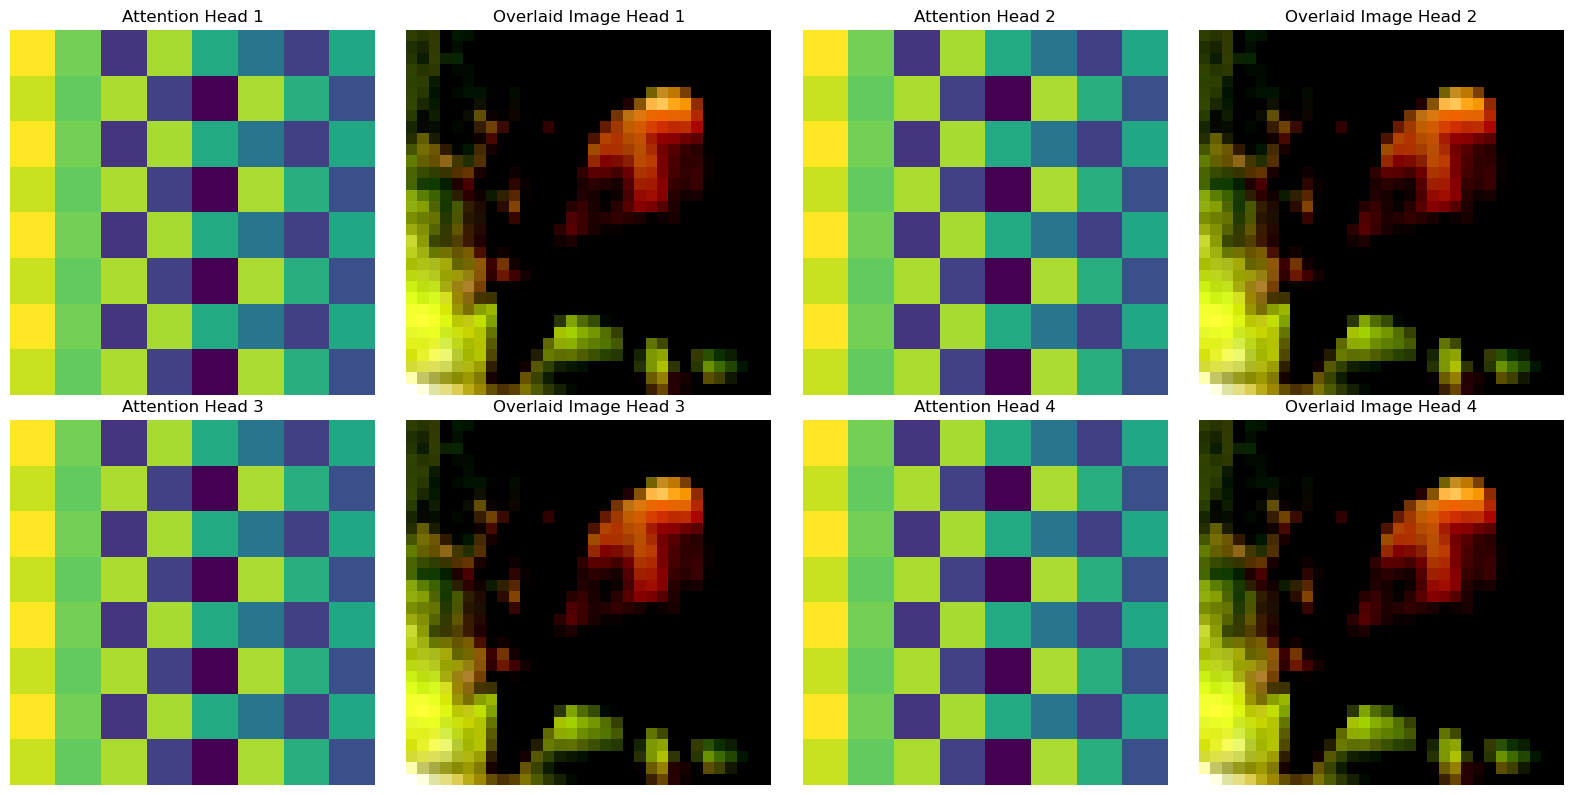

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


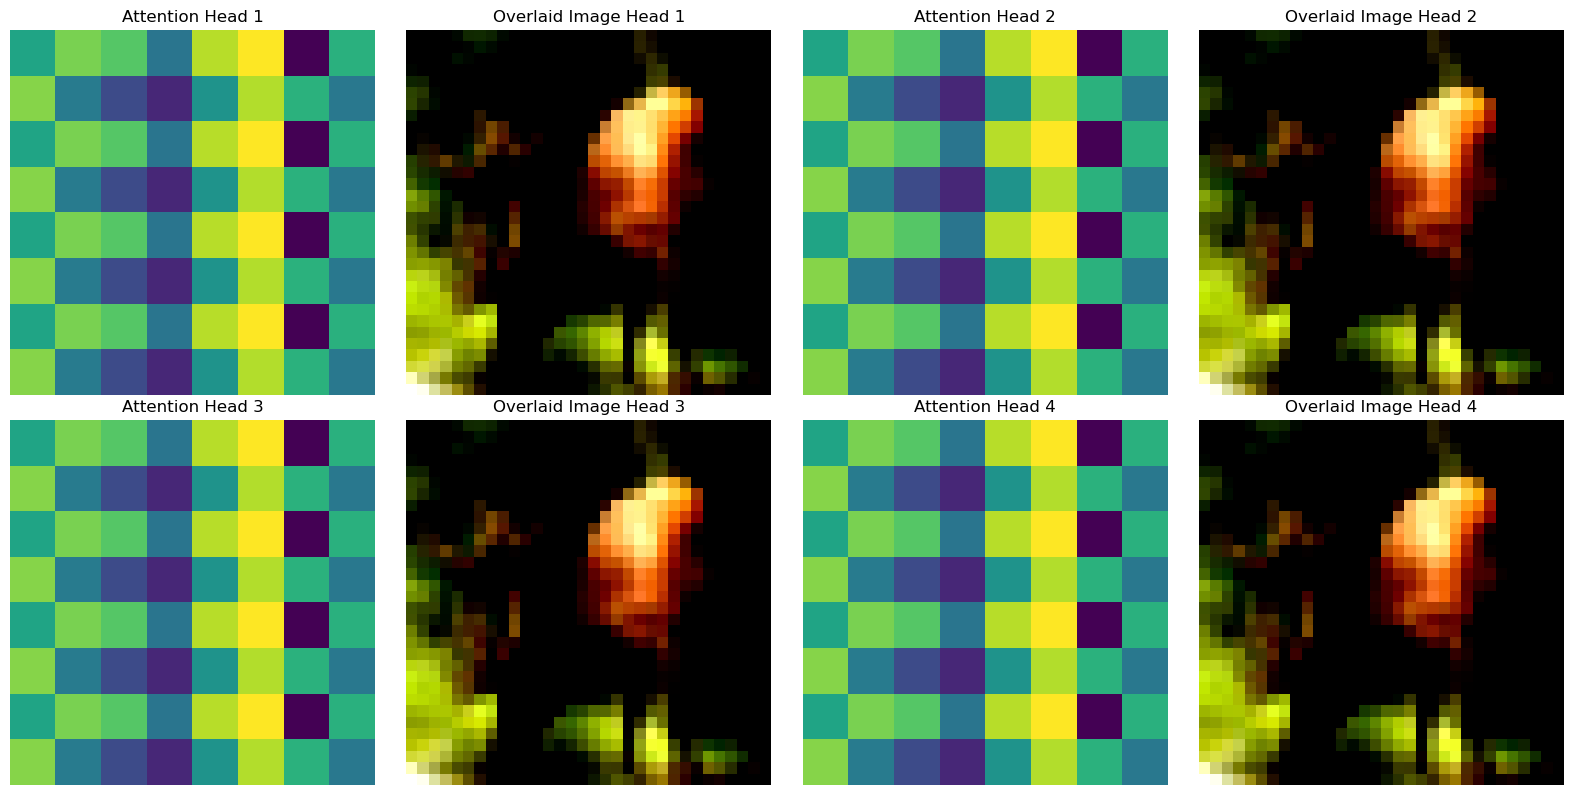

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


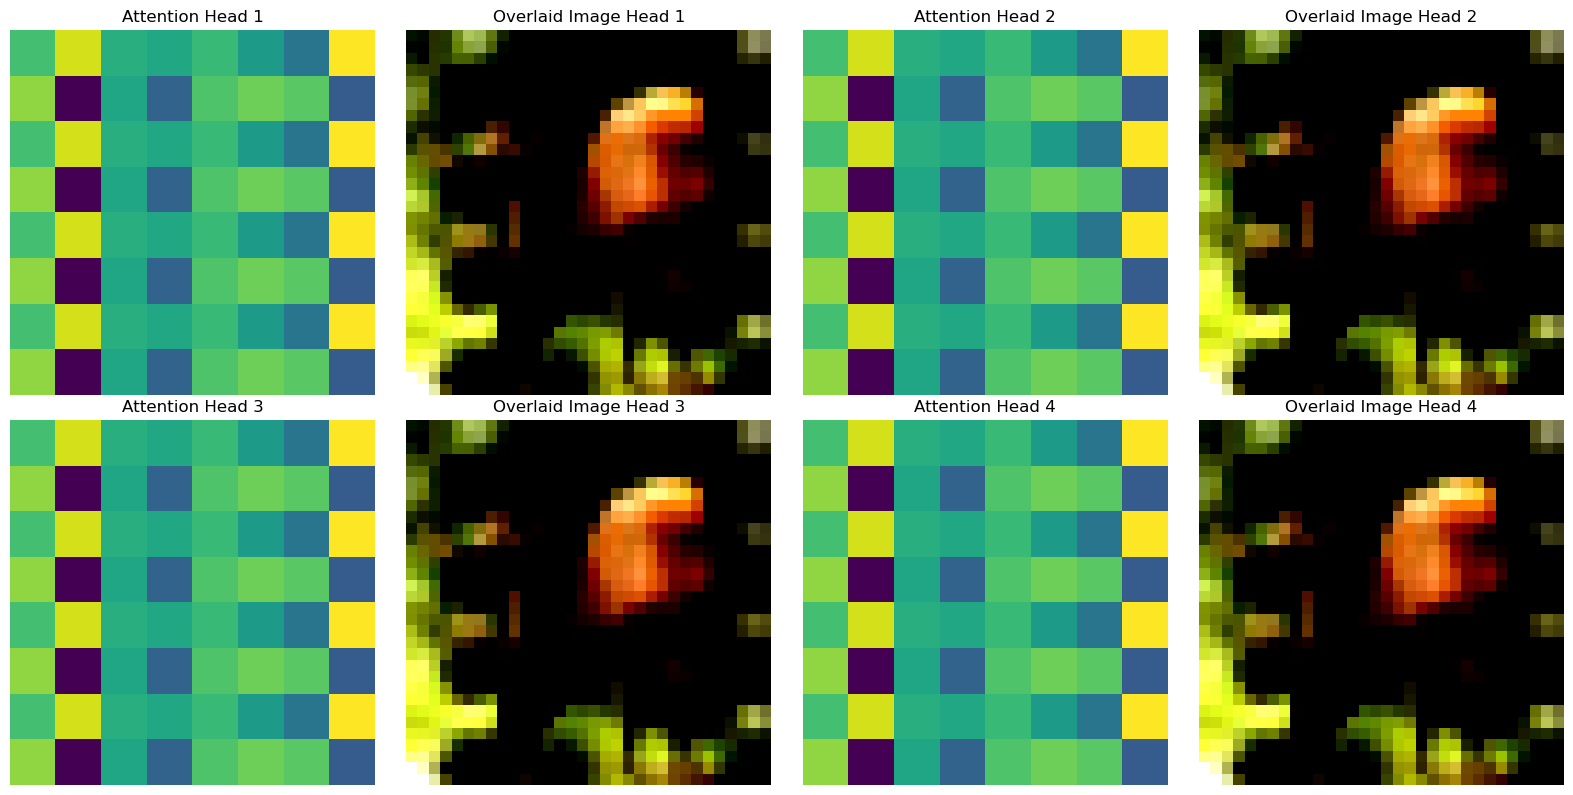

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


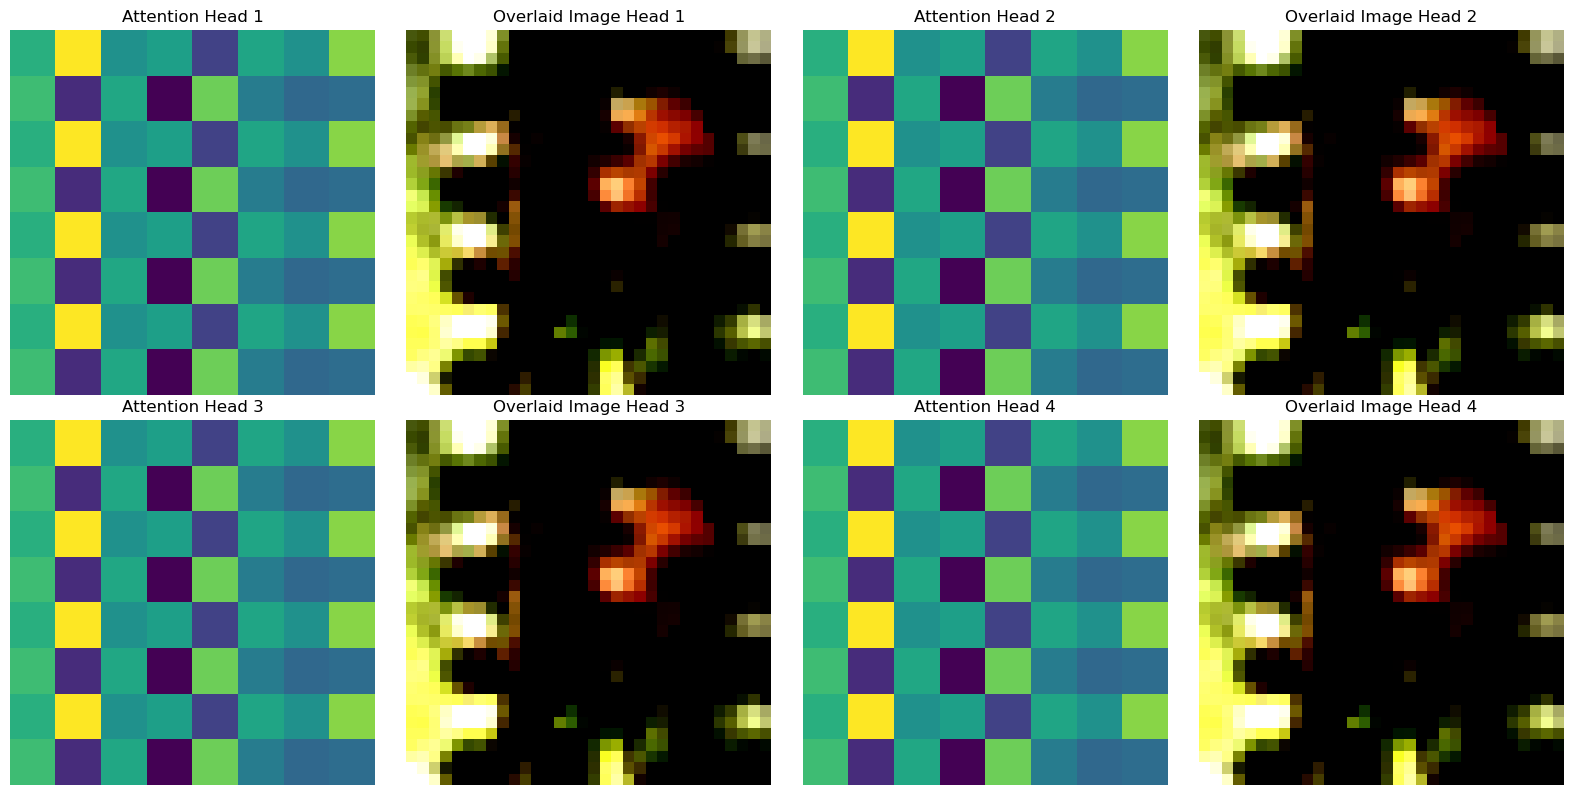

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


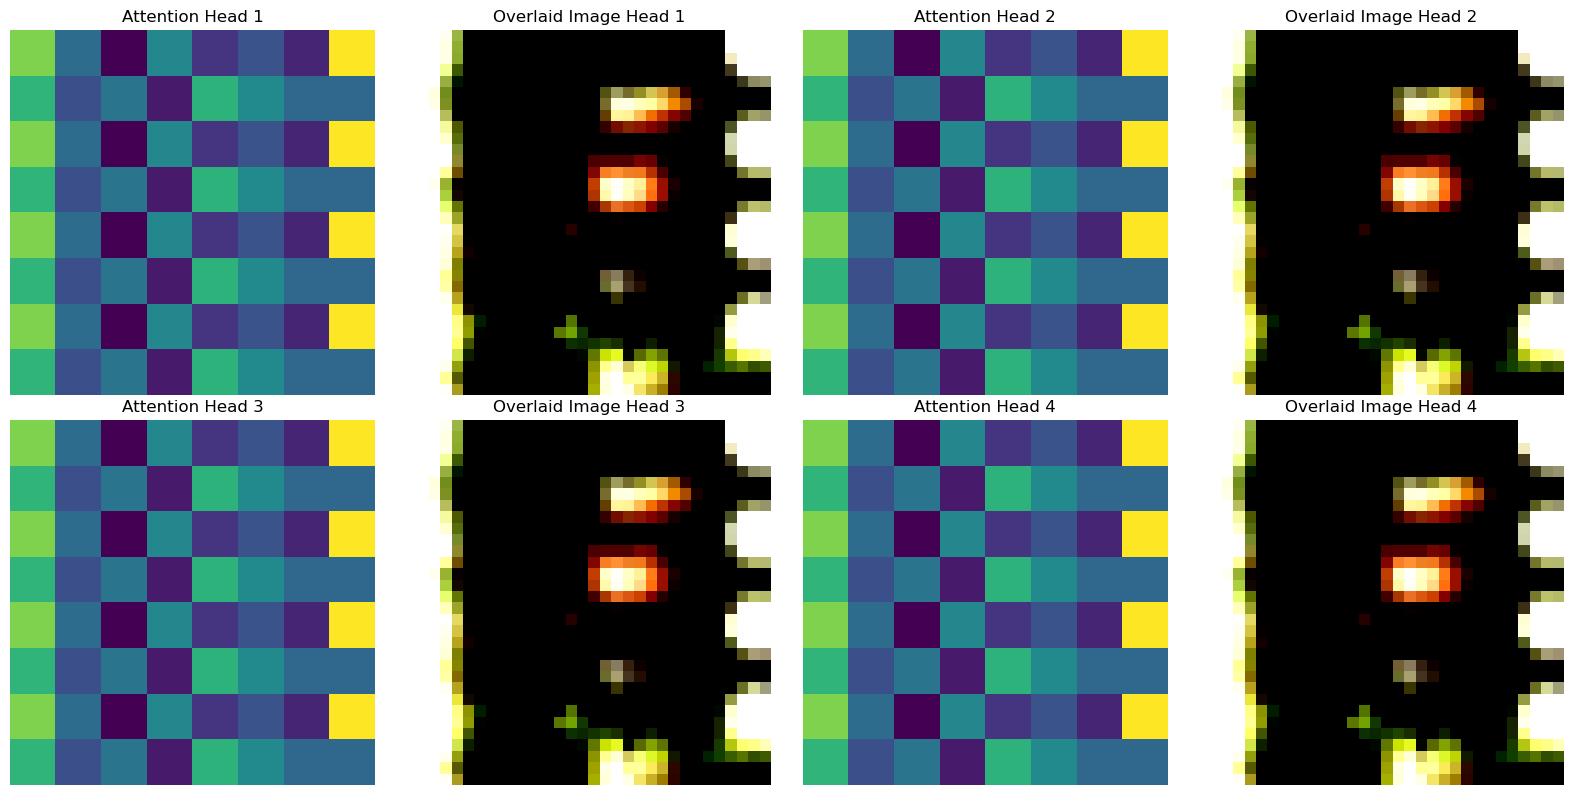

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


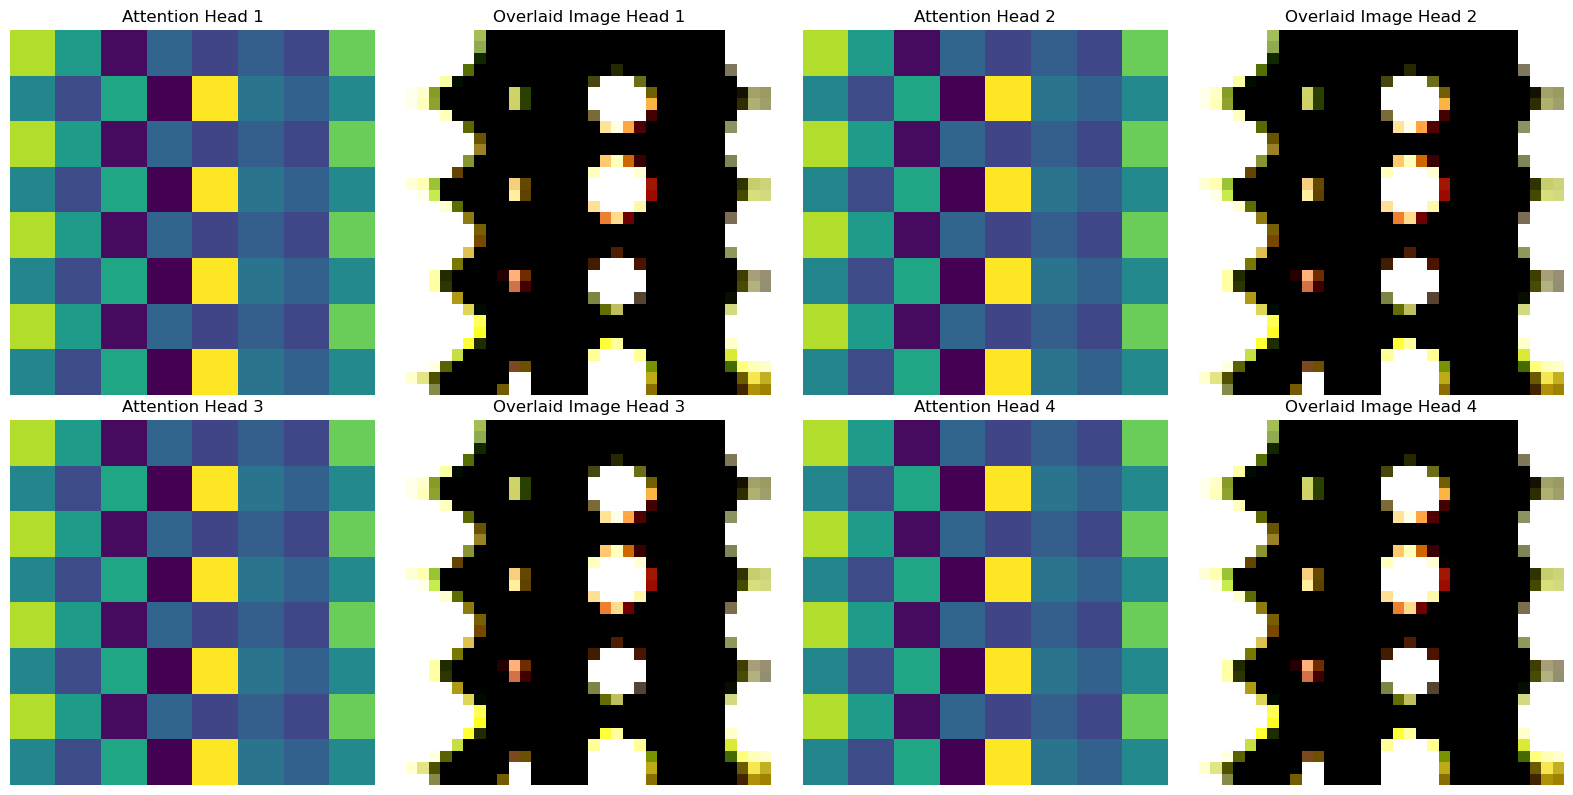

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


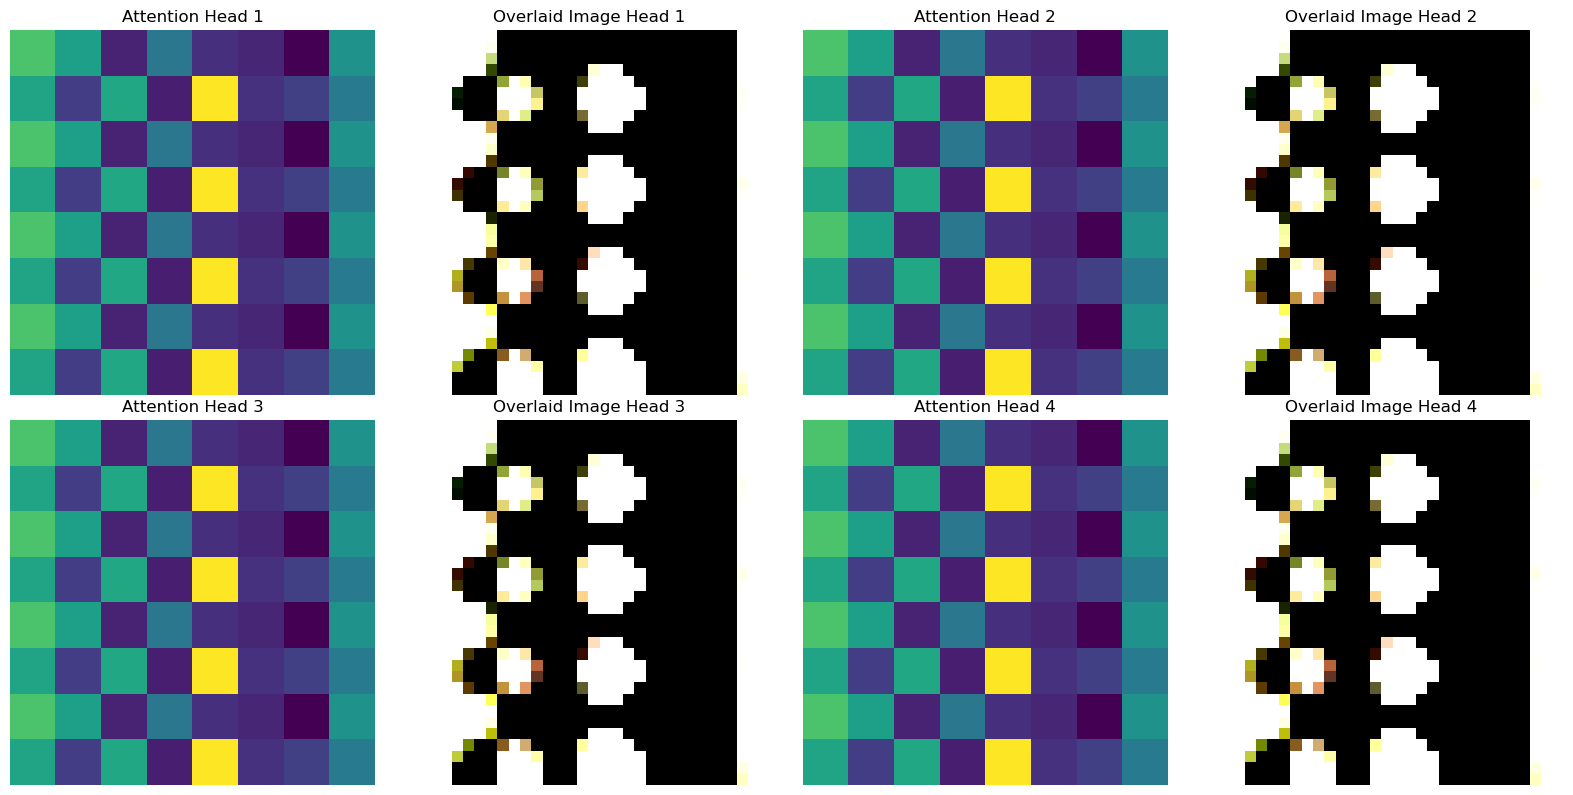

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class: 9


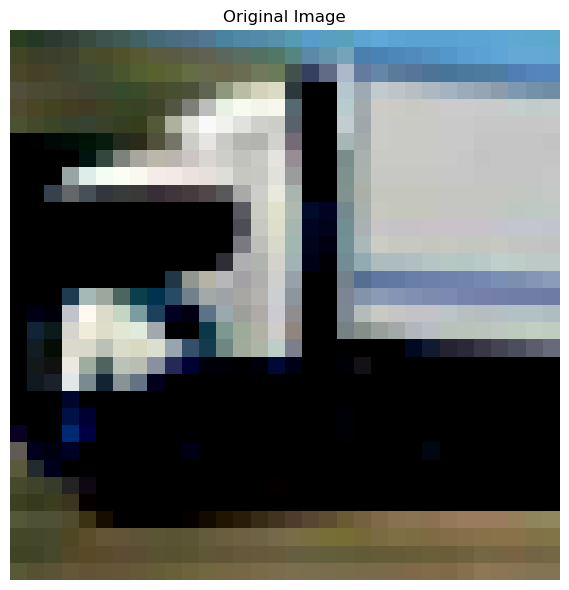

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


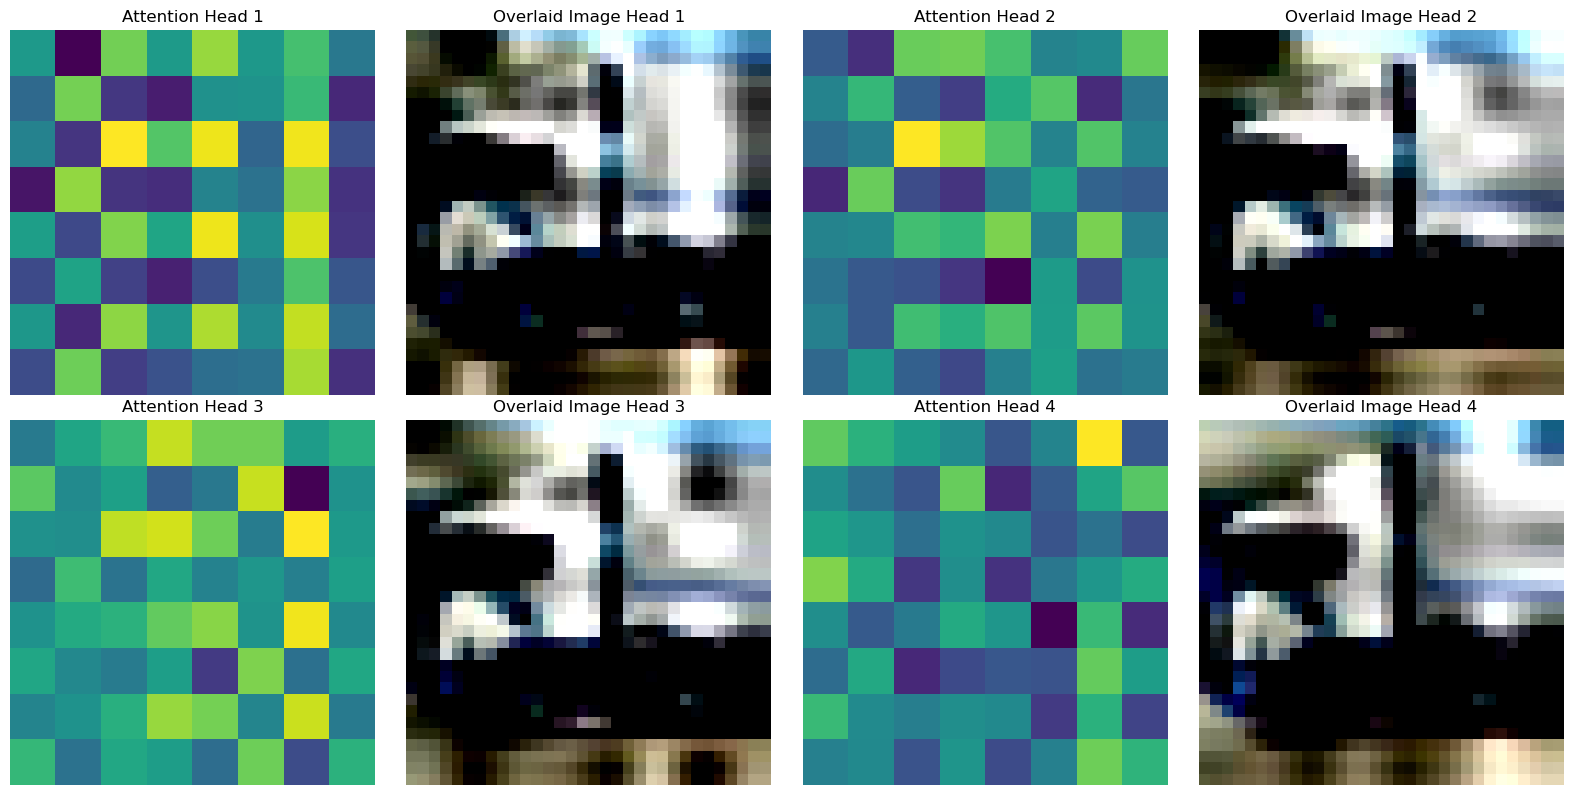

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


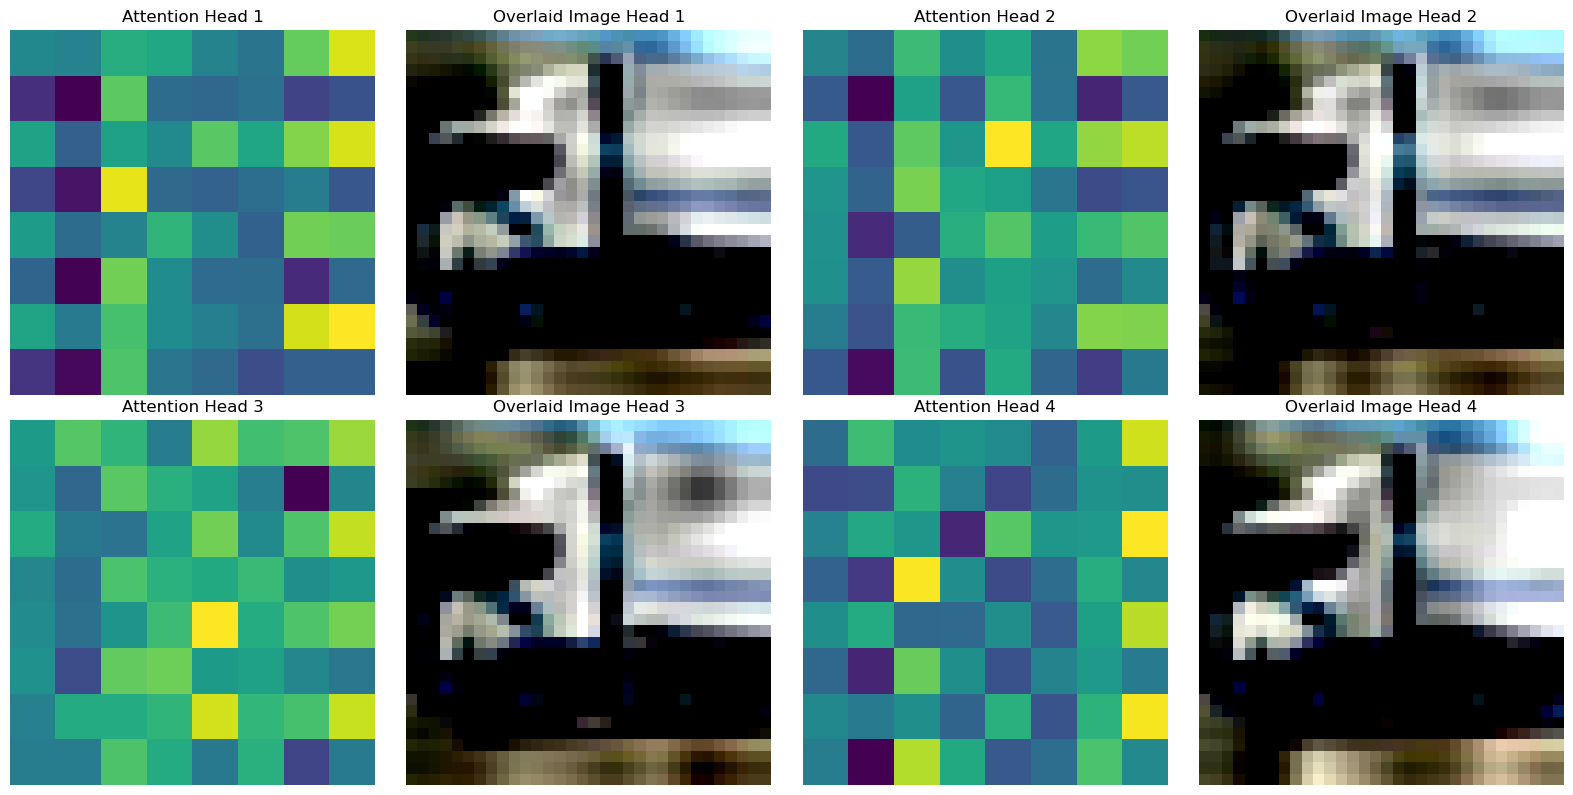

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


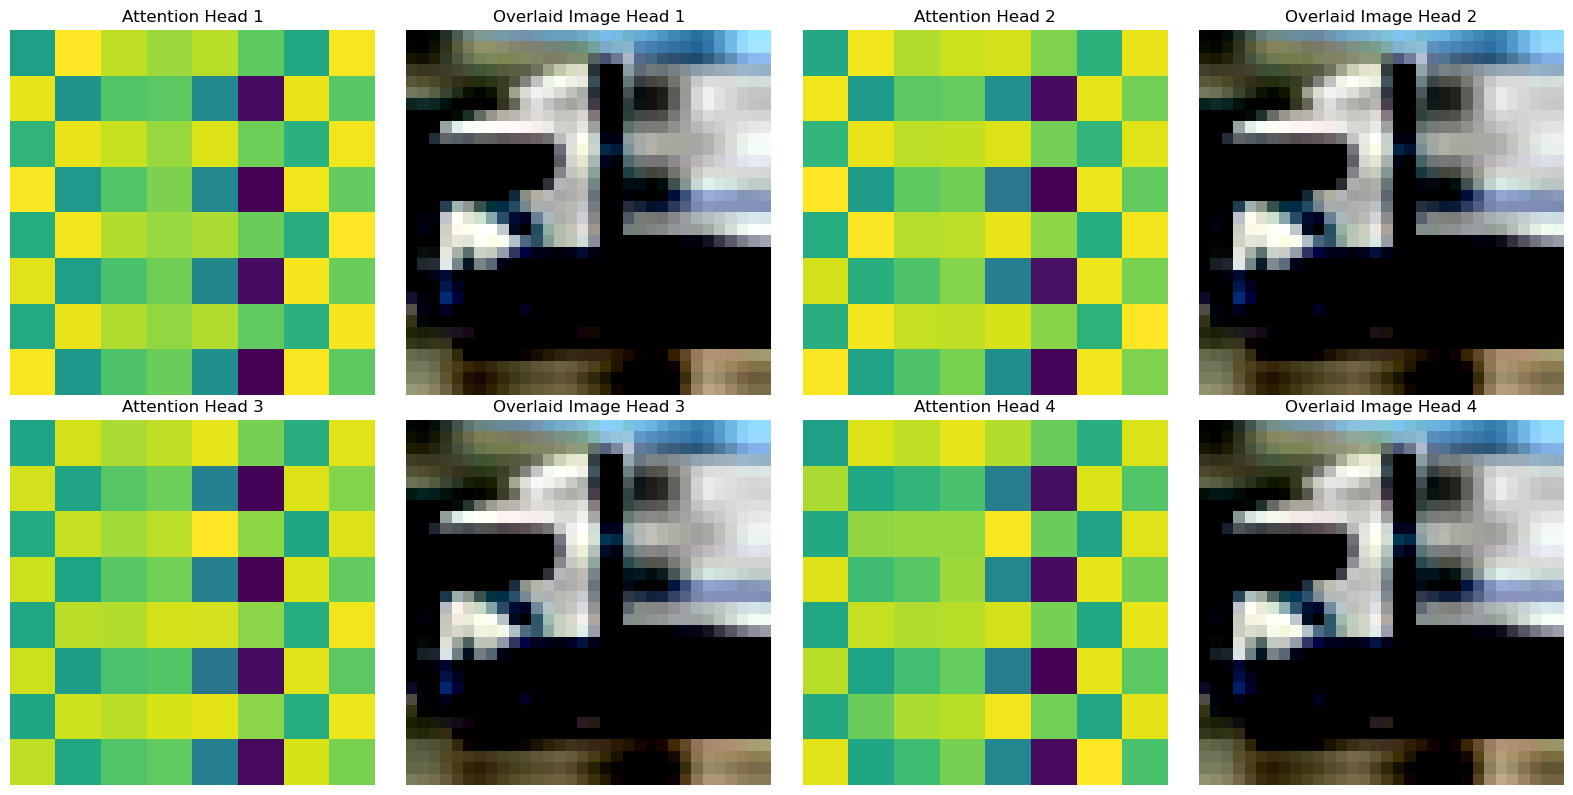

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


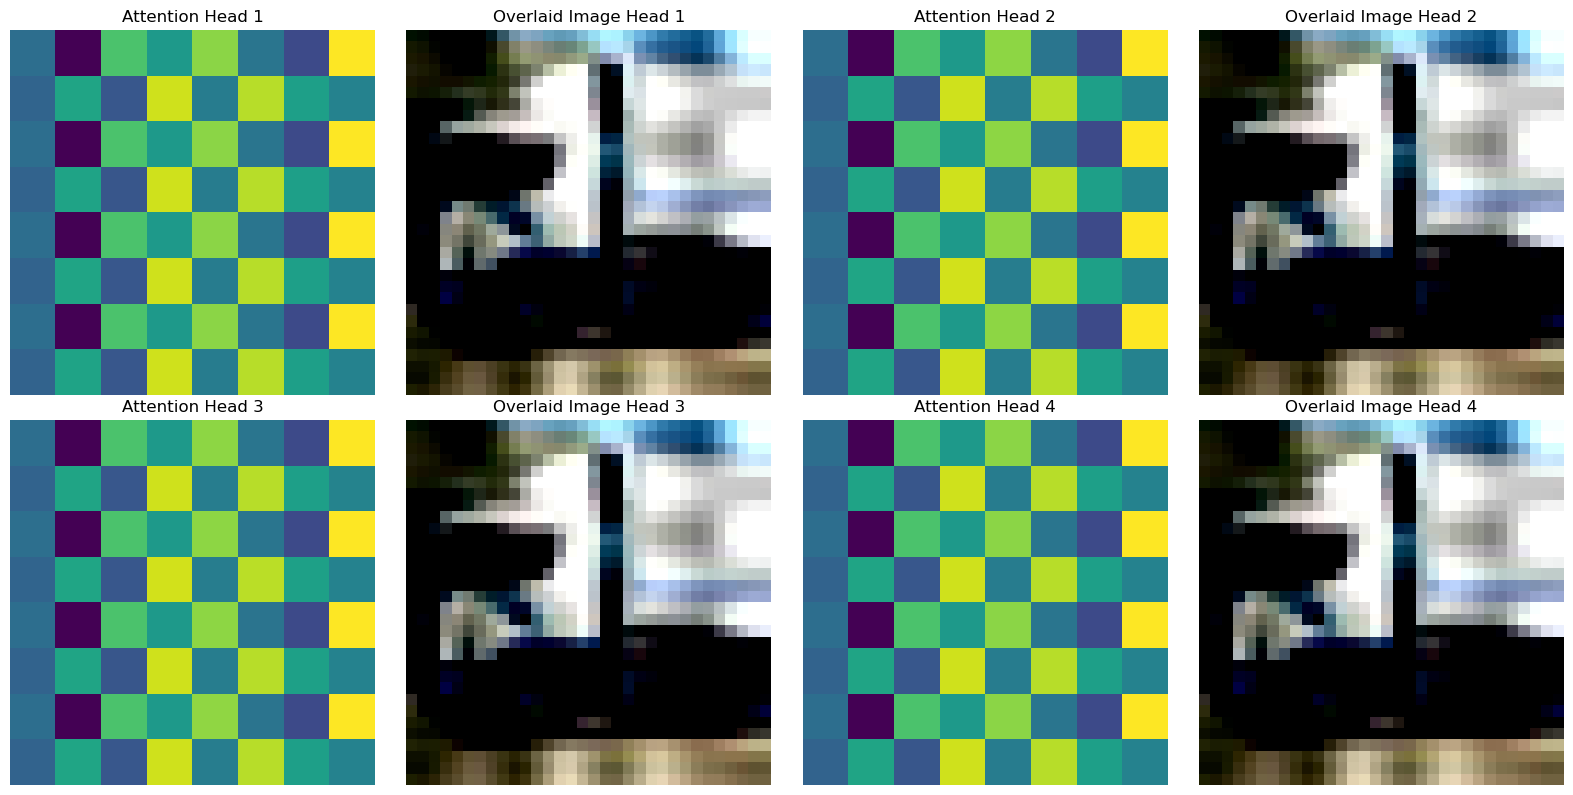

In [ ]:
# Dictionary to store one image from each class
class_images = {}

# Iterate through the dataset to find one image from each class
for images, labels in testloader:
    for image, label in zip(images, labels):
        if label.item() not in class_images:
            class_images[label.item()] = image
            break  # Break after finding one image from each class

# Pass each selected image through the model and visualize attention maps
for label, image in class_images.items():
    print(f"Class: {label}")
    plot_attention_map(model_custom, image)

# EXPERIMENT 5 LAYER ACCURACY

In [86]:
torch.save(model_custom.state_dict(), "vit_custom.pth")

In [87]:
class VisionTransformer(nn.Module):
    """
    The vision transformer.
    Parameters:
    image_size: int, the size of the image (it is a square).
    patch_size: int, the size of the patch (it is a square).
    in_channels: int, the number of input channels.
    num_classes: int, the number of classes.
    embed_dim: int, the dimension of the embedding.
    depth: int, the depth of the transformer.
    num_heads: int, the number of attention heads.
    mlp_hidden_features: int, the number of hidden features in the MLP.
    attention_dropout: float, the dropout rate for the attention.
    projection_dropout: float, the dropout rate for the projection.
    mlp_dropout: float, the dropout rate for the MLP.

    Attributes:
    patch_embedding: PatchEmbedding, the patch embedding layer.
    transformer: nn.ModuleList, the list of transformer blocks.
    norm: nn.LayerNorm, the layer normalization.
    mlp_head: nn.Linear, the linear layer for the classification.
    """

    def __init__(self, img_size = 384, patch_size = 16, in_channels = 3, n_classes = 1000, emb_size = 768, depth = 12, n_heads = 12, mlp_ratio = 4., qkv_bias = True, drop_prob = 0., attn_drop_prob = 0.):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, in_channels, patch_size, emb_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + self.patch_embed.n_patches, emb_size))
        self.pos_drop = nn.Dropout(drop_prob)
        self.blocks = nn.ModuleList([Block(emb_size, n_heads, mlp_ratio, qkv_bias, drop_prob, attn_drop_prob) for _ in range(depth)])
        self.norm = nn.LayerNorm(emb_size, eps=1e-6)
        self.head = nn.Linear(emb_size, n_classes)

    def forward(self, x, layer_idx=-1):
        """
        Forward method.
        Args:
        x: torch.Tensor, the input tensor.

        Returns:
        x: torch.Tensor, the output tensor.
        """
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(n_samples, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x += self.pos_embed
        x = self.pos_drop(x)
        cls_token = [x[:, 0]]
        for idx, transformer in enumerate(self.blocks):
            x = transformer(x)
            if idx == layer_idx:
                cls_token.append(x[:, 0])
                
        x = self.norm(cls_token[-1])
        cls_token_final = x
        # print(cls_token_final.shape)
        x = self.head(cls_token_final)
        return x

In [88]:
def get_cifar_dataloaders(batch_size):
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Resize((32, 32)),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, testloader

In [95]:
def layer_results(model, device):
    model.to(device)
    model.eval()
    trainloader, testloader = get_cifar_dataloaders(batch_size=128)
    
    # calculate the accuracy at each layer
    accuracies = []
    for layer_idx in range(12):
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images, layer_idx)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracies.append(100 * correct / total)
    return accuracies


In [90]:
custom_config = {"img_size": 32, "patch_size": 4, "in_channels": 3, "n_classes": 10, "emb_size": 48, "depth": depth, "n_heads": 4, "mlp_ratio": 4., "qkv_bias": True, "drop_prob": 0.3, "attn_drop_prob": 0.3}


In [92]:
model_custom = VisionTransformer(**custom_config)

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_custom.load_state_dict(torch.load("vit_custom.pth"))

<All keys matched successfully>

In [96]:
accuracies = layer_results(model_custom, device)

Files already downloaded and verified
Files already downloaded and verified


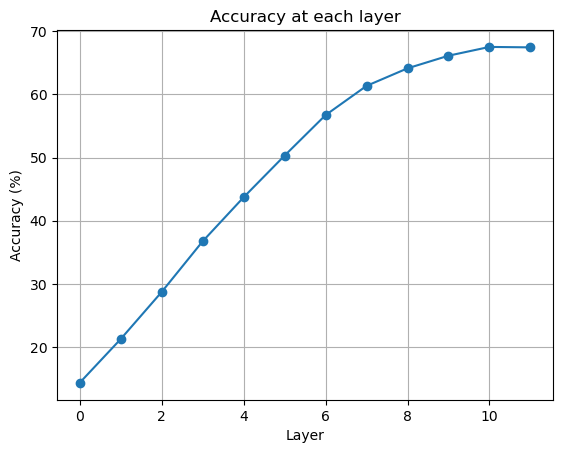

In [97]:
plt.plot(accuracies, marker='o')
plt.xlabel('Layer')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy at each layer')
plt.grid()
plt.show()
